# Create geoJSON Voronoi Graphics for SST

In [5]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd

In [6]:
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import branca
import matplotlib.pyplot as plt
import geojsoncontour
import json
import xarray as xr
import datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.figure import Figure
from scipy.spatial.distance import cdist

In [7]:
from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point

In [8]:
from shapely.ops import cascaded_union

In [9]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

In [10]:
def find_nth(string, substring, n):
   if (n == 1):
       return string.find(substring)
   else:
       return string.find(substring, find_nth(string, substring, n - 1) + 1)
def find_sourceid(run):
    return run[find_nth(run,"_",2)+1:find_nth(run,"_",3)]
def find_variableid(run):
    return run[:find_nth(run,"_",1)]
def find_experimentid(run):
    return run[find_nth(run,"_",3)+1:find_nth(run,"_",4)]

In [11]:
def palau_eez(df):
    in_palau = []
    longlat = df[['lon','lat']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['lon', 'lat']].apply(tuple, axis=1).isin(in_palau)]

In [36]:
boundary = gpd.read_file('palauEEZ.geojson')
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getGridGeoJSON(time,df):
    df = palau_eez(df)
    df_slice = df[df['year'] == time]


    coordinates = df_slice[['lat','lon','pr']]
    coordinates = coordinates.drop_duplicates()

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()


    mocean.cm.rain
    levels = len(colors)
    vmin   = min(df.pr.tolist())
    vmax   = max(df.pr.tolist())
    tiers = np.linspace(vmin,vmax,levels+1).tolist()

    
    df_slice = df_slice.sort_values(by=['lon','lat'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.lat, df_slice.lon))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

        
    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    for point in points_gdf.geometry:
        if eez.contains(point) or point.within(eez):
            in_palau.append(point)
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["lon"] = longitude
    voronoi_poly["lat"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['lon','lat'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    values = df_slice['pr'].tolist()
    
    df_colors = []
    
    for v in values:
        for i in range(len(tiers)):
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break

    
    df_slice['fill'] = df_colors
    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")
    
#     #Plotting voronoi
#     fig, ax = plt.subplots(figsize=(12, 10))
#     boundary.plot(ax=ax, color="gray")
#     voronoi_color.plot(ax=ax, color=voronoi_color["fill"])
#     points_gdf.plot(ax=ax, markersize=1, color="black")
#     ax.axis("off")
#     plt.axis('equal')
#     plt.show()
    
    #Plotting colorbar
#     cmap = mpl.colors.ListedColormap(colors)
#     bounds = [round(x,2) for x in tiers]
#     norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
#     cfig, ax = plt.subplots(figsize=(8,1))
#     cfig.subplots_adjust(bottom=0.5)
#     cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Sea Surface Temperature °C")
    
#     cfig.savefig("example.png")
    
    #Convert color to RGB

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    
    json_gdf = trimmed.to_json()
    
    
    return json.loads(json_gdf)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_30195/590148874.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_30195/590148874.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [17]:
boundary = gpd.read_file('palauEEZ.geojson')
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

from matplotlib.colors import Normalize


def getGridGeoJSON(time, df, var = 'pr',colorbar_directory, experiment):
    df = palau_eez(df)
    df_slice = df[df['year'] == time]
    
    df_slice = df_slice.sort_values(by=['lon','lat'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.lat, df_slice.lon))
    
    coordinates = [list(c) for c in df_slice['new_col']]
    points = [Point(c[1], c[0]) for c in coordinates]
    
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = [point for point in points_gdf.geometry if eez.contains(point) or point.within(eez)]
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)
    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude, latitude = zip(*[coords[pt] for pt in pts])
    voronoi_poly["lon"], voronoi_poly["lat"] = longitude, latitude
    
    df_slice = df_slice.drop(['new_col'], axis=1)
    df_slice['geometry'] = voronoi_poly.sort_values(by=['lon','lat'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index(drop=True)
    
    # Define colormap and normalization
    if var == "pr":
        cmap = cmocean.cm.rain
        vmin, vmax = df[var].min(), df[var].max()
        if np.isnan(vmin) or np.isnan(vmax):
            raise ValueError("Invalid vmin or vmax for colormap scaling!")
        
        norm = Normalize(vmin=vmin, vmax=vmax)
        values = df_slice[var].tolist()
        rgba_colors = cmap(norm(values))
    
    # Convert RGBA to HEX for plotting
    df_slice['fill'] = [
        "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))
        for r, g, b, _ in rgba_colors
    ]
    
    df_slice['R'] = (rgba_colors[:, 0] * 255).astype(int)
    df_slice['G'] = (rgba_colors[:, 1] * 255).astype(int)
    df_slice['B'] = (rgba_colors[:, 2] * 255).astype(int)
    
    json_gdf = GeoDataFrame(df_slice, crs="EPSG:3395")
    
    # Remove land areas from the voronoi diagram
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'], axis=1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf, palau_land, how='difference')
    
    # Plot Voronoi diagram
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    # Generate colorbar
    fig, ax = plt.subplots(figsize=(8, 1))
    
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation='horizontal', label="Precipitation (mm)")
    fig.savefig(colorbar_directory)
    
    return json.loads(trimmed.to_json())




# def colorbar_mpl(df, full_directory,var):
#     df = palau_eez(df)
# #     df_slice = df[df['year'] == time]


#     coordinates = df[['lat','lon',var]]
#     coordinates = coordinates.drop_duplicates()

#     colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
#          "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
#          "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
#          "#4c33ff","#8c19ff","#cc00ff"]
#     colors.reverse()
#     levels = len(colors)
#     vmin   = min(coordinates[var].tolist())
#     vmax   = max(coordinates[var].tolist())
#     cmap = mpl.colors.ListedColormap(colors)
#     tiers = np.linspace(vmin,vmax,levels+1).tolist()
    
    
#     bounds = [round(x,2) for x in tiers]

#     norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
#     cfig, ax = plt.subplots(figsize=(8,1))
#     cfig.subplots_adjust(bottom=0.5)
#     cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Precipitation")
    
#     cfig.savefig(full_directory)


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from shapely.geometry import Point
from shapely.ops import cascaded_union
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import json

# Load boundary data
boundary = gpd.read_file('palauEEZ.geojson')
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

# Define variable to colormap and description mappings
var_to_cmap = {
    'zos': ('balance', 'Sea Surface Height above Geoid (m)'),
    'thetao': ('thermal', 'Sea Water Potential Temperature (Celsius)'),
    'ph': ('solar', 'pH'),
    'no3': ('algae', 'Mole Concentration of Nitrate in Seawater (mol m-3)'),
    'po4': ('algae', 'Mole Concentration of Phosphate in Seawater (mol m-3)'),
    'phyc': ('algae', 'Mole Concentration of Phytoplankton as Carbon in Seawater (mol m-3)')
}

# ['zos','thetao','ph','no3','po4','phyc']

def getGridGeoJSON(time, df, var='zos', colorbar_directory=None, experiment=None):
    df = palau_eez(df)
    df_slice = df[df['year'] == time]
    
    df_slice = df_slice.sort_values(by=['lon', 'lat'], ascending=[False, True])
    df_slice['new_col'] = list(zip(df_slice.lat, df_slice.lon))
    
    coordinates = [list(c) for c in df_slice['new_col']]
    points = [Point(c[1], c[0]) for c in coordinates]
    
    points_gdf = gpd.GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = [point for point in points_gdf.geometry if eez.contains(point) or point.within(eez)]
    points_gdf = gpd.GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)
    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = gpd.GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude, latitude = zip(*[coords[pt] for pt in pts])
    voronoi_poly["lon"], voronoi_poly["lat"] = longitude, latitude
    
    df_slice = df_slice.drop(['new_col'], axis=1)
    df_slice['geometry'] = voronoi_poly.sort_values(by=['lon', 'lat'], ascending=[False, True])['geometry'].tolist()
    df_slice = df_slice.reset_index(drop=True)
    
    # Get colormap and description for the variable
    cmap_name, description = var_to_cmap[var]
    cmap = getattr(cmocean.cm, cmap_name)
    
    # Handle special case for zos (centered at 0)
    if var == 'zos':
        vmax = max(abs(df[var].min()), abs(df[var].max()))
        vmin = -vmax
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        vmin, vmax = df[var].min(), df[var].max()
        norm = Normalize(vmin=vmin, vmax=vmax)
    
    values = df_slice[var].tolist()
    rgba_colors = cmap(norm(values))
    
    # Convert RGBA to HEX for plotting
    df_slice['fill'] = [
        "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))
        for r, g, b, _ in rgba_colors
    ]
    
    df_slice['R'] = (rgba_colors[:, 0] * 255).astype(int)
    df_slice['G'] = (rgba_colors[:, 1] * 255).astype(int)
    df_slice['B'] = (rgba_colors[:, 2] * 255).astype(int)
    
    json_gdf = gpd.GeoDataFrame(df_slice, crs="EPSG:3395")
    
    # Remove land areas from the voronoi diagram
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type', 'id', 'tags', 'meta'], axis=1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf, palau_land, how='difference')
    
    # Plot Voronoi diagram
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    # Generate colorbar
    fig, ax = plt.subplots(figsize=(8, 1))
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation='horizontal', label=f"{description} ({experiment})")
    fig.savefig(colorbar_directory)
    
    return json.loads(trimmed.to_json())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_8794/1653081629.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_8794/1653081629.py:15: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [ ]:
#Used to validate that pts corresponds to coordinate index
# points = []
#     coordinates = coords[pts[1]]
#     for x in coordinates:
#         points.append(Point(x[0],x[1]))
        
#     points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
#     voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=[list(poly_shapes.values())[1]])
#     fig, ax = plt.subplots(figsize=(12, 10))
#     boundary.plot(ax=ax, color="gray")
#     voronoi_poly.plot(ax=ax, color="blue", edgecolor="black")
#     points_gdf.plot(ax=ax, markersize=10, color="black")
#     ax.axis("off")
#     plt.axis('equal')
#     plt.show()

In [15]:
folder = os.getcwd() + '/latlon/'

sources = {}

experiment_dict = {}
for file in os.listdir(folder):
    filename = file[file.find('_')+1:]
    source = find_sourceid(filename)
    
    experiment = find_experimentid(filename)
    variable = find_variableid(filename)
    if source in sources:
        sources[source].append((variable,experiment,file))
        
        if experiment not in experiment_dict[source]:
            experiment_dict[source].append(experiment)
    else:
        sources[source] = [(variable,experiment,file)]
        
        experiment_dict[source] = [experiment]
        

In [12]:
list(experiment_dict.keys())

['KACE-1-0-G',
 'E3SM-1-1-ECA',
 'CESM2-WACCM',
 'EC-Earth3',
 'E3SM-1-0',
 'CESM2',
 'MRI-ESM2-0',
 'MCM-UA-1-0',
 'GISS-E2-1-G']

In [39]:
pip install cmocean

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cmocean

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


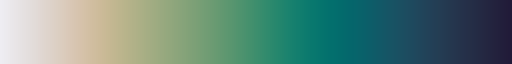

In [13]:
cmocean.cm.rain

In [ ]:
import os
import pandas as pd
import json

# Define the variables and their corresponding colormaps and descriptions
variables = {
    'zos': ('balance', 'Sea Surface Height above Geoid (m)'),
    'thetao': ('thermal', 'Sea Water Potential Temperature (Celsius)'),
    'ph': ('solar', 'pH'),
    'no3': ('algae', 'Mole Concentration of Nitrate in Seawater (mol m-3)'),
    'po4': ('algae', 'Mole Concentration of Phosphate in Seawater (mol m-3)'),
    'phyc': ('algae', 'Mole Concentration of Phytoplankton as Carbon in Seawater (mol m-3)')
}

# Base folder paths
base_folder = os.getcwd()

# Iterate through each variable
for var, (cmap_name, description) in variables.items():
    # Create folders for each variable
    geojson_folder = os.path.join(base_folder, f'{var}_geojson')
    colorbar_folder = os.path.join(base_folder, f'{var}_colorbar')
    
    if not os.path.exists(geojson_folder):
        os.makedirs(geojson_folder)
    if not os.path.exists(colorbar_folder):
        os.makedirs(colorbar_folder)
    
    # Iterate through experiments
    for source in list(experiment_dict.keys()):
        for experiment in experiment_dict[source]:
            print(source, experiment)
            
            # Find the corresponding file for the current variable and experiment
            file = [x for x in sources[source] if x[0] == var and x[1] == experiment][0][2]
            print(file)
            
            # Create experiment-specific folders
            experiment_folder = os.path.join(geojson_folder, file[7:-5])
            if not os.path.exists(experiment_folder):
                os.makedirs(experiment_folder)
            
            colorbar_ex_folder = os.path.join(colorbar_folder, file[7:-5])
            if not os.path.exists(colorbar_ex_folder):
                os.makedirs(colorbar_ex_folder)
            
            # Load the data
            df = pd.read_pickle(os.path.join(base_folder, 'latlon', file))
            df = df.dropna()
            df = df.reset_index()
            
            # Process the data (e.g., convert units if needed)
            # Example: df[var] = df[var] - 273.15  # Uncomment if needed
            
            df = palau_eez(df)
            
            # Generate year range for naming
            year_range = f"{min(df['year'].tolist())}-{max(df['year'].tolist())}"
            colorbar_name = f"{year_range}_{var}_colorbar_{file[7:-5]}.png"
            
            # Generate colorbar
            print(f"Created: {colorbar_name}")
            
            # Process each year
            for year in sorted(set(df['year'].tolist())):
                currgeo = getGridGeoJSON(year, df, var=var, colorbar_directory=os.path.join(colorbar_ex_folder, colorbar_name), experiment=experiment)
                json_object = json.dumps(currgeo, indent=4)
                
                # Save the GeoJSON file
                geojson_dir = os.path.join(experiment_folder, f"{year}_{file[7:-5]}.json")
                with open(geojson_dir, "w") as outfile:
                    outfile.write(json_object)
                    print(geojson_dir)

KACE-1-0-G ssp585
latlon_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1_.pkl
Created: 2015-2100_pr_colorbar_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.png


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


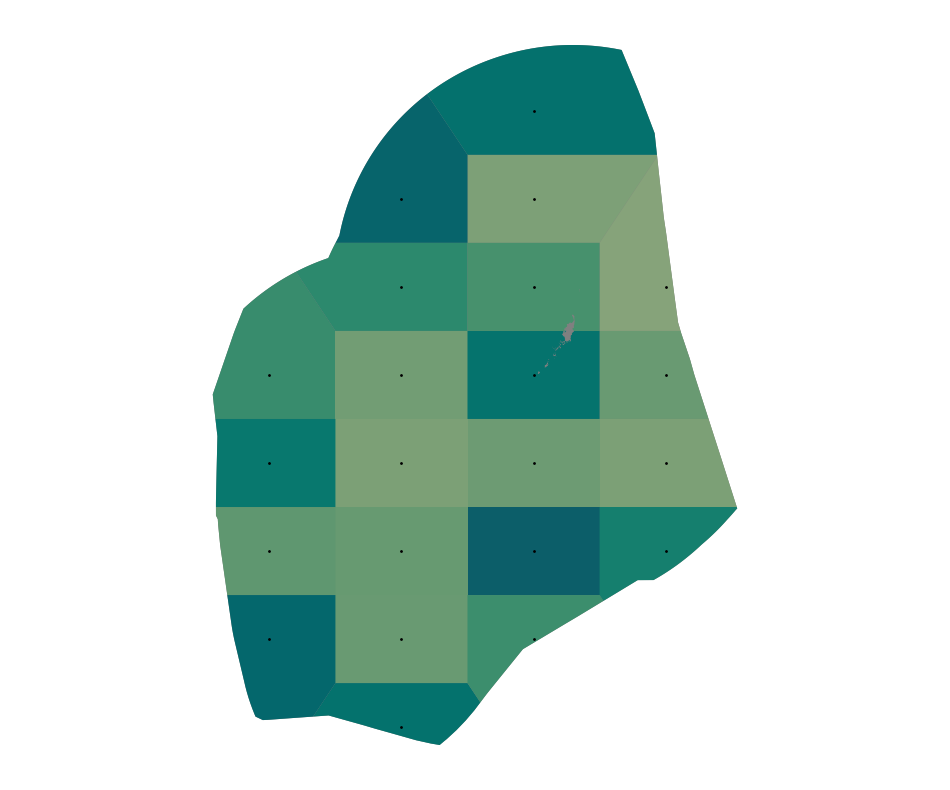

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2015_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


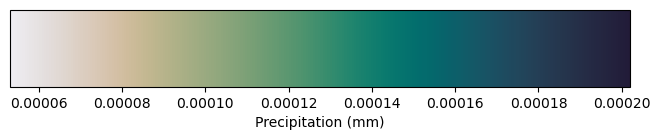

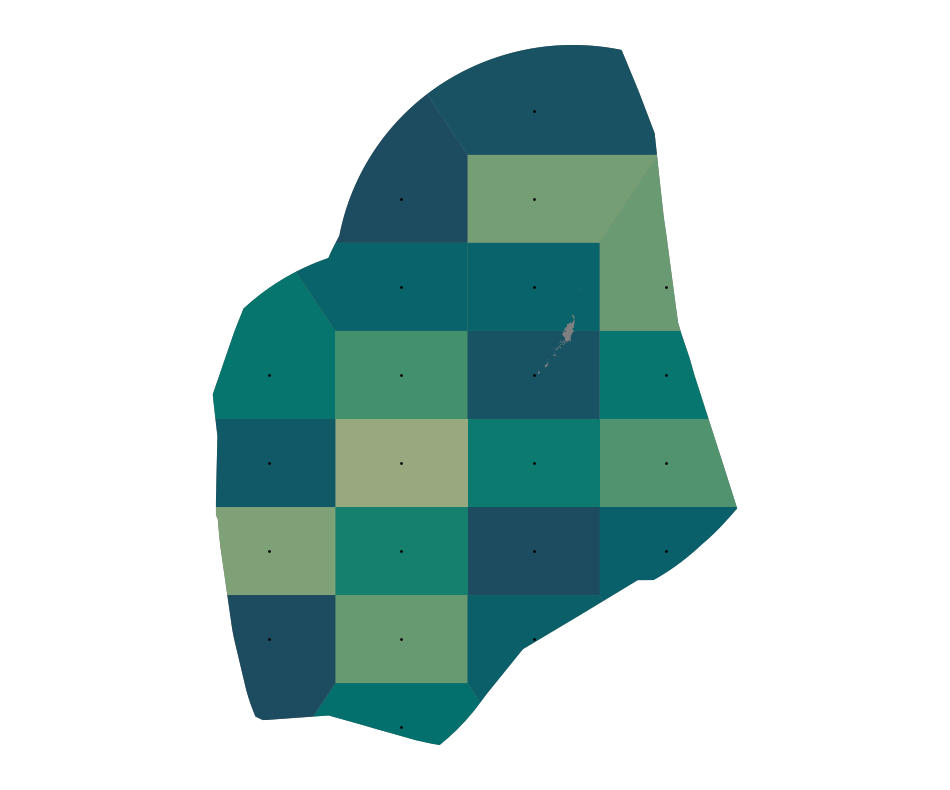

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2016_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


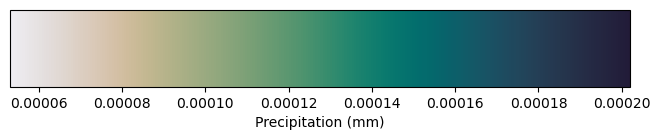

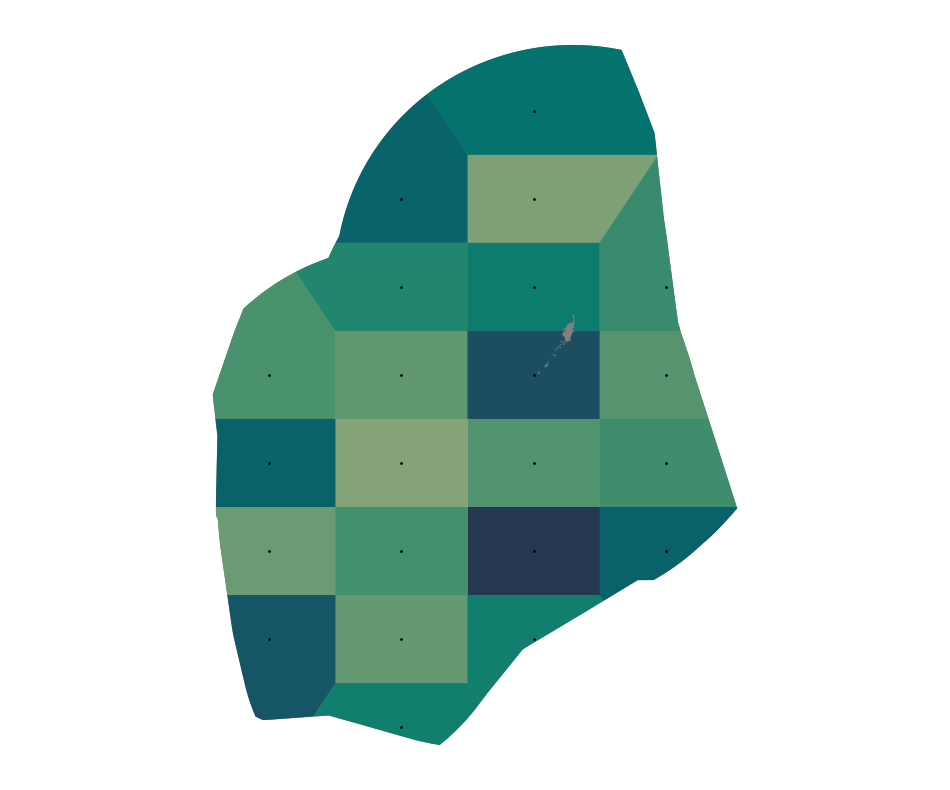

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2017_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


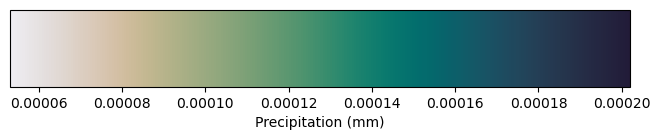

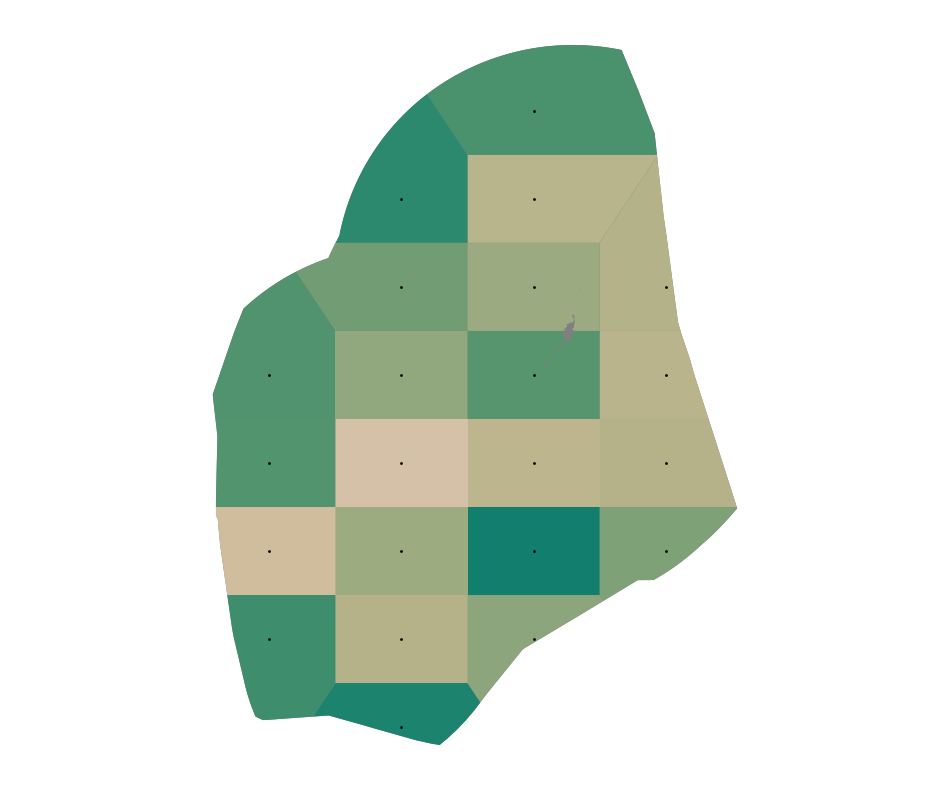

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2018_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


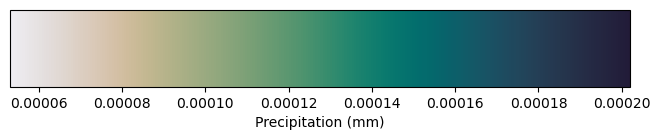

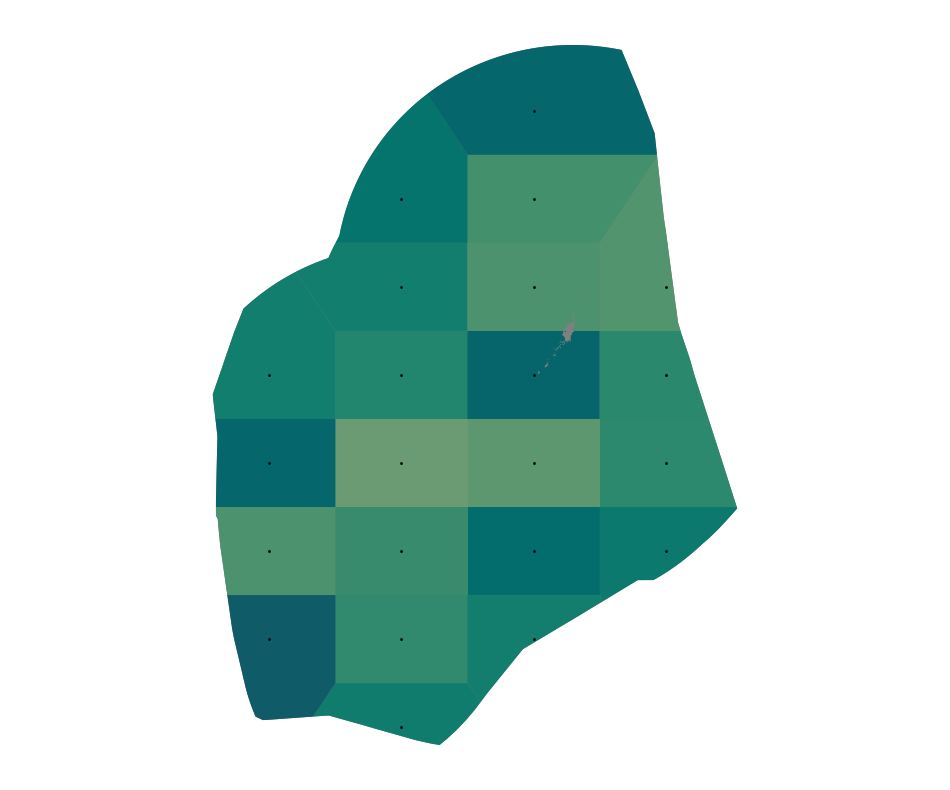

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2019_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


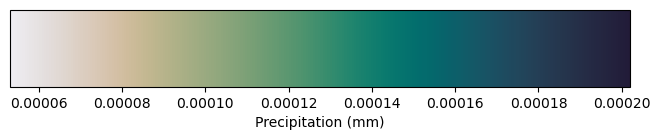

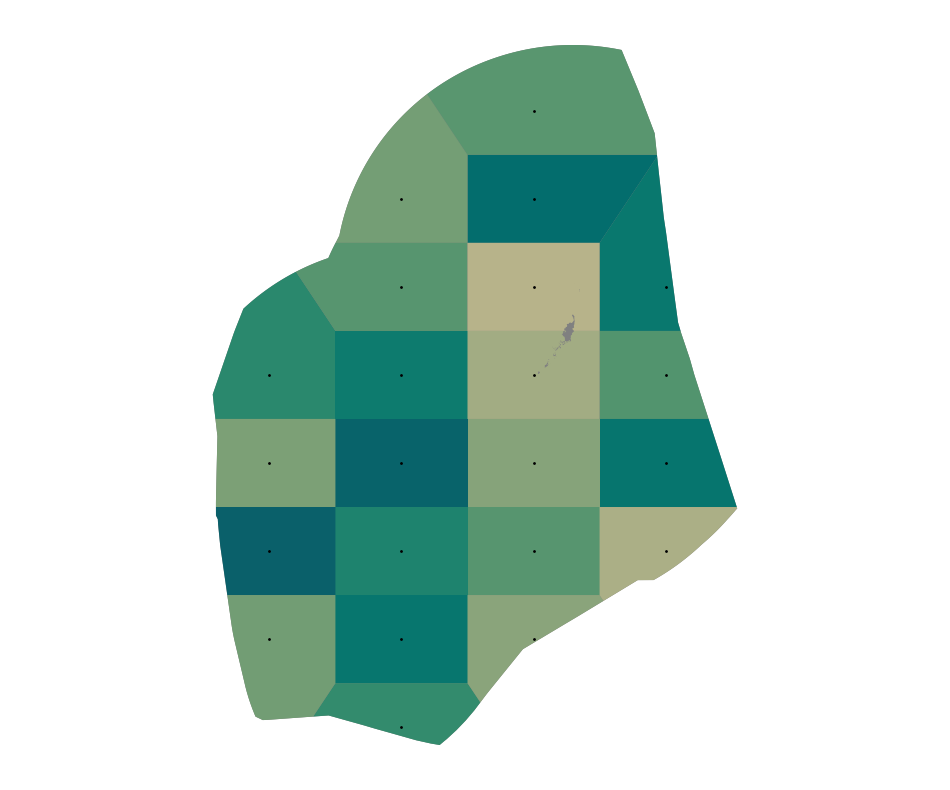

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2020_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


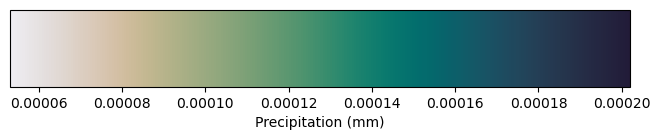

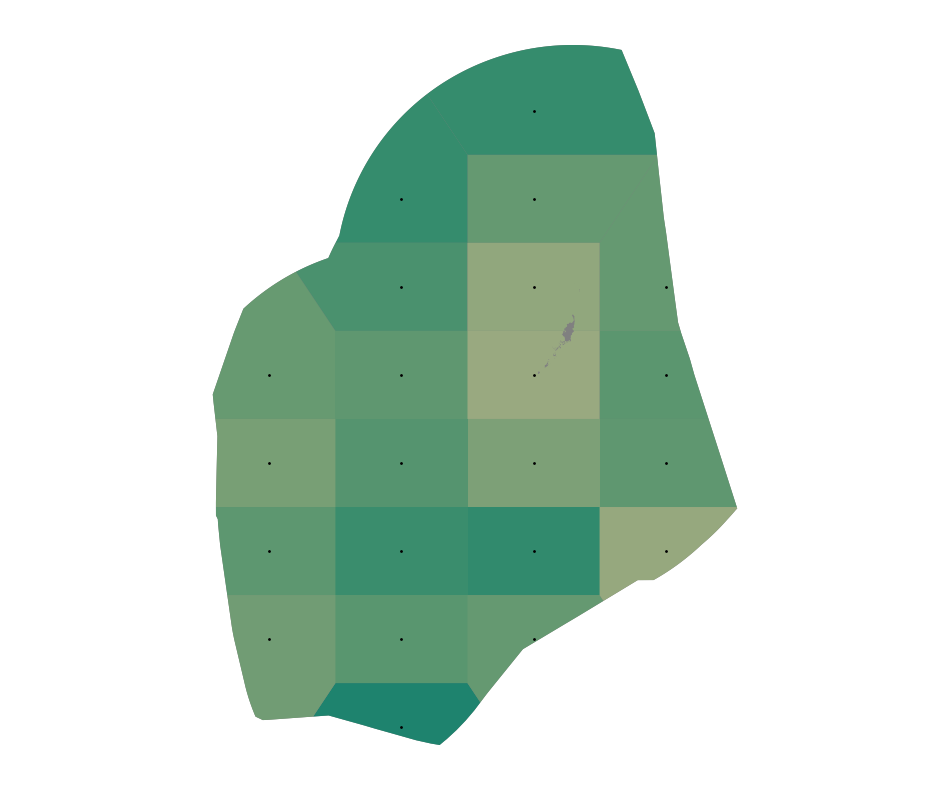

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2021_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


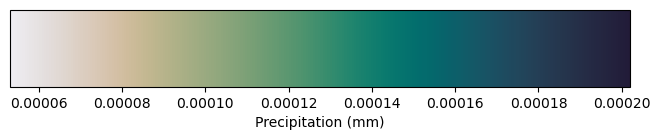

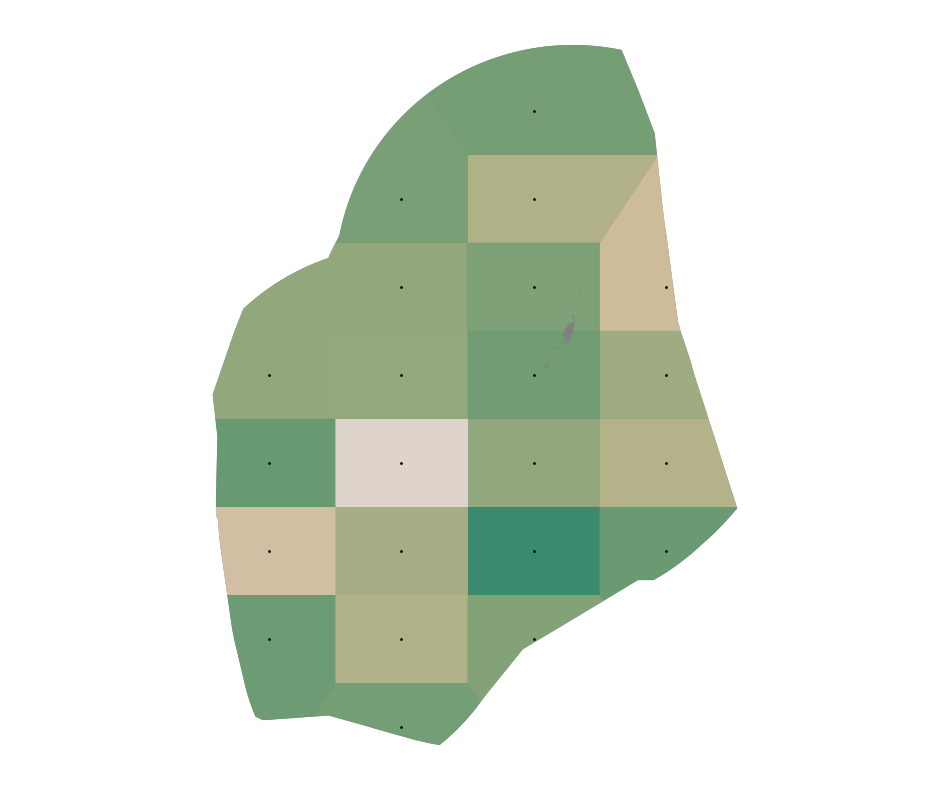

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2022_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


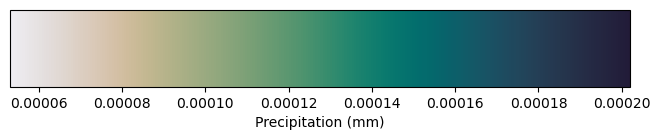

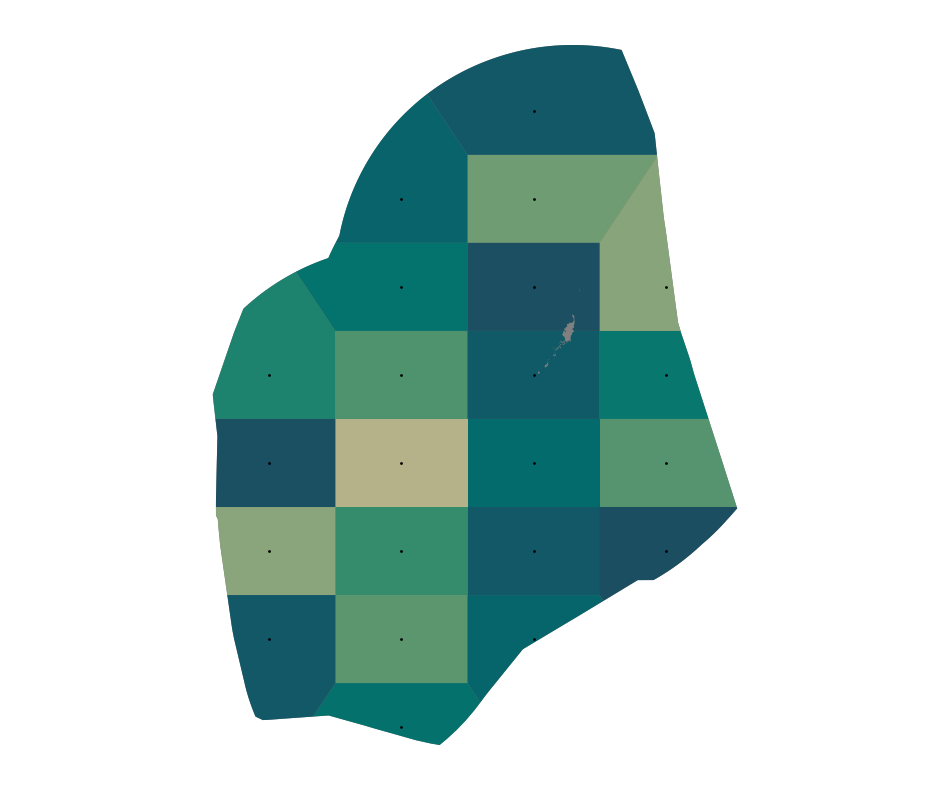

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2023_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


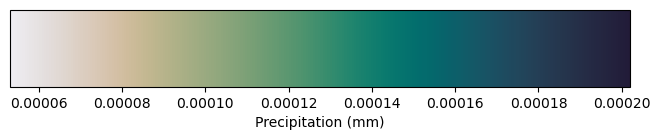

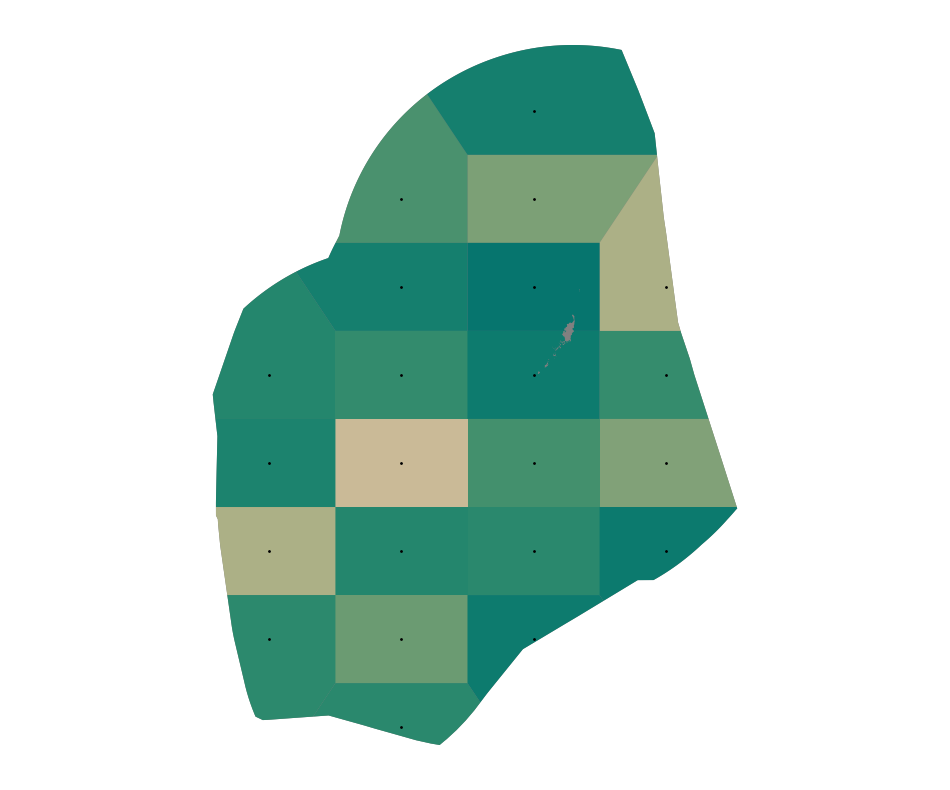

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2024_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


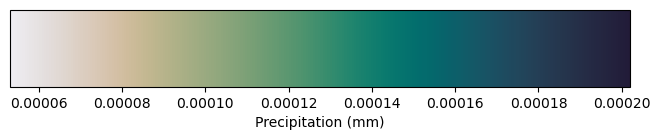

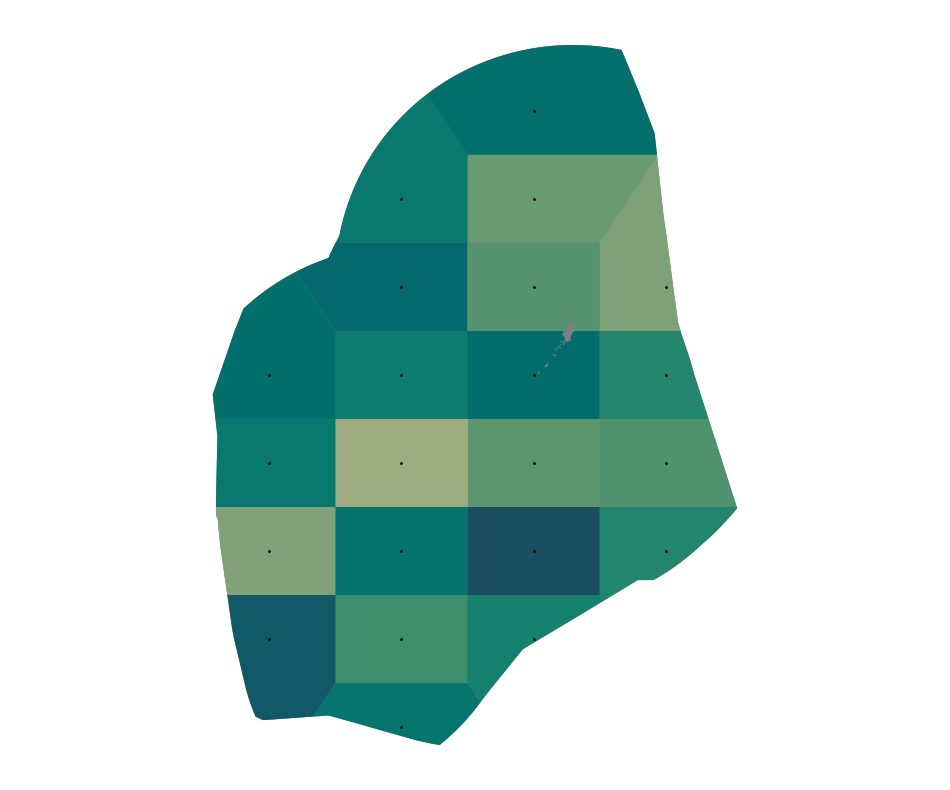

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2025_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


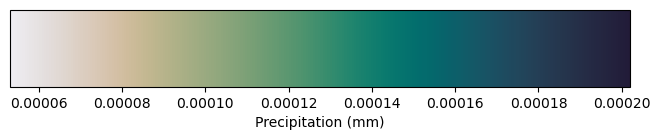

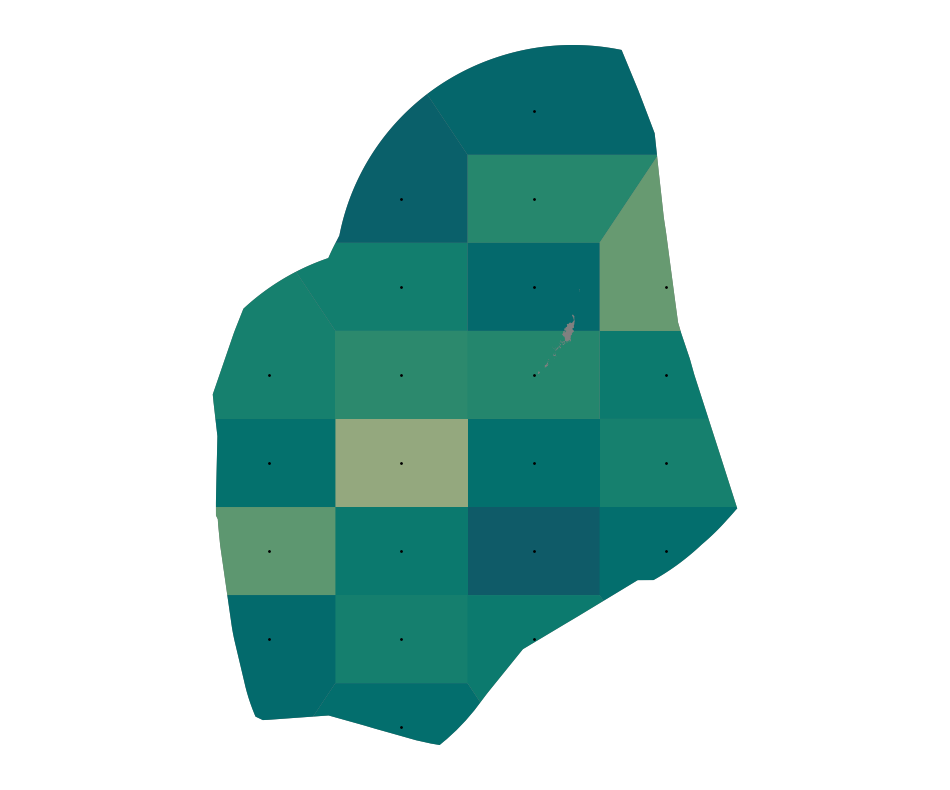

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2026_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


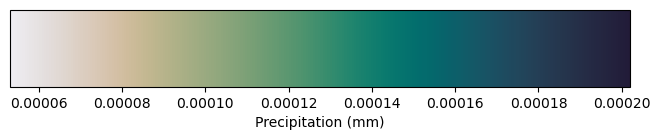

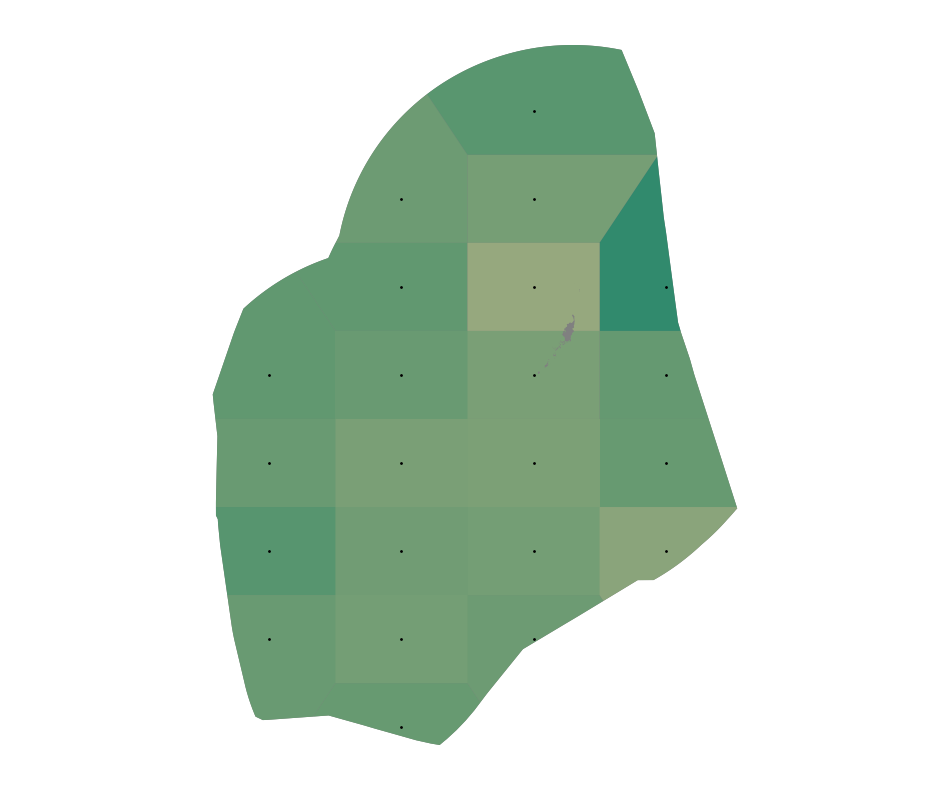

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2027_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


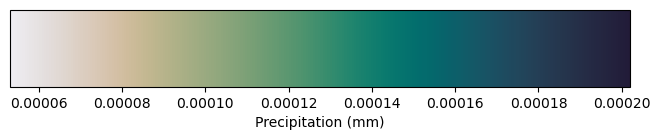

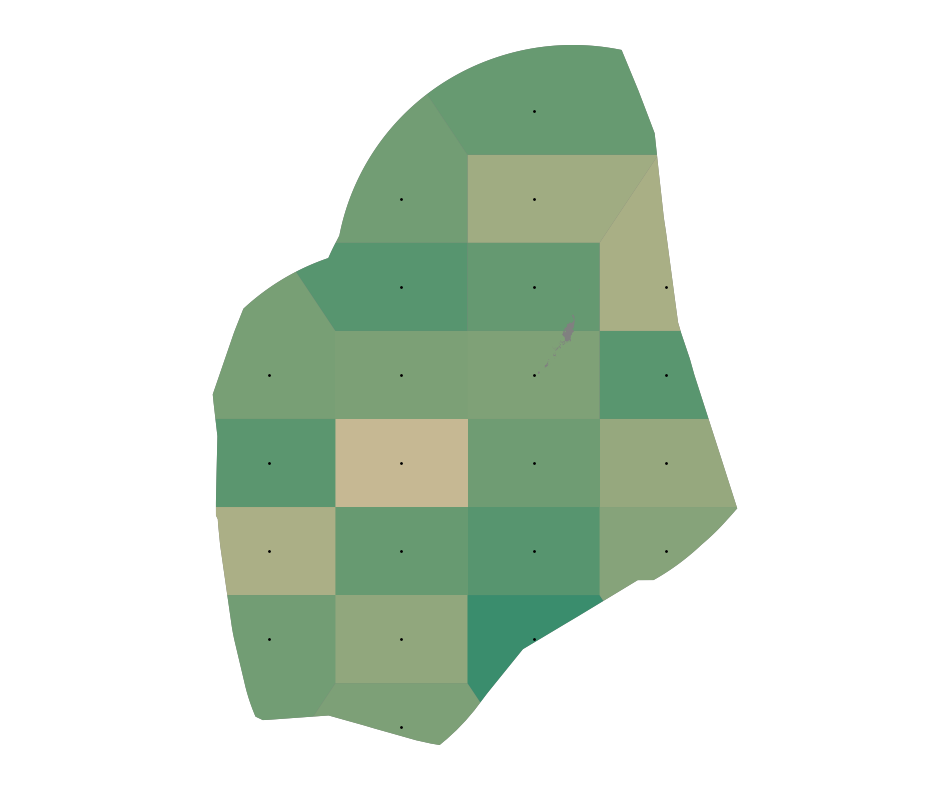

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2028_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


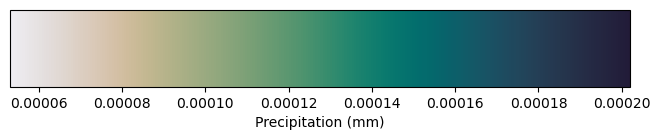

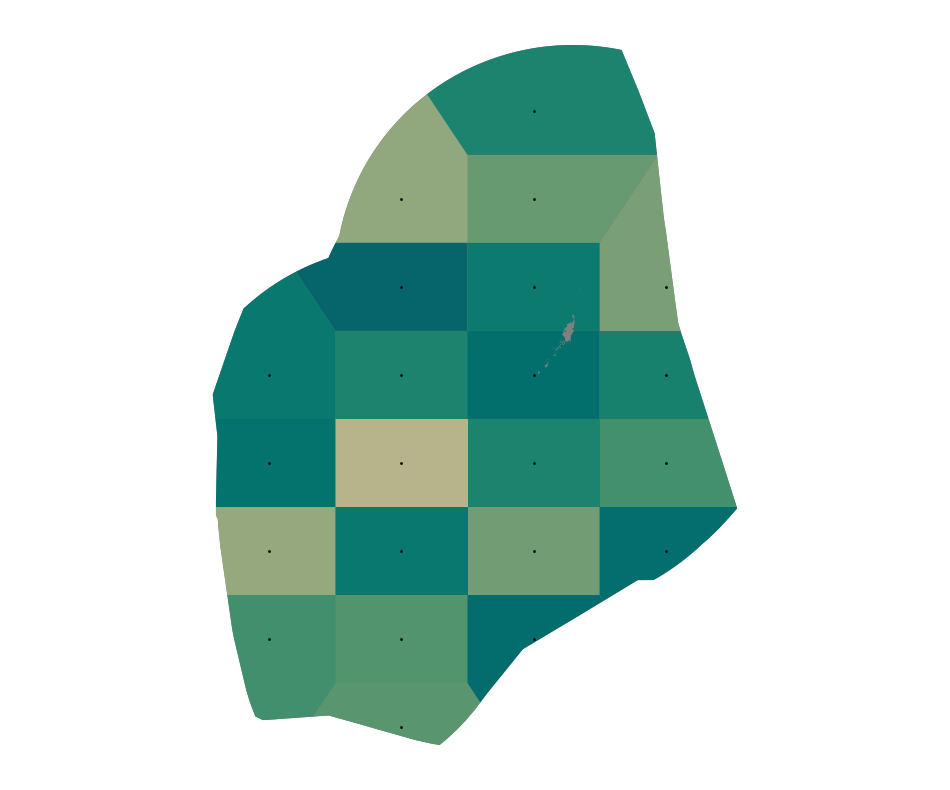

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2029_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


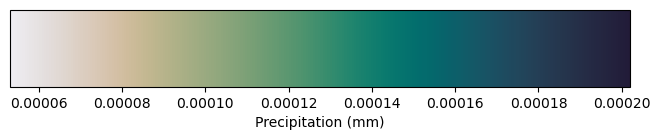

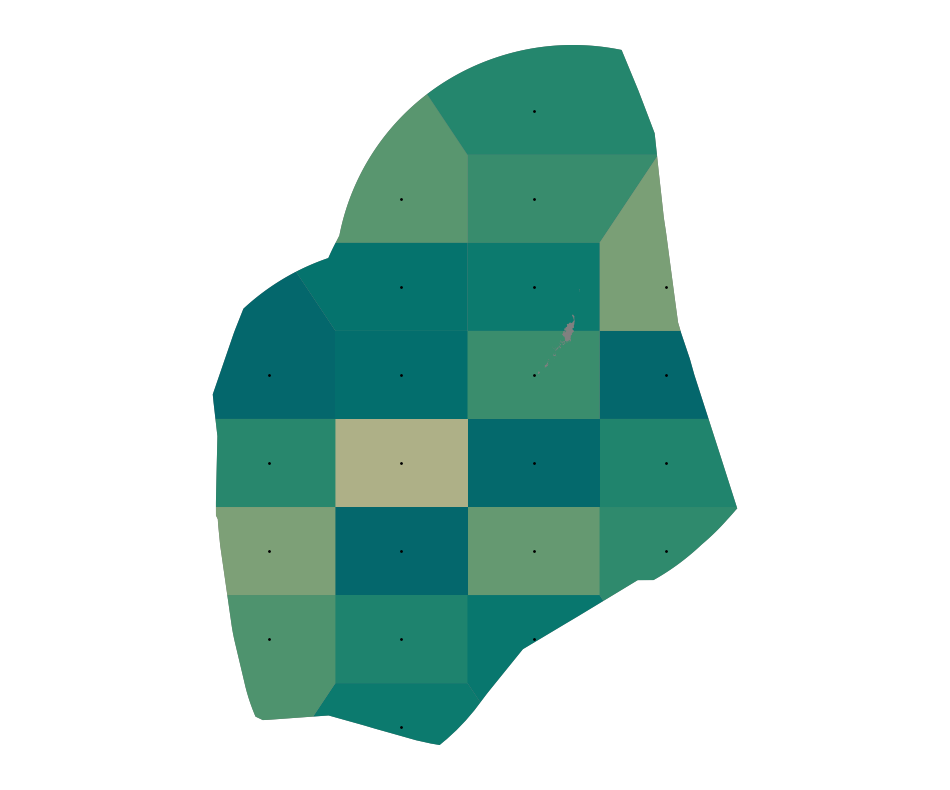

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2030_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


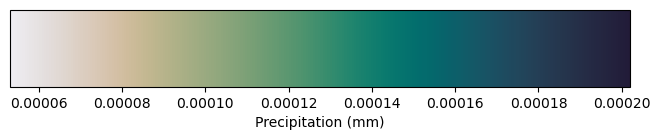

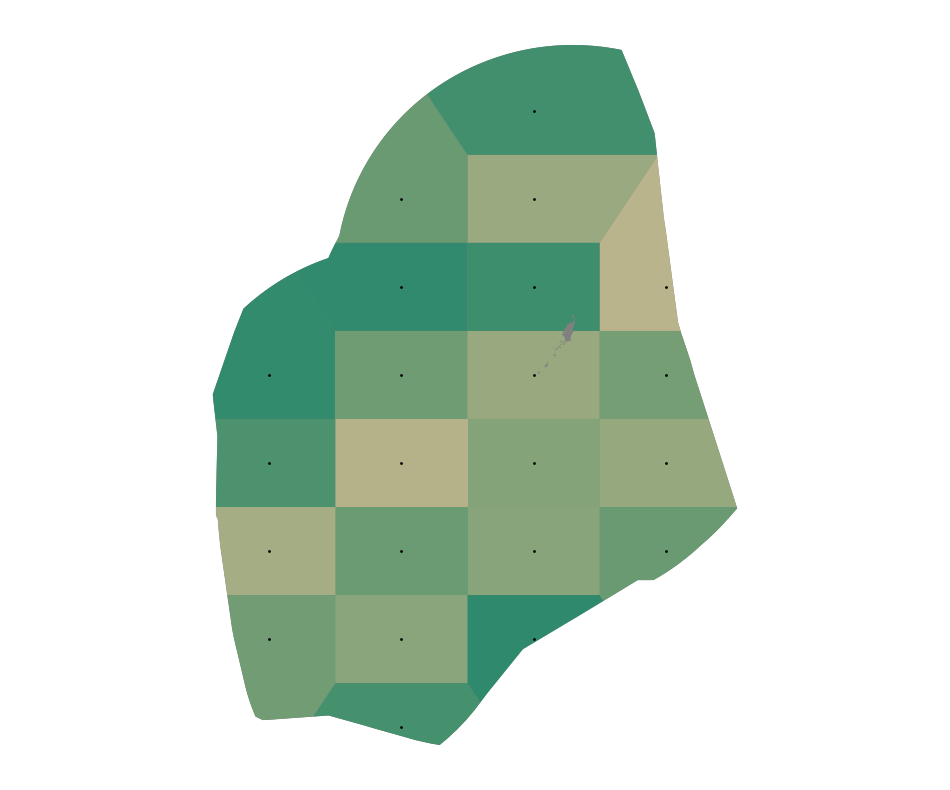

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2031_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


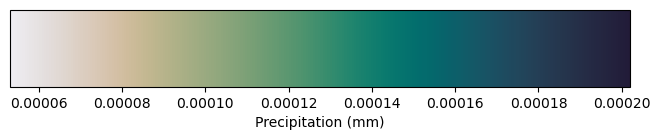

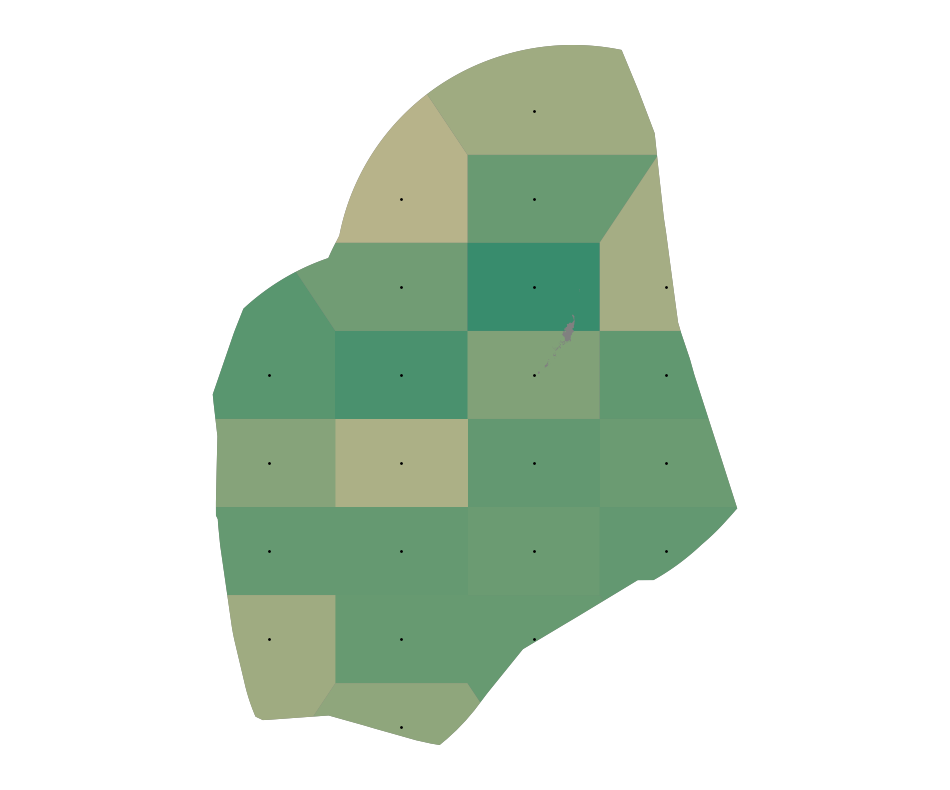

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2032_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


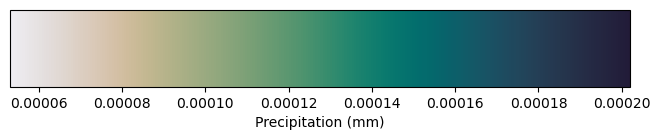

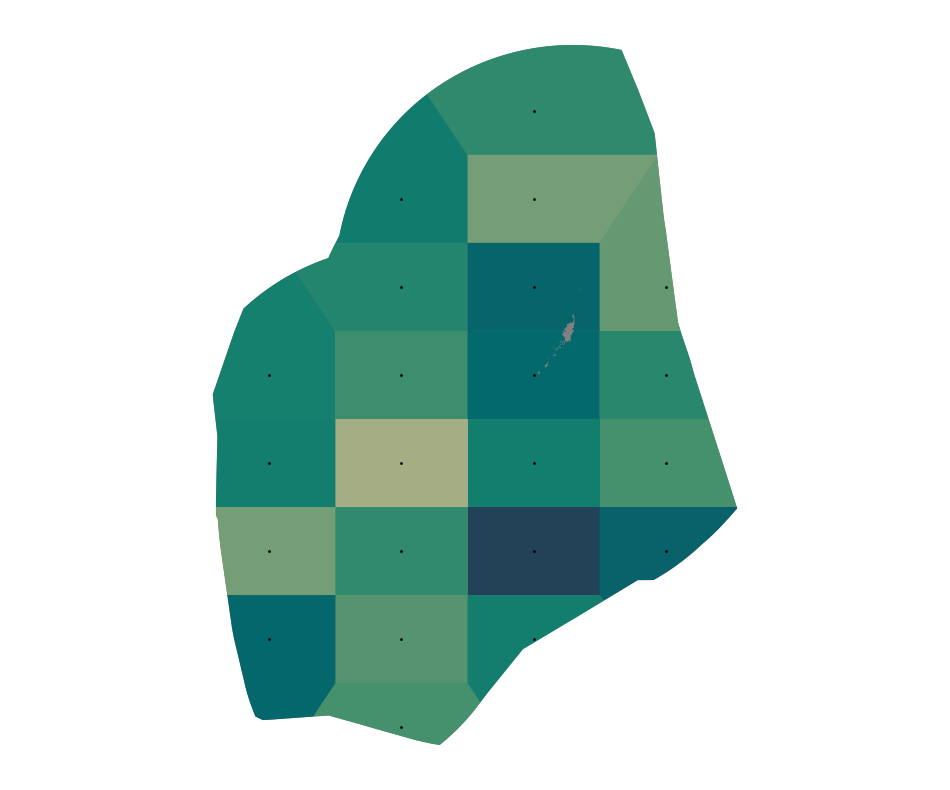

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2033_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


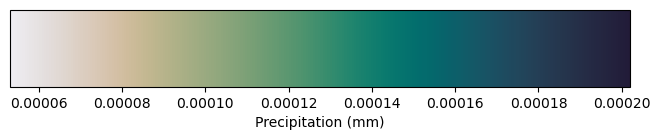

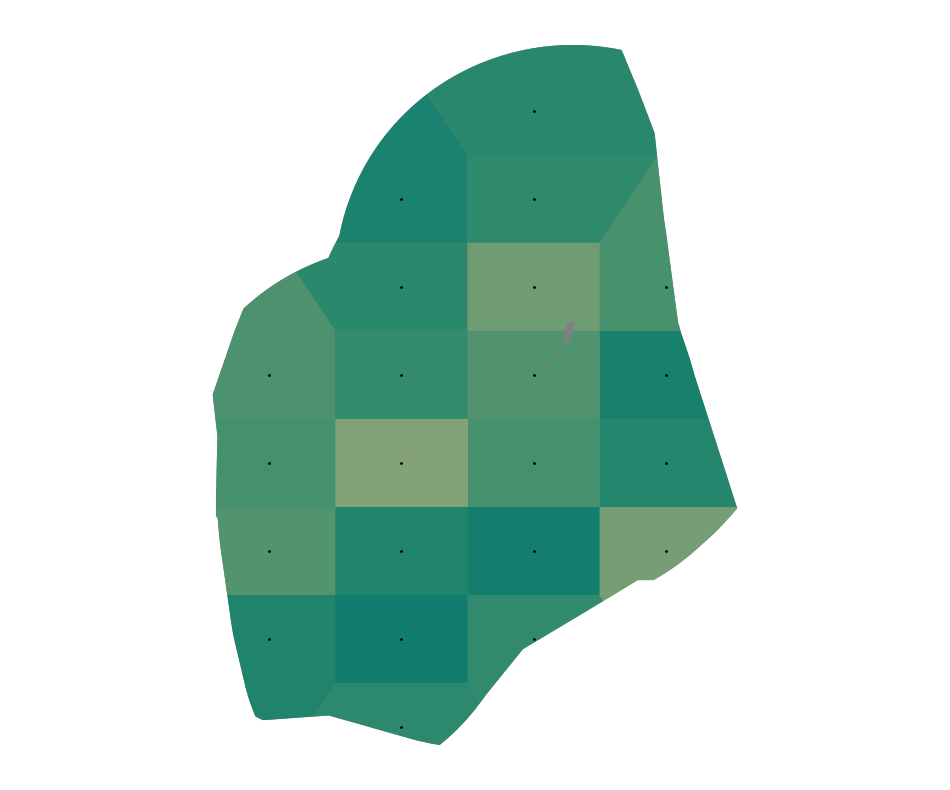

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2034_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


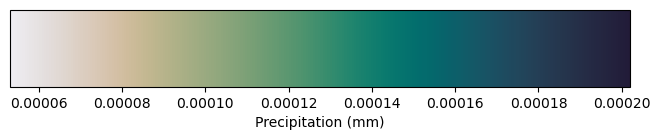

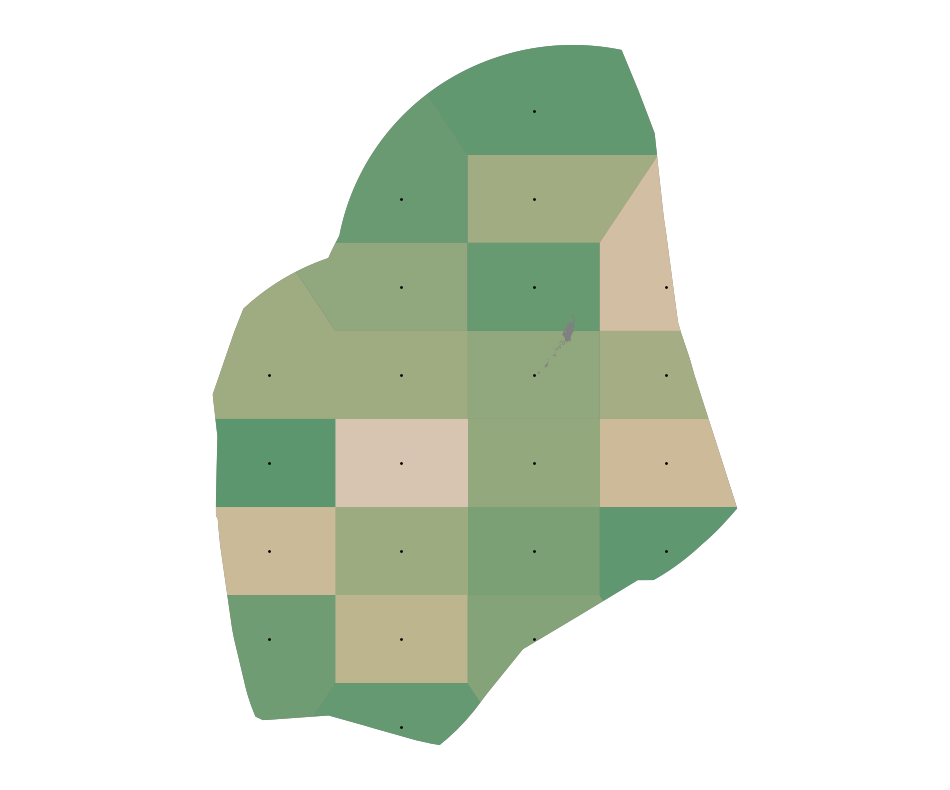

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2035_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


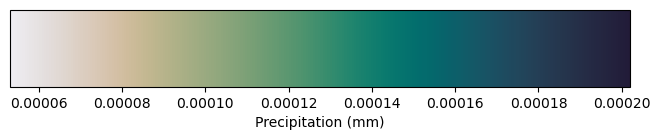

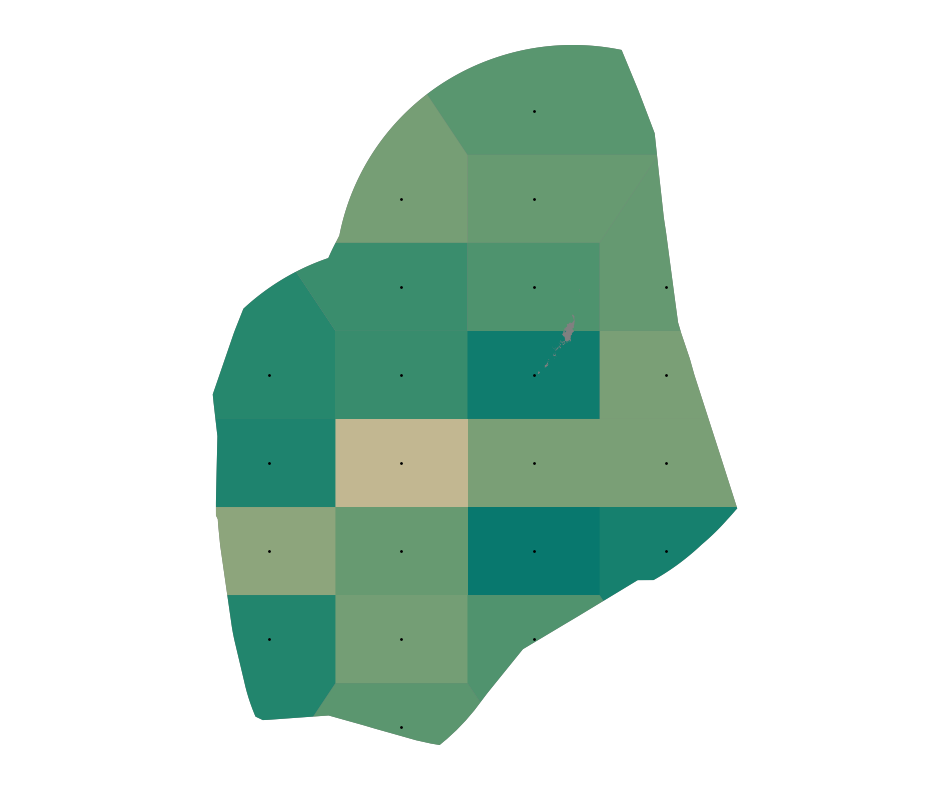

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2036_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


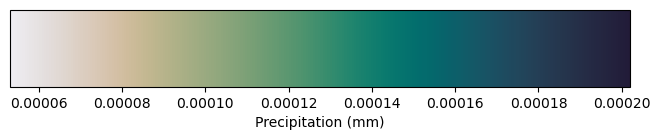

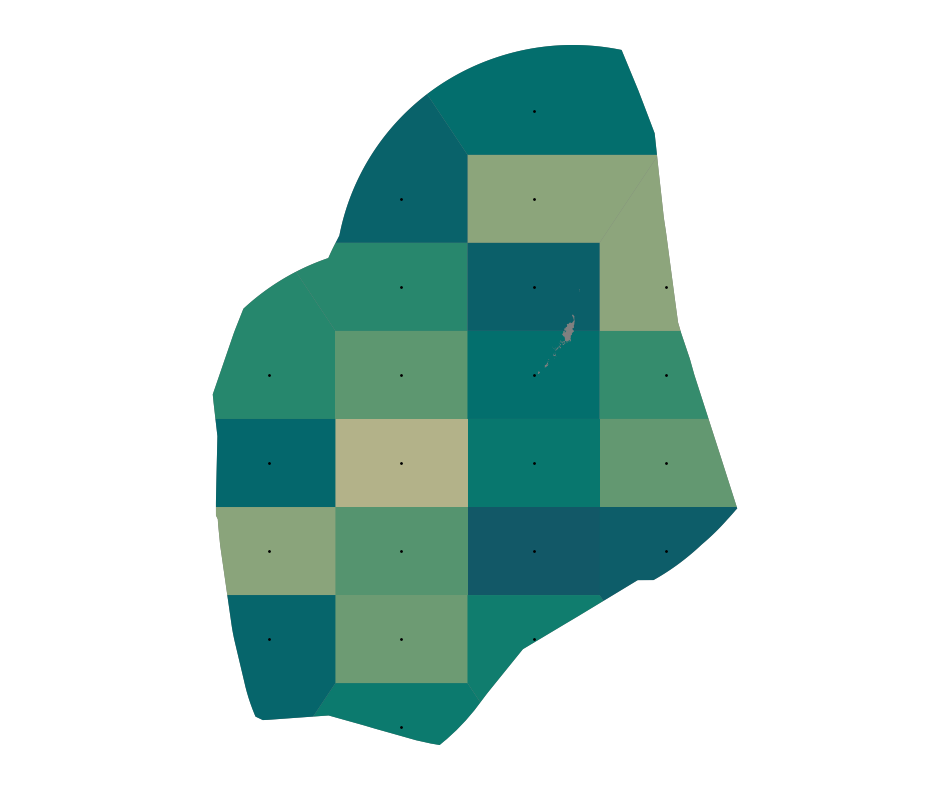

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2037_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


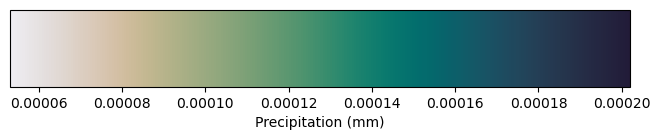

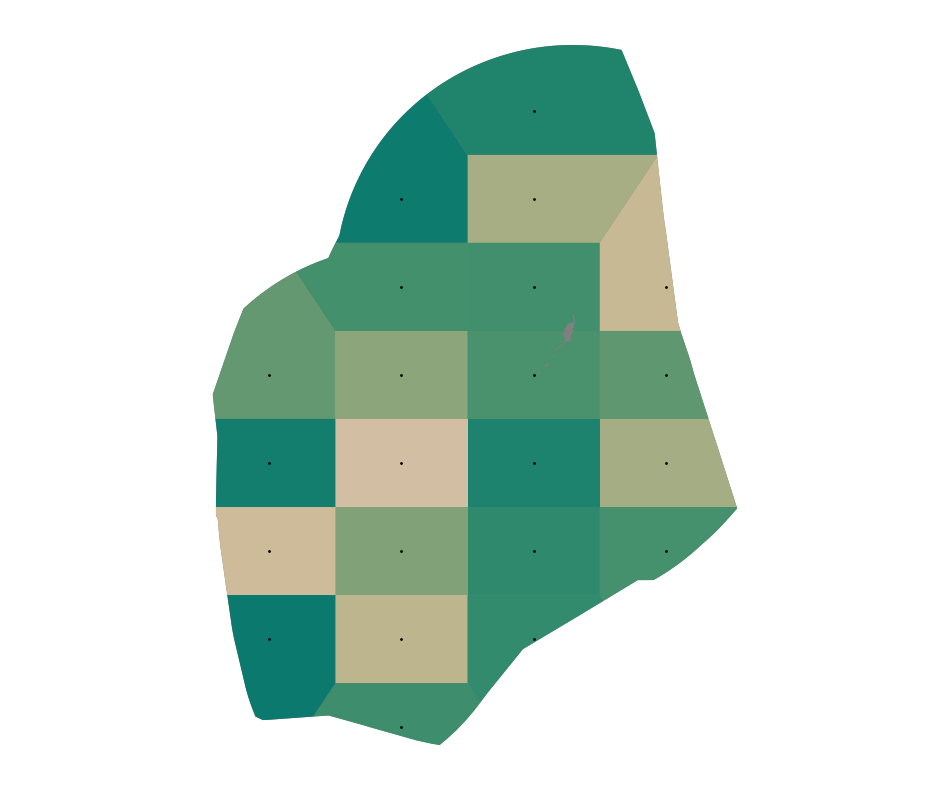

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2038_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


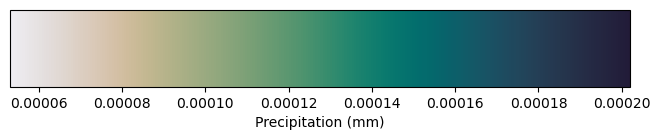

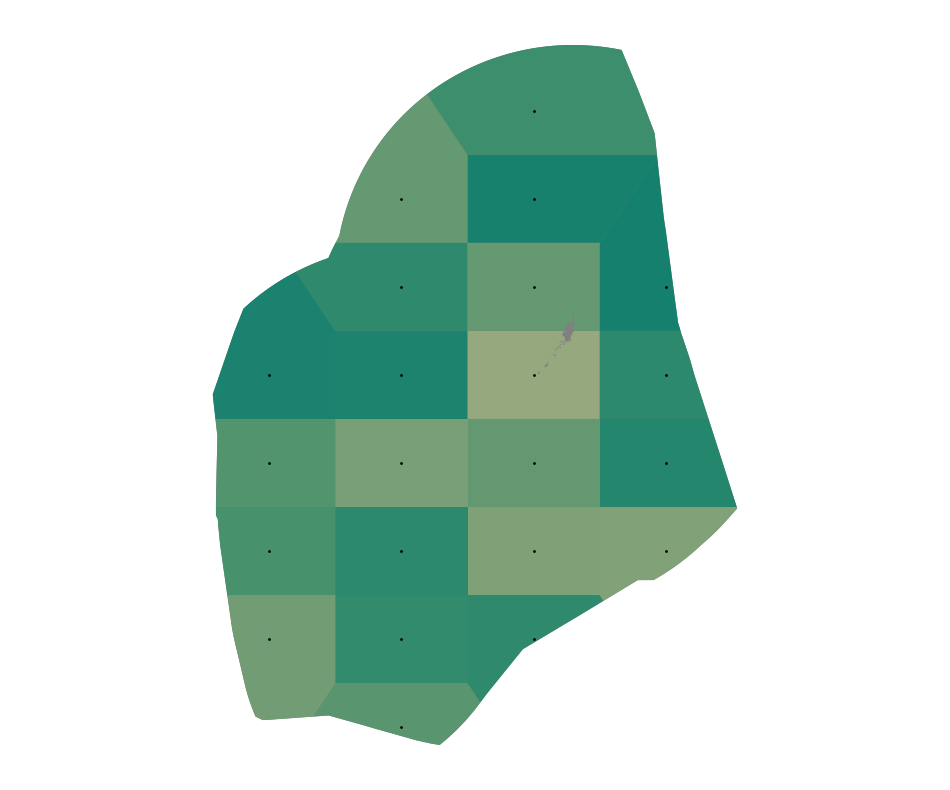

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2039_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


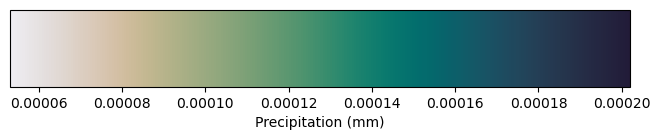

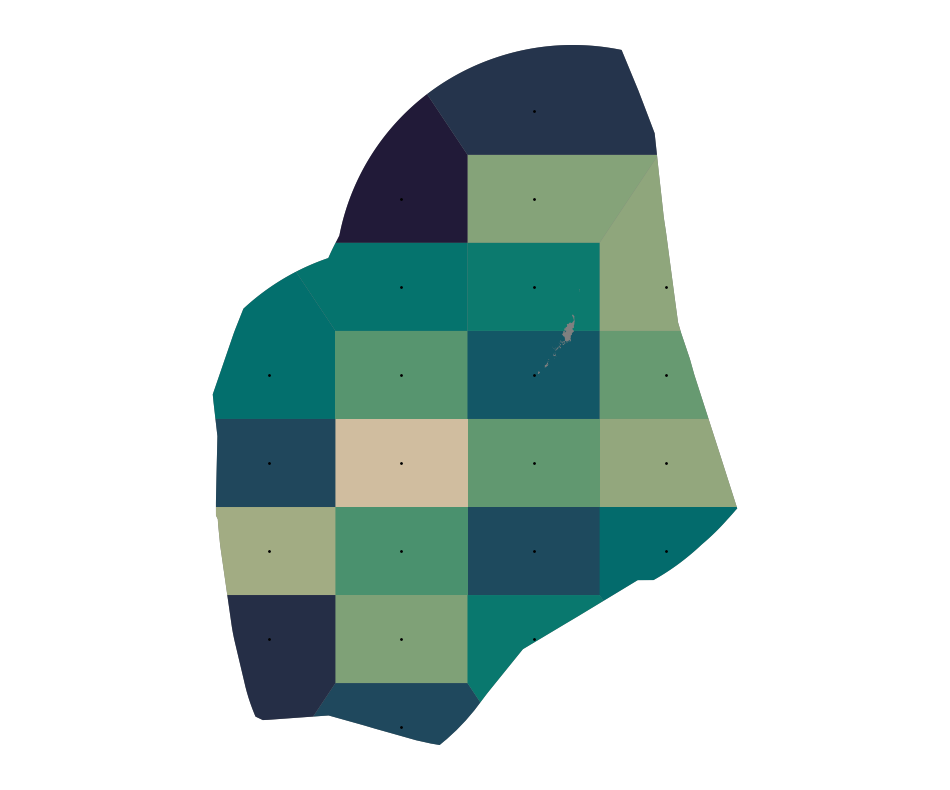

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2040_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


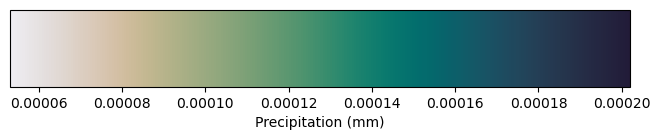

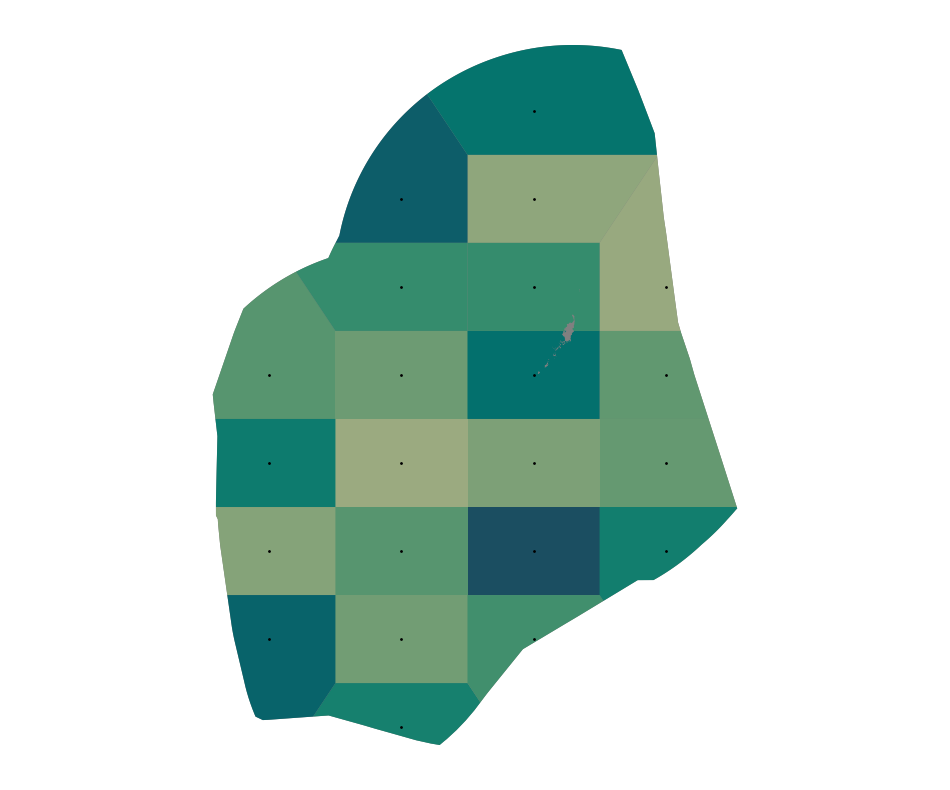

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2041_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


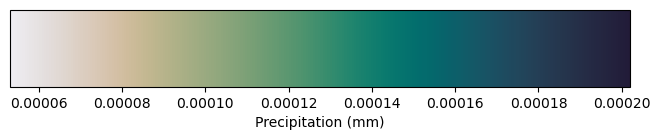

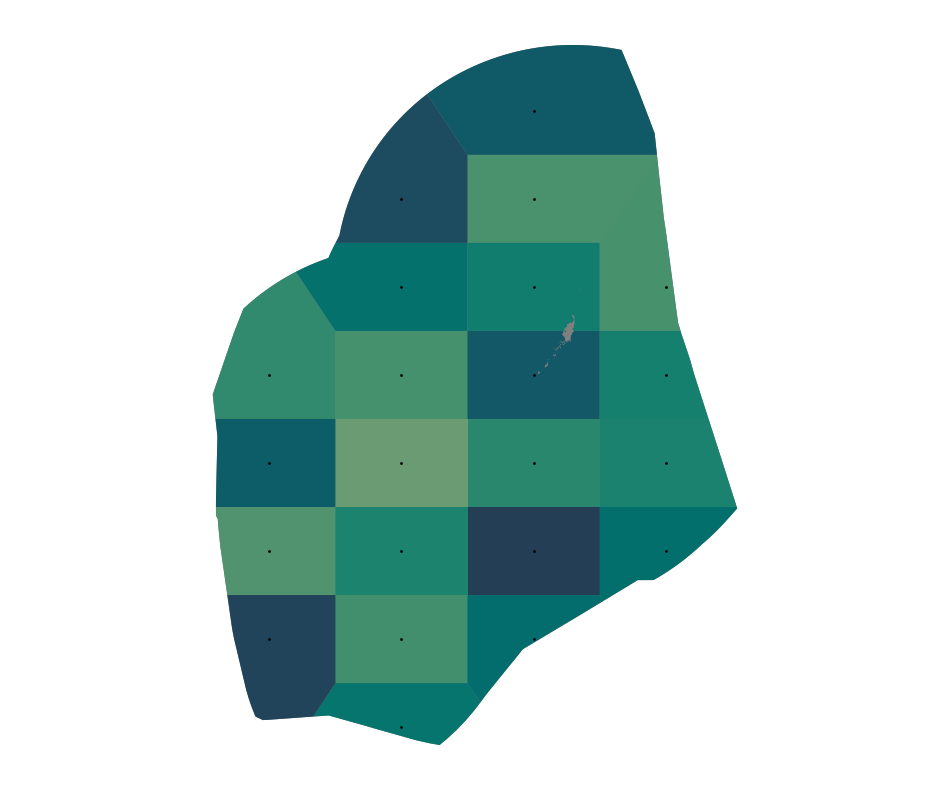

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2042_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


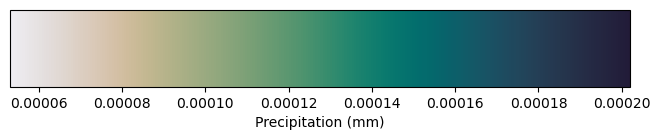

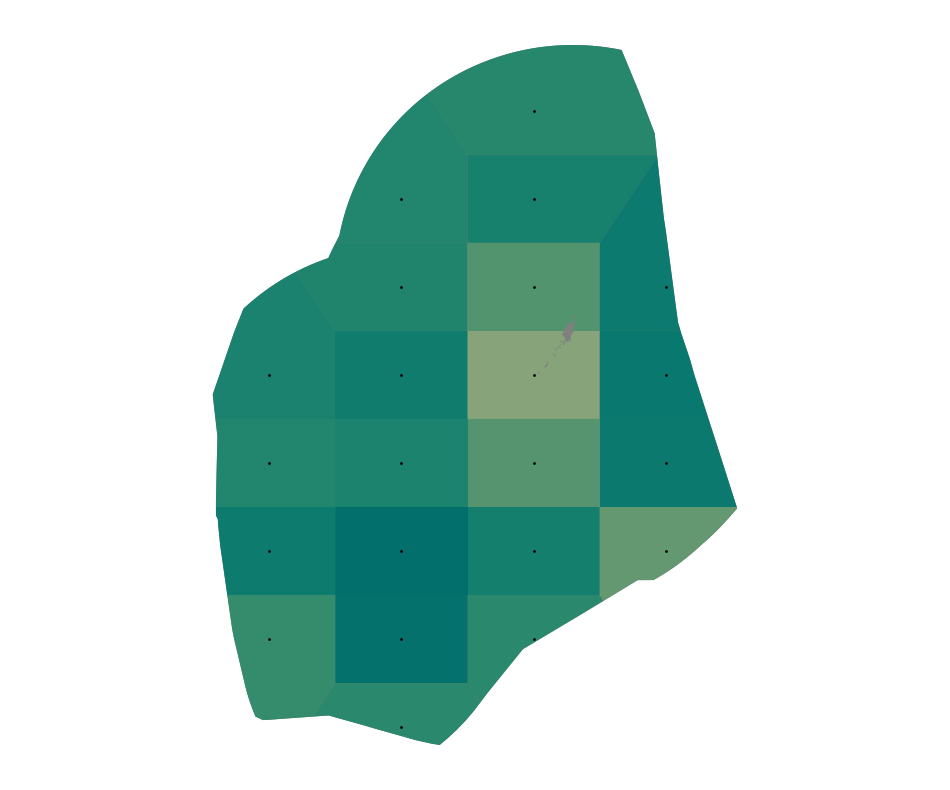

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2043_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


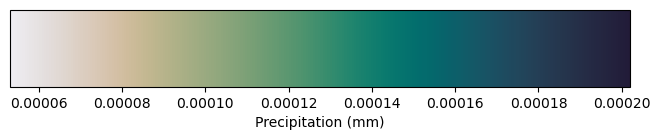

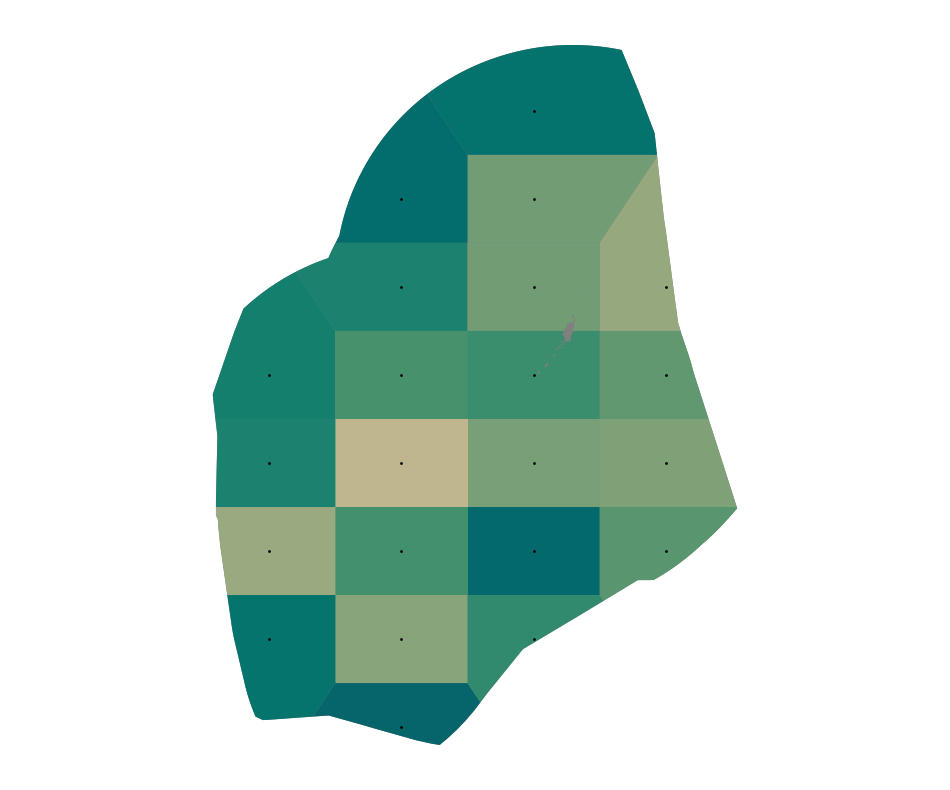

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2044_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


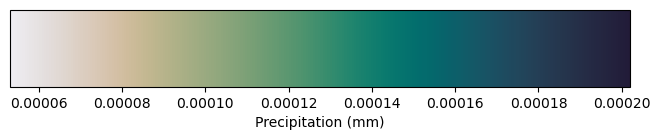

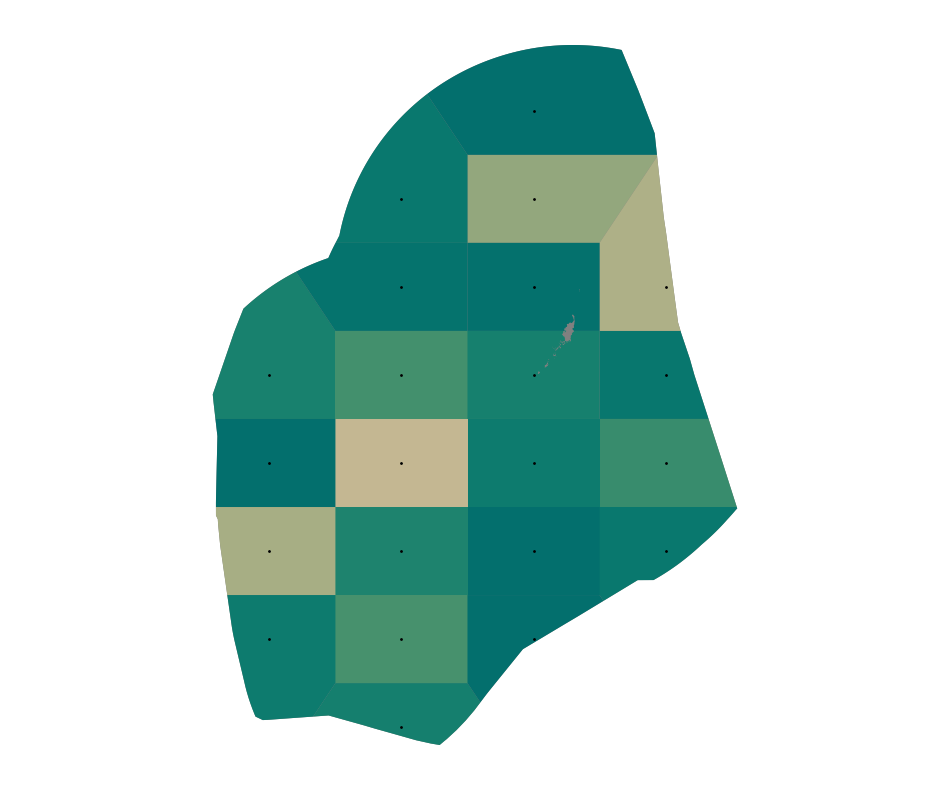

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2045_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


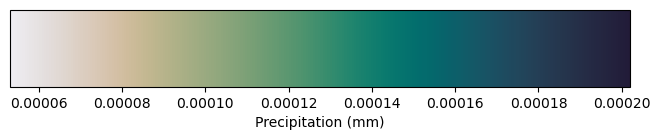

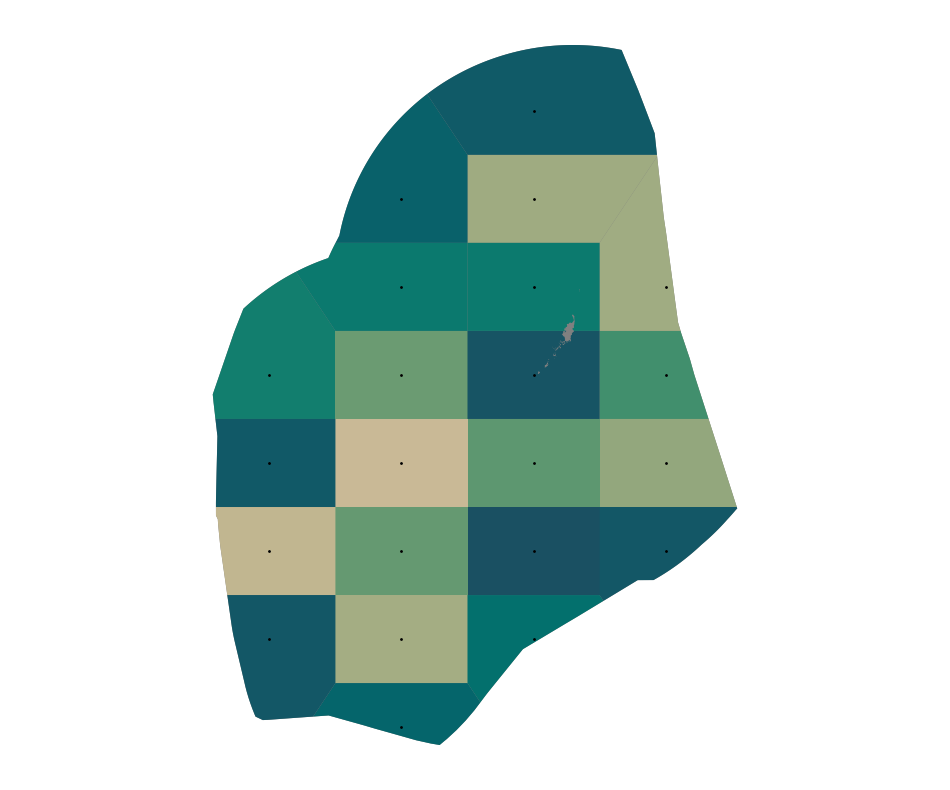

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2046_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


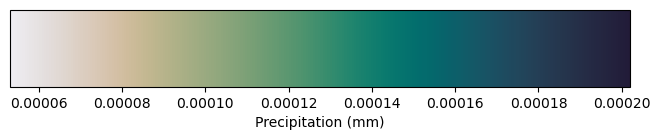

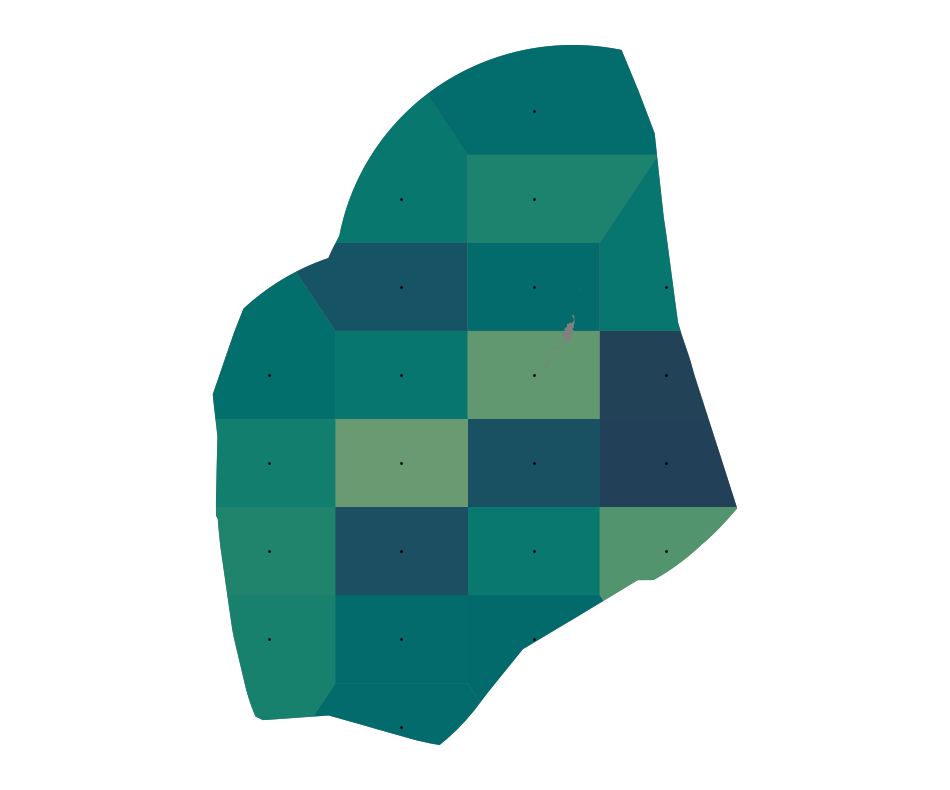

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2047_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


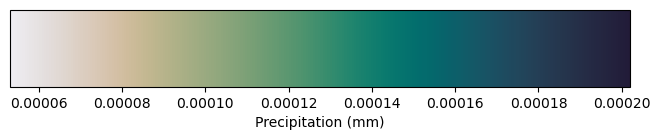

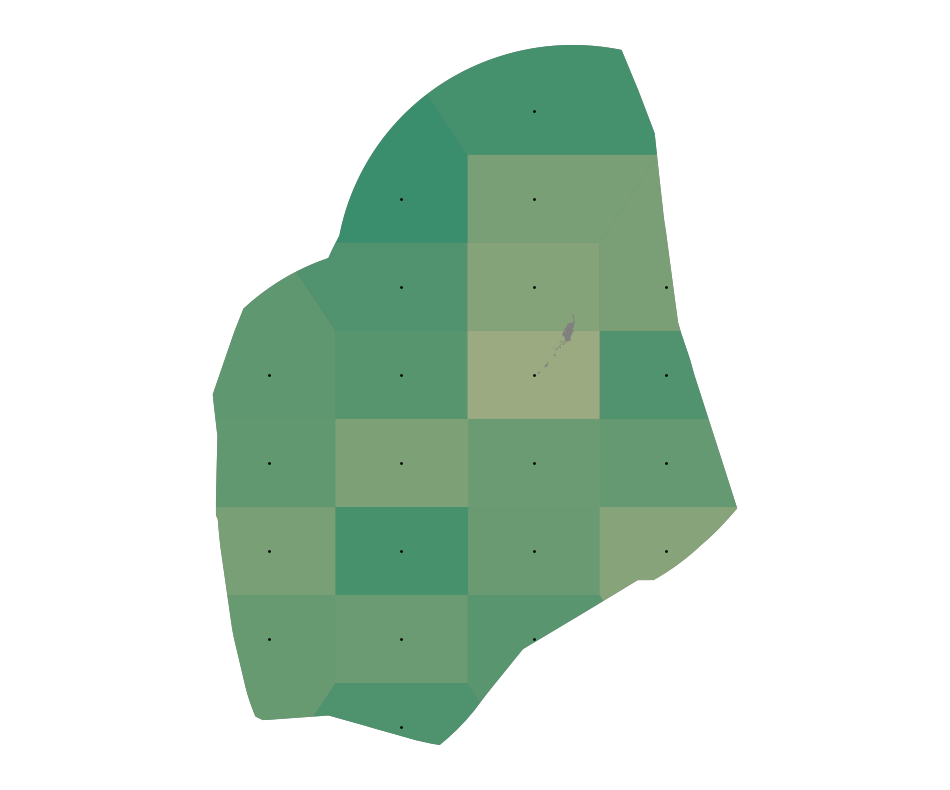

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2048_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


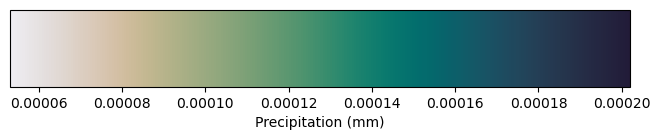

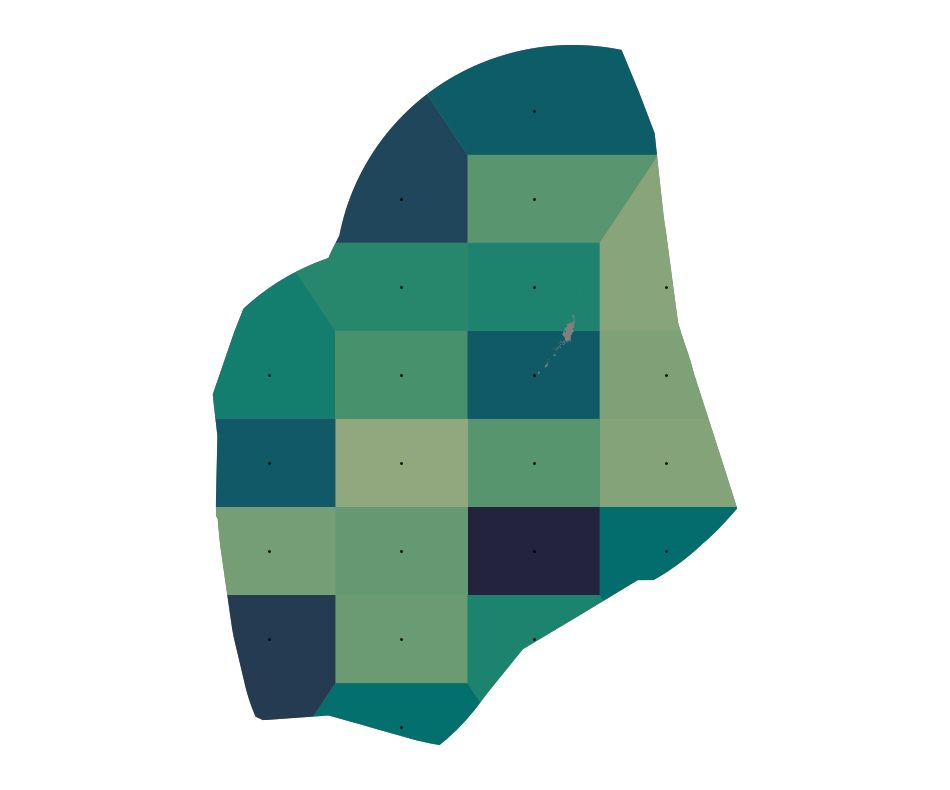

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2049_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


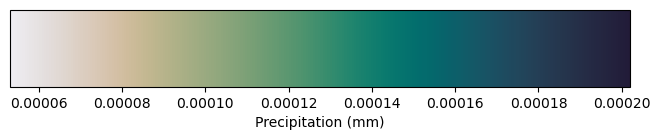

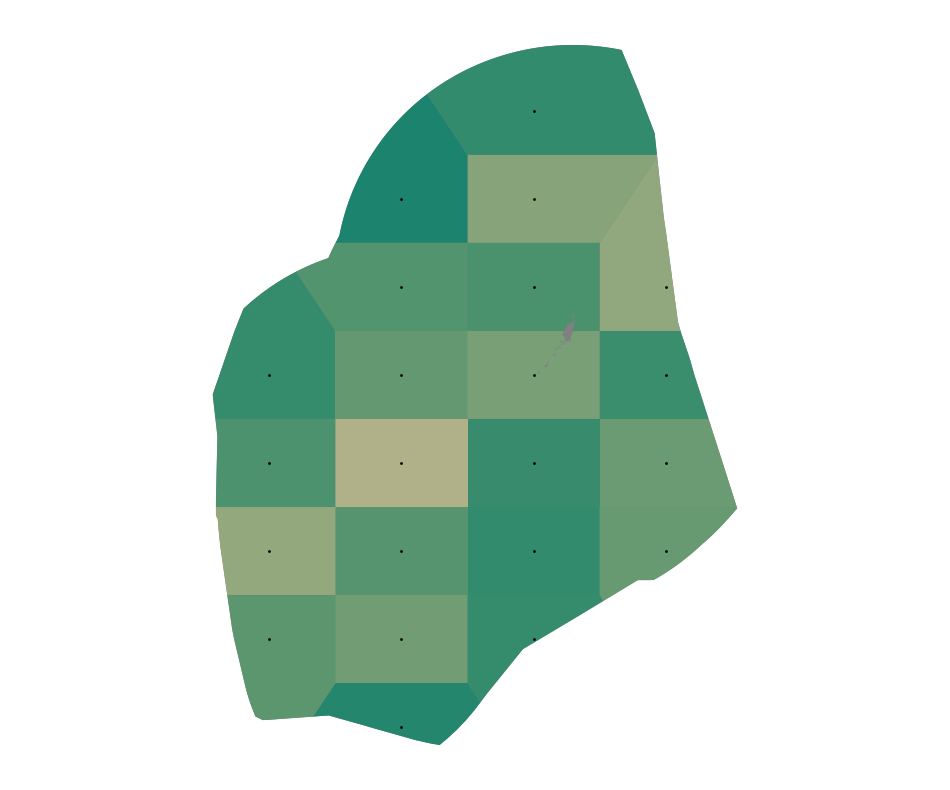

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2050_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


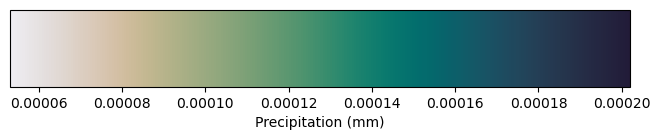

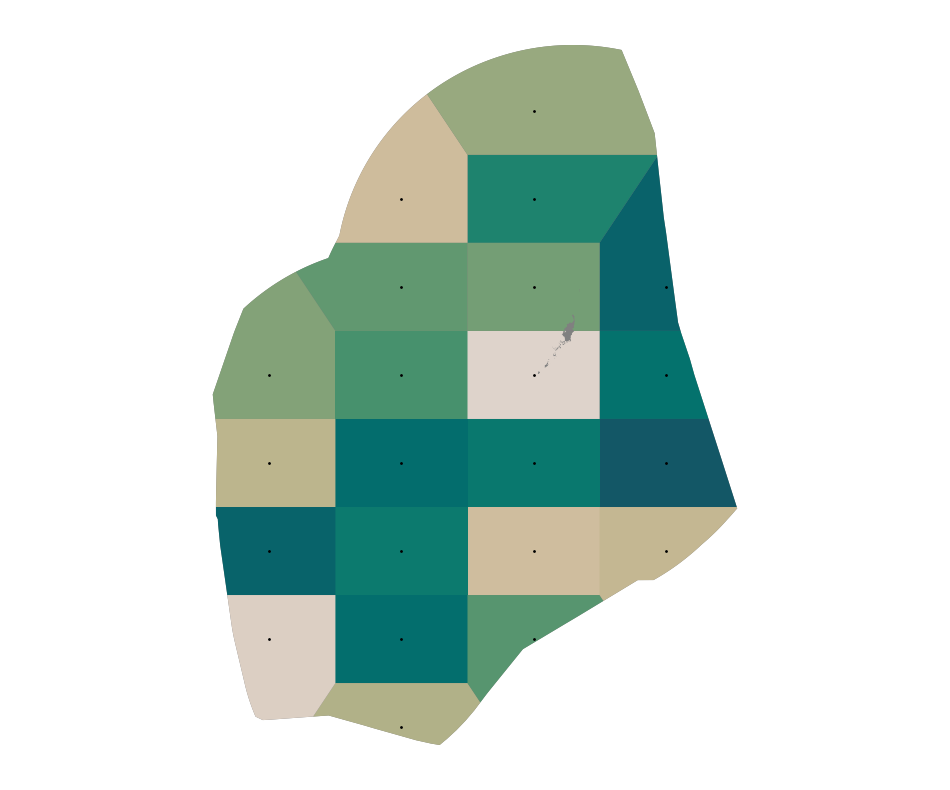

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2051_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


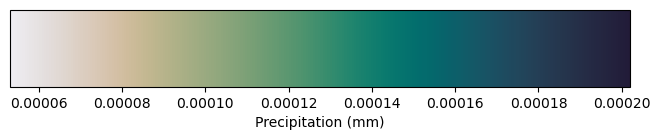

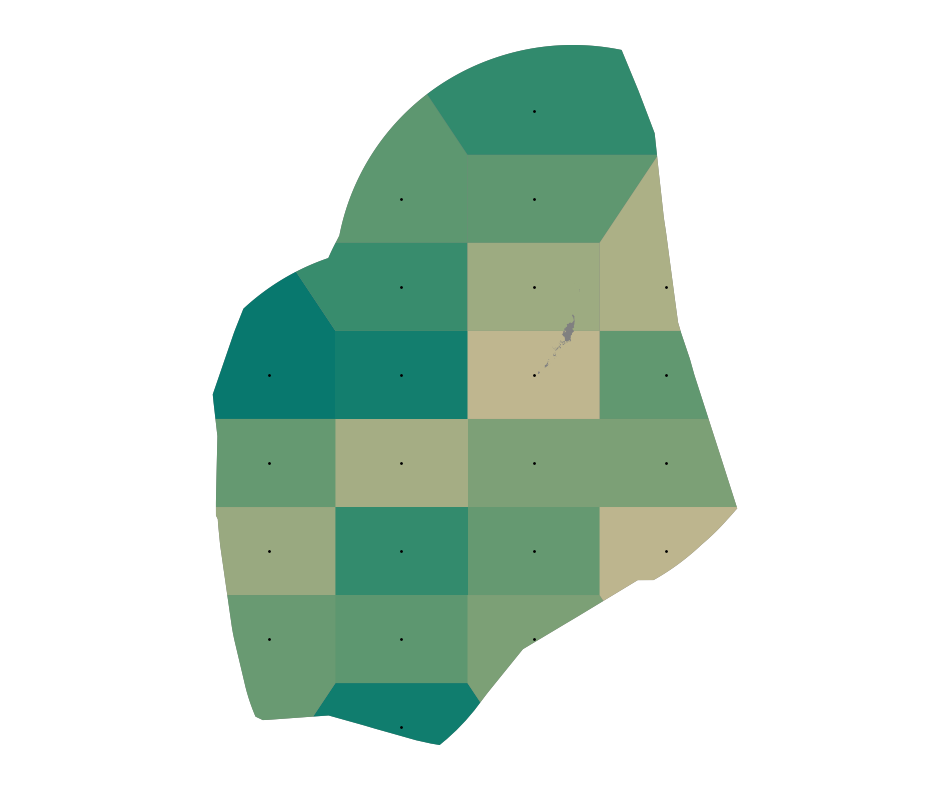

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2052_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


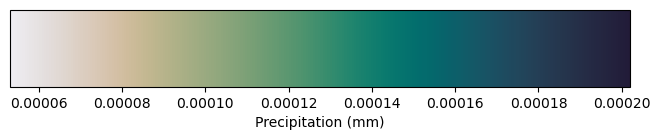

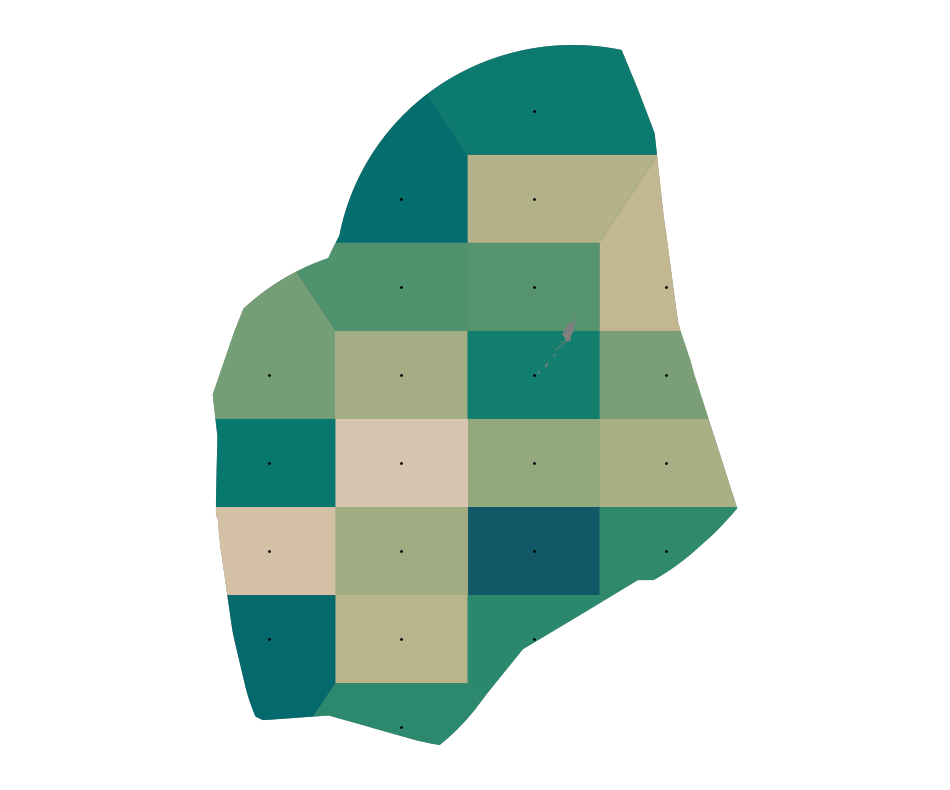

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2053_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


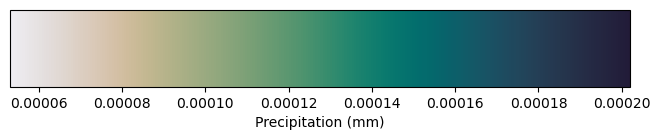

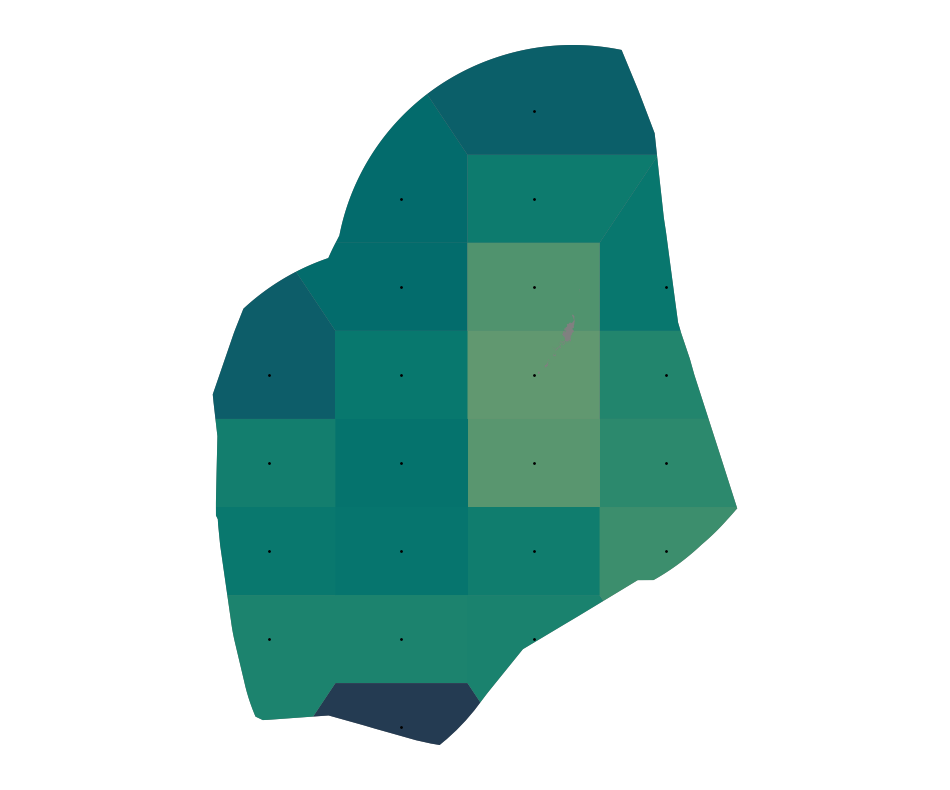

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2054_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


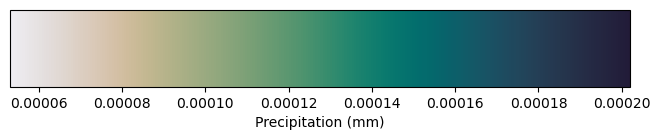

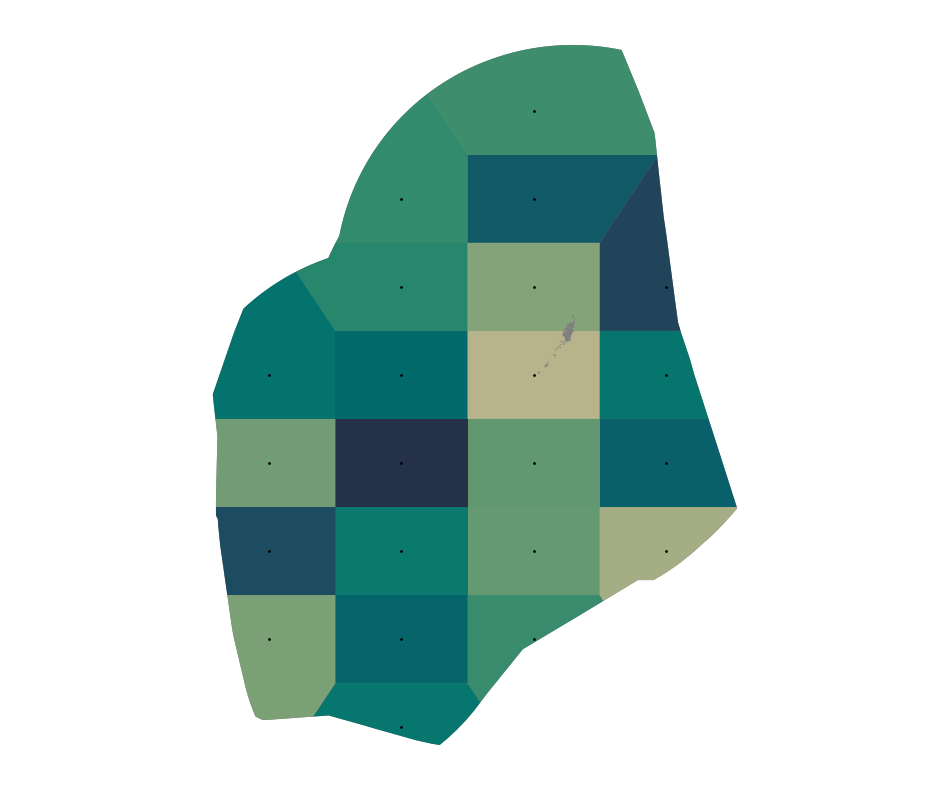

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2055_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


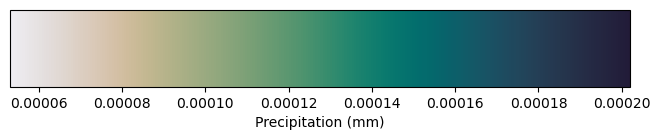

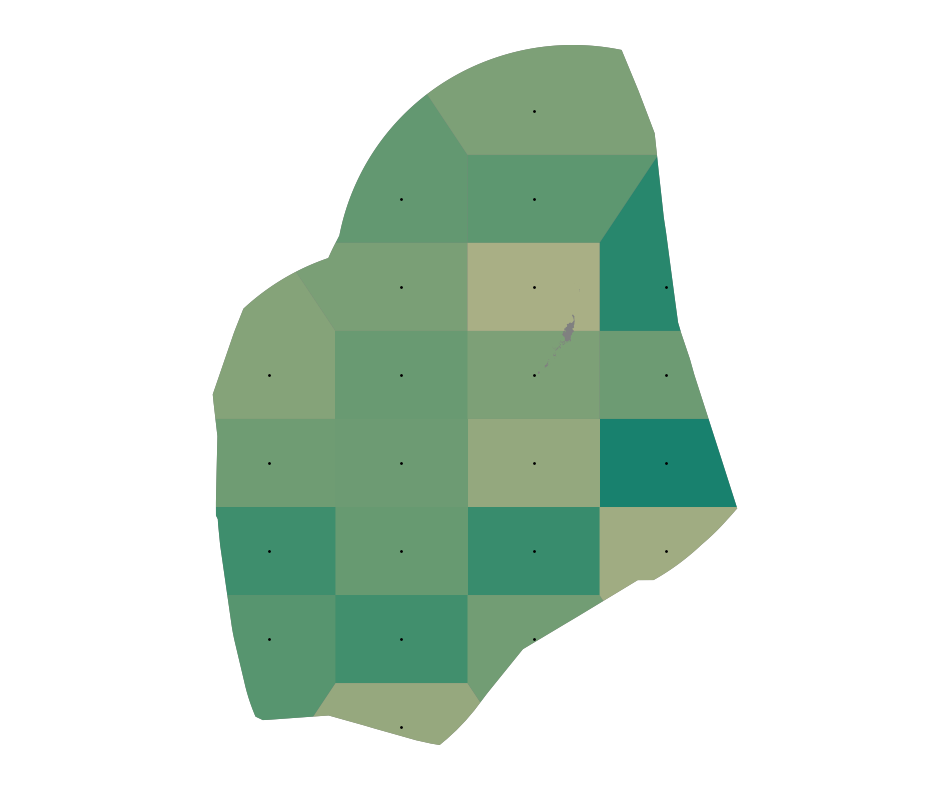

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2056_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


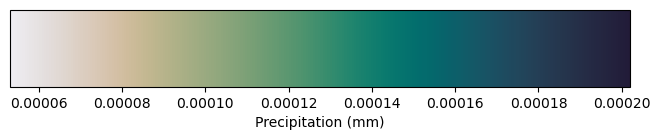

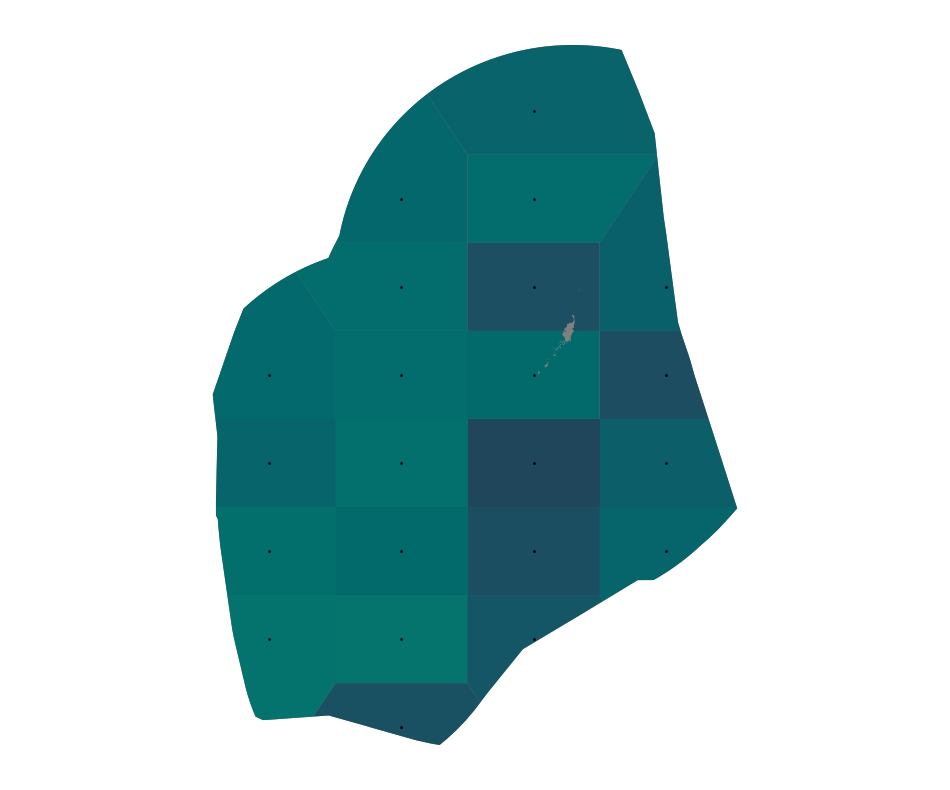

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2057_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


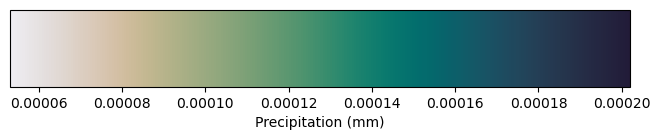

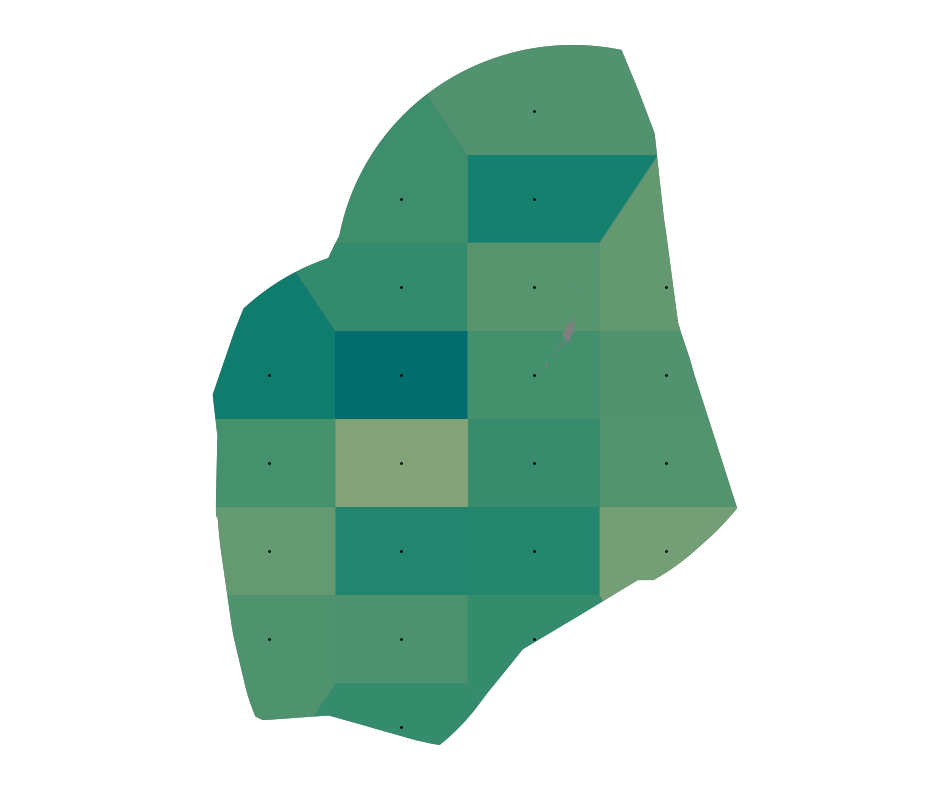

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2058_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


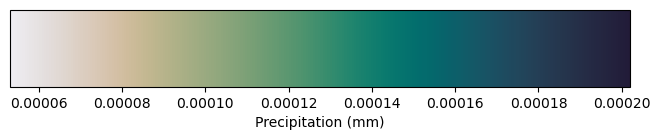

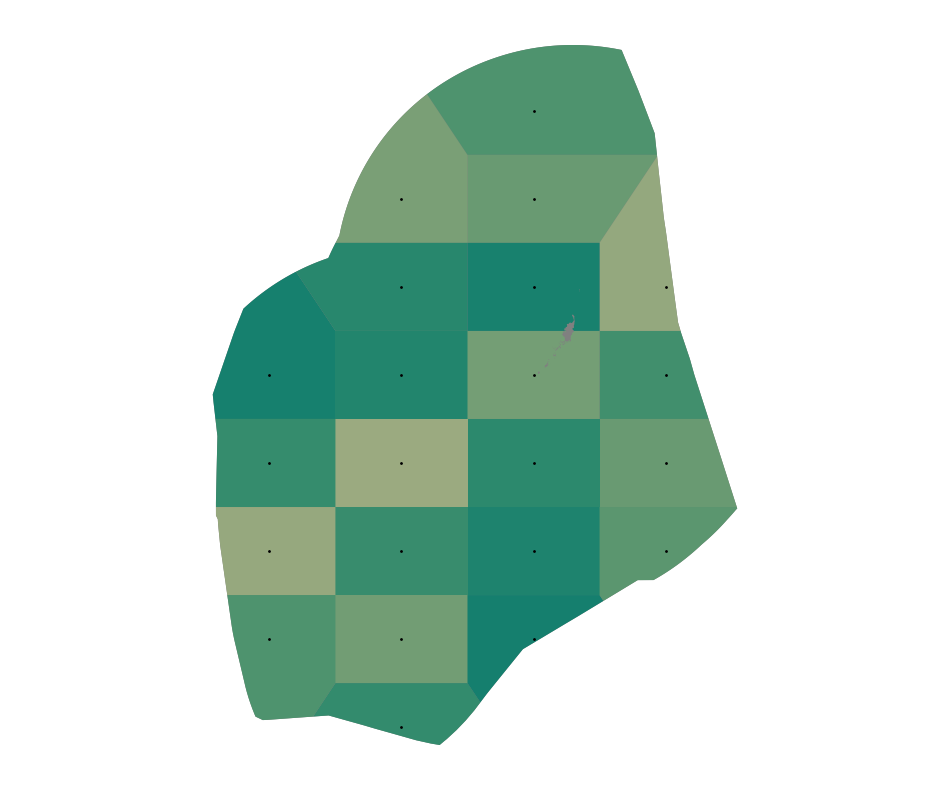

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2059_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


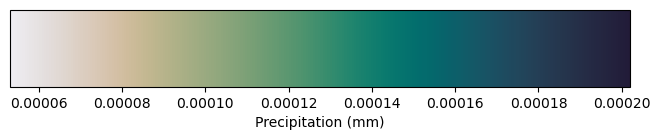

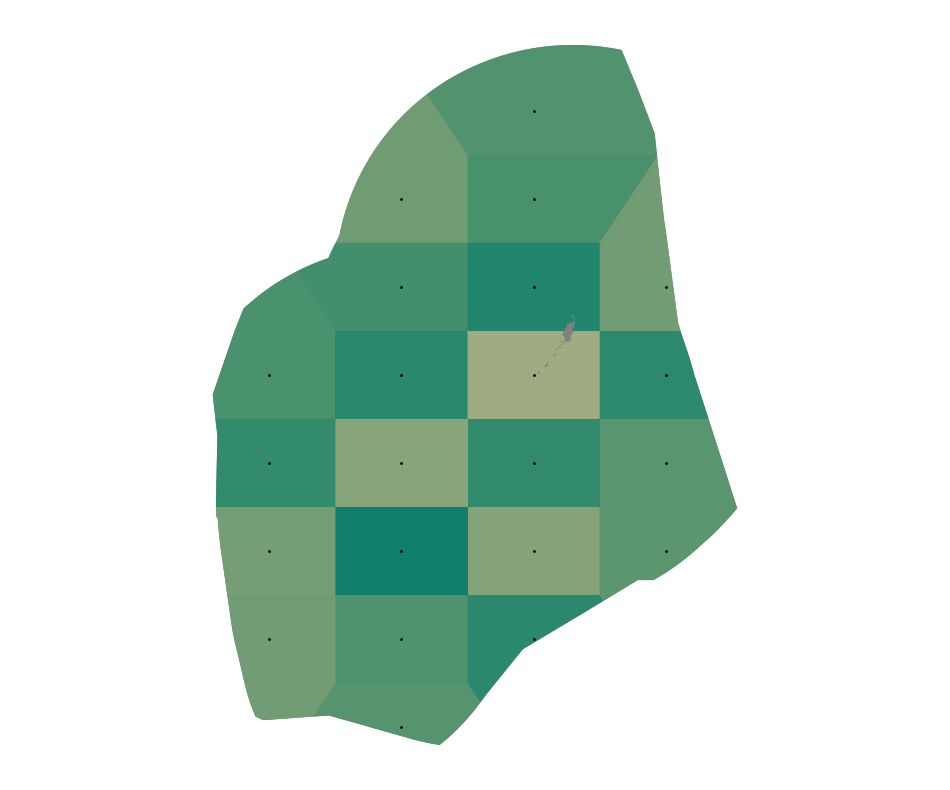

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2060_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


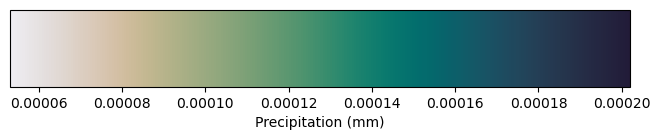

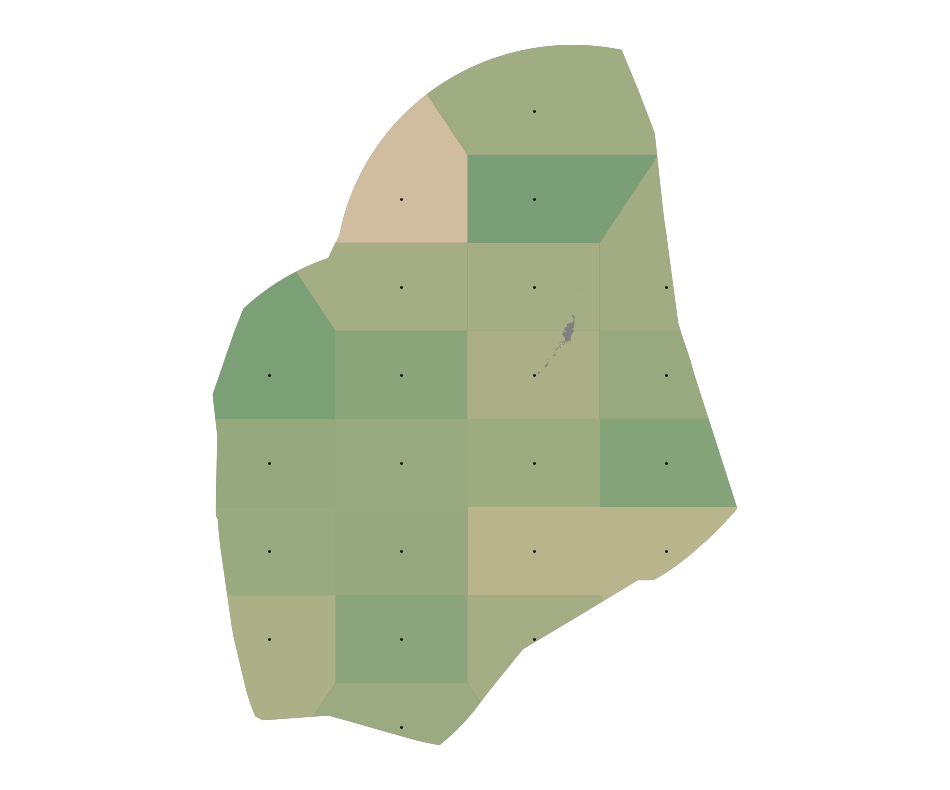

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2061_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


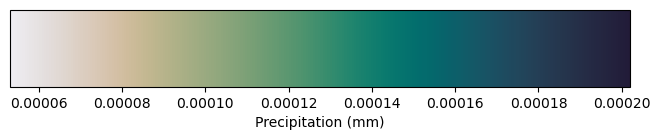

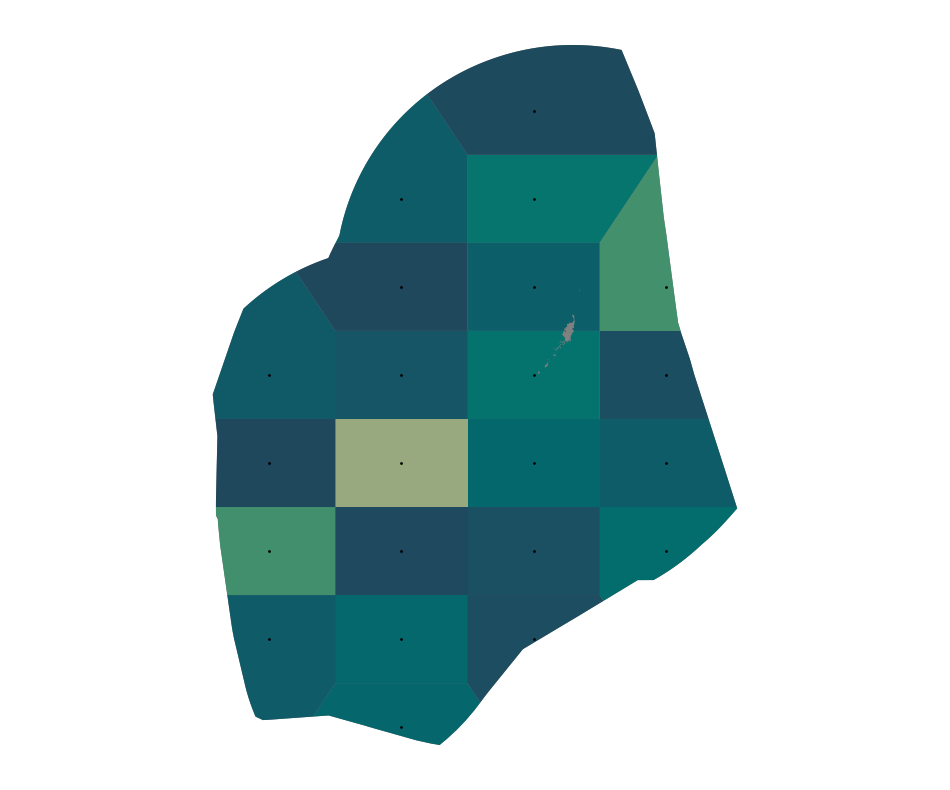

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2062_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


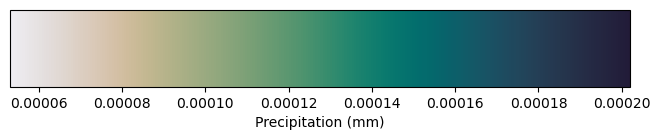

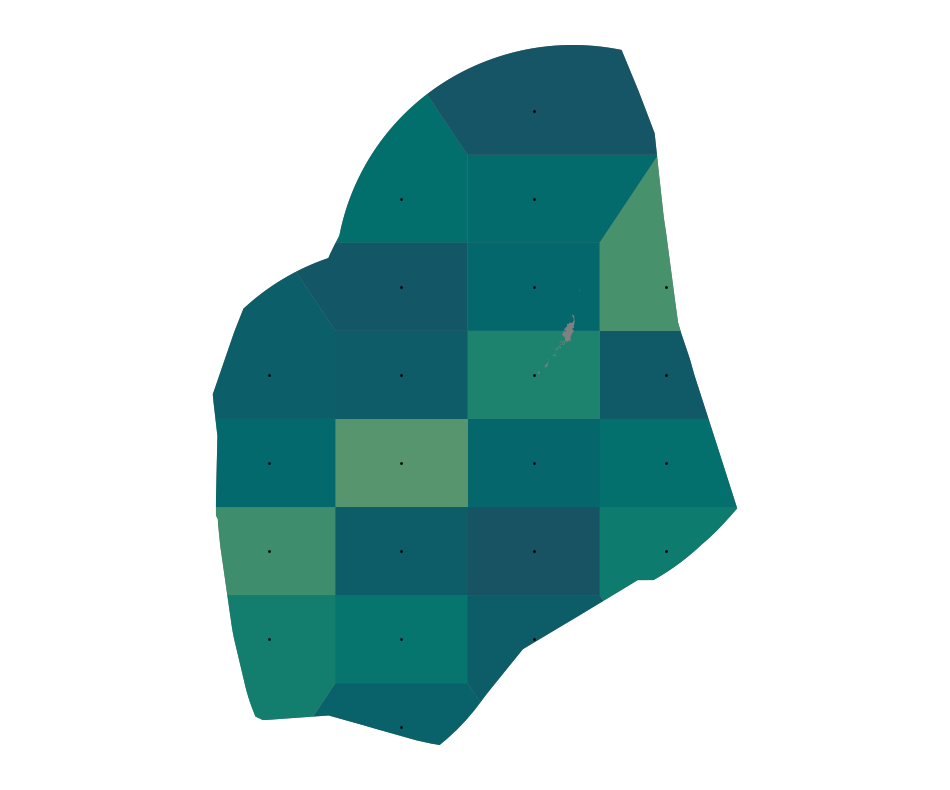

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2063_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


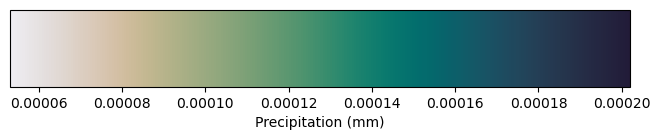

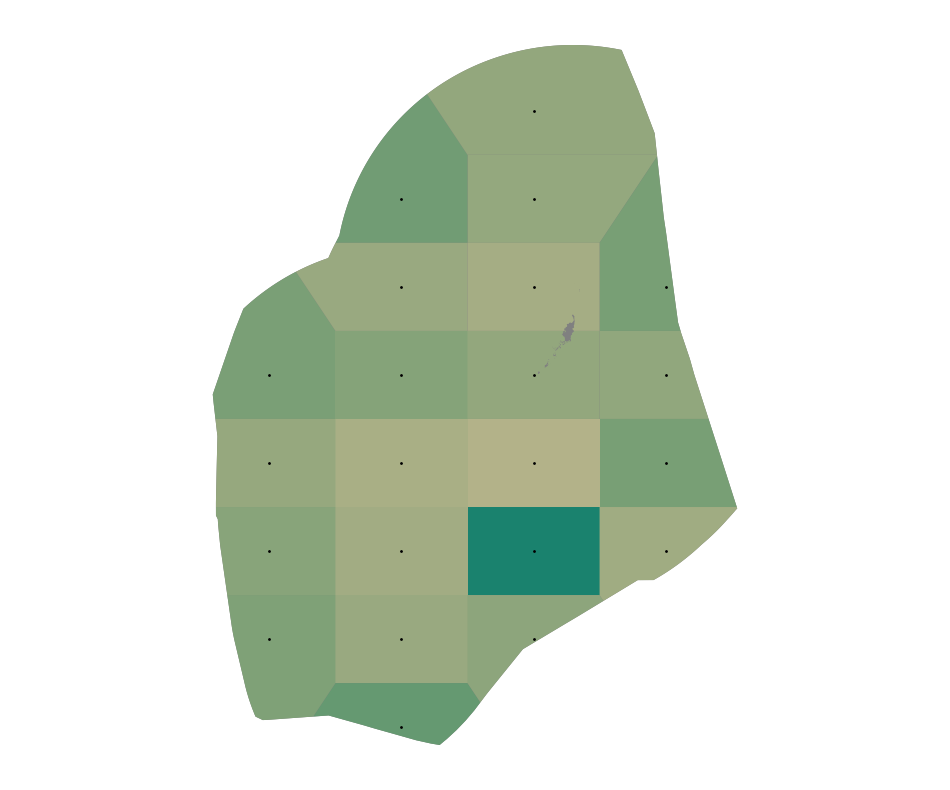

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2064_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


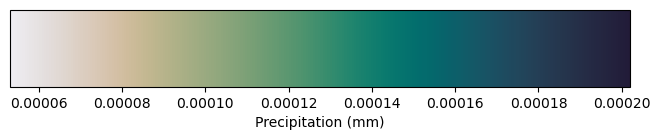

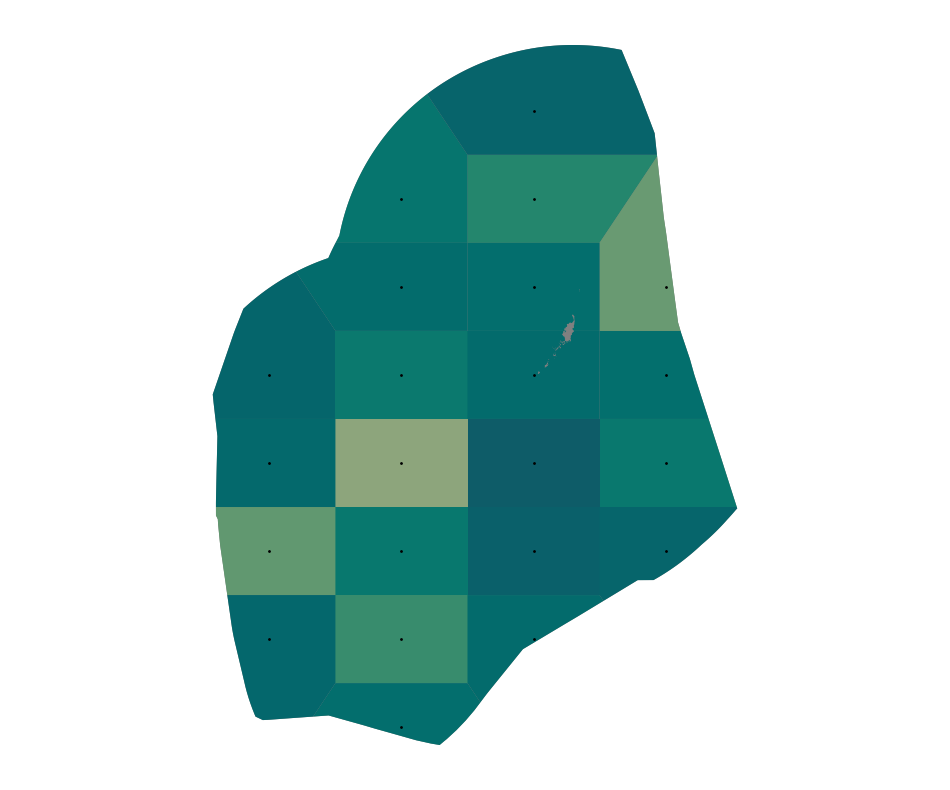

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2065_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


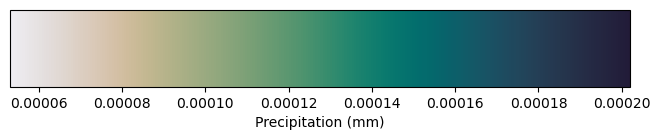

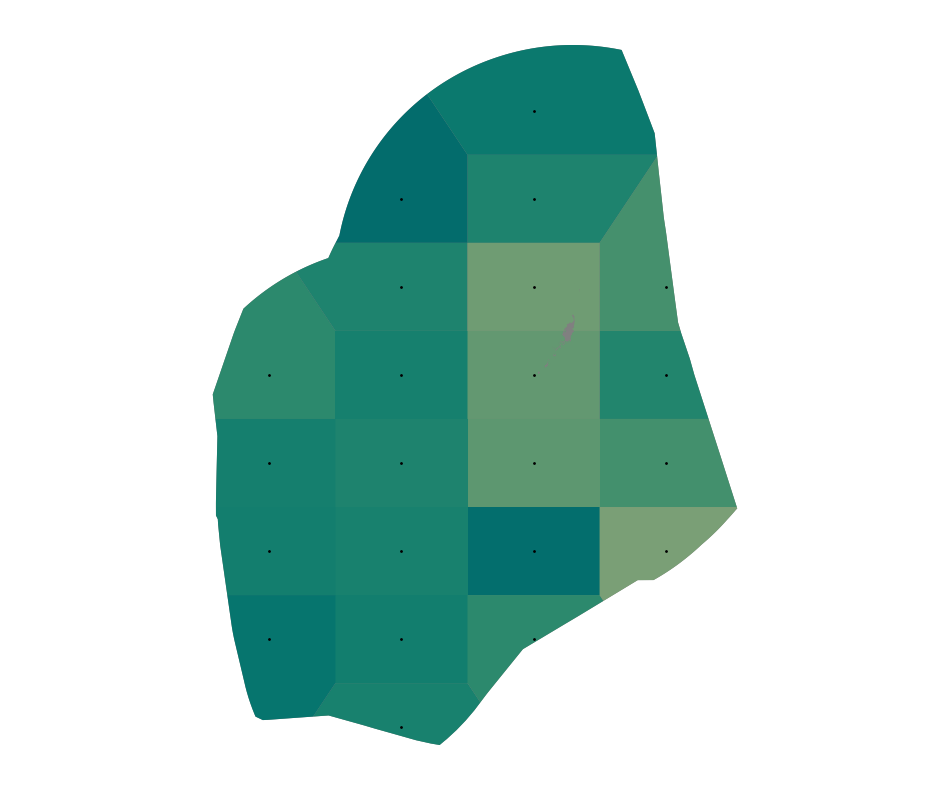

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2066_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


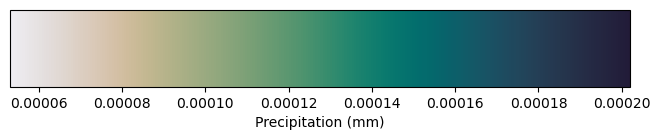

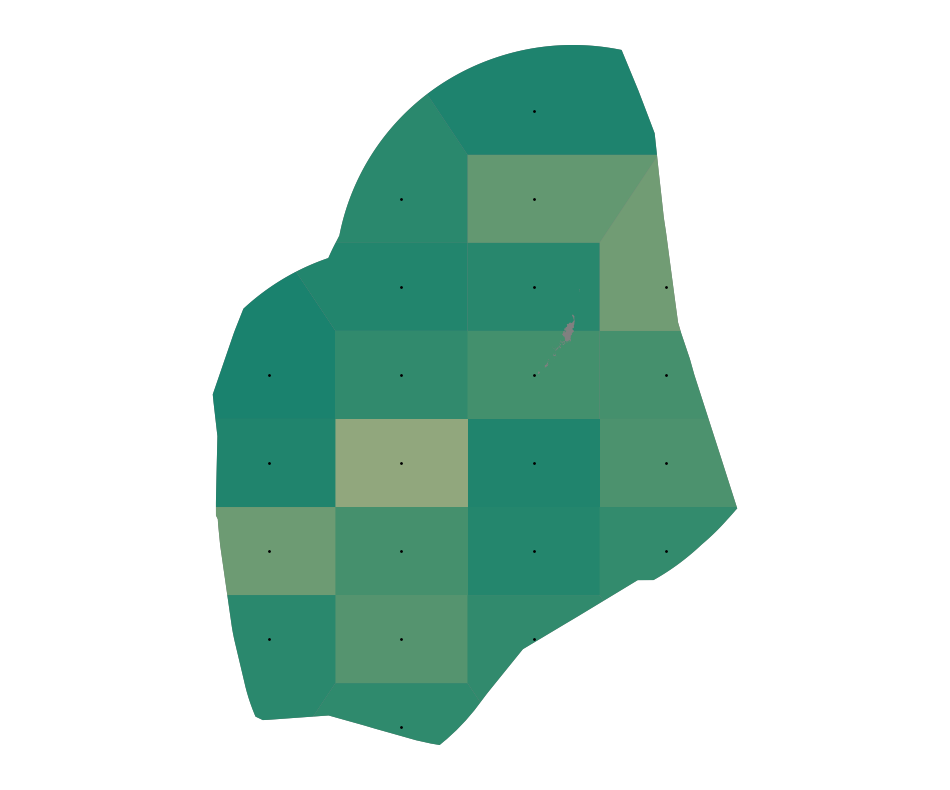

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2067_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


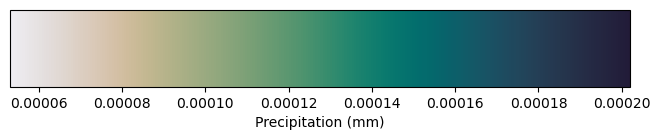

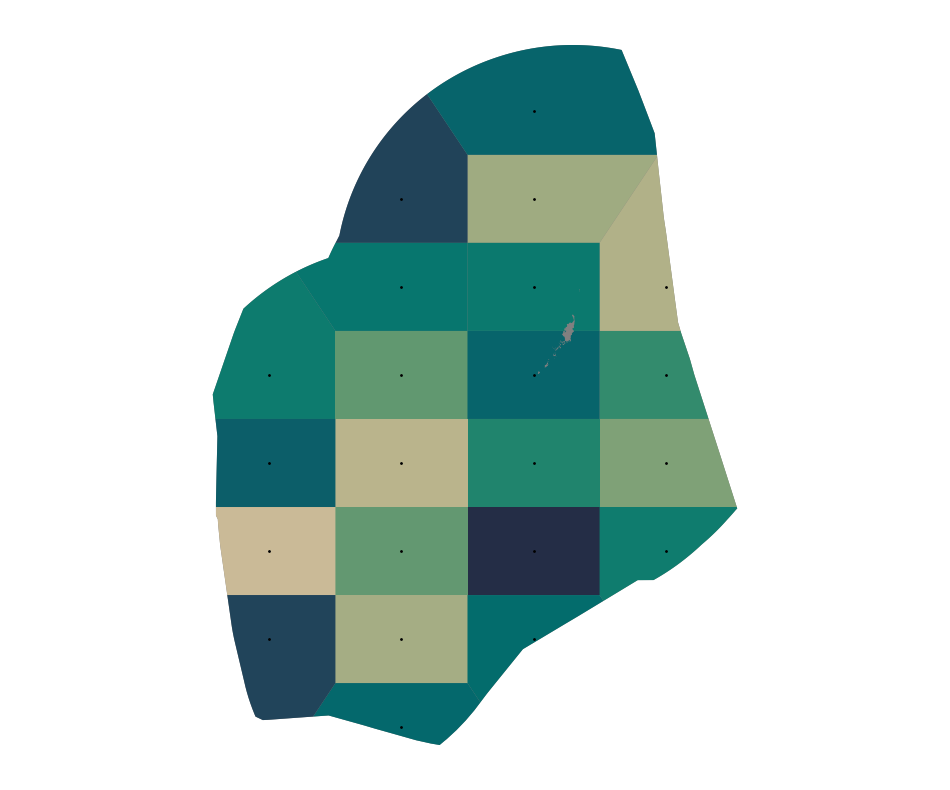

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2068_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


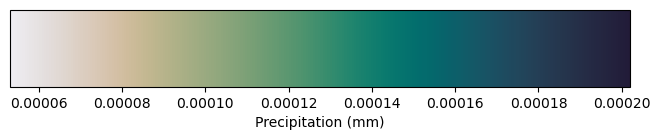

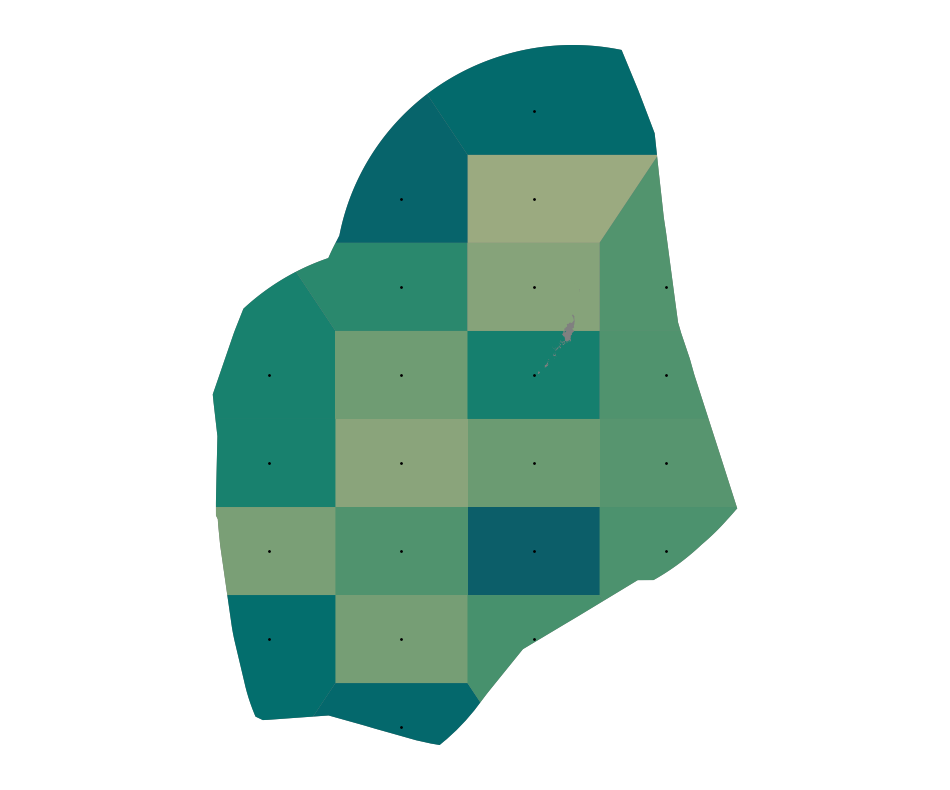

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2069_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


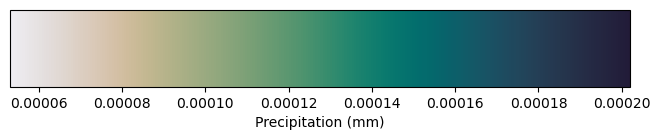

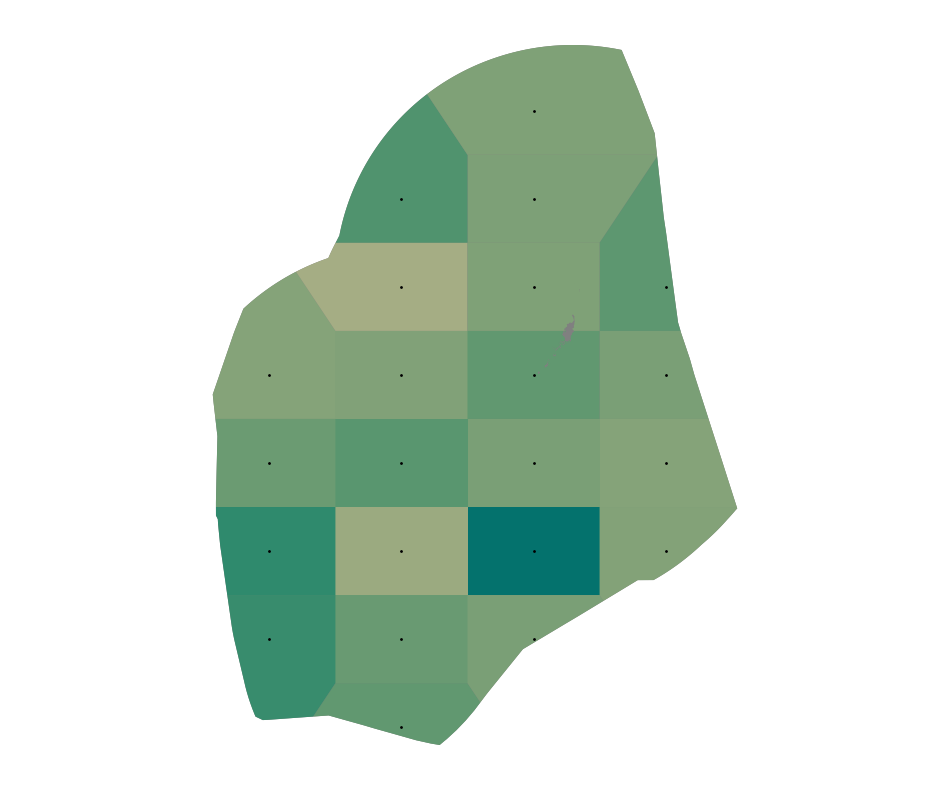

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2070_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


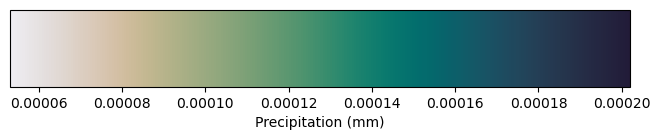

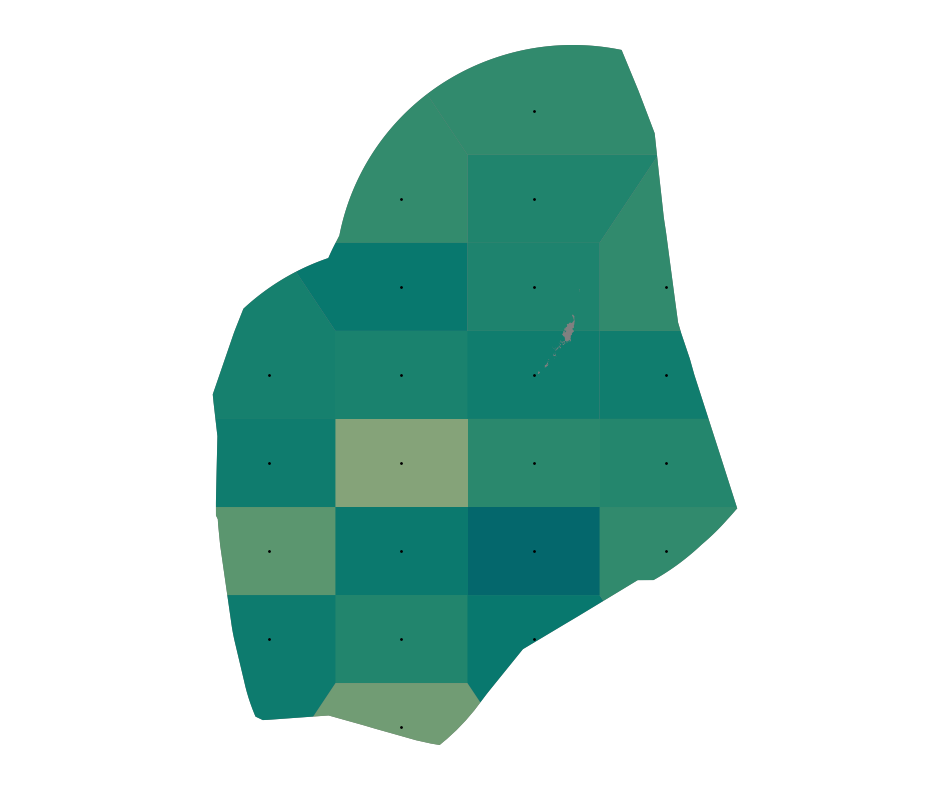

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2071_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


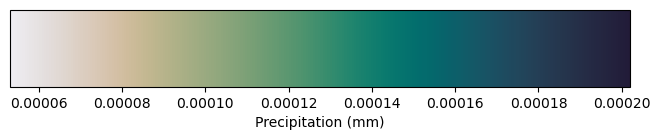

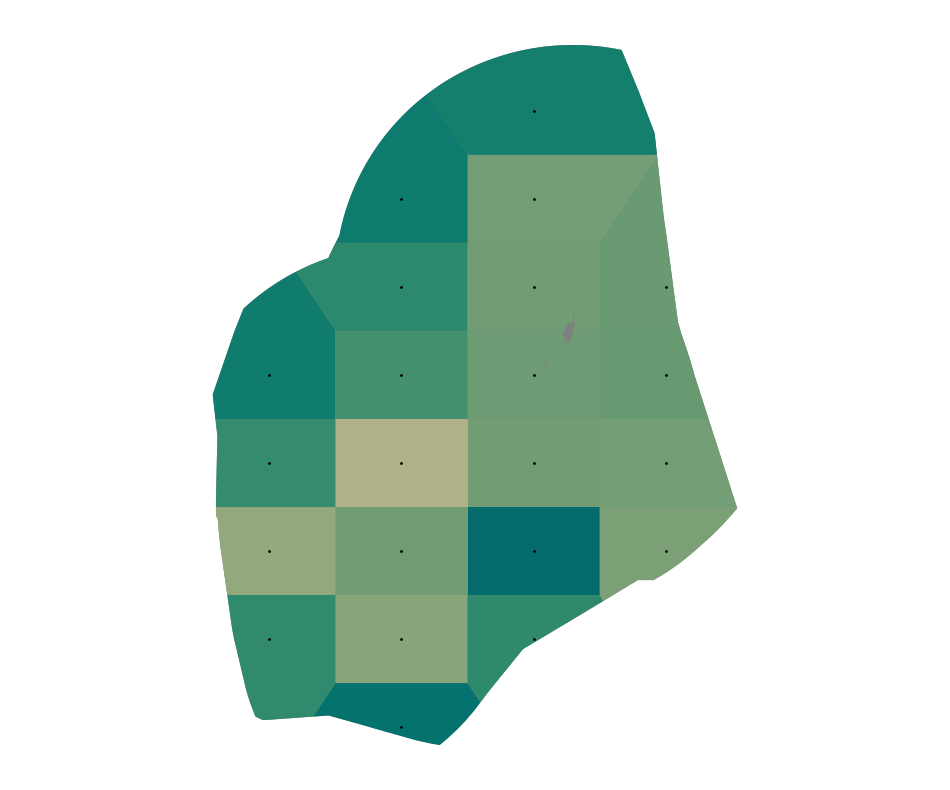

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2072_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


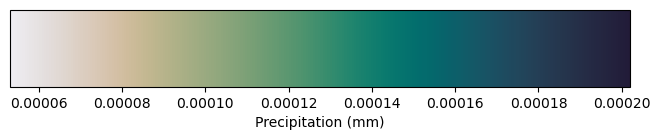

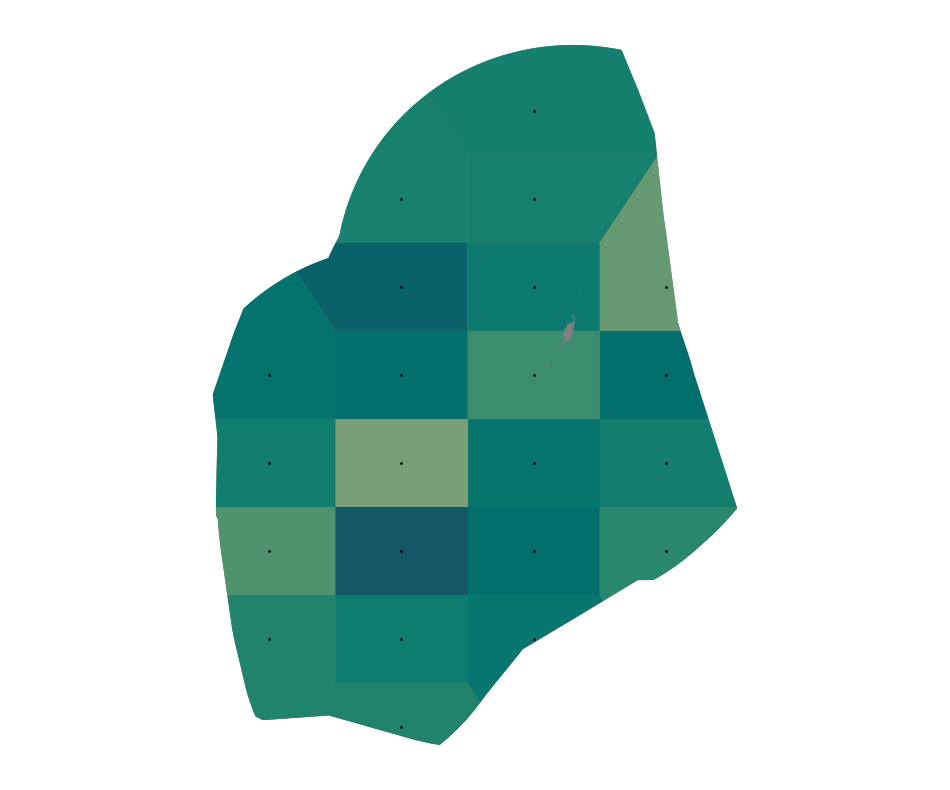

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2073_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


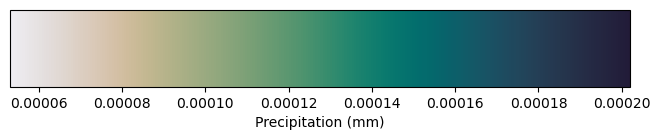

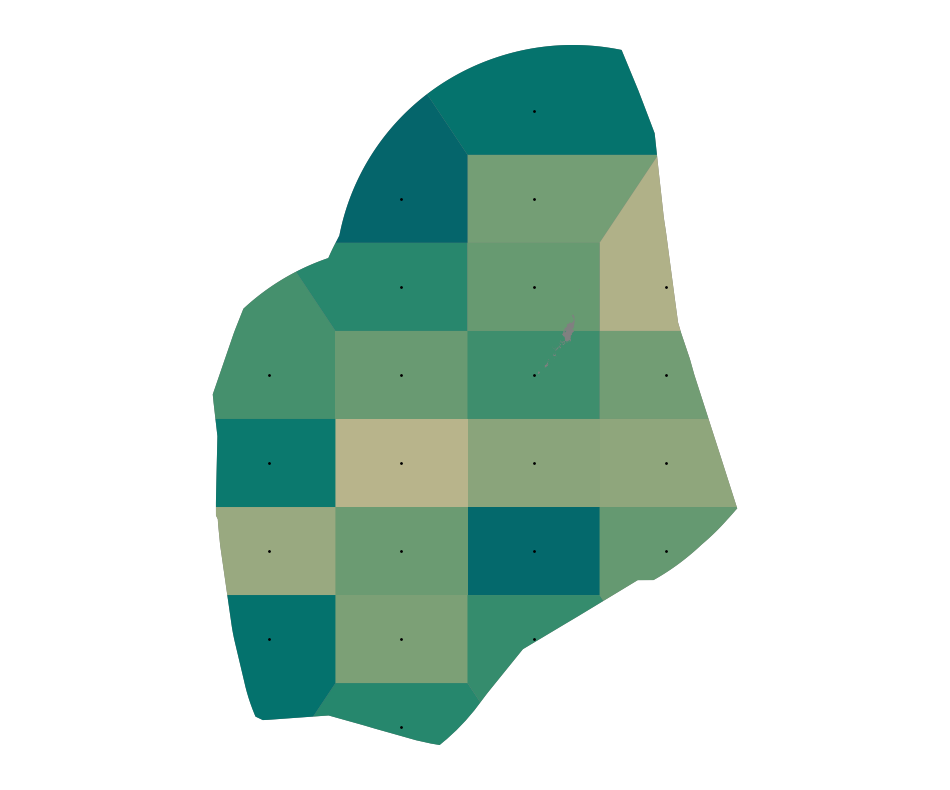

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2074_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


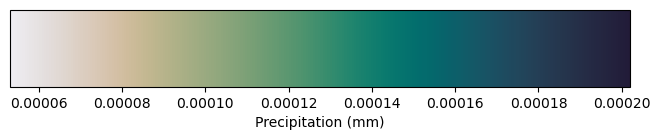

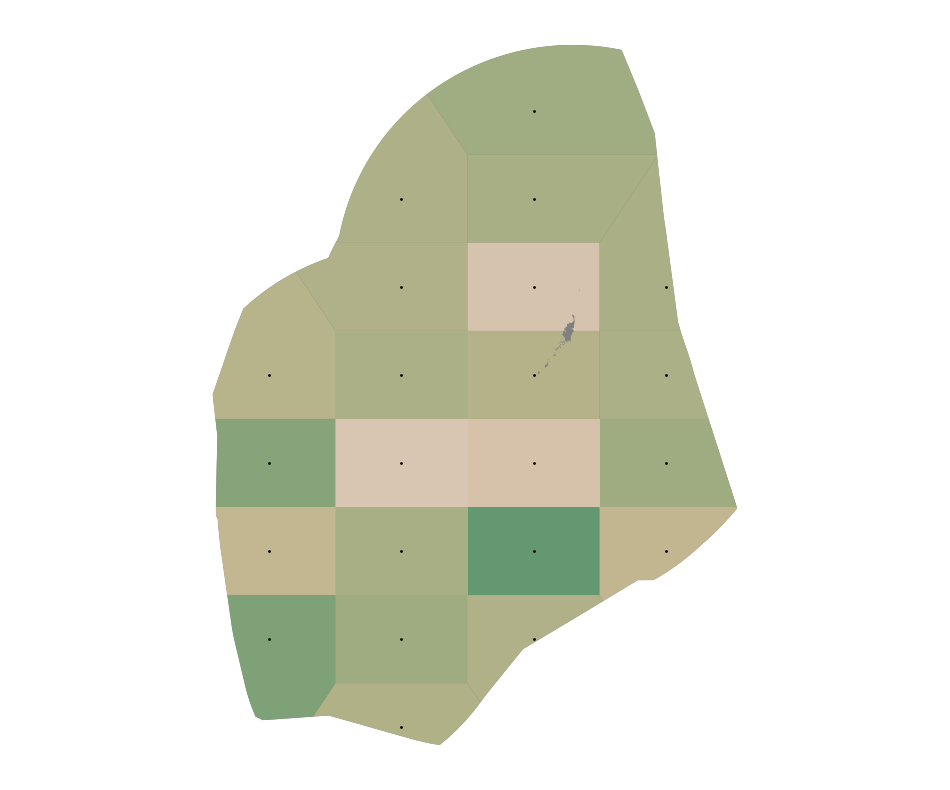

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2075_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


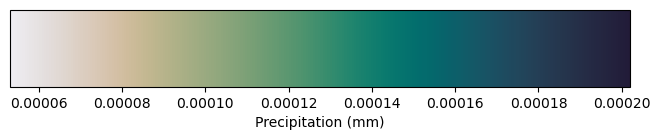

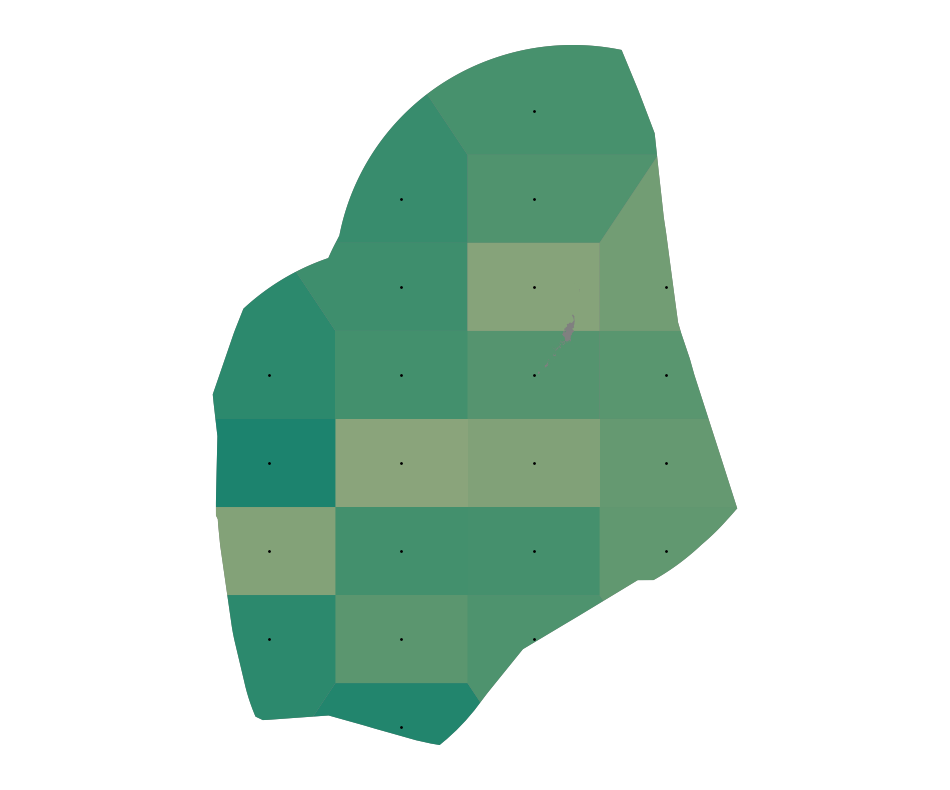

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2076_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


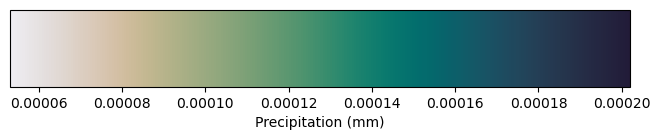

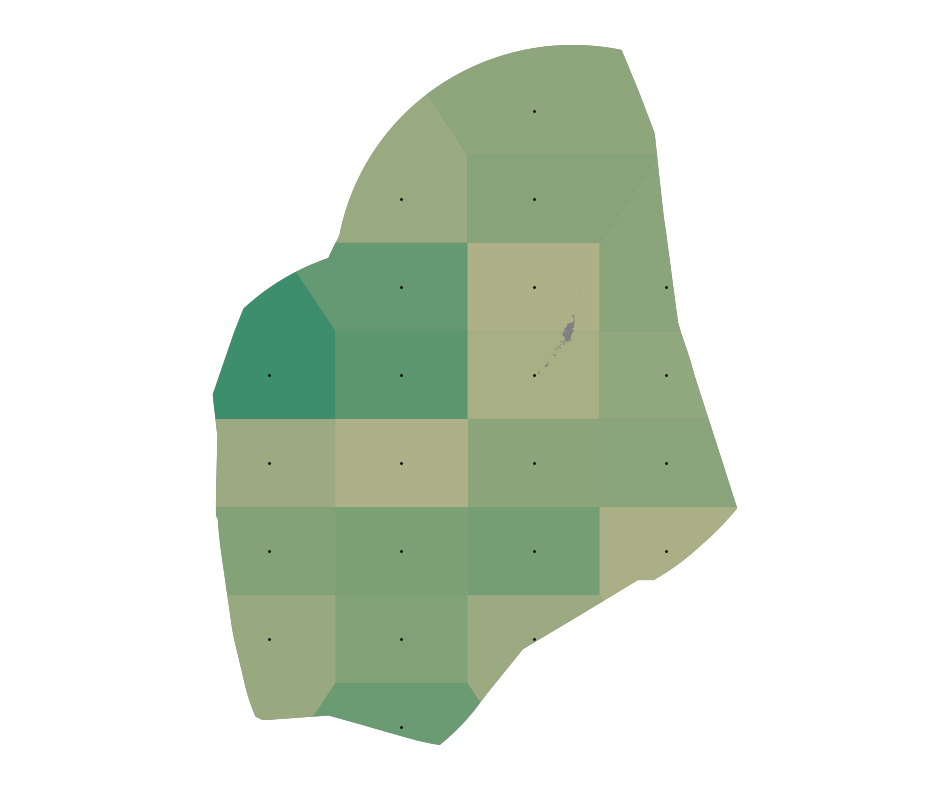

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2077_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


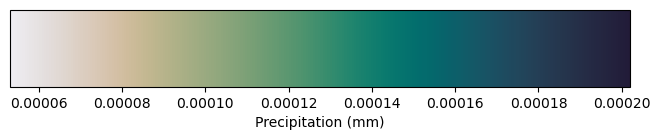

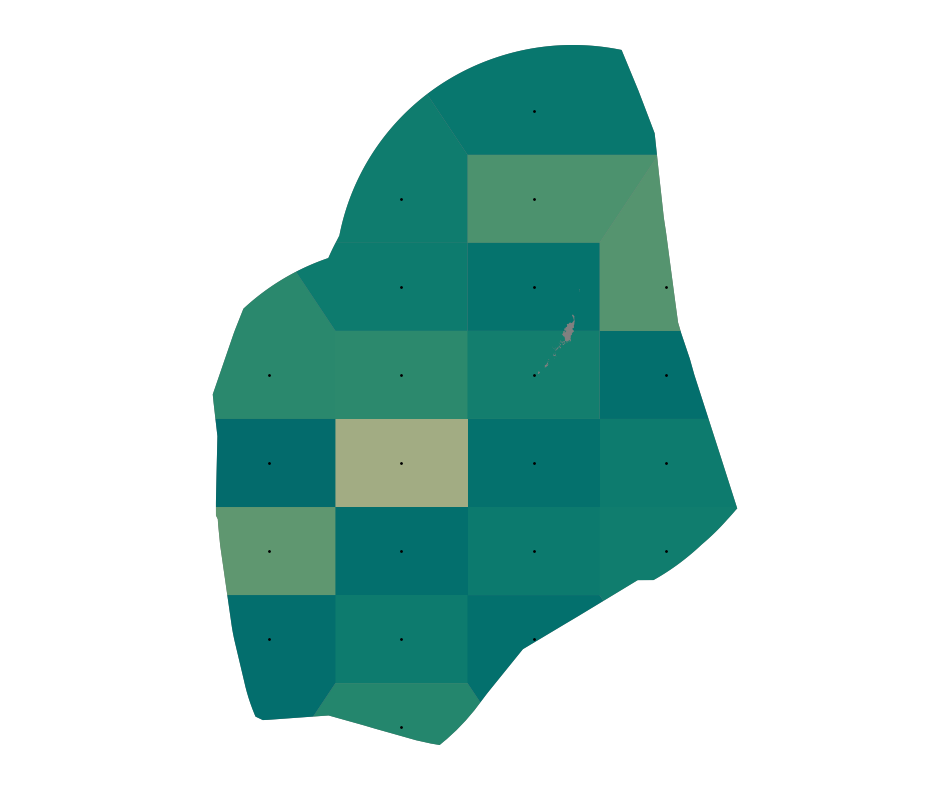

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2078_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


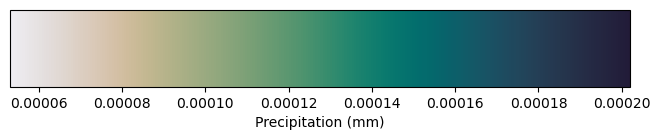

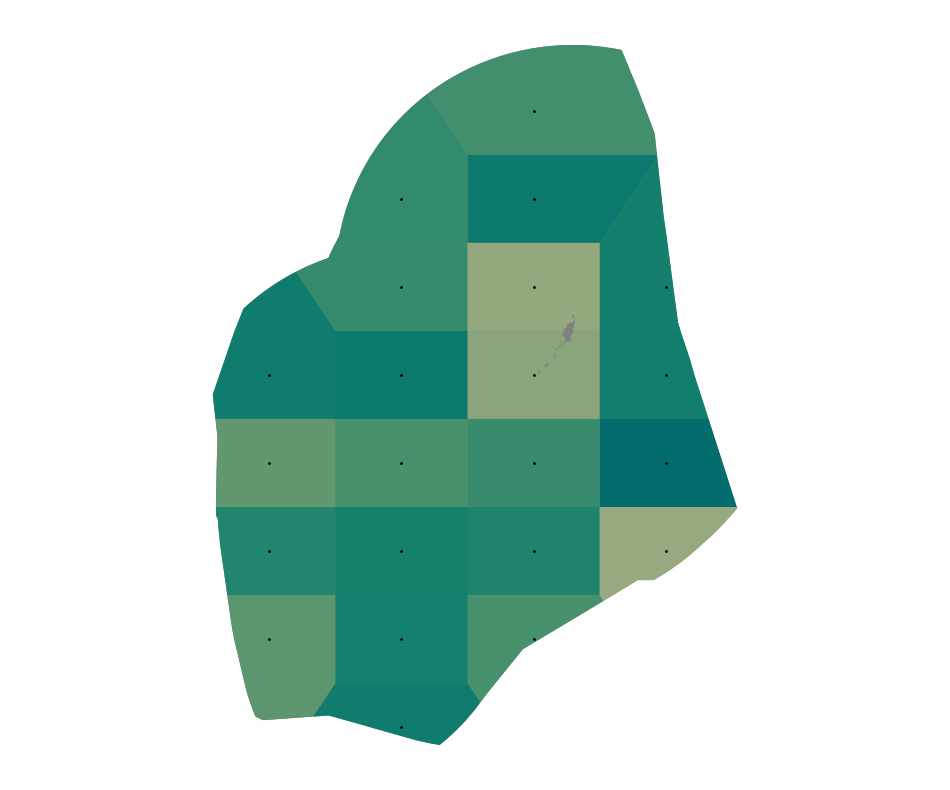

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2079_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


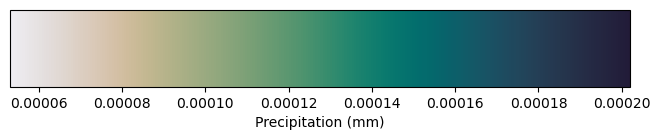

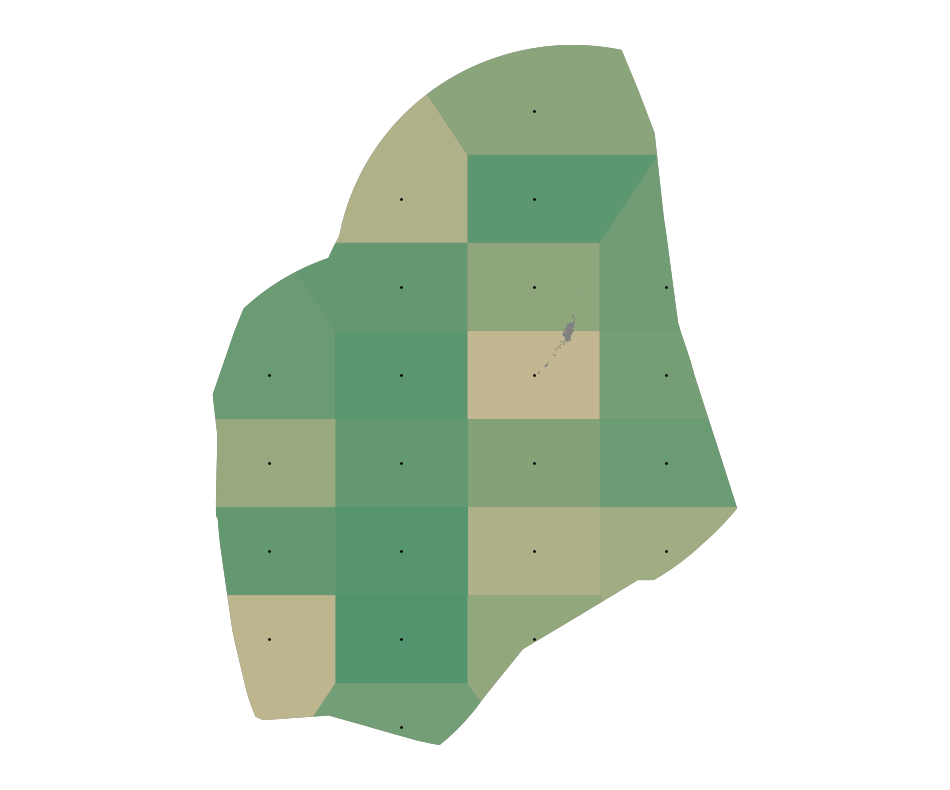

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2080_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


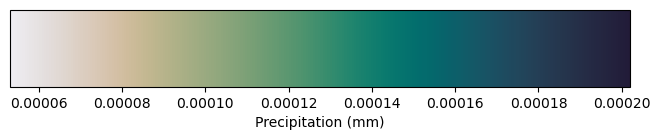

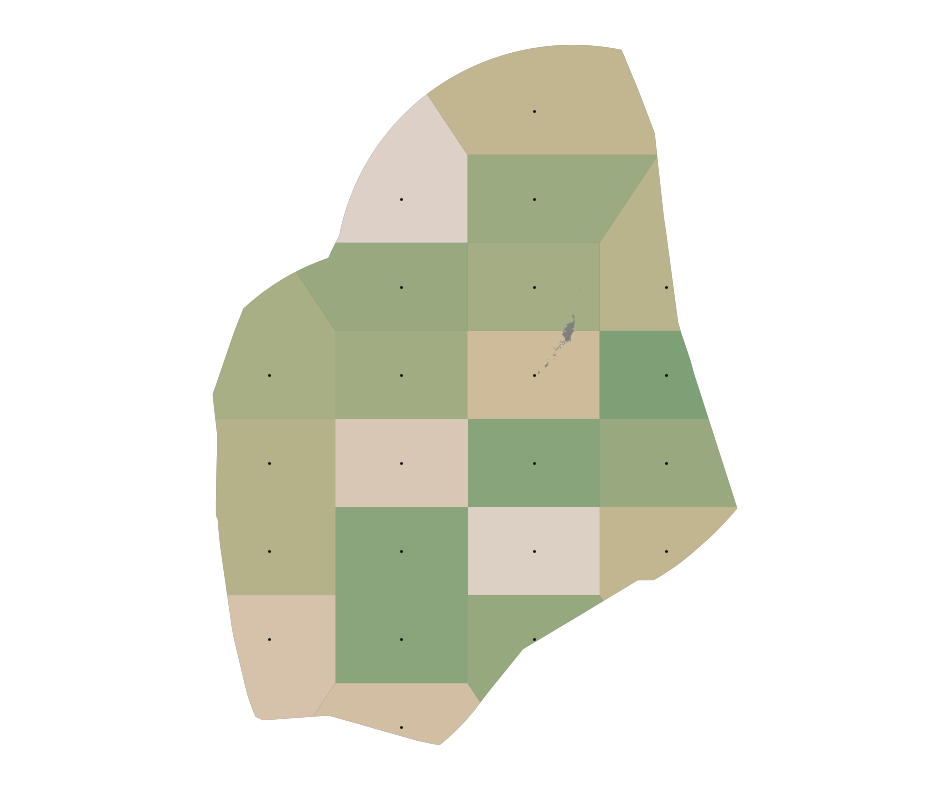

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2081_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


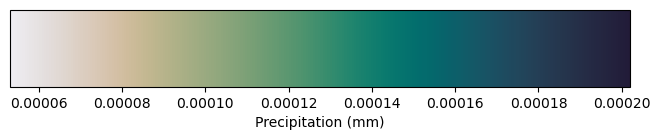

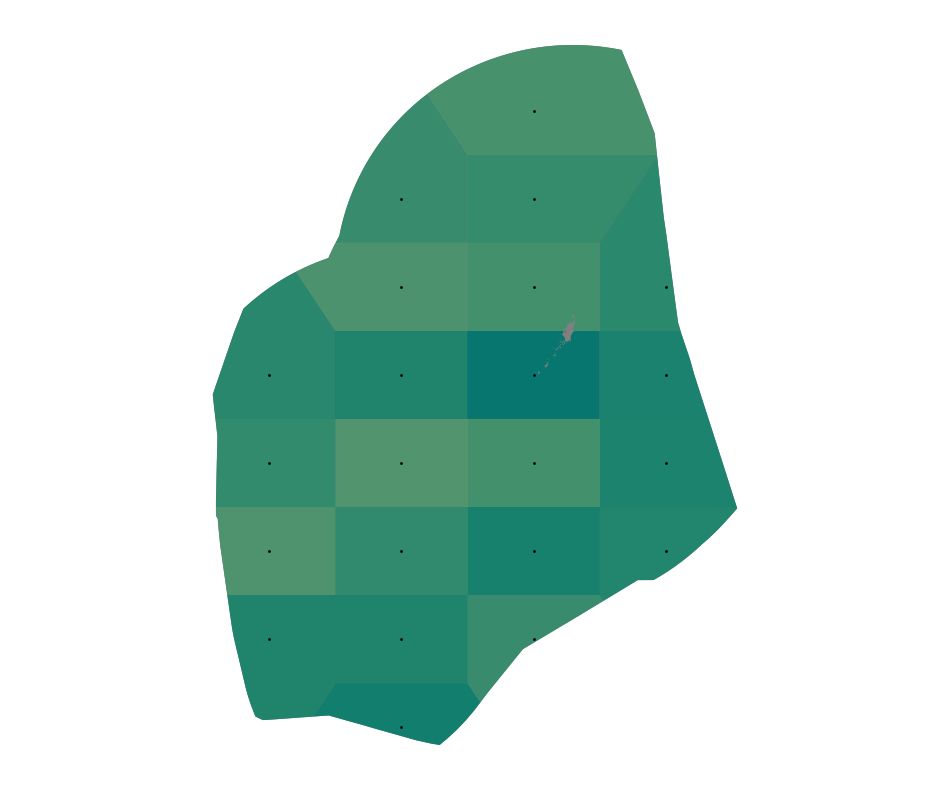

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2082_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


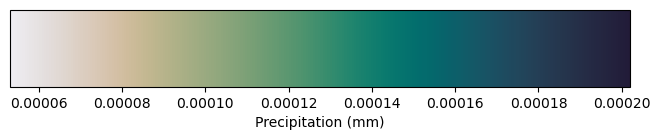

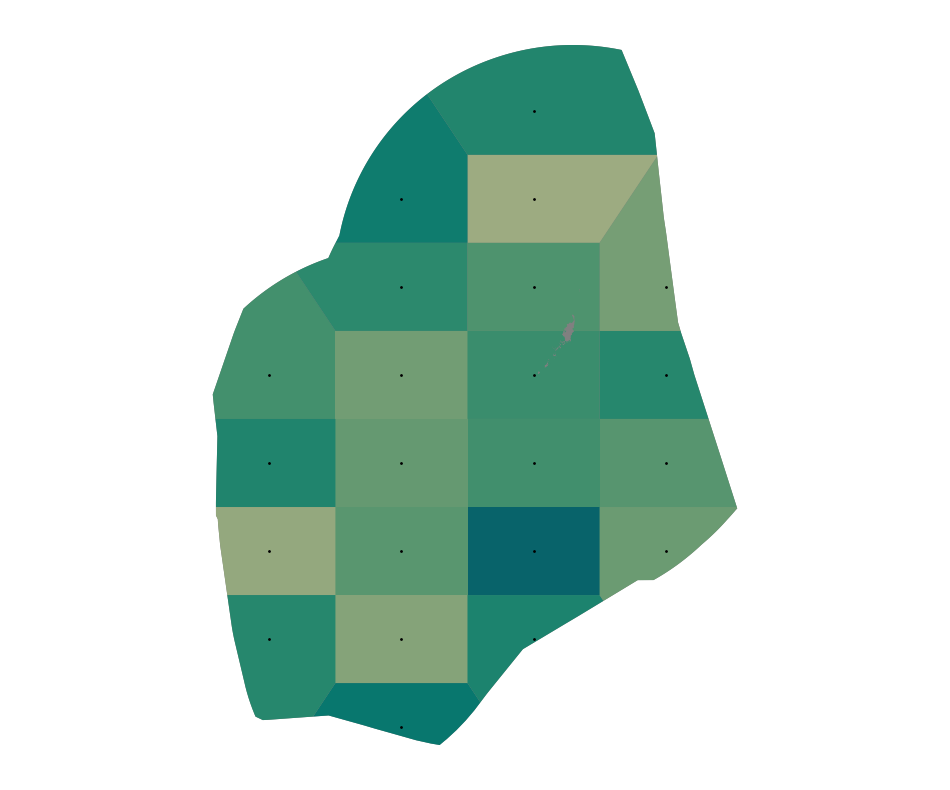

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2083_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


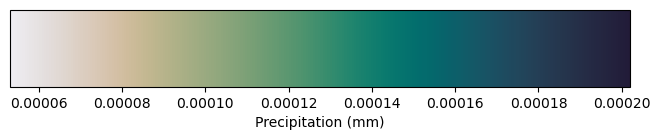

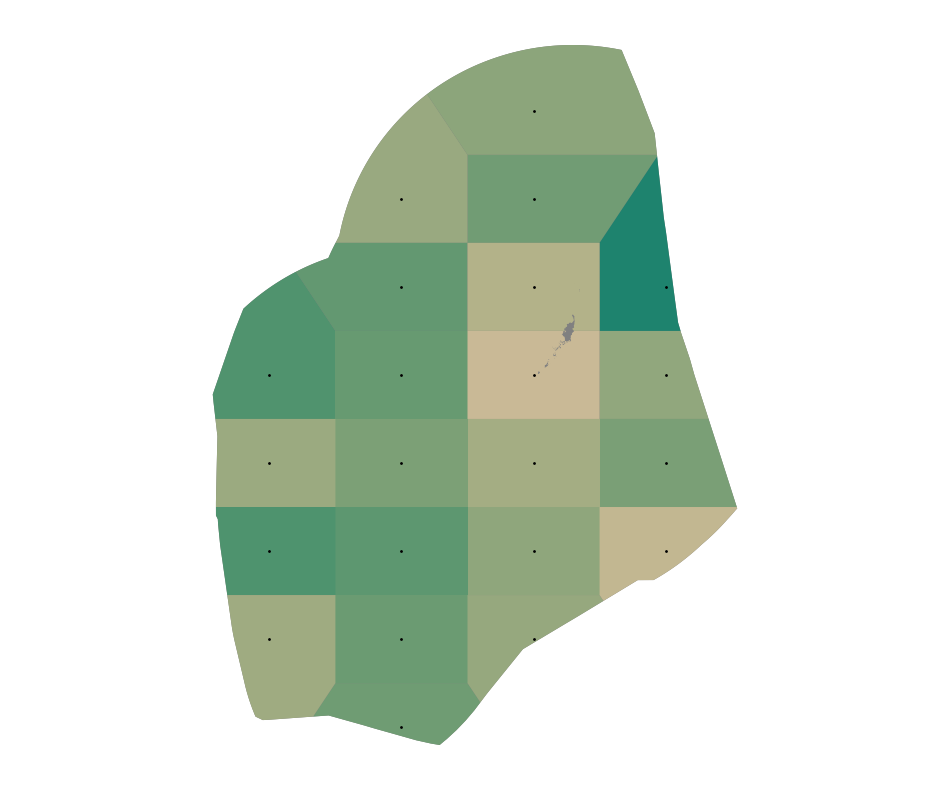

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2084_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


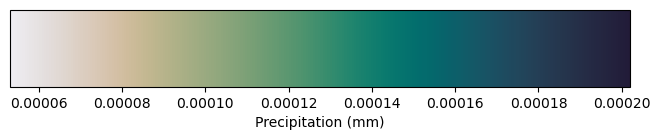

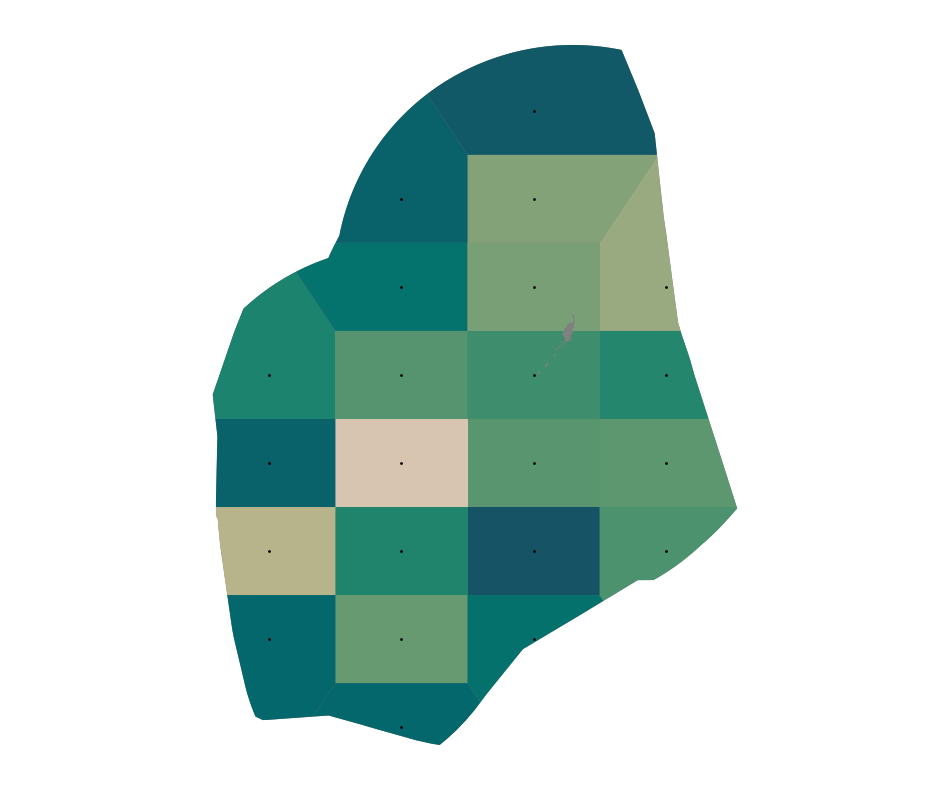

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2085_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


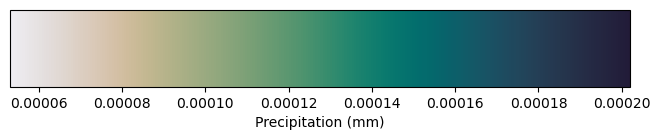

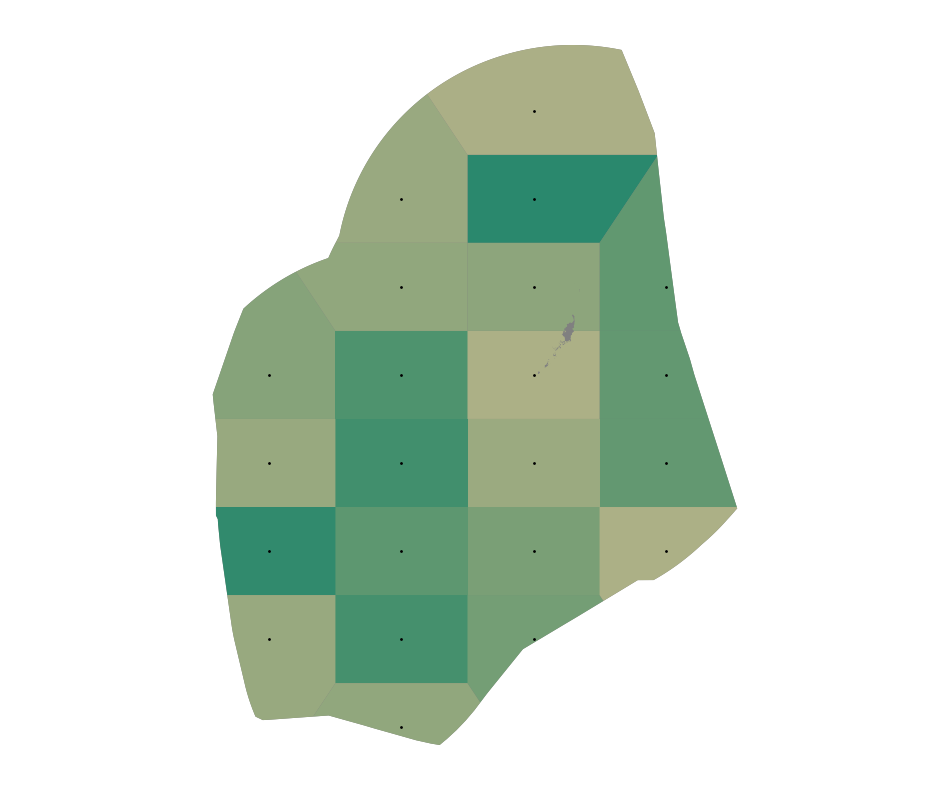

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2086_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


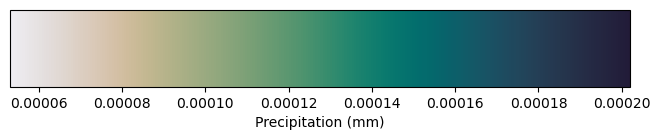

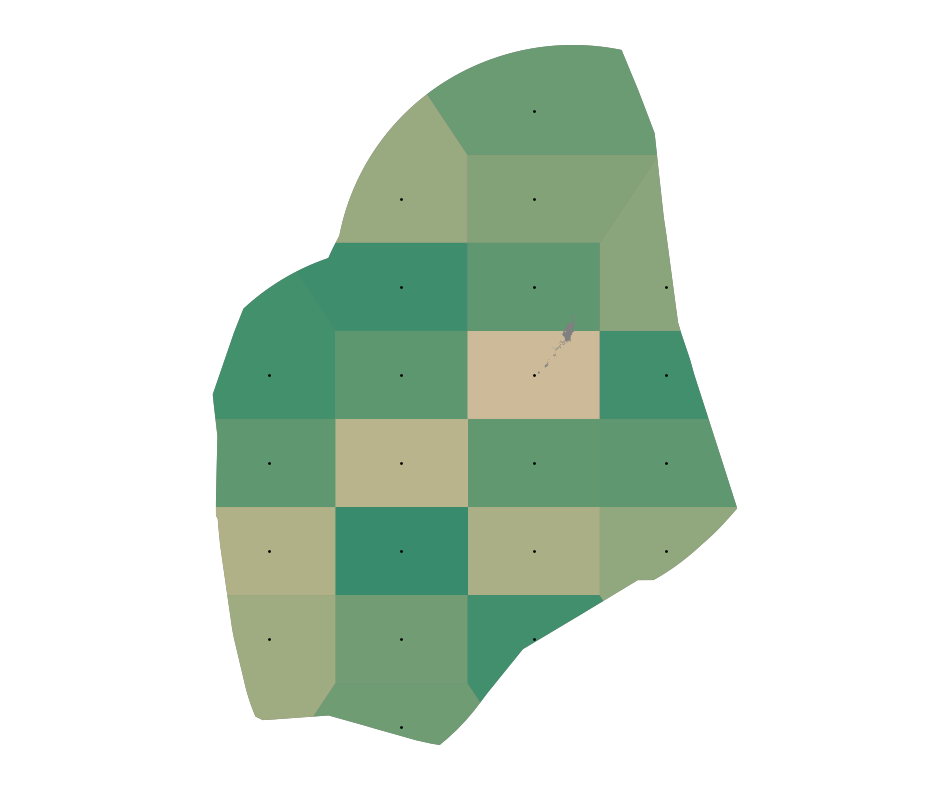

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2087_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


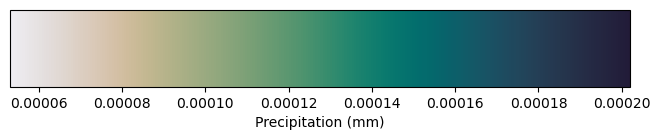

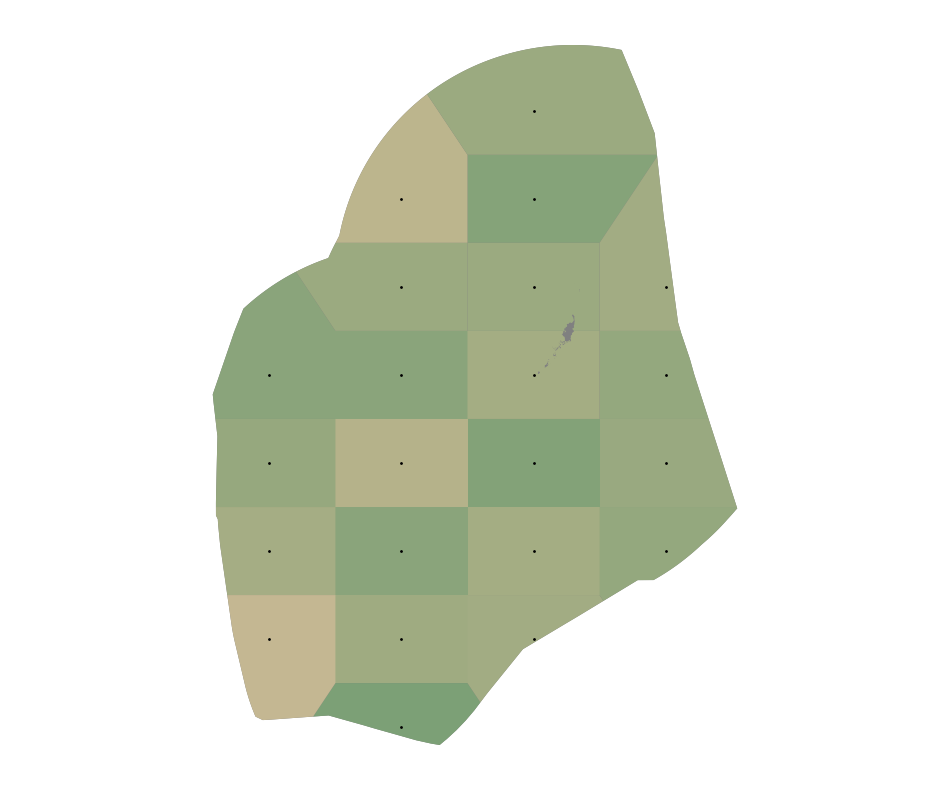

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2088_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


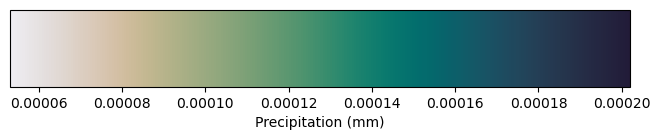

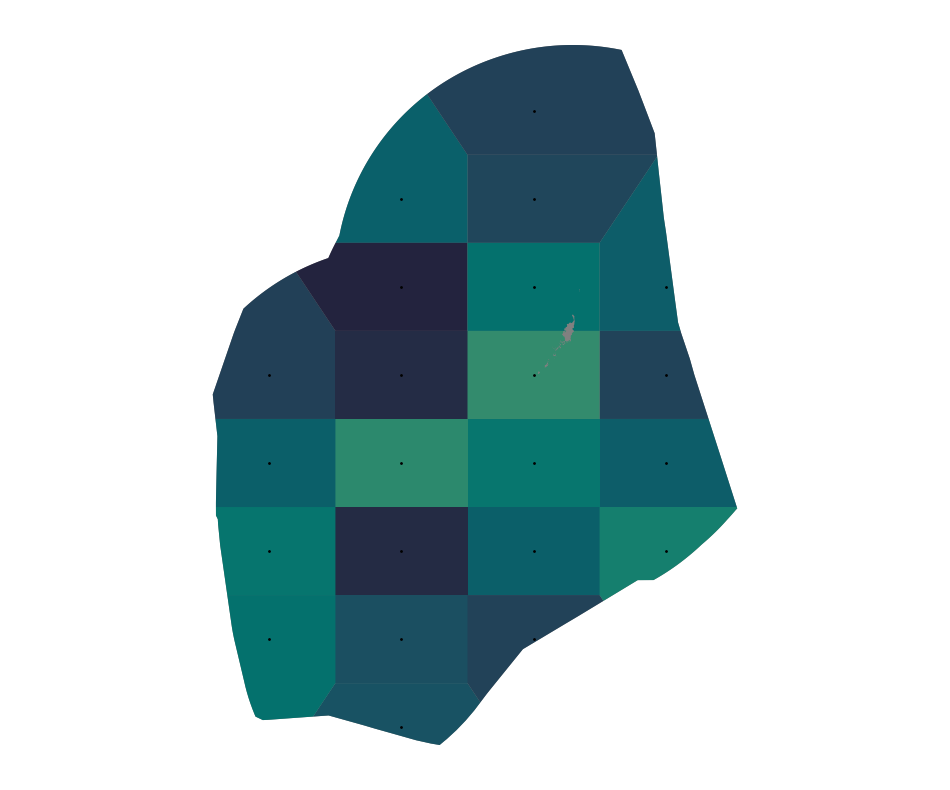

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2089_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


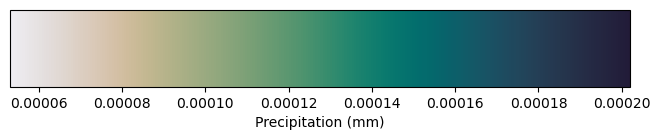

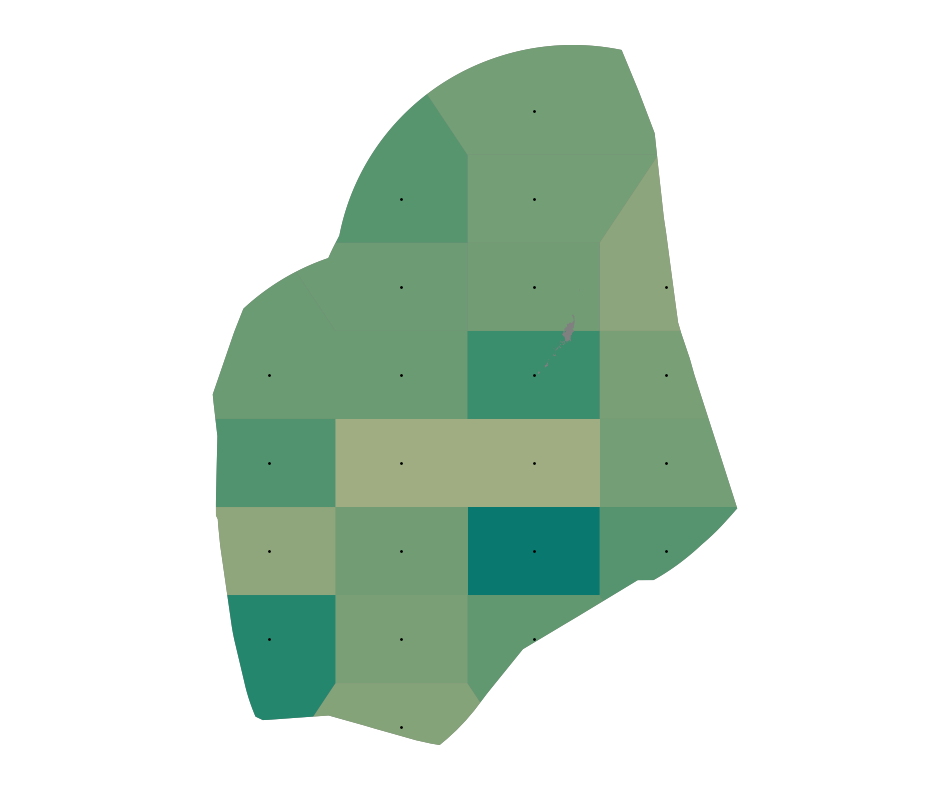

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2090_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


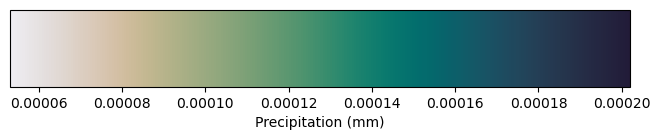

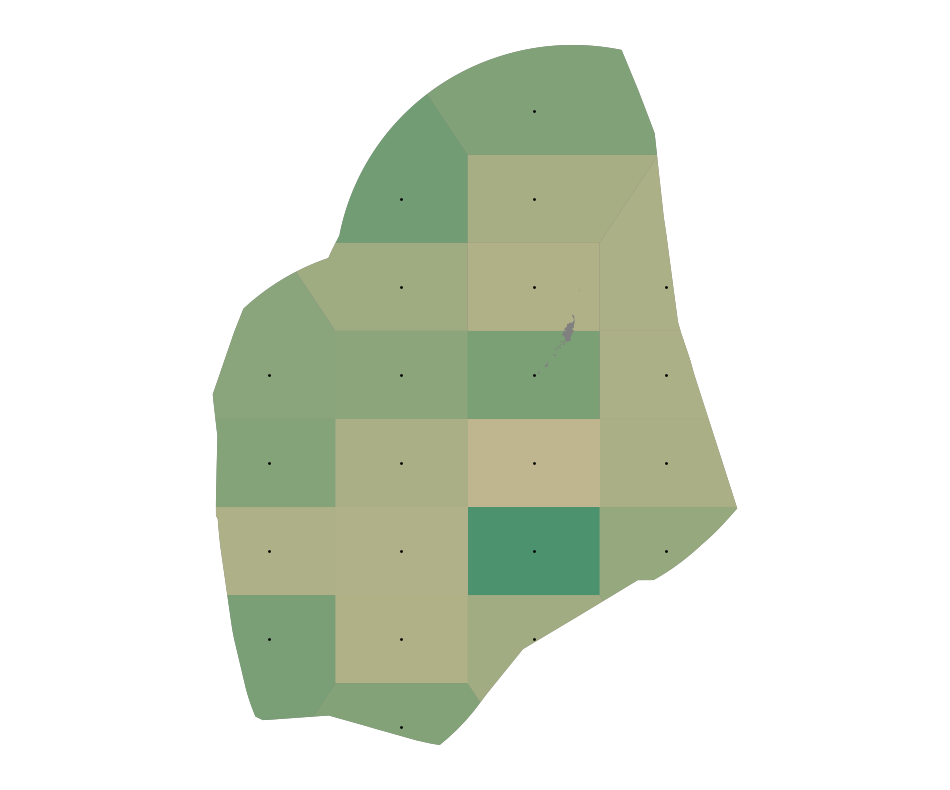

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2091_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


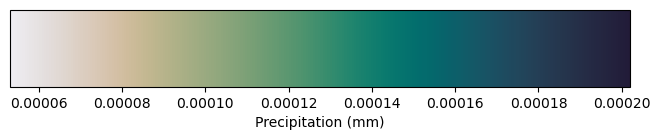

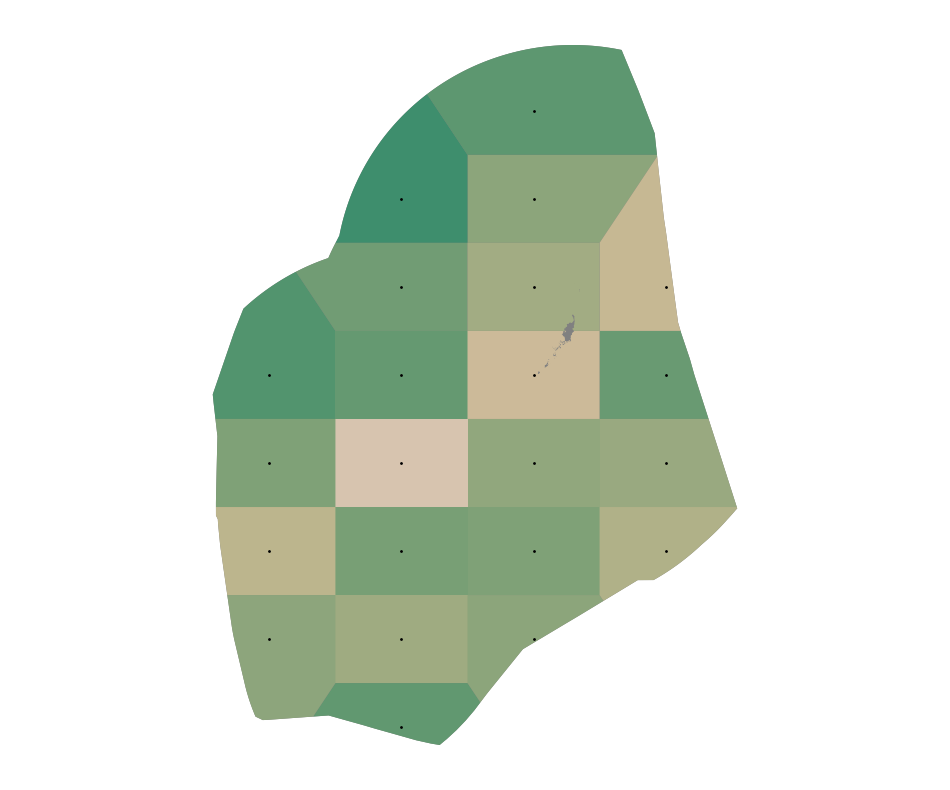

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2092_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


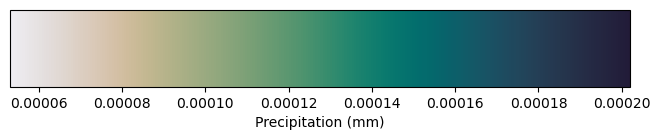

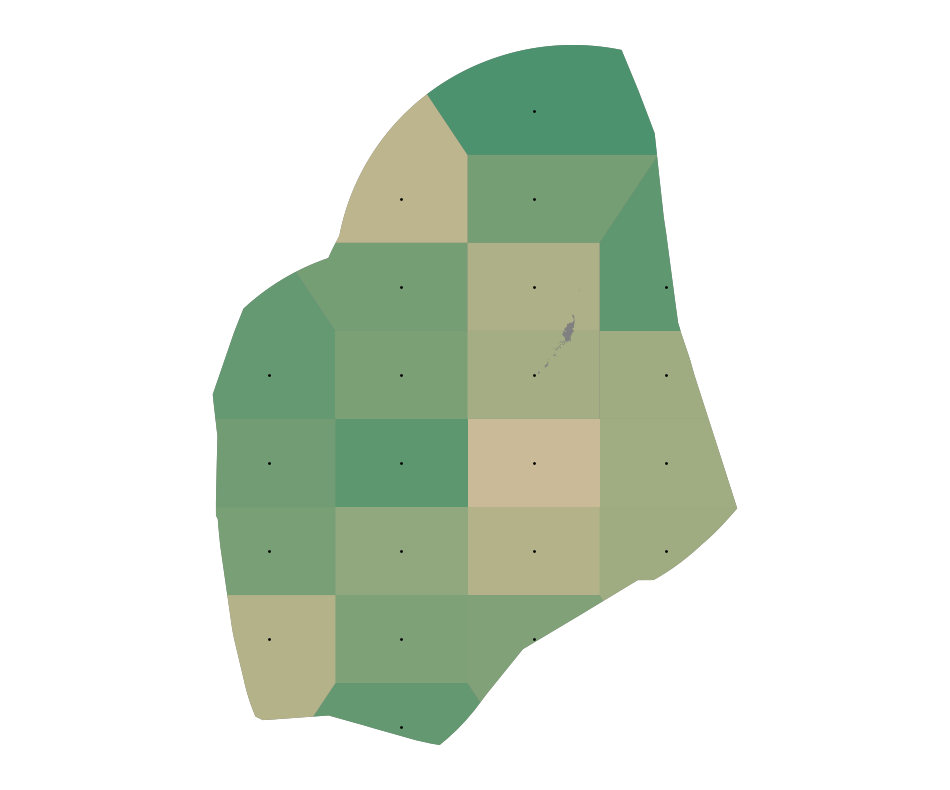

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2093_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


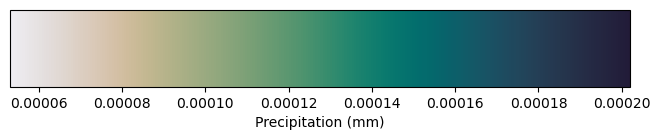

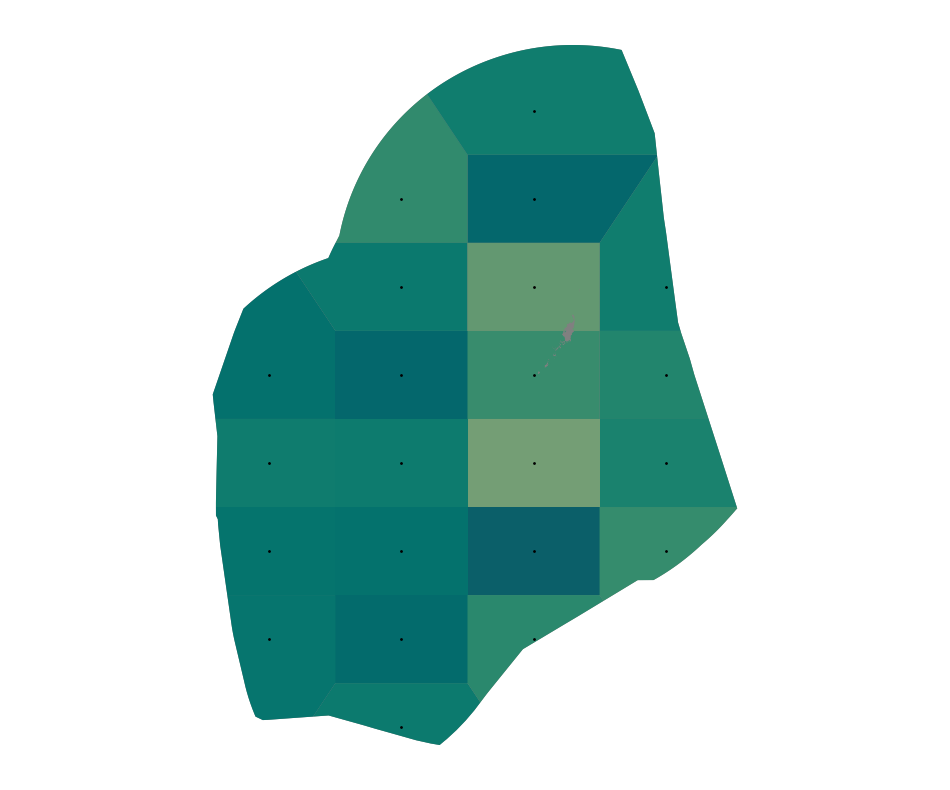

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2094_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


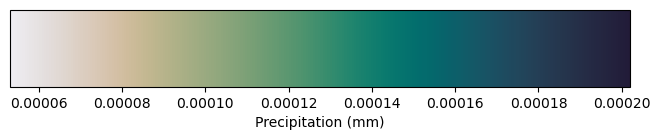

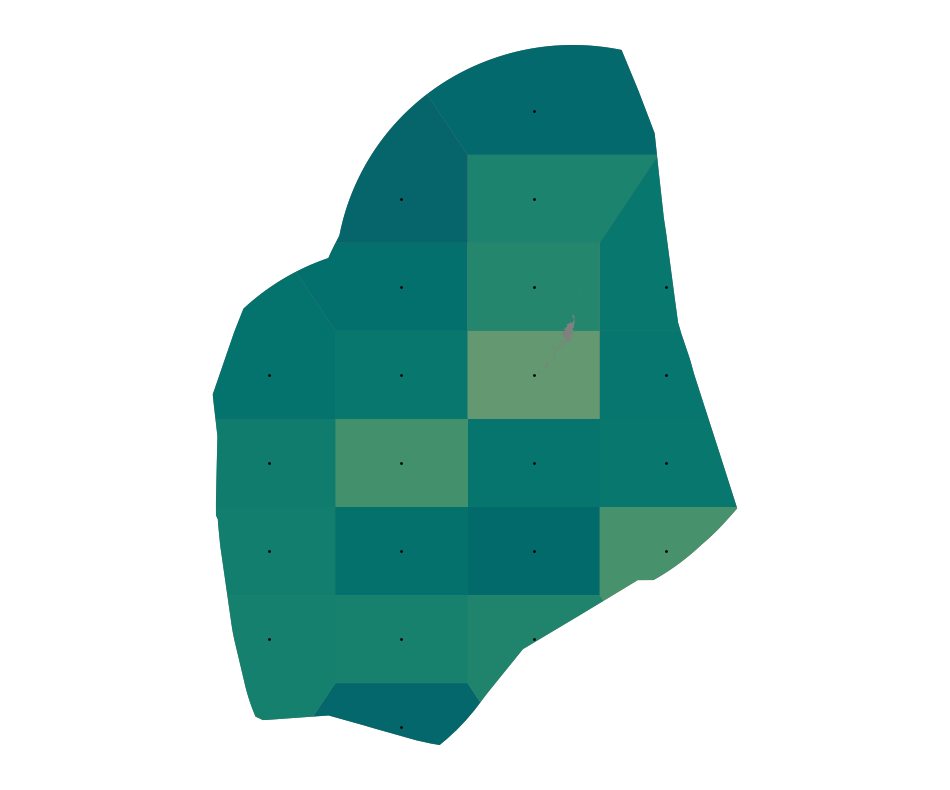

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2095_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


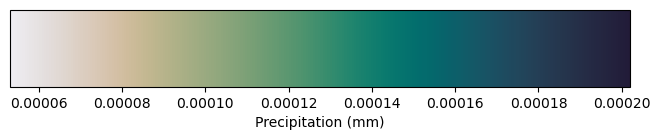

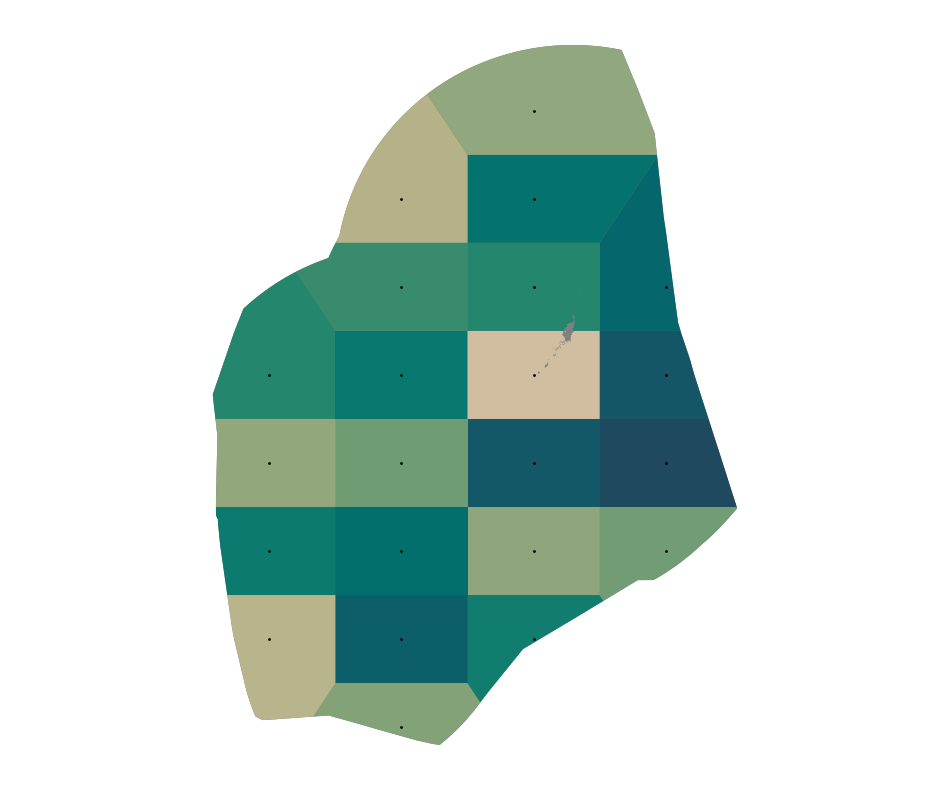

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2096_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


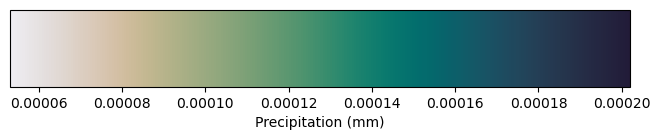

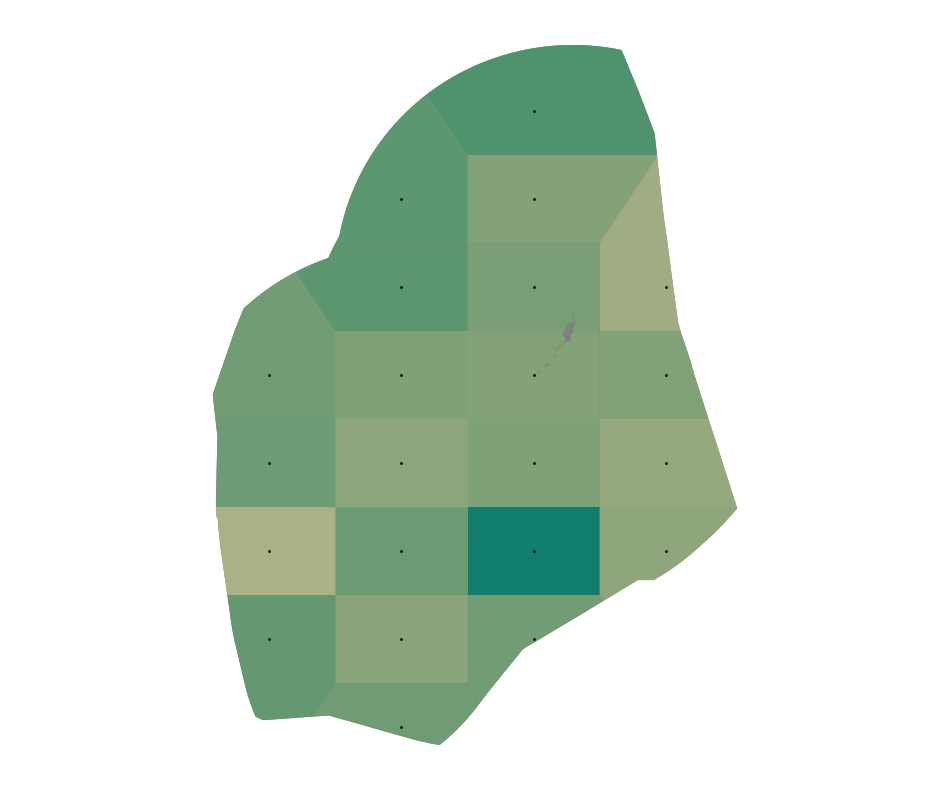

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2097_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


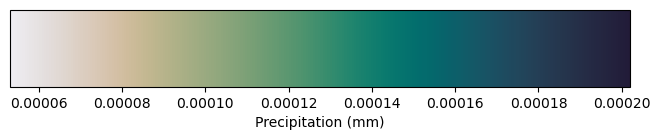

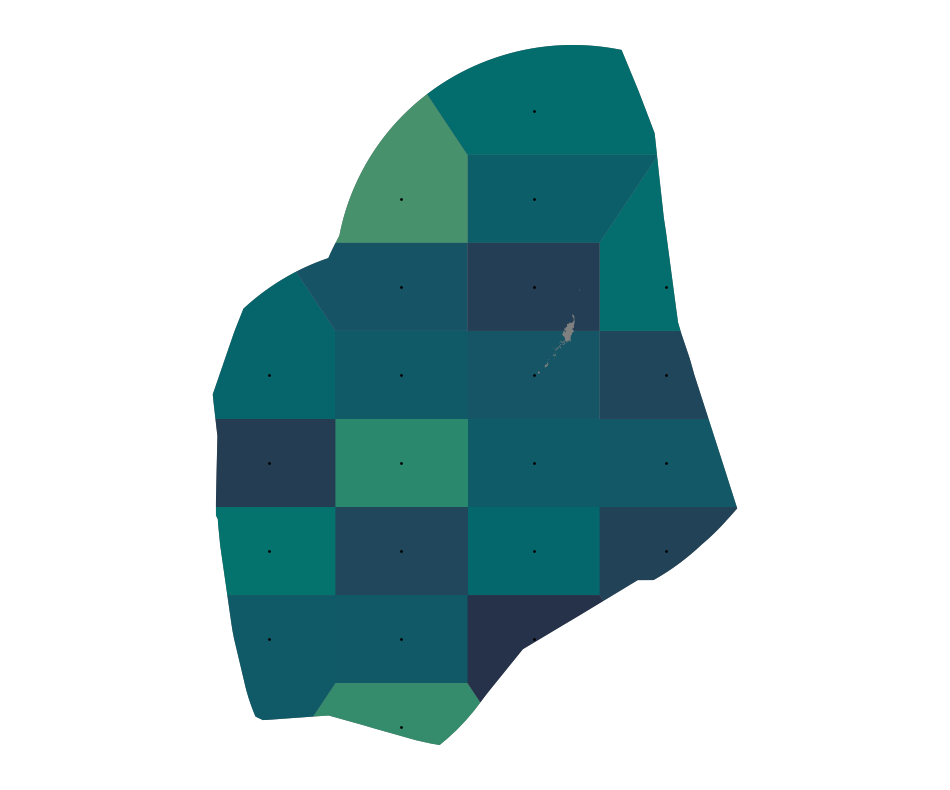

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2098_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


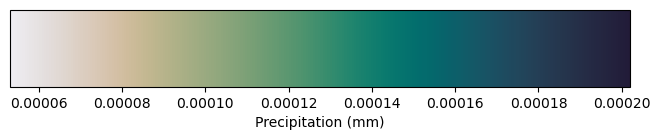

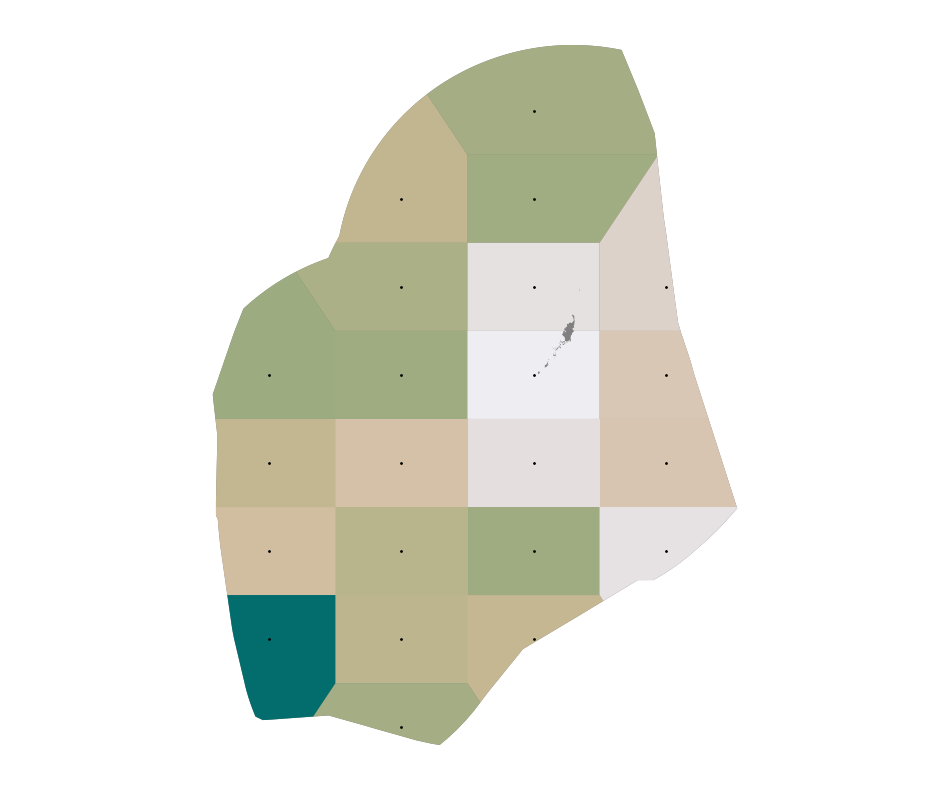

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2099_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


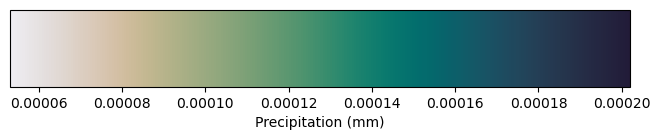

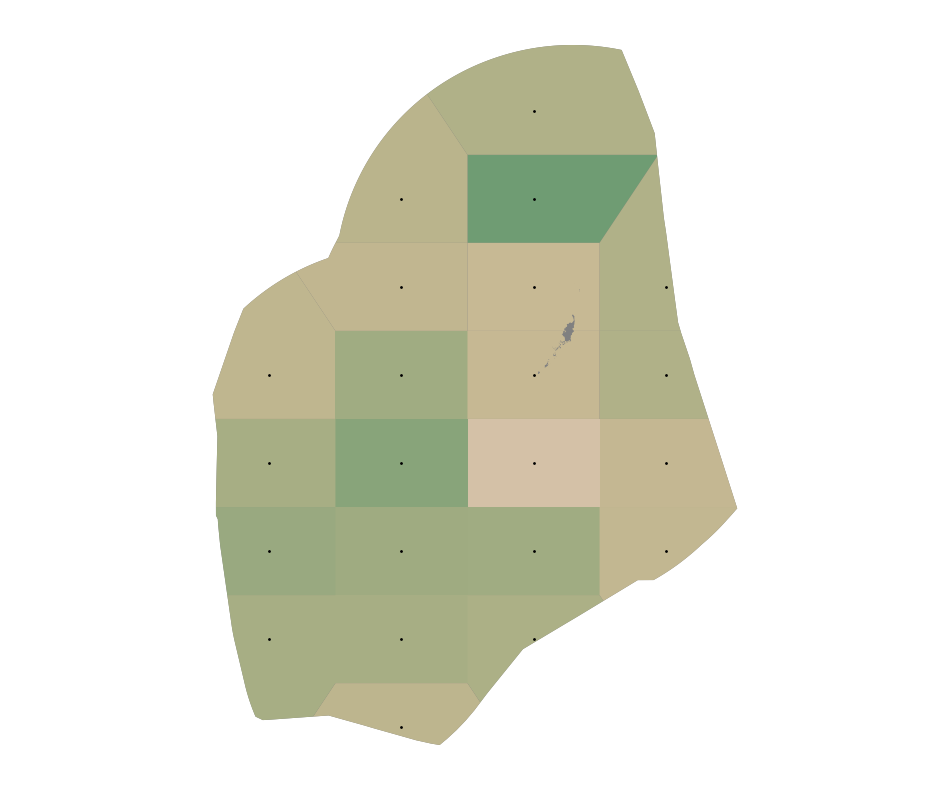

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1/2100_pr_Amon_KACE-1-0-G_ssp585_r2i1p1f1.json
KACE-1-0-G ssp245
latlon_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1_.pkl
Created: 2015-2100_pr_colorbar_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.png


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


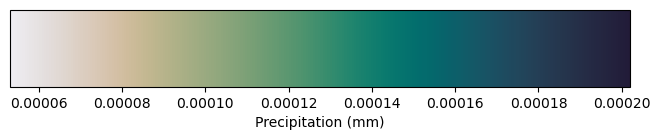

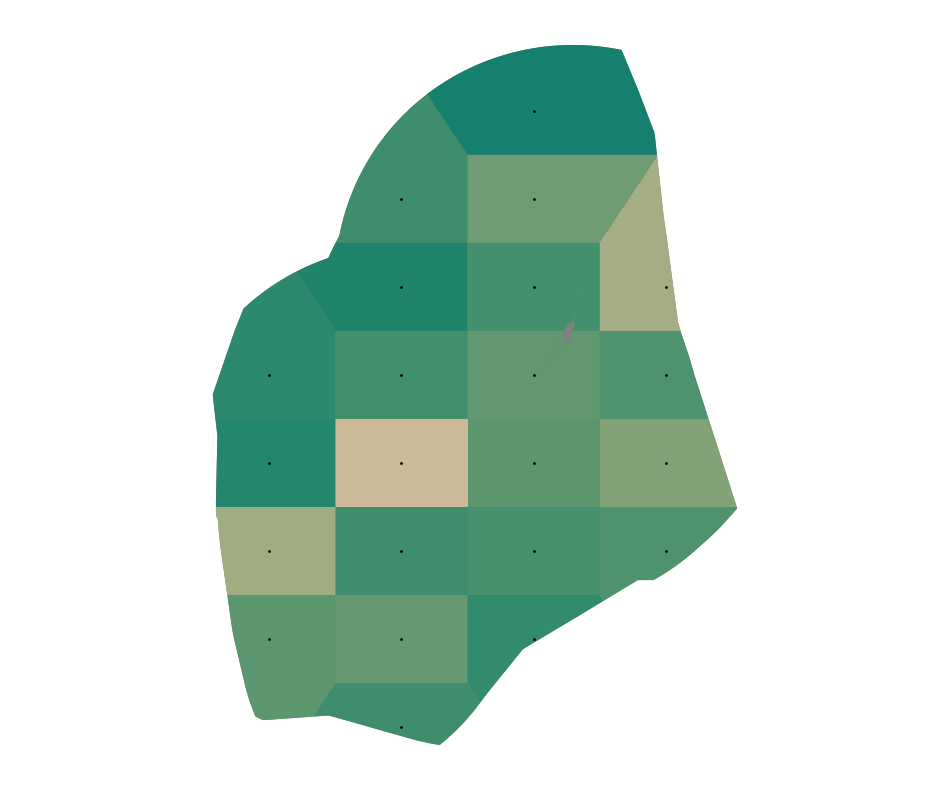

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2015_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


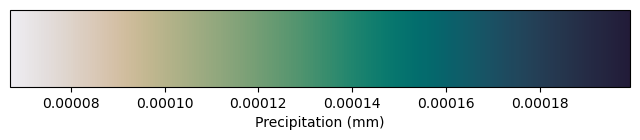

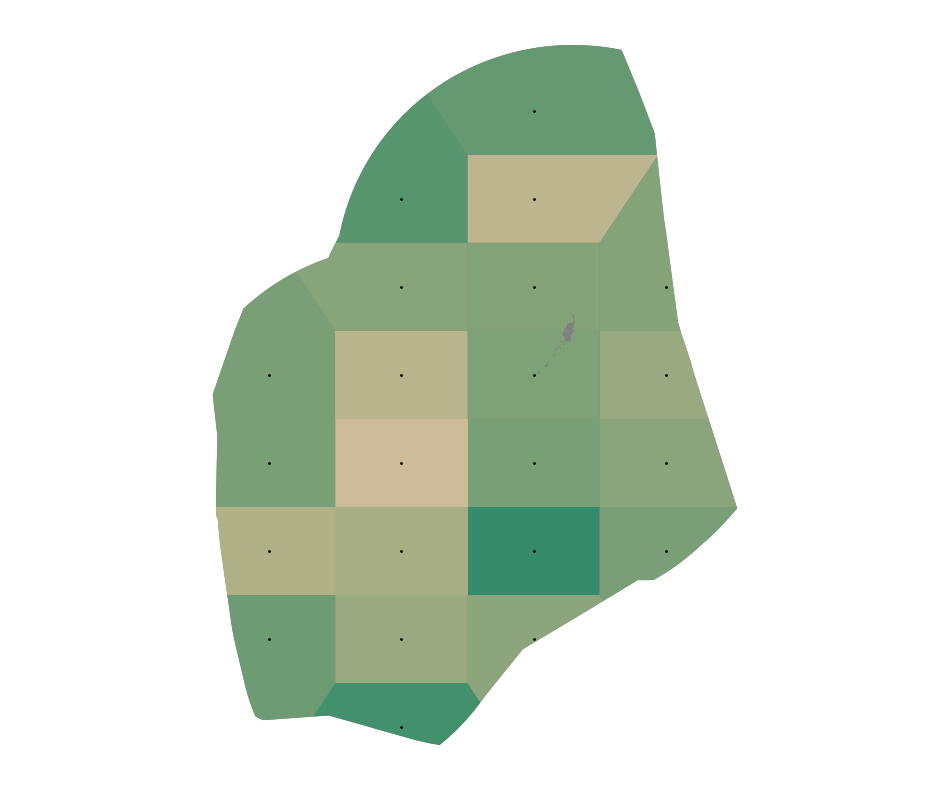

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2016_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


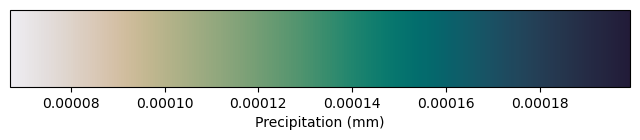

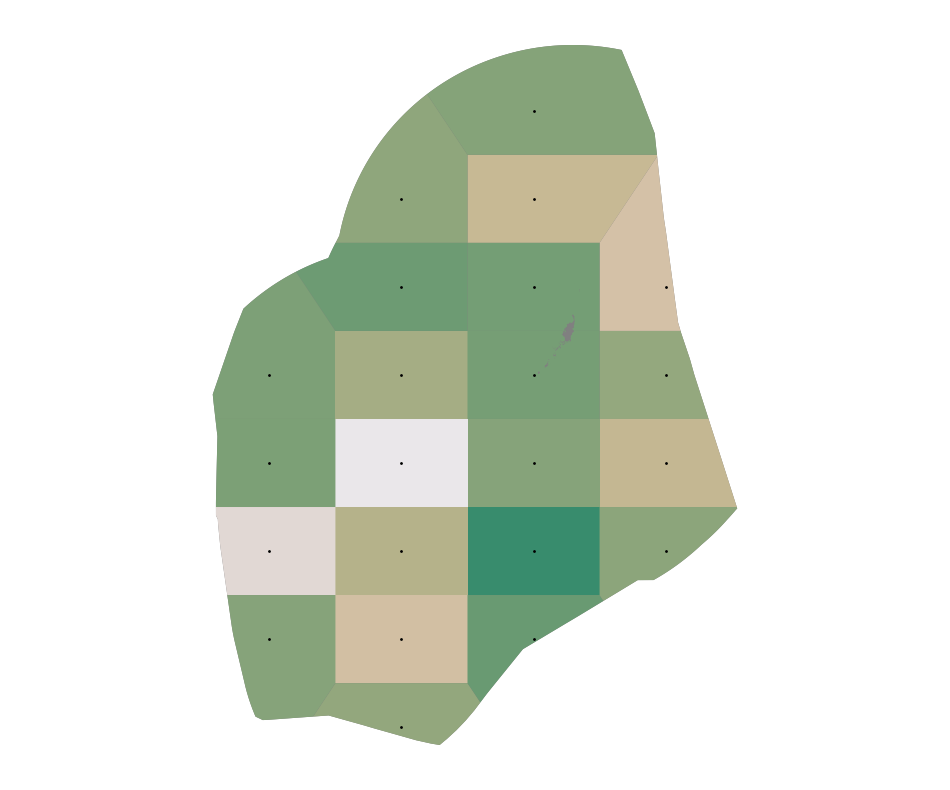

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2017_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


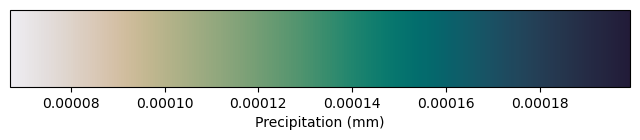

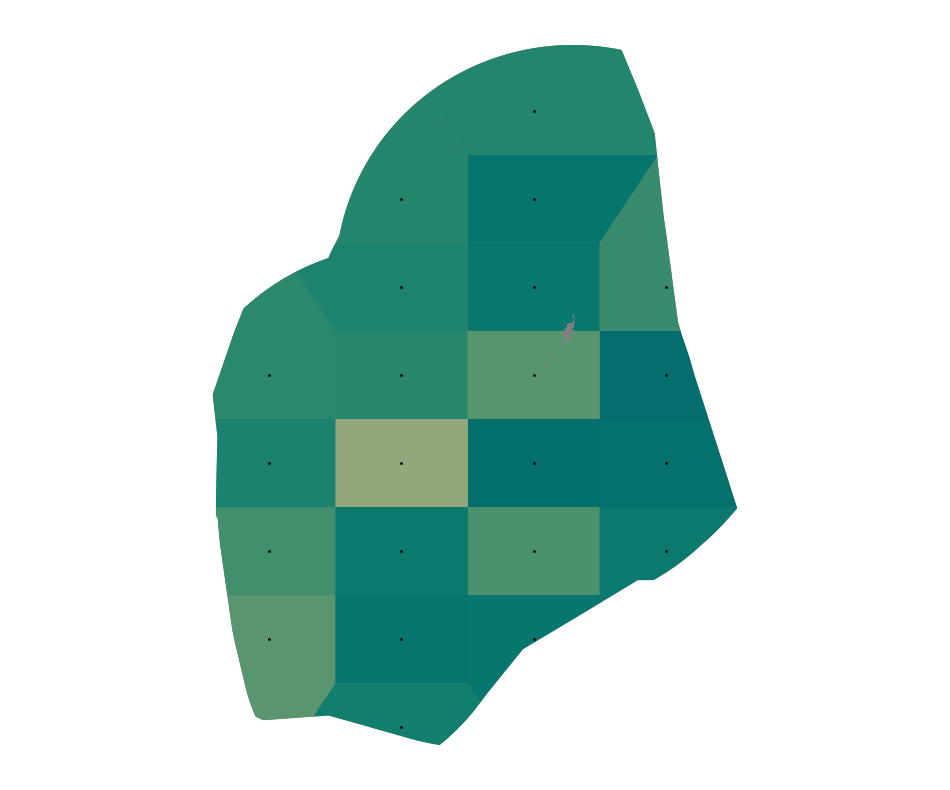

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2018_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


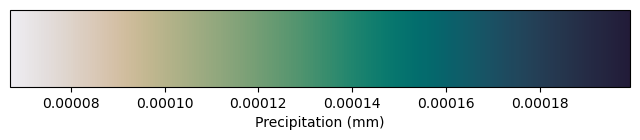

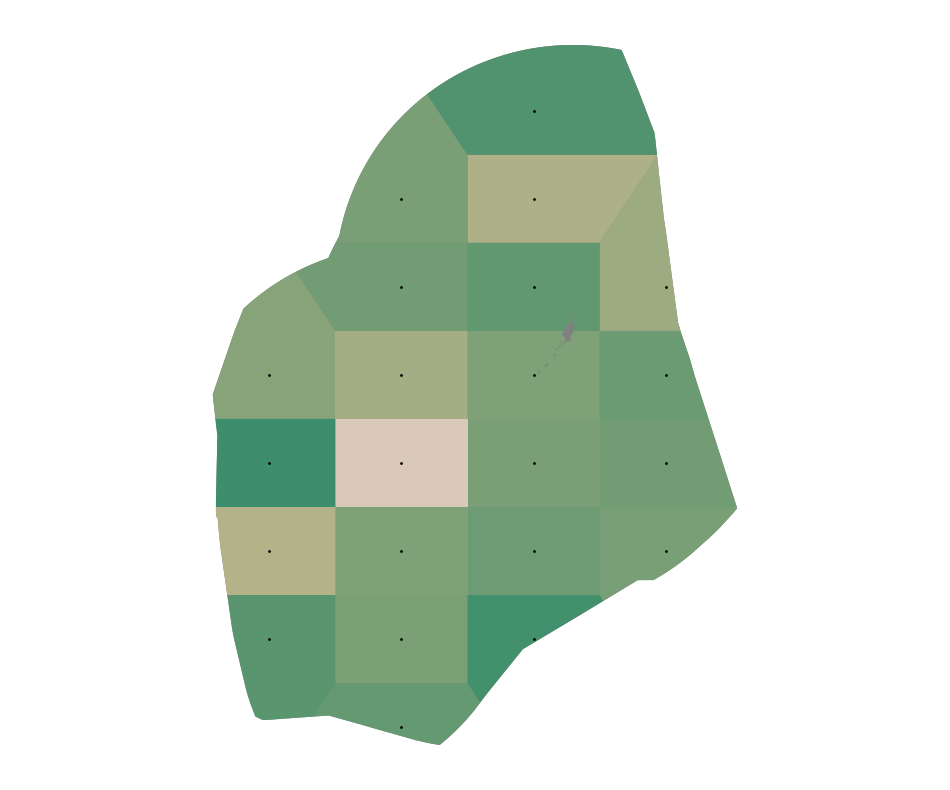

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2019_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


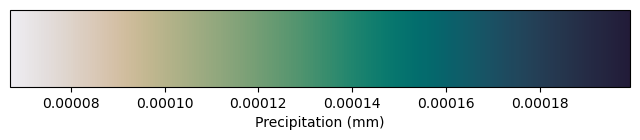

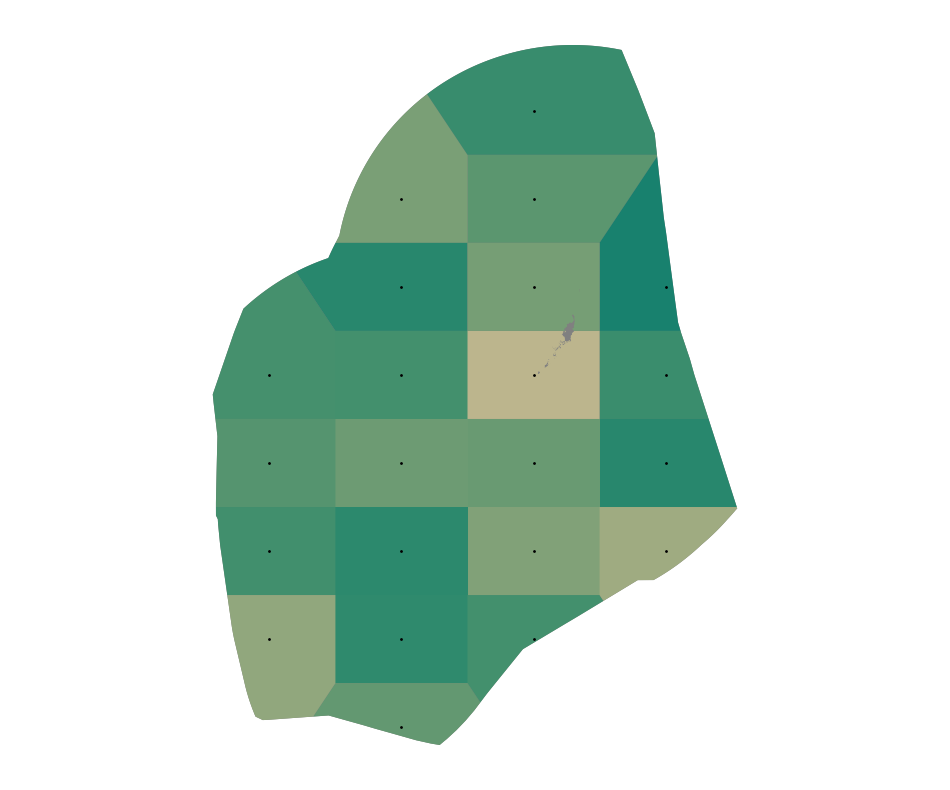

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2020_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


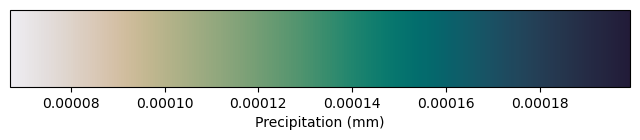

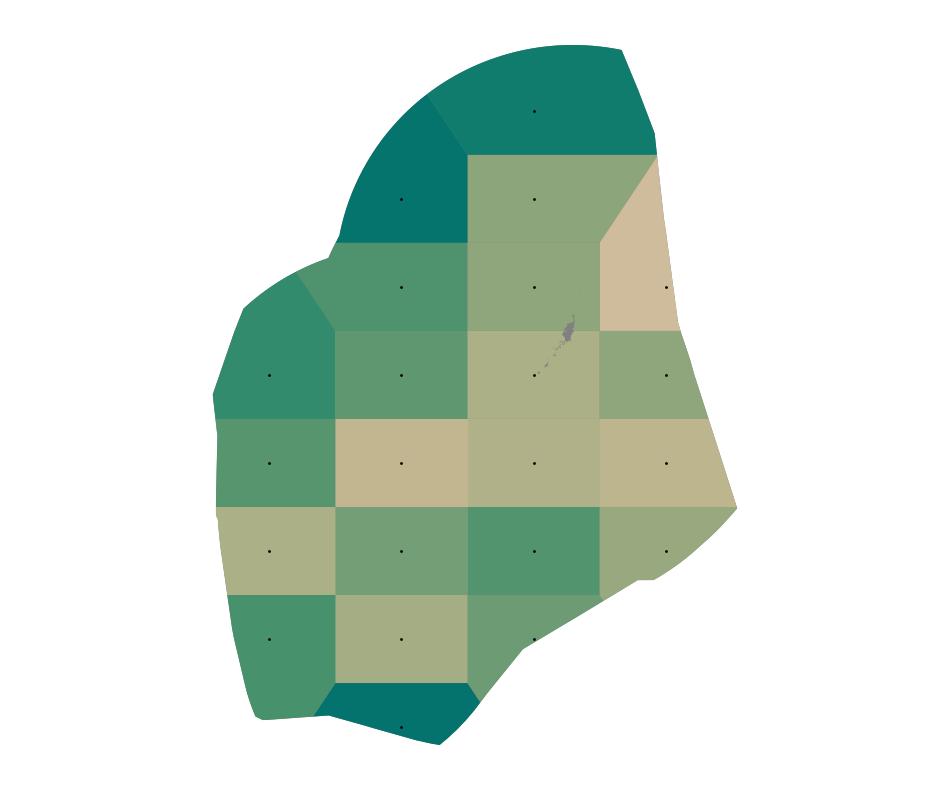

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2021_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


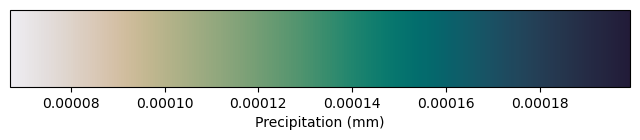

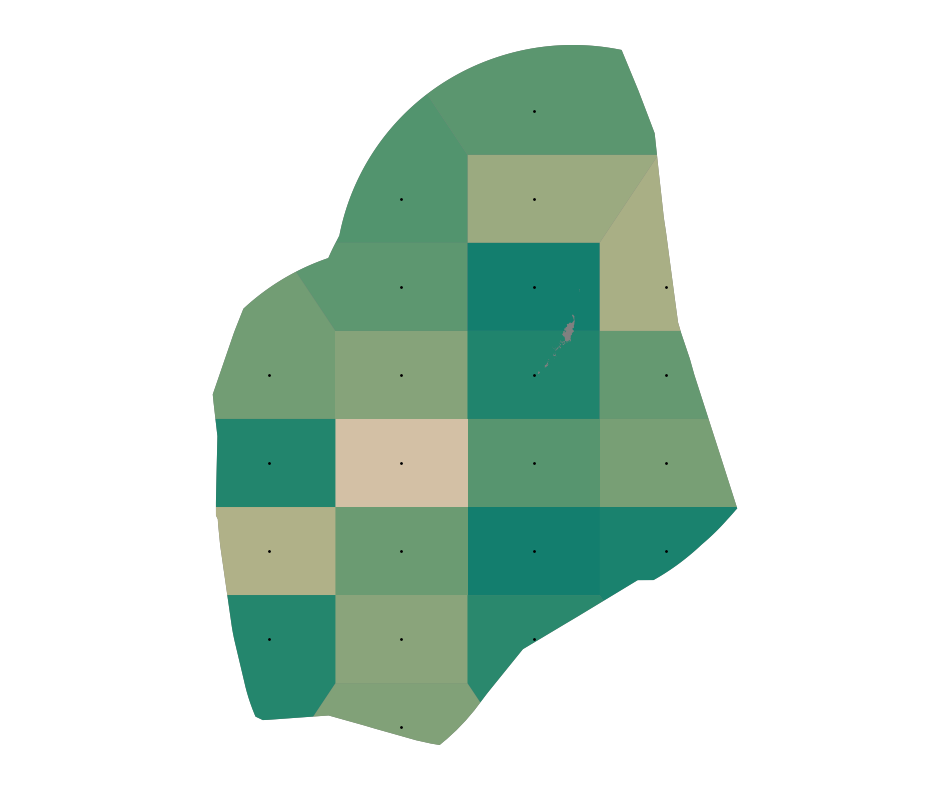

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2022_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


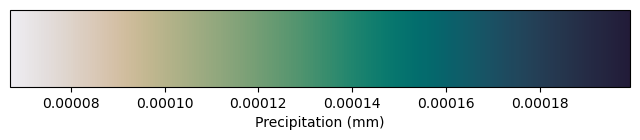

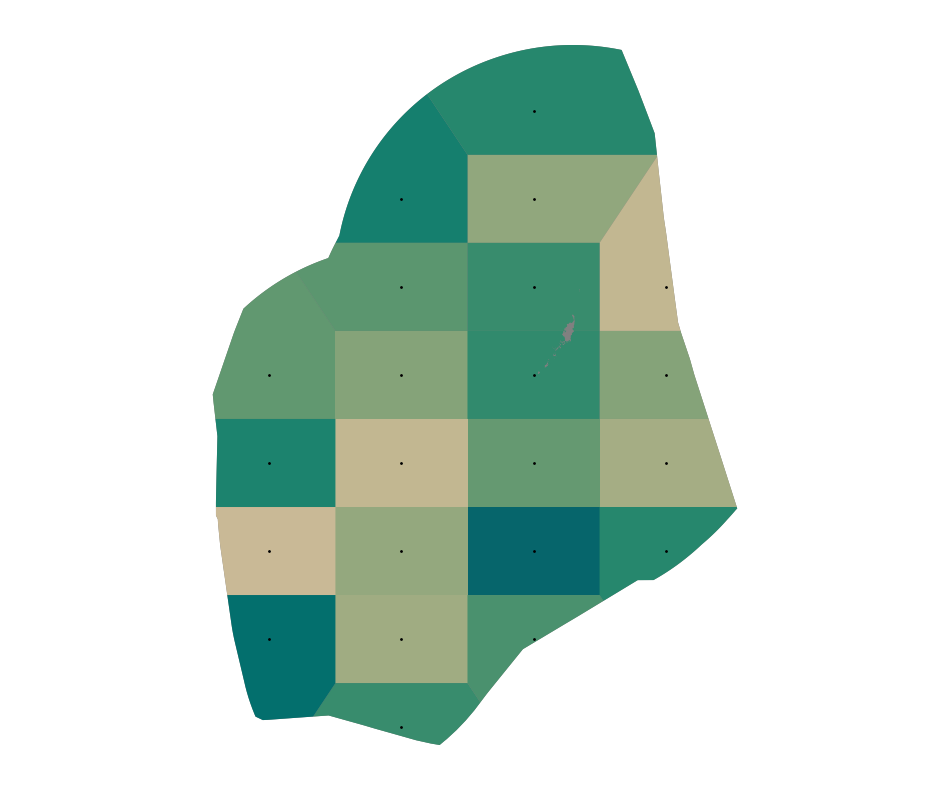

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2023_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


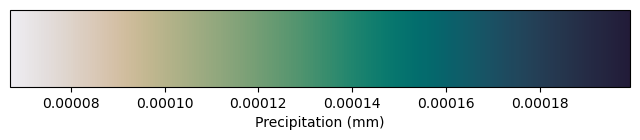

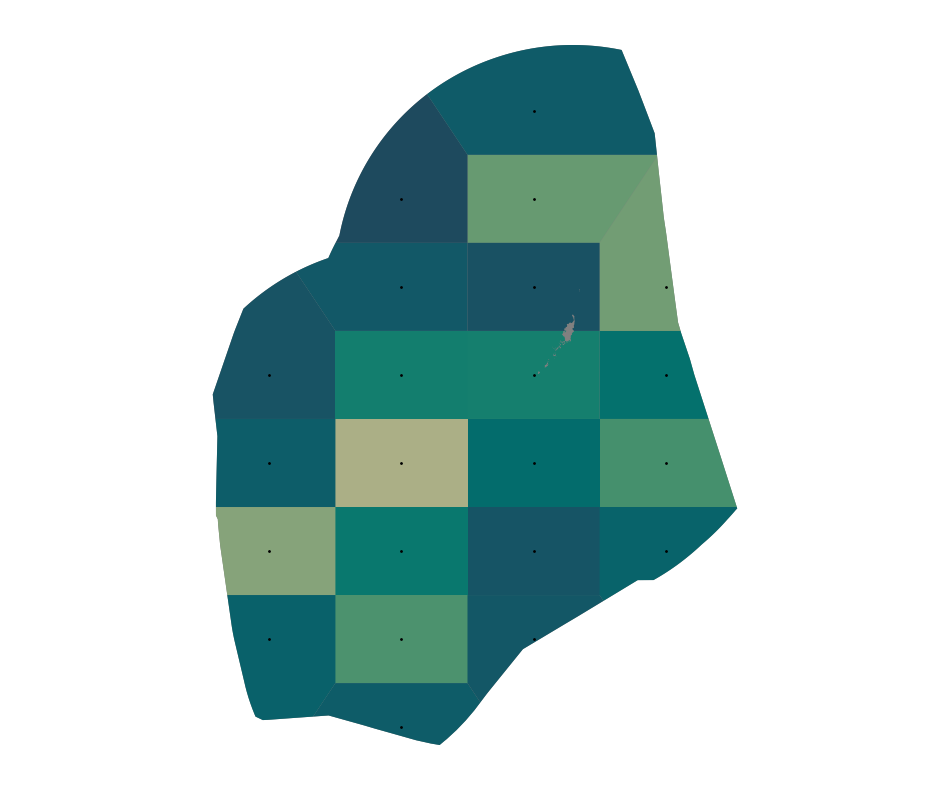

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2024_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


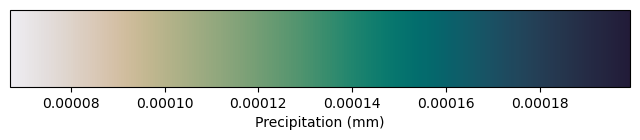

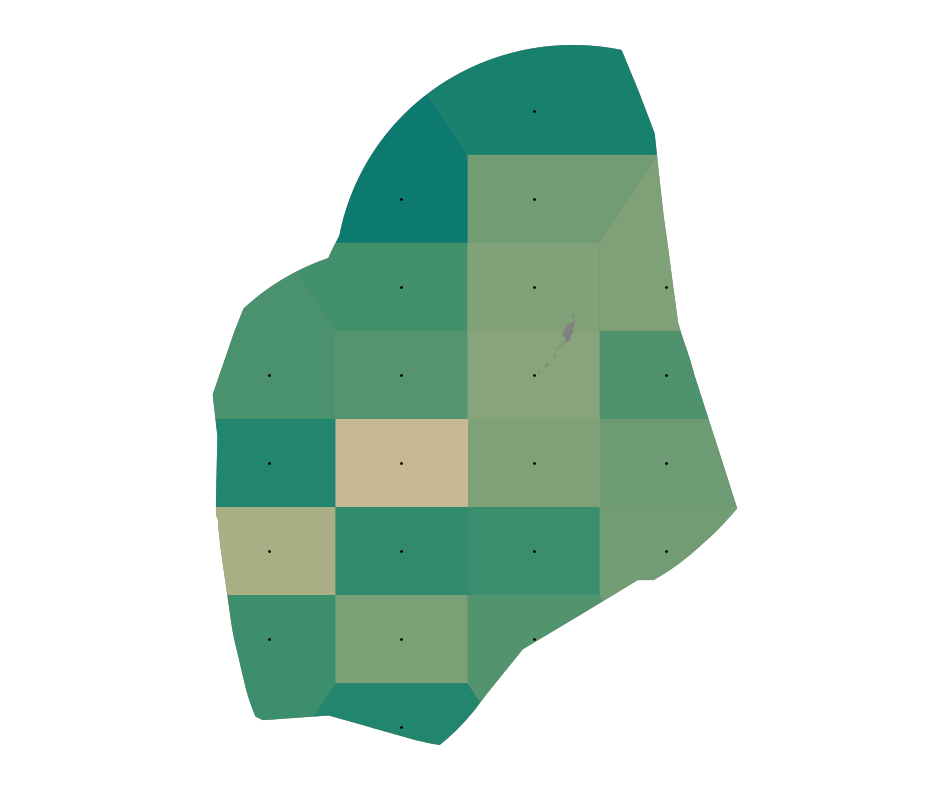

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2025_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


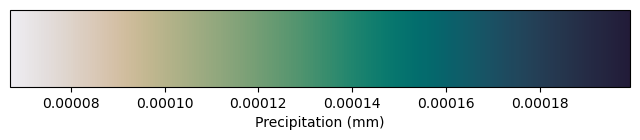

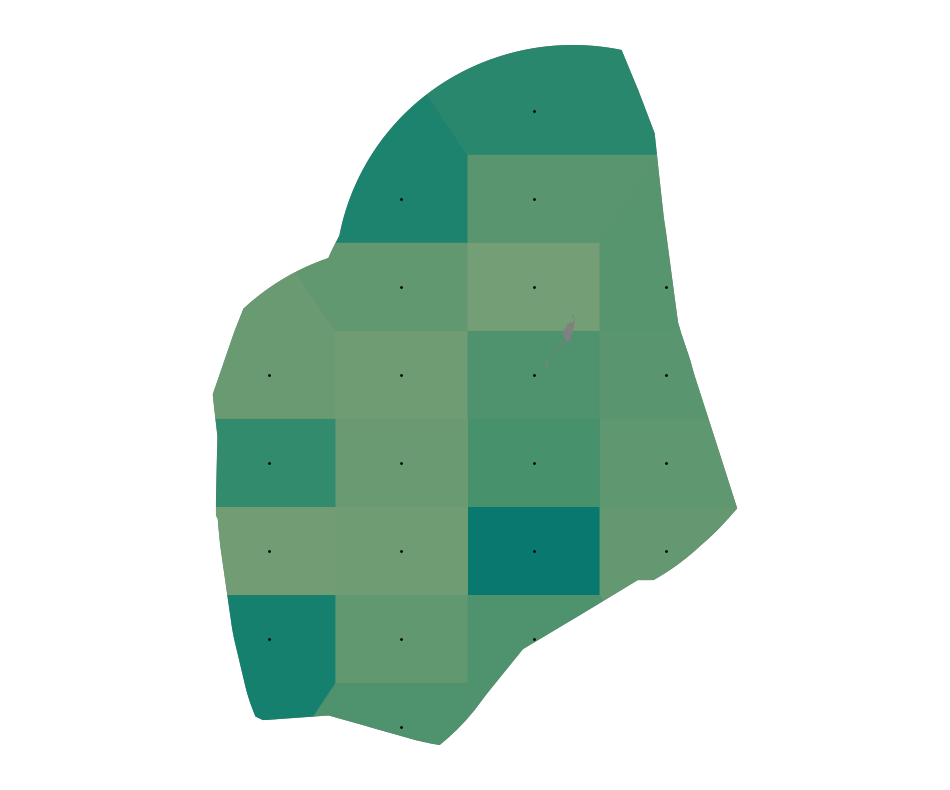

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2026_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


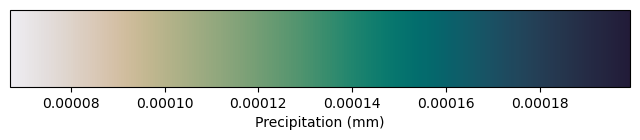

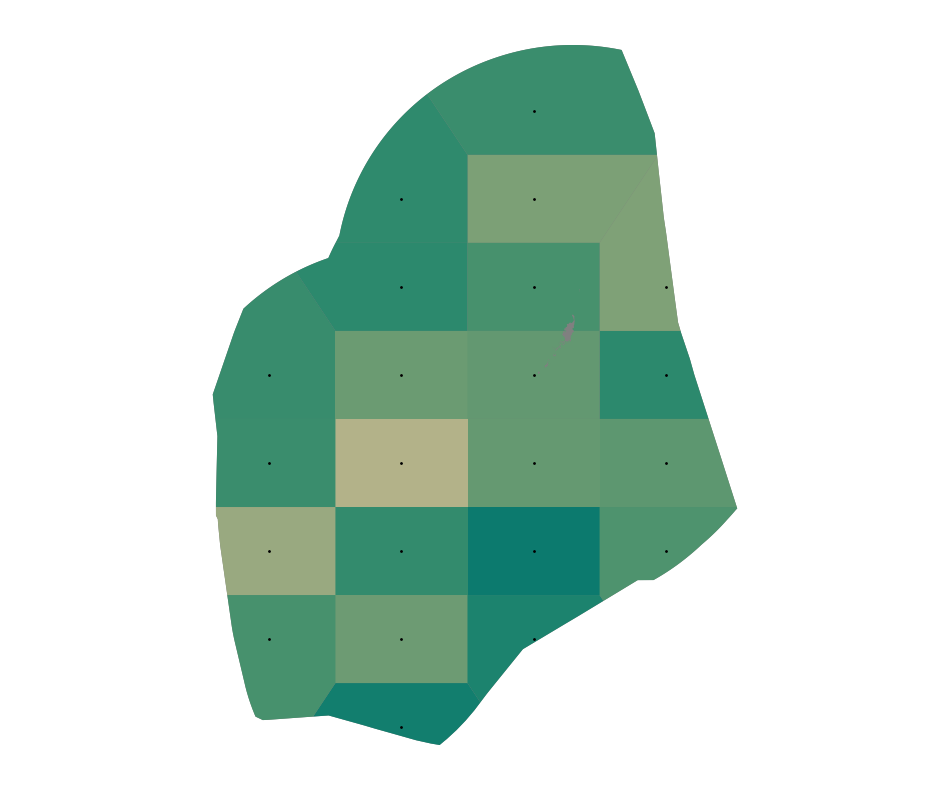

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2027_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


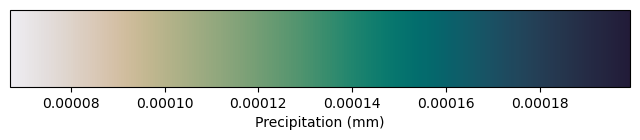

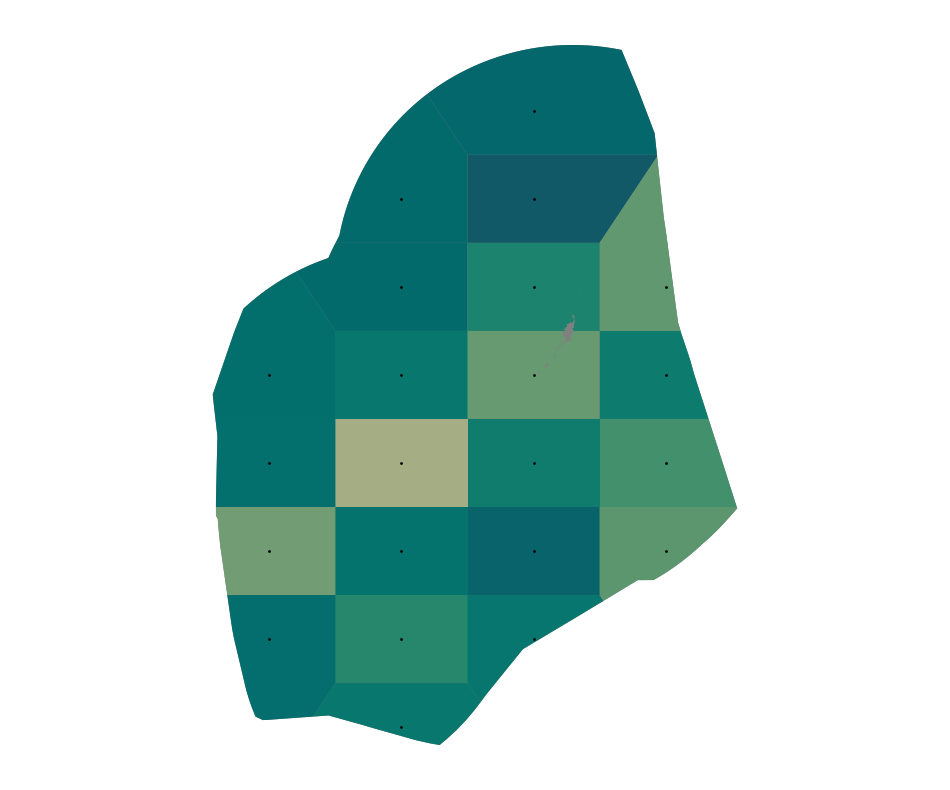

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2028_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


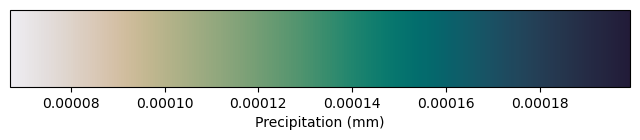

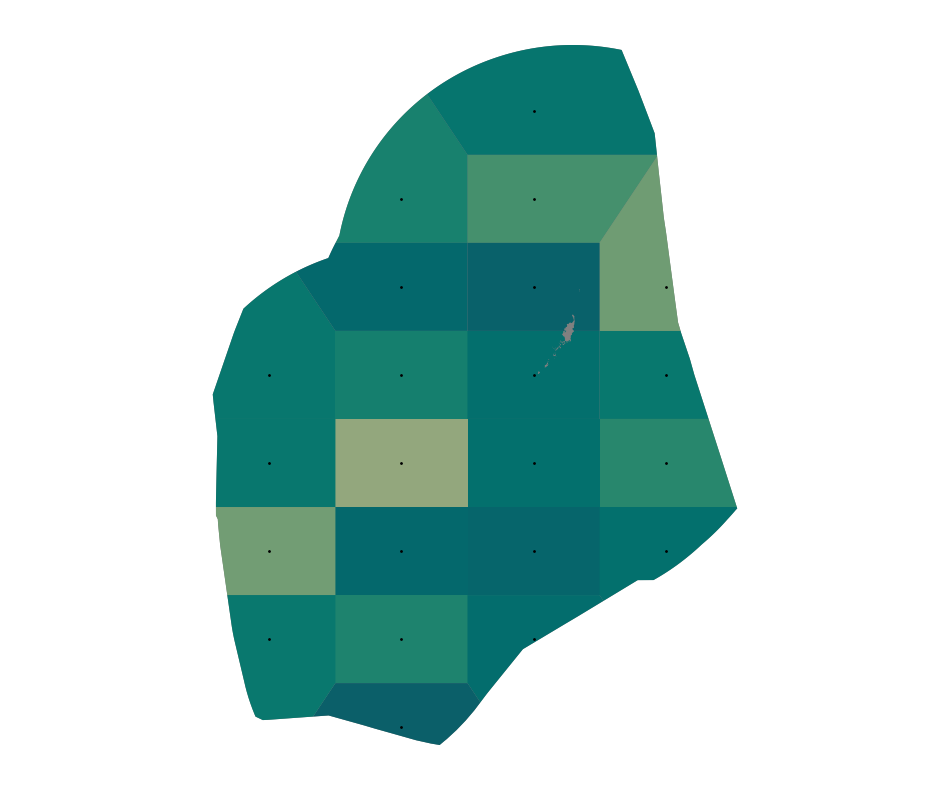

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2029_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


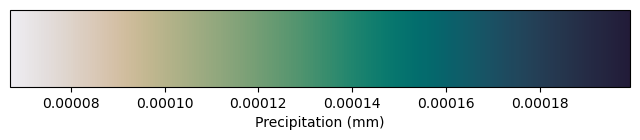

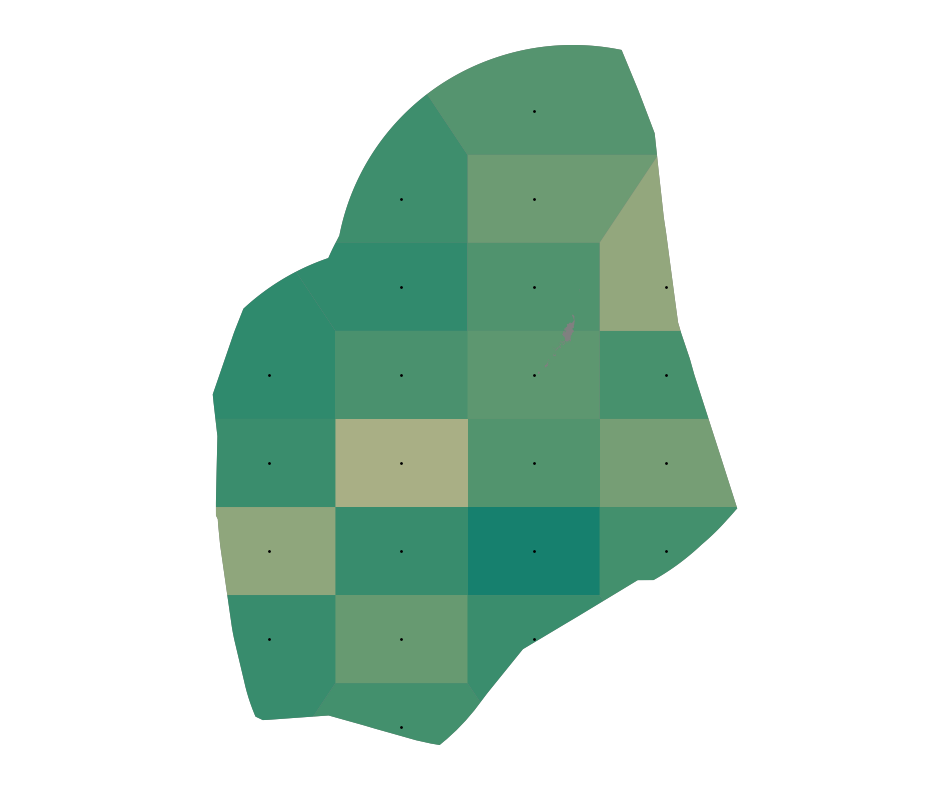

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2030_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


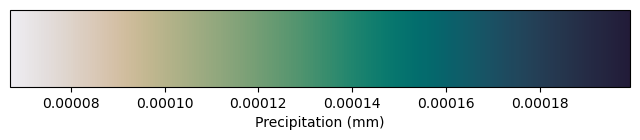

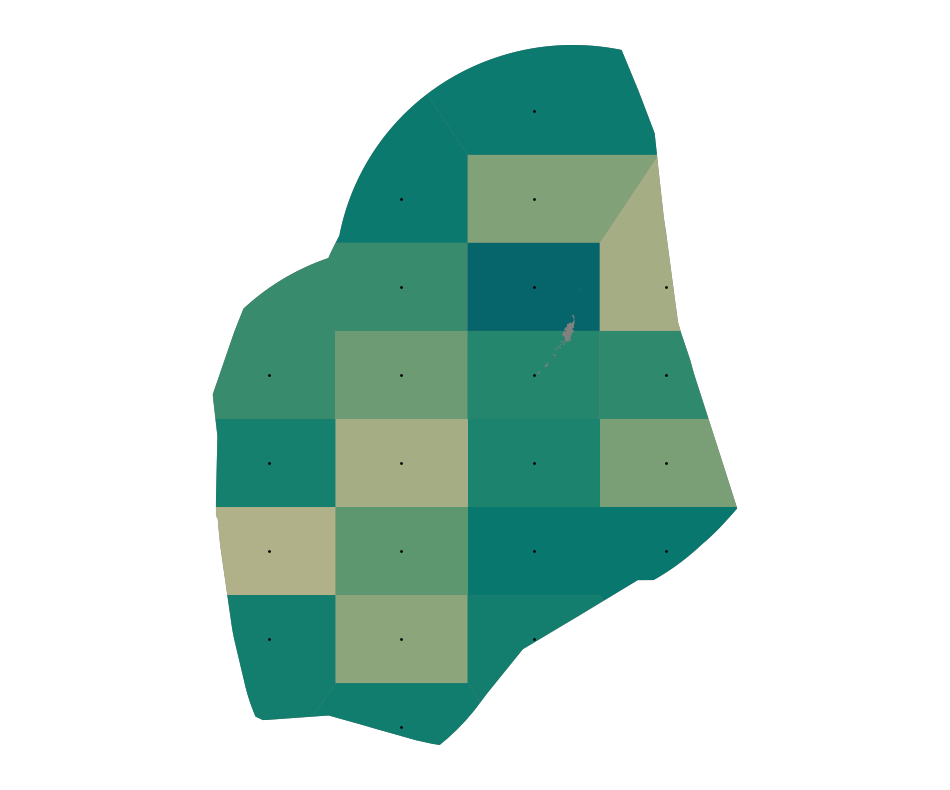

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2031_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


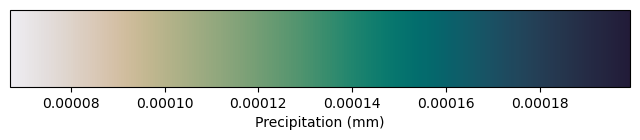

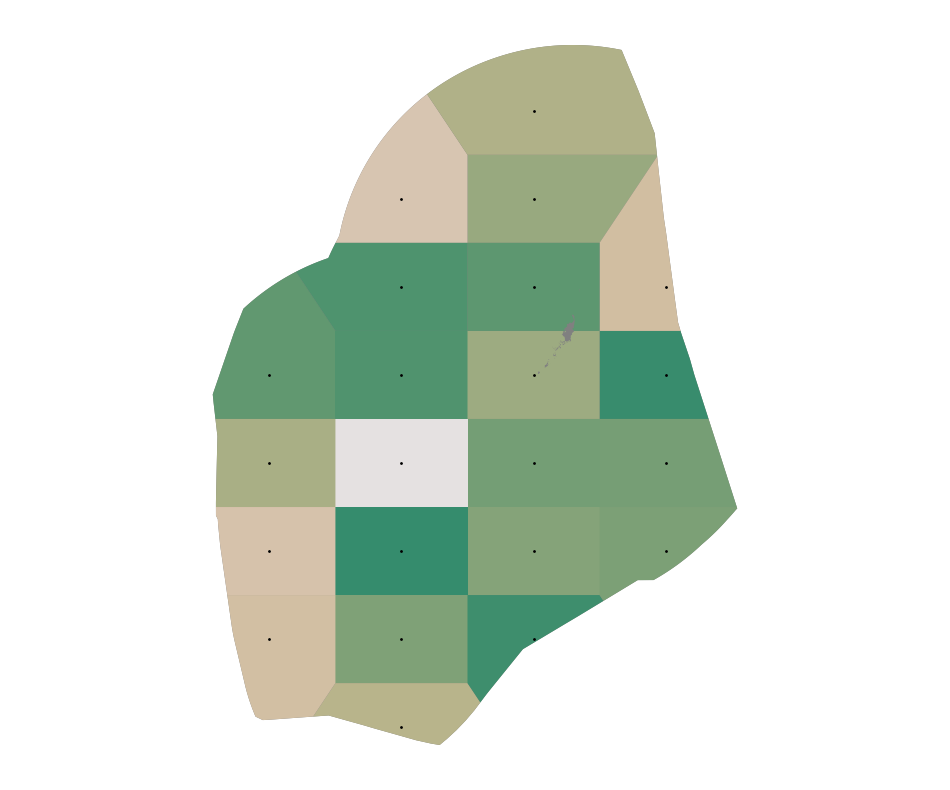

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2032_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


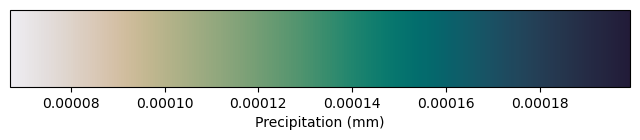

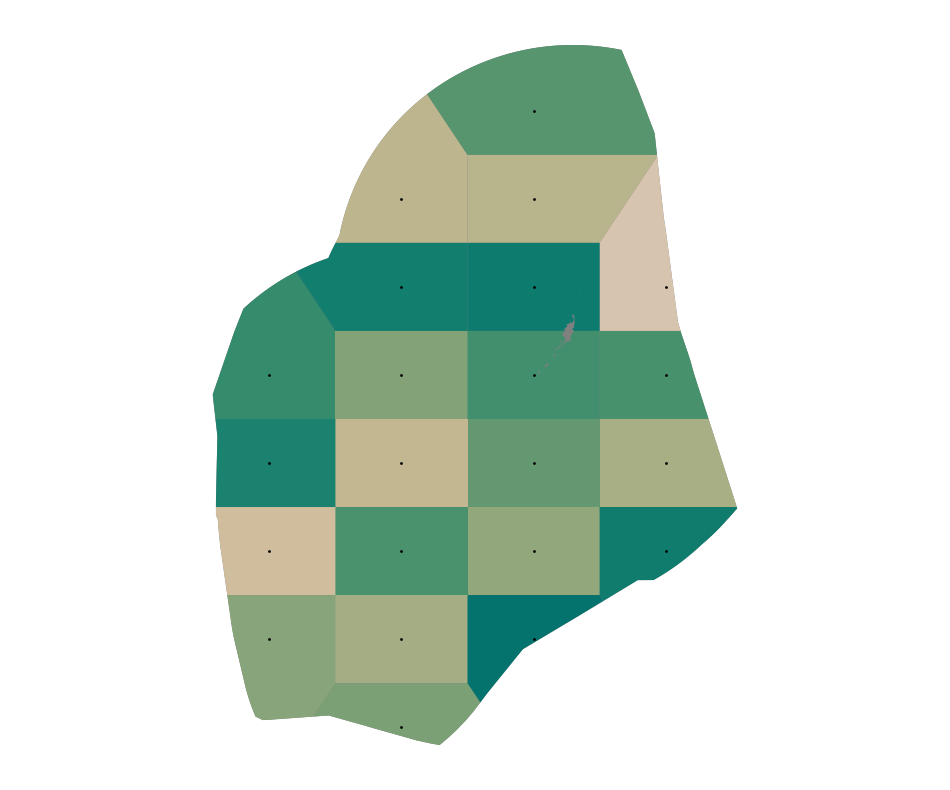

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2033_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


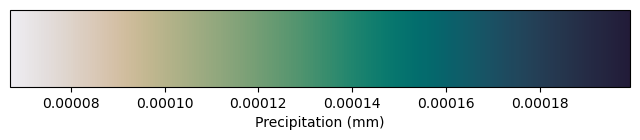

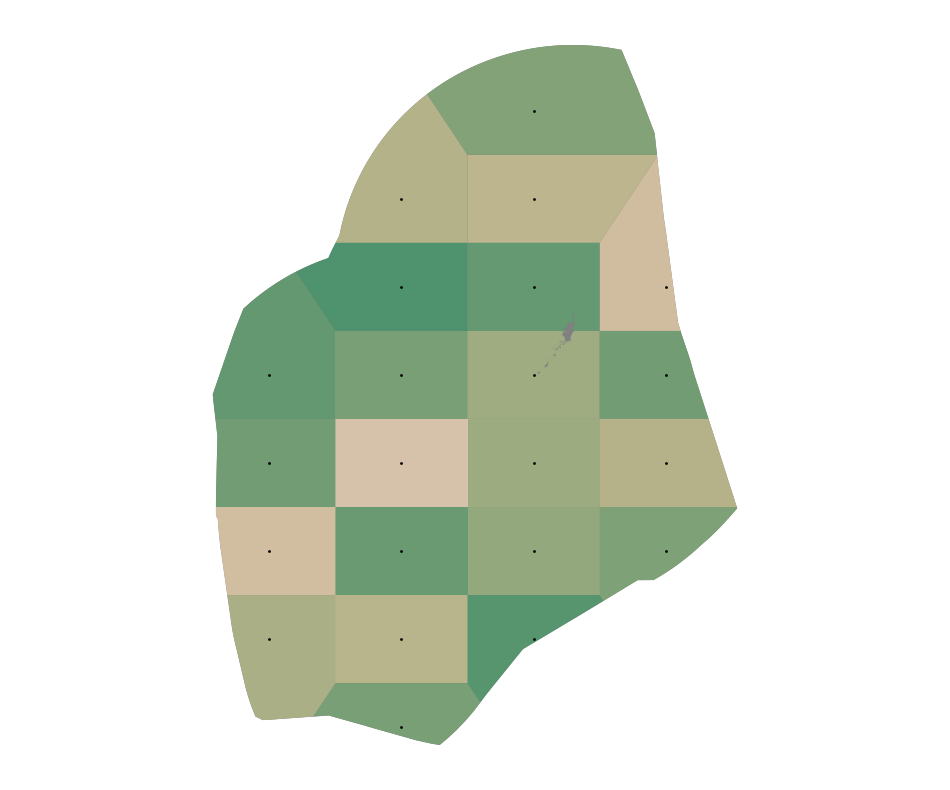

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2034_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


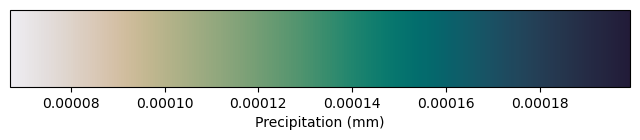

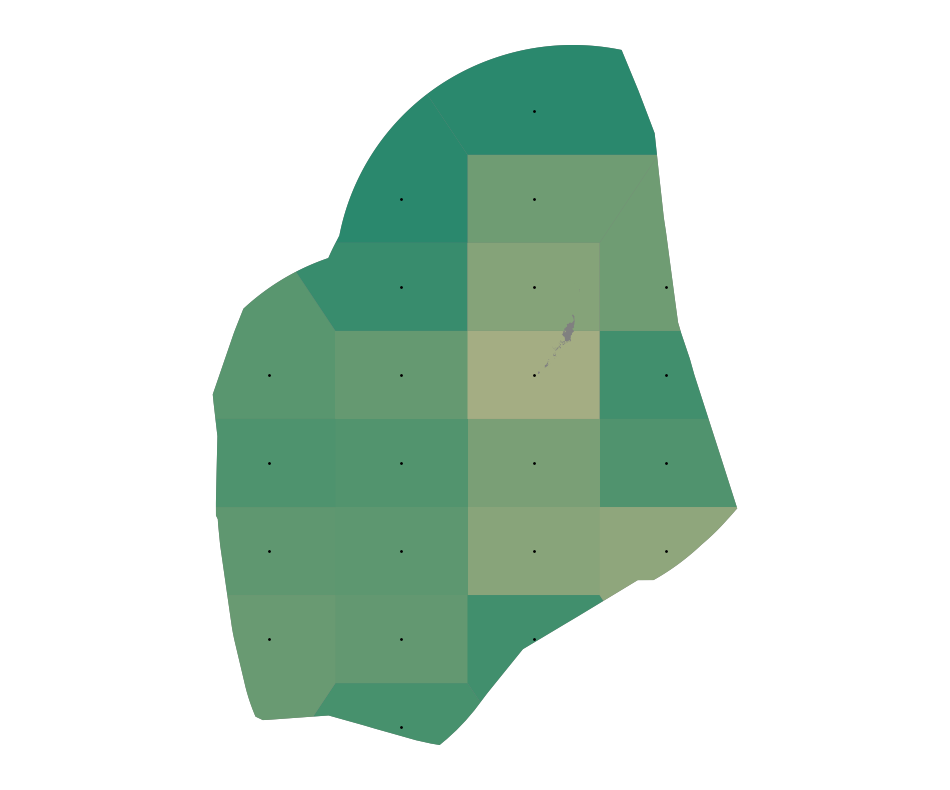

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2035_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


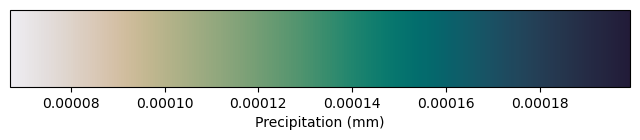

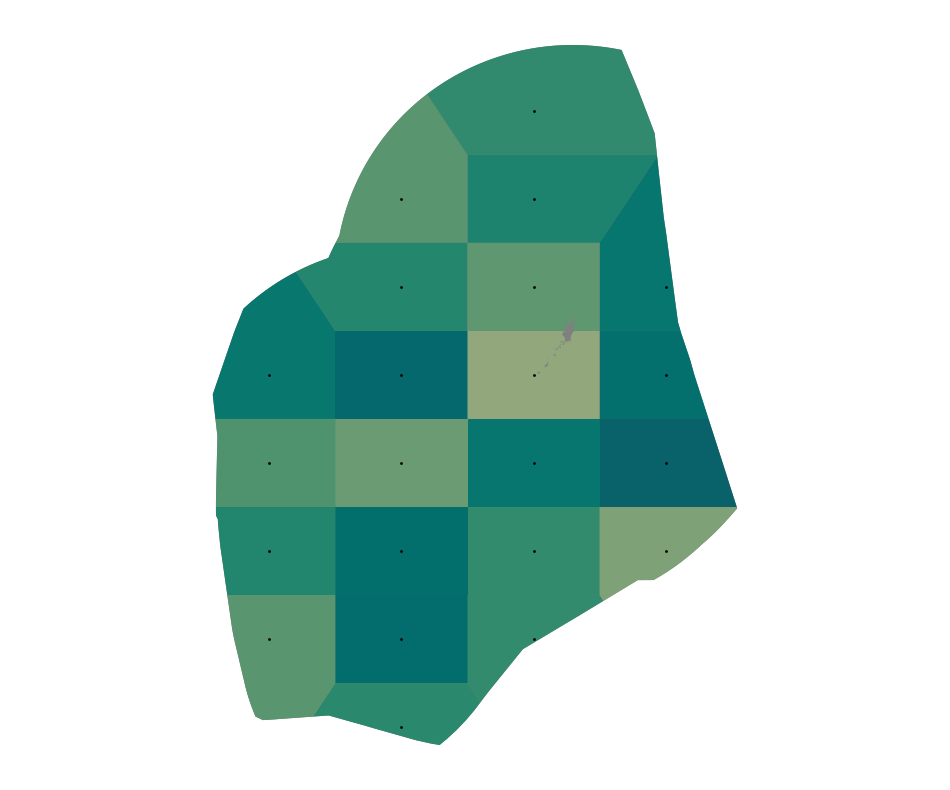

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2036_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


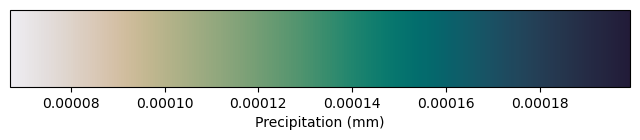

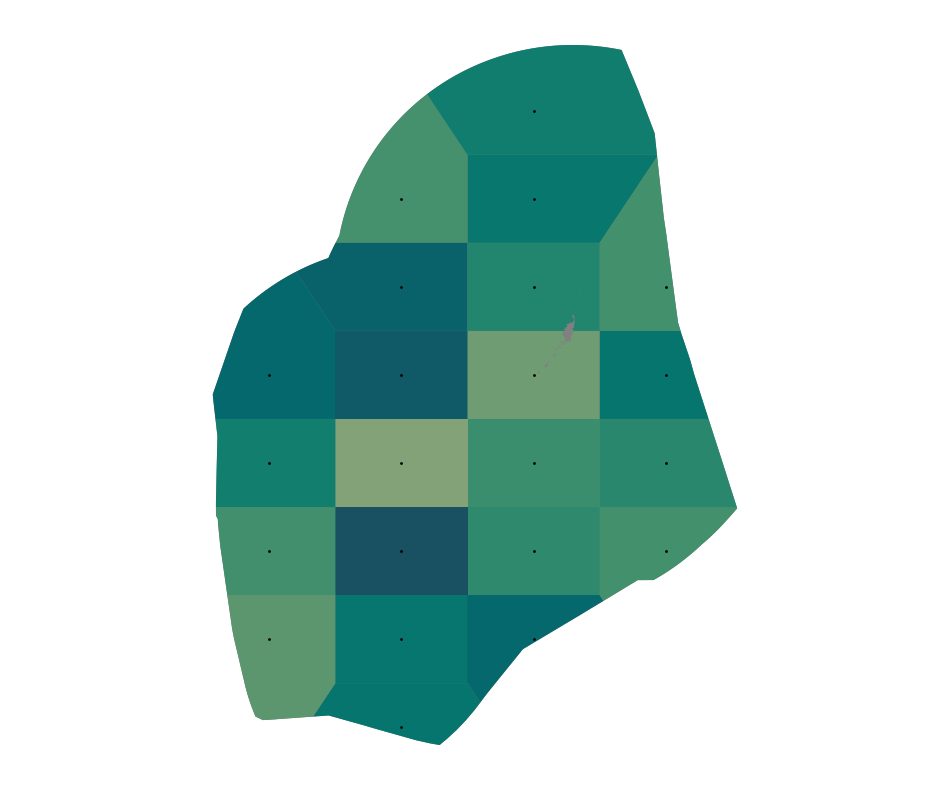

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2037_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


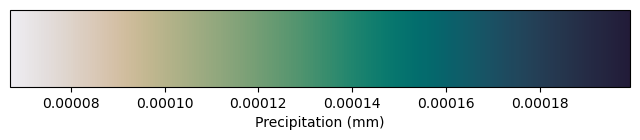

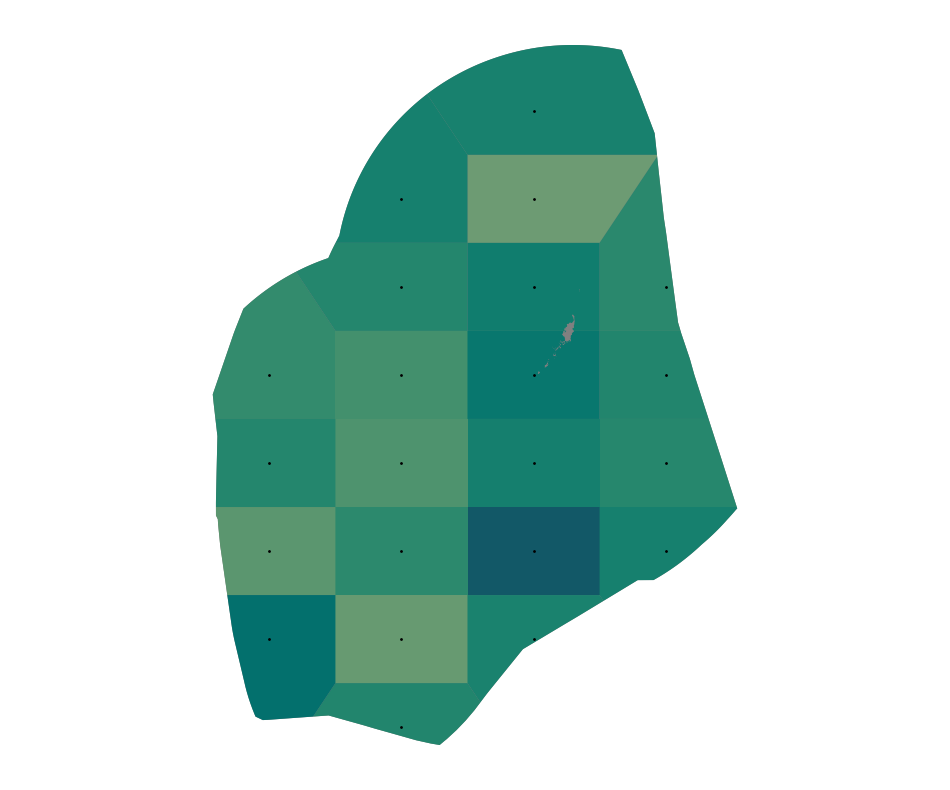

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2038_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


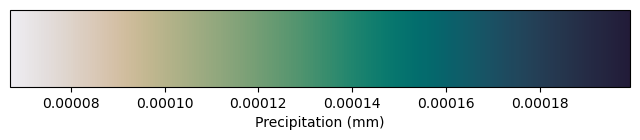

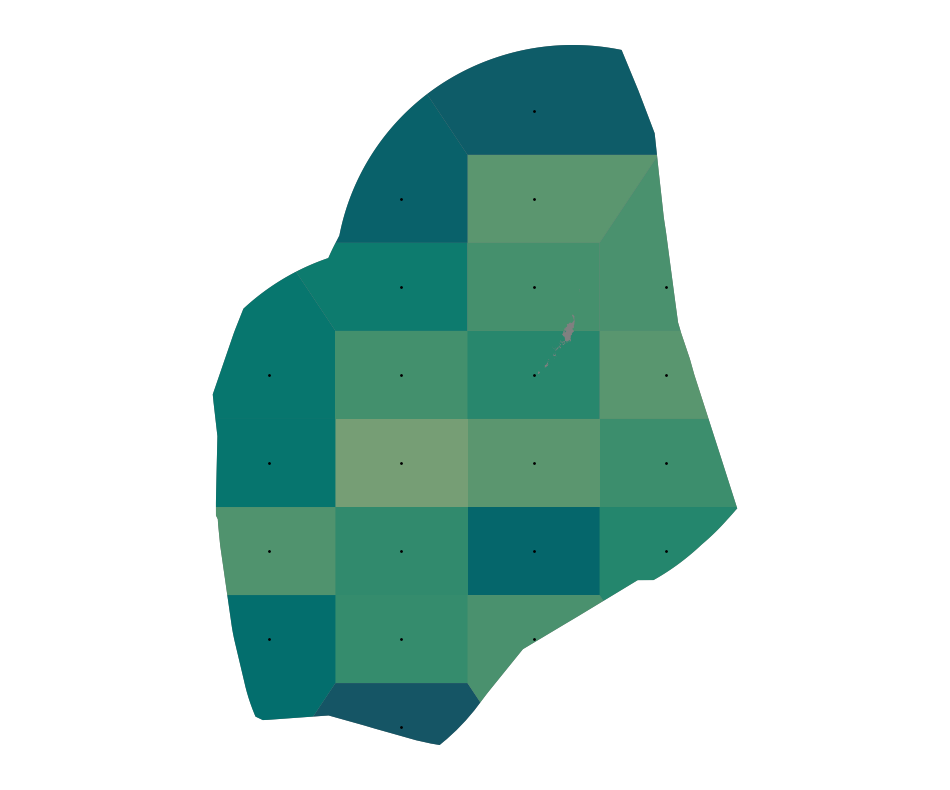

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2039_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


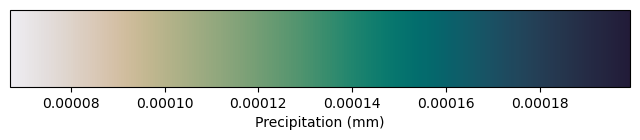

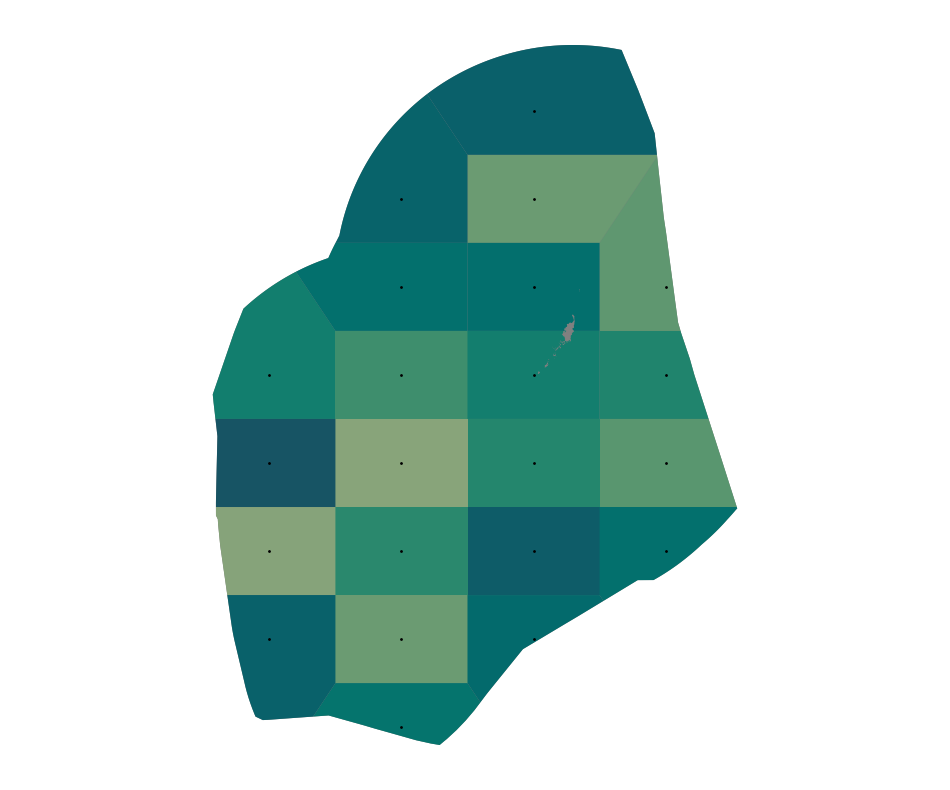

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2040_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


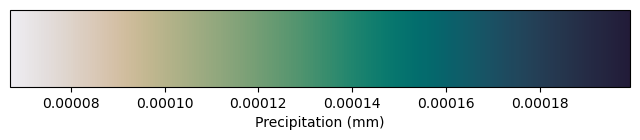

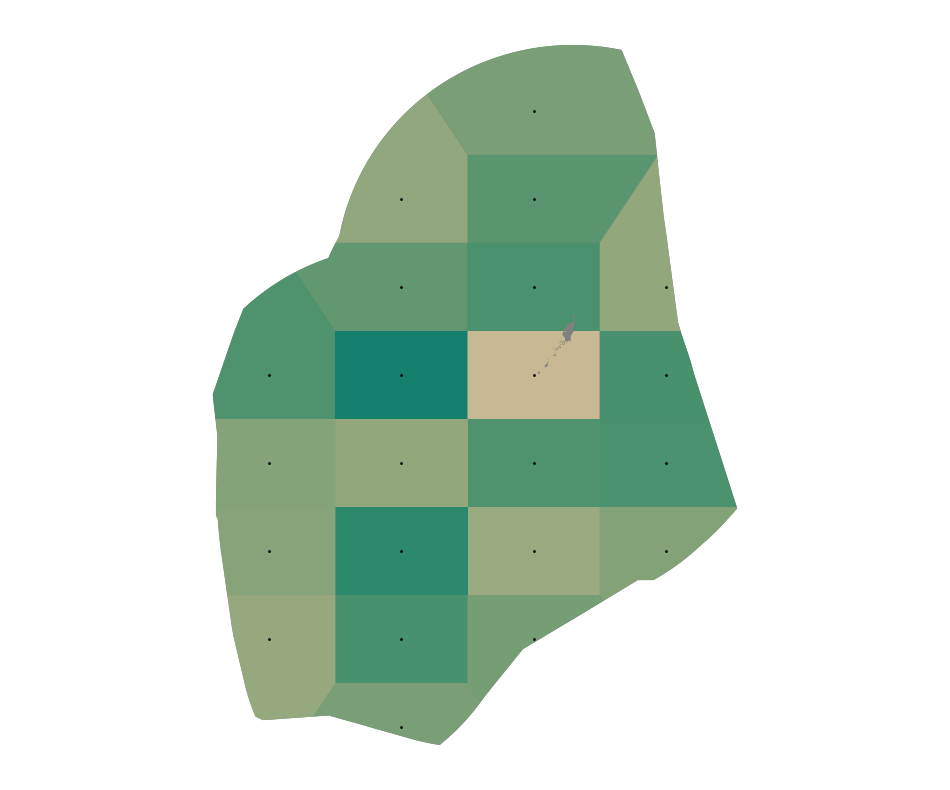

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2041_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


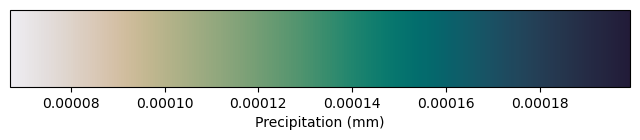

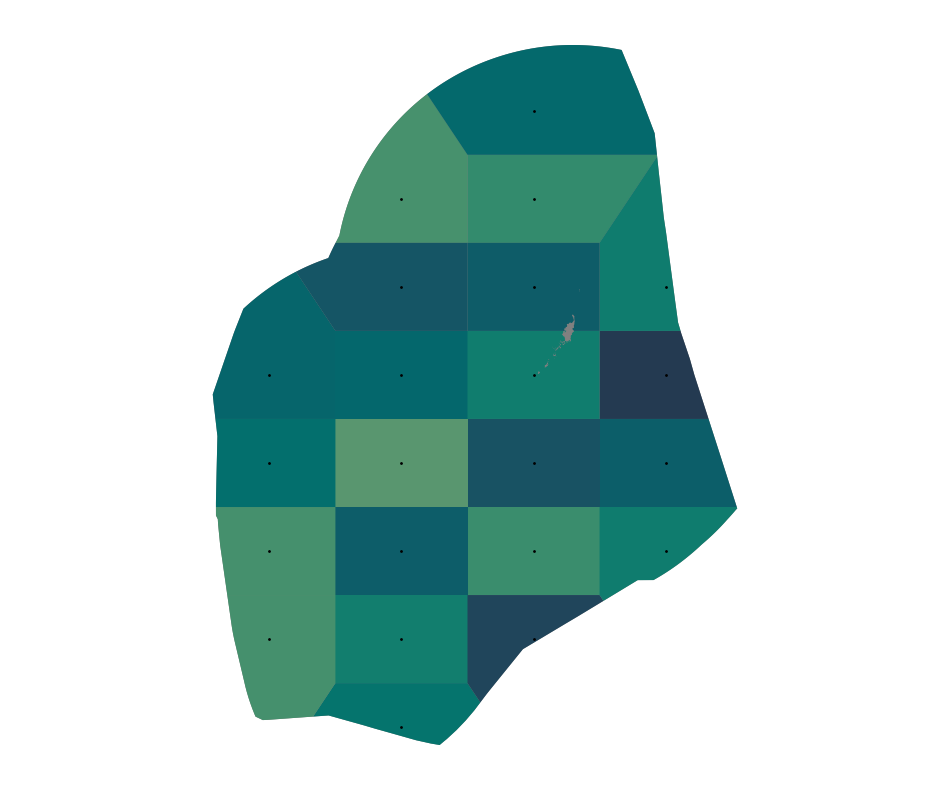

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2042_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


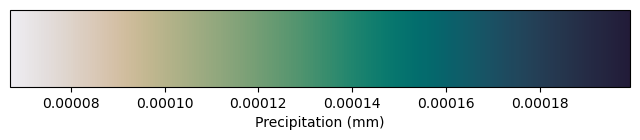

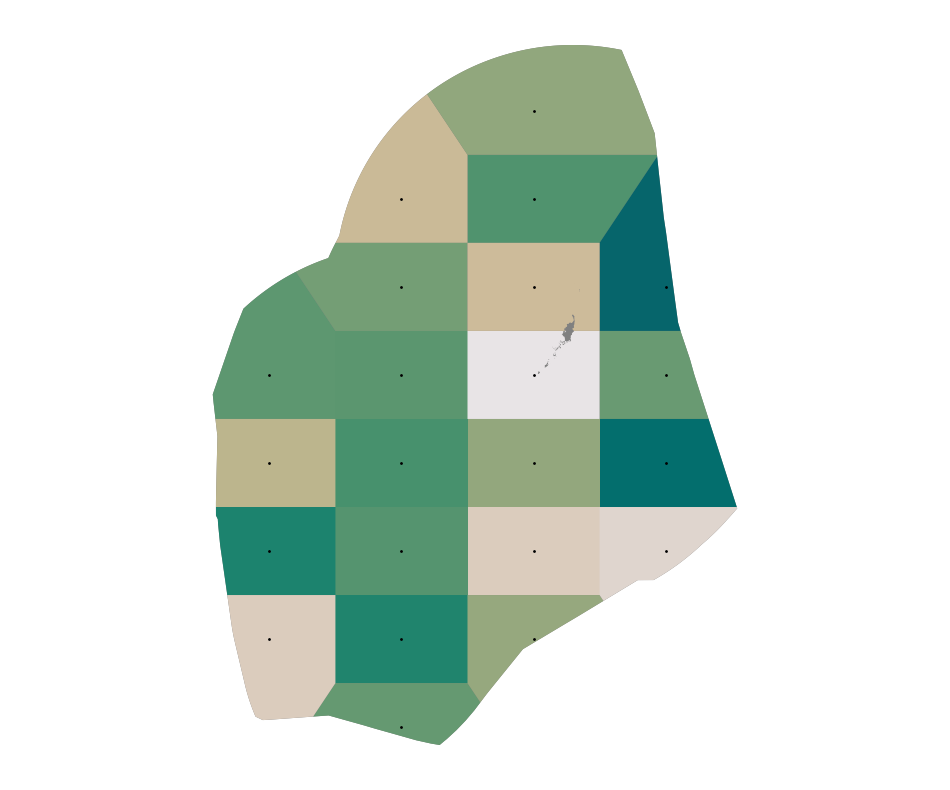

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2043_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


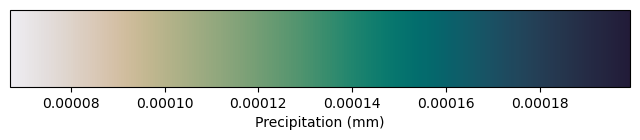

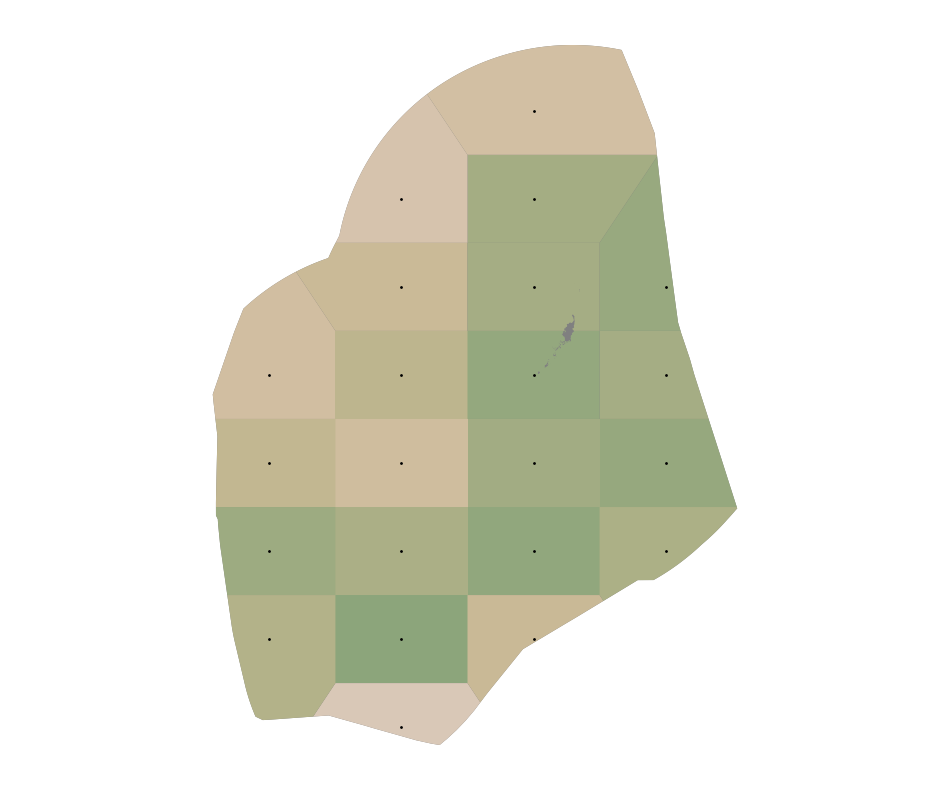

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2044_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


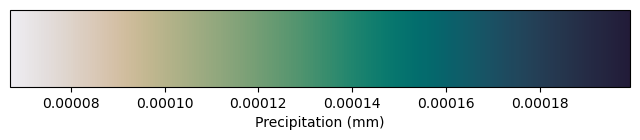

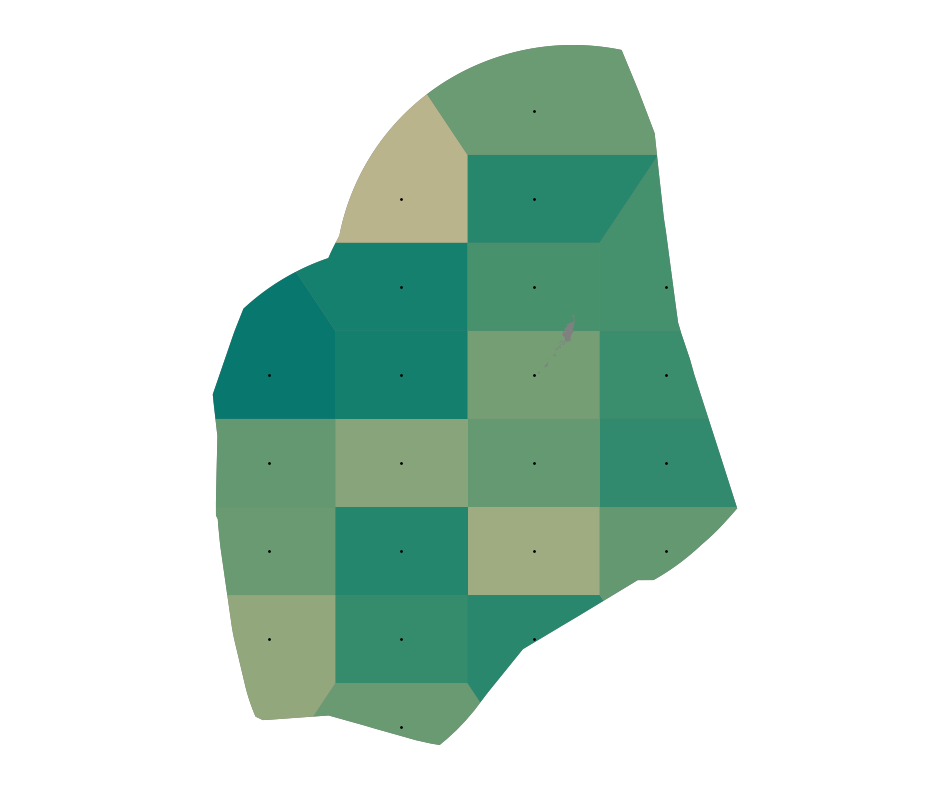

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2045_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


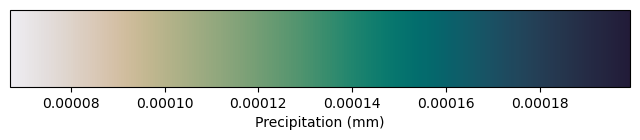

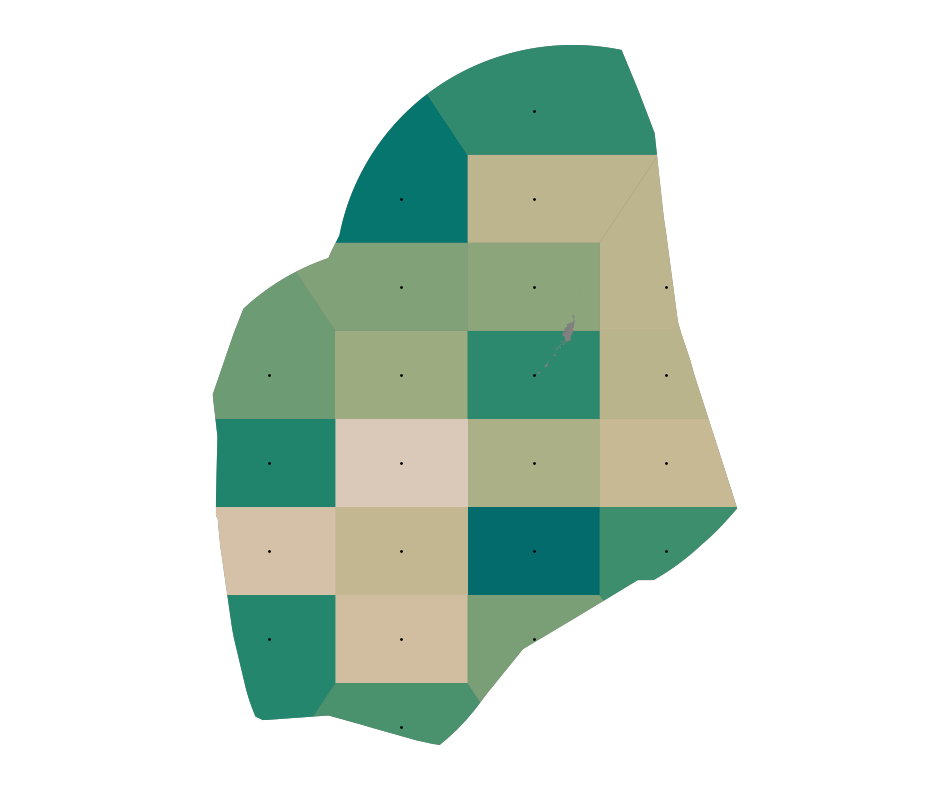

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2046_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


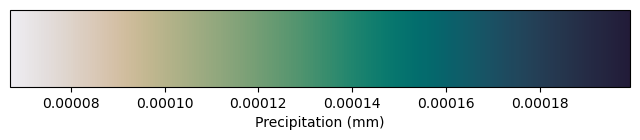

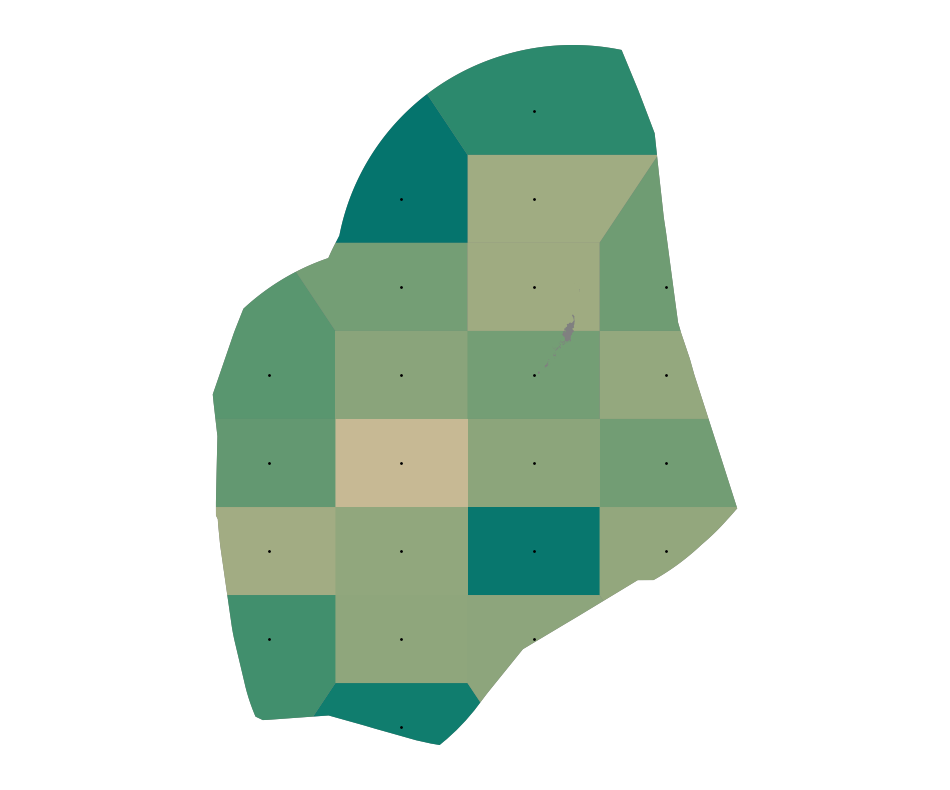

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2047_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


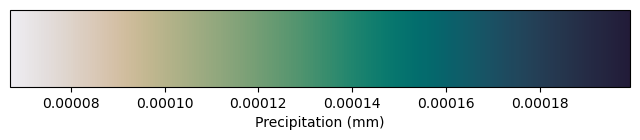

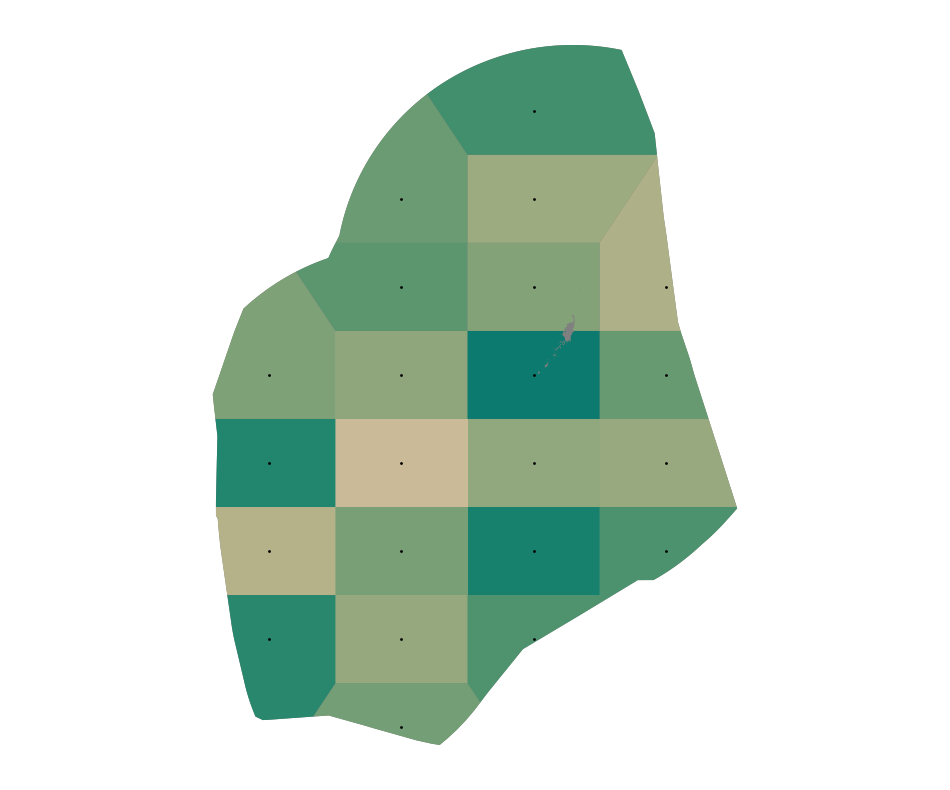

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2048_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


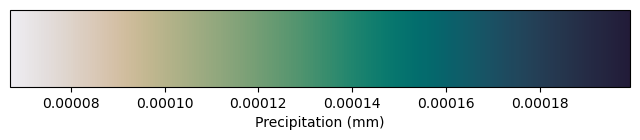

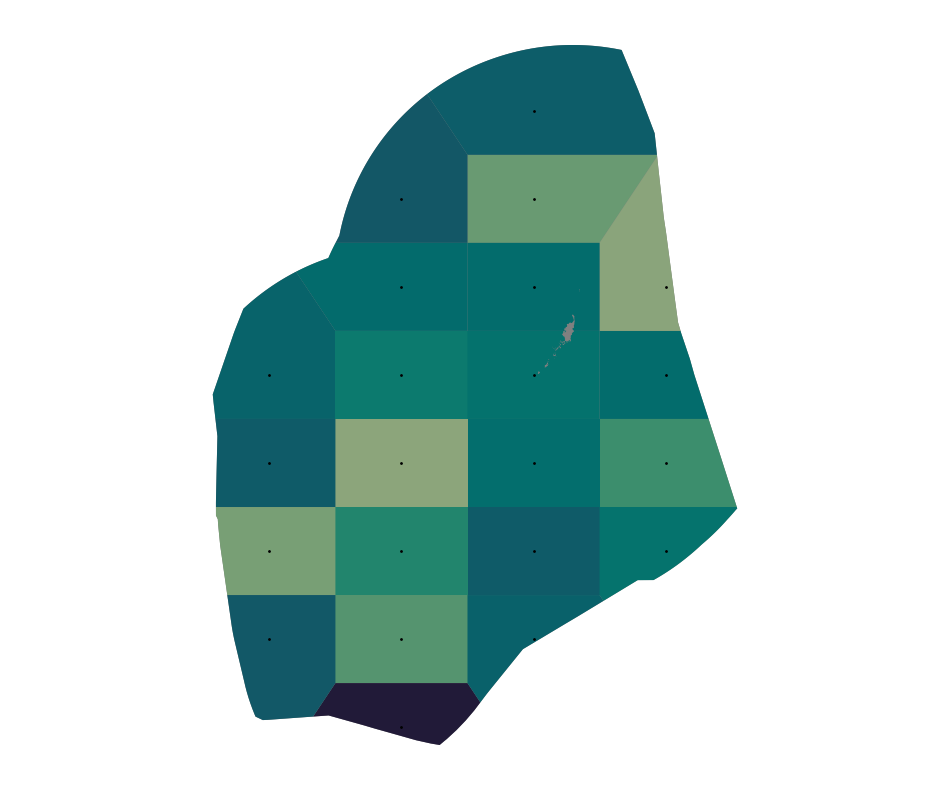

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2049_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


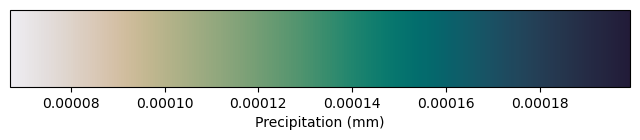

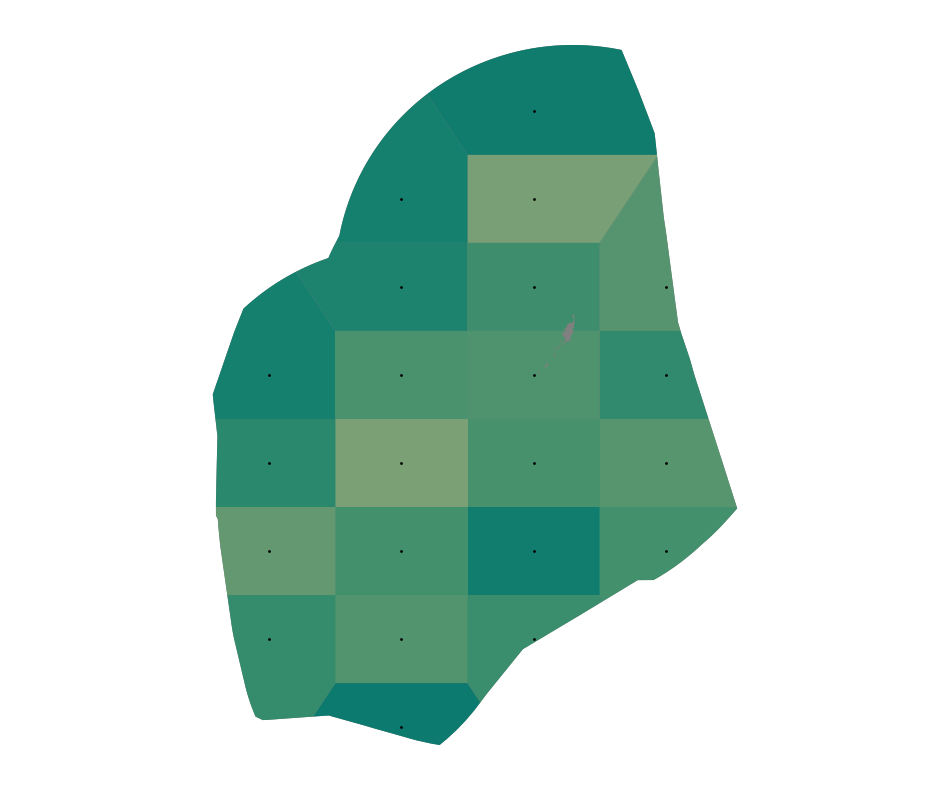

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2050_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


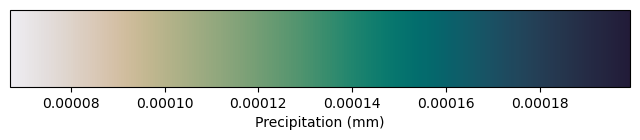

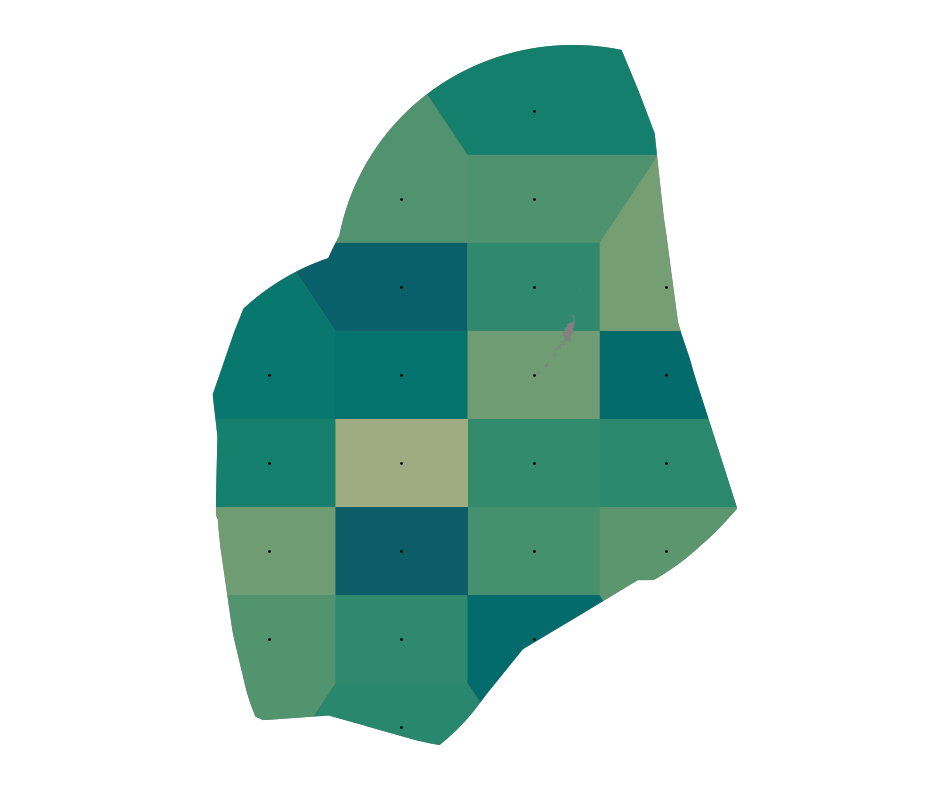

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2051_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


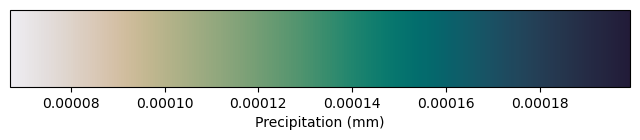

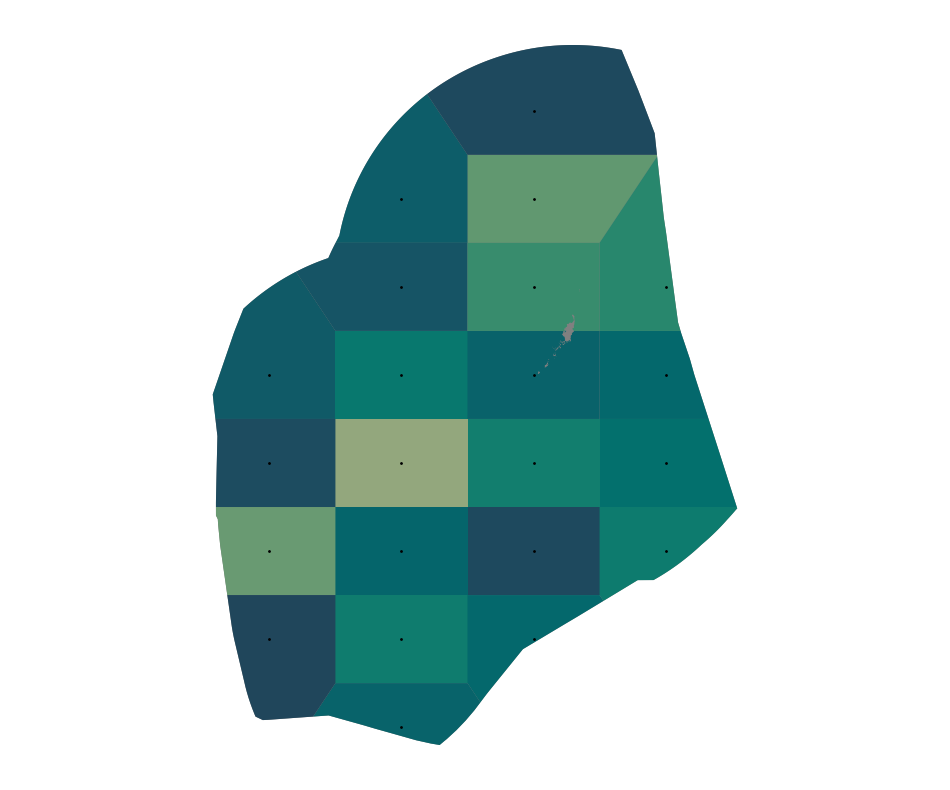

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2052_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


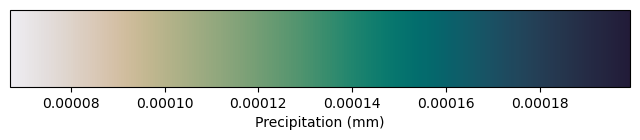

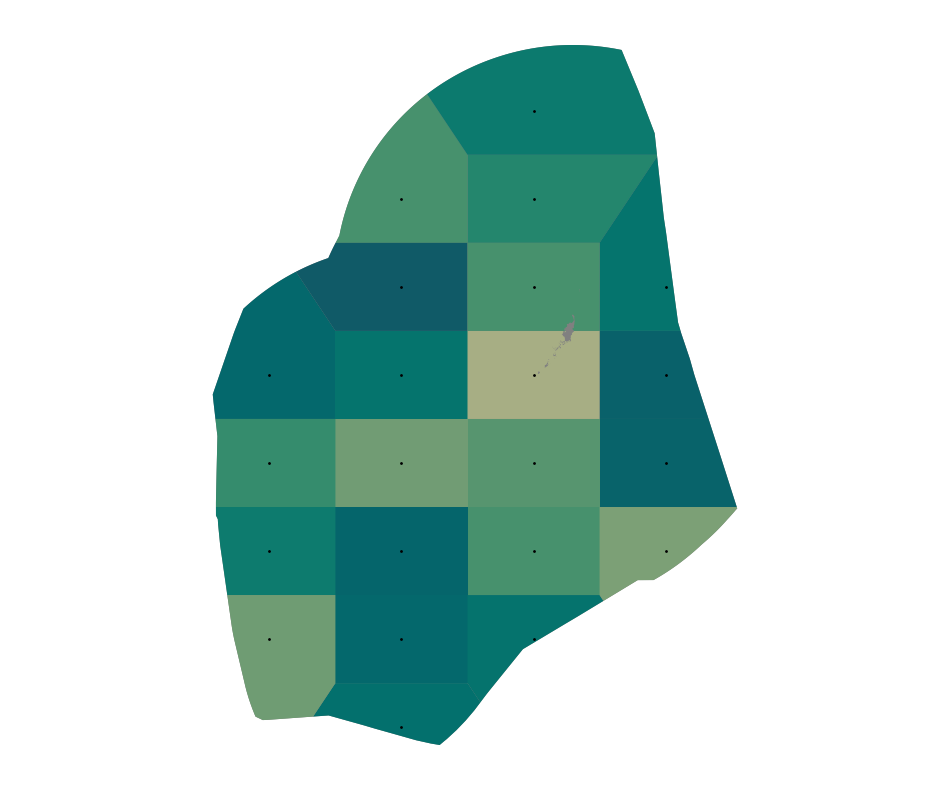

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2053_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


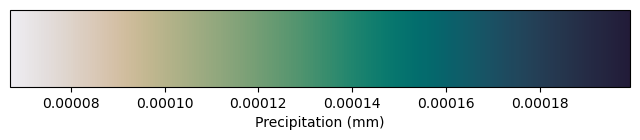

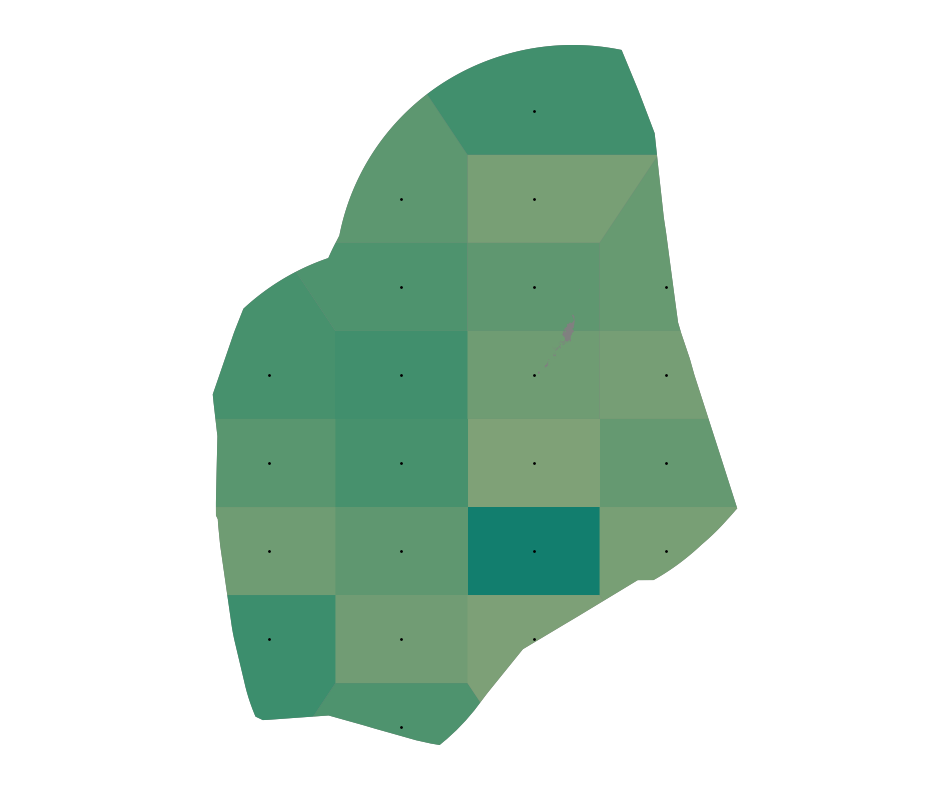

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2054_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


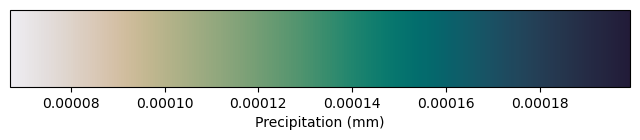

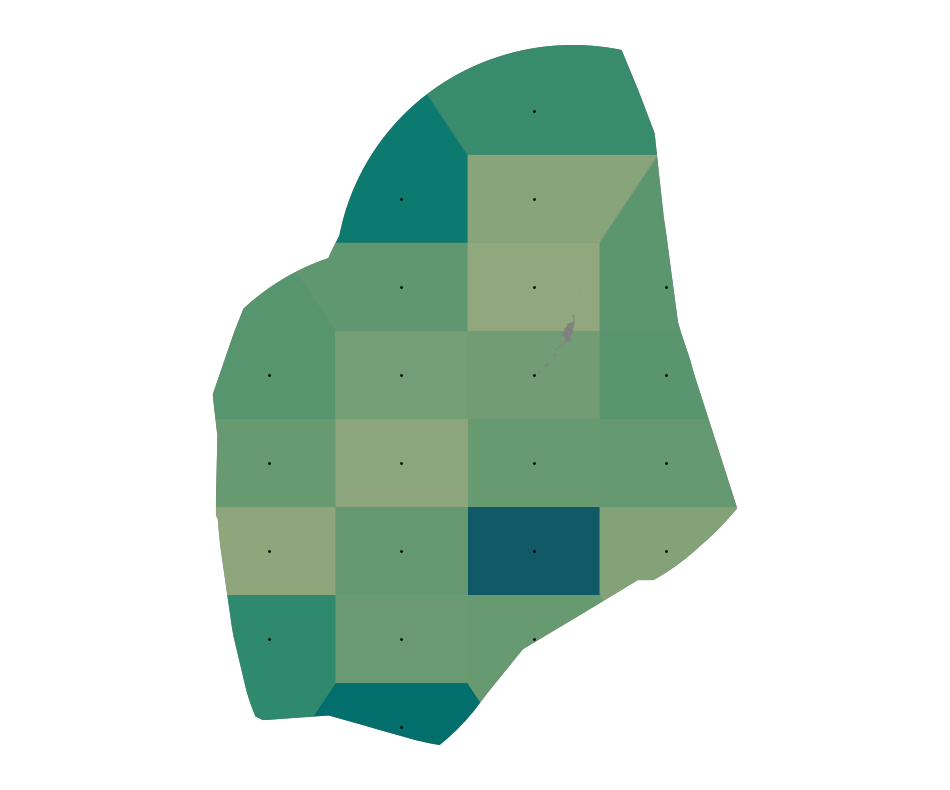

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2055_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


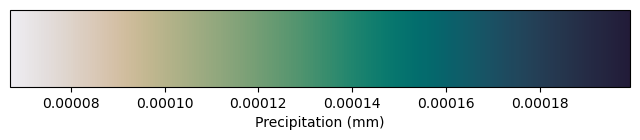

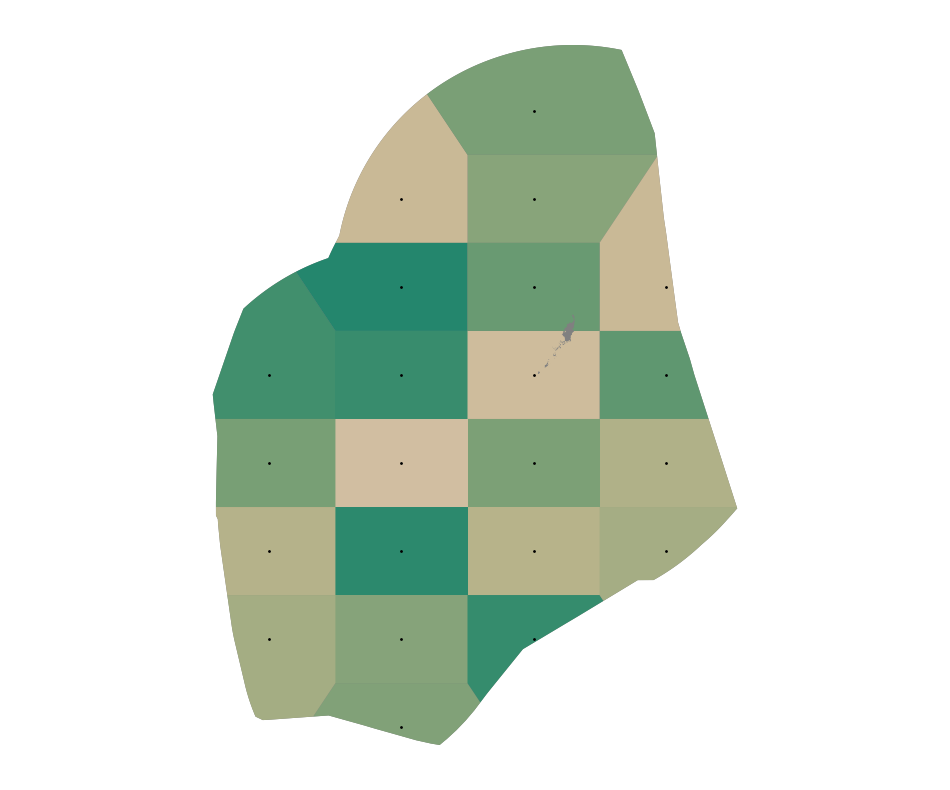

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2056_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


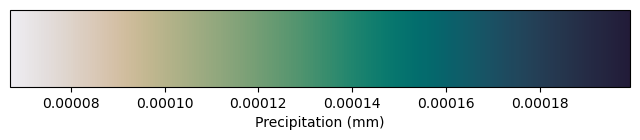

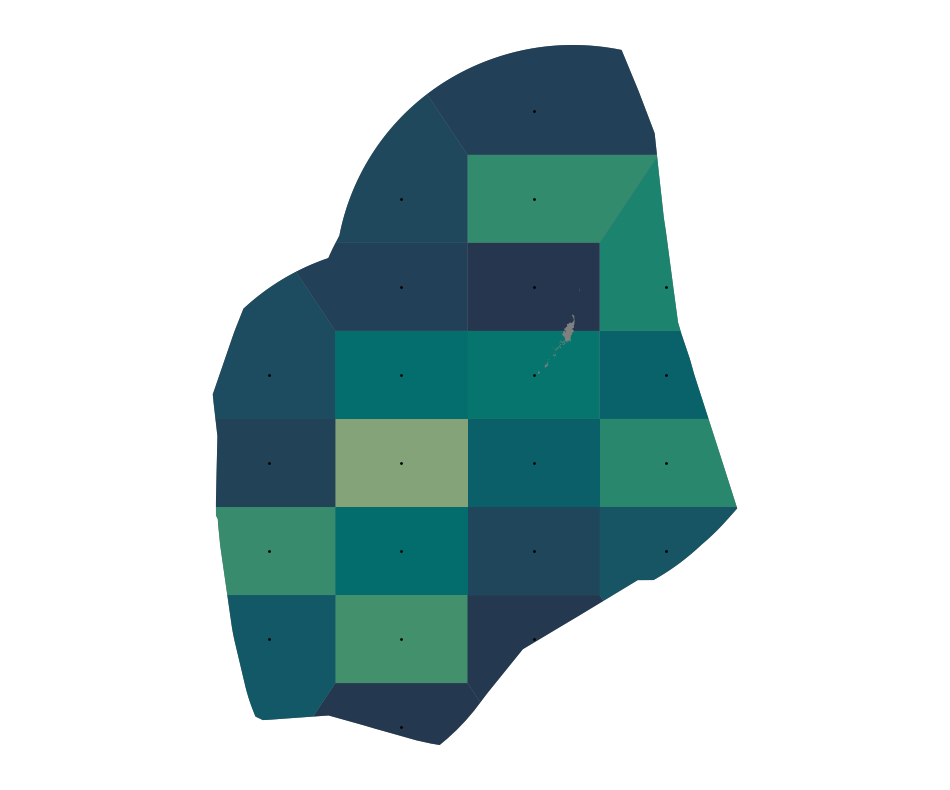

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2057_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


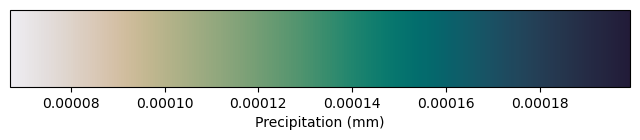

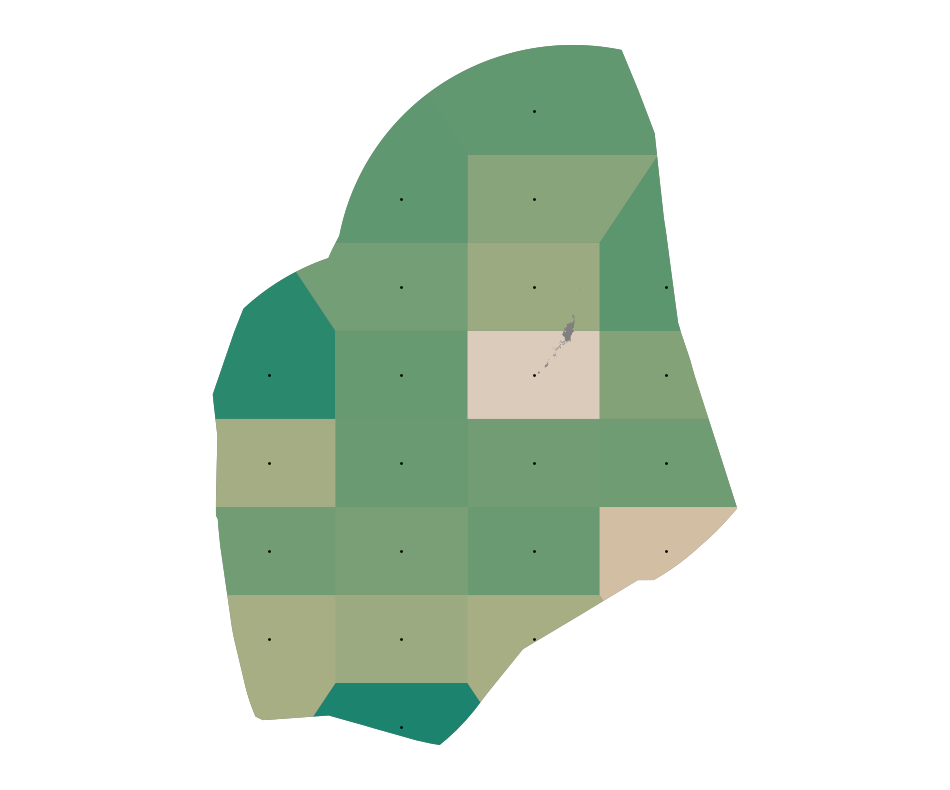

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2058_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


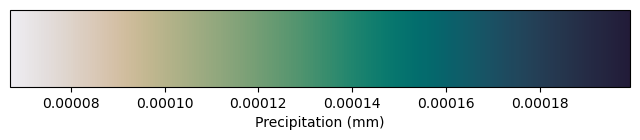

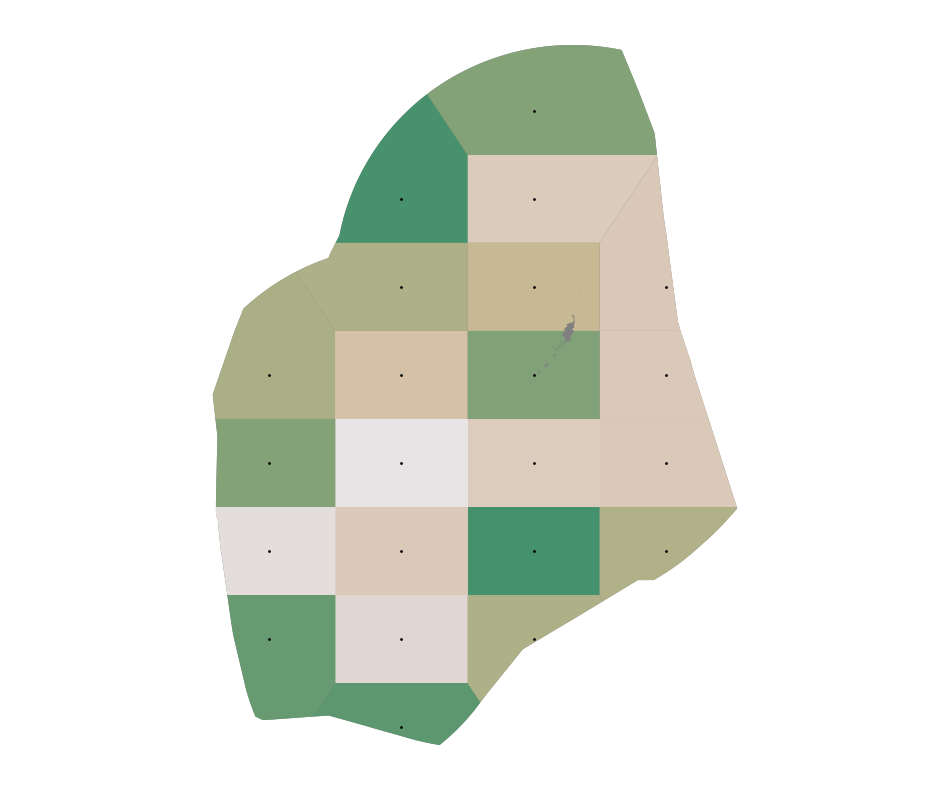

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2059_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


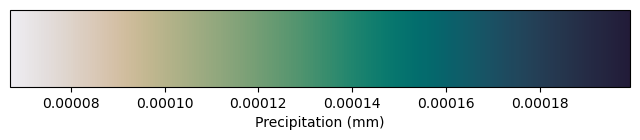

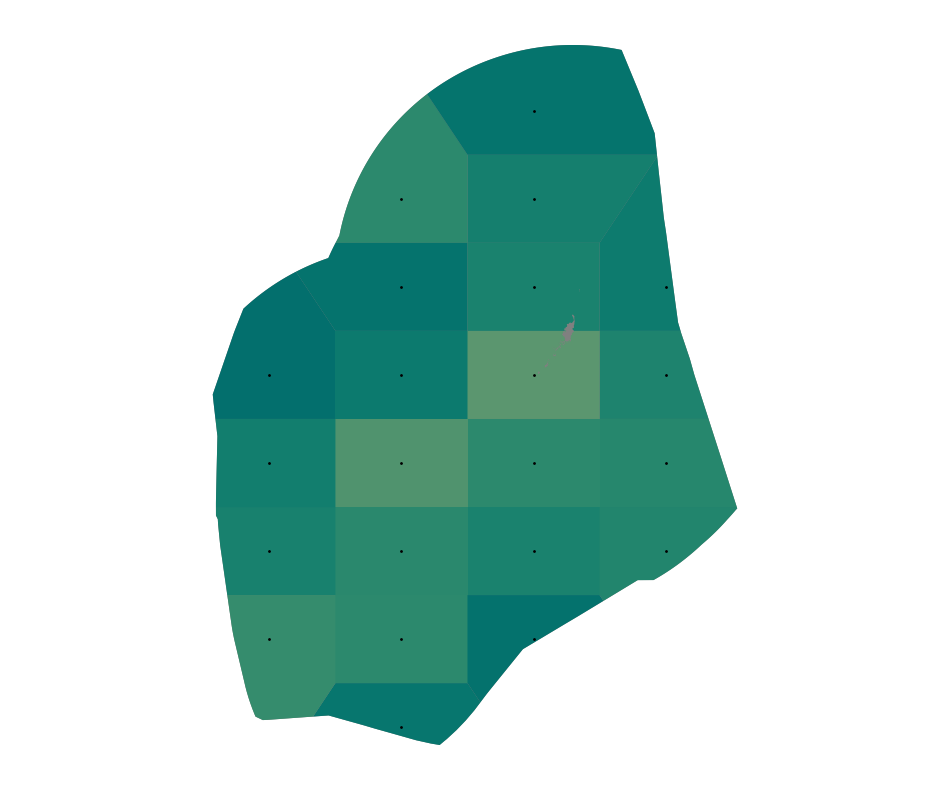

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2060_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


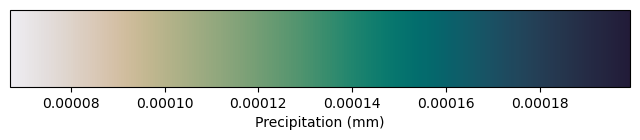

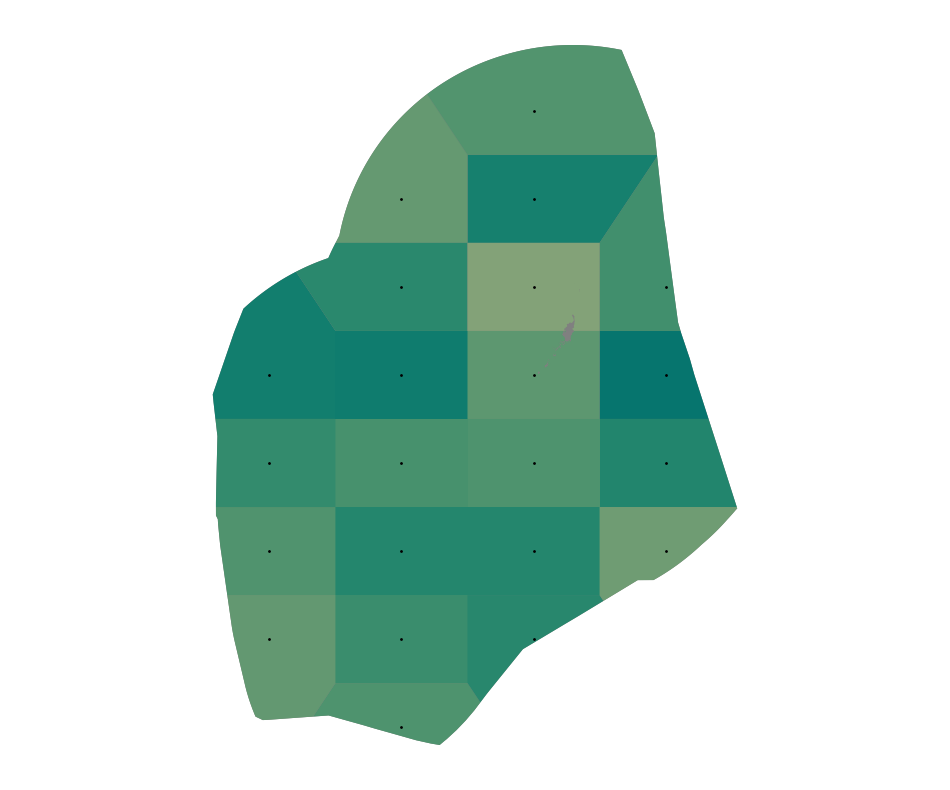

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2061_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


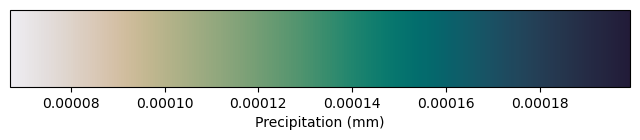

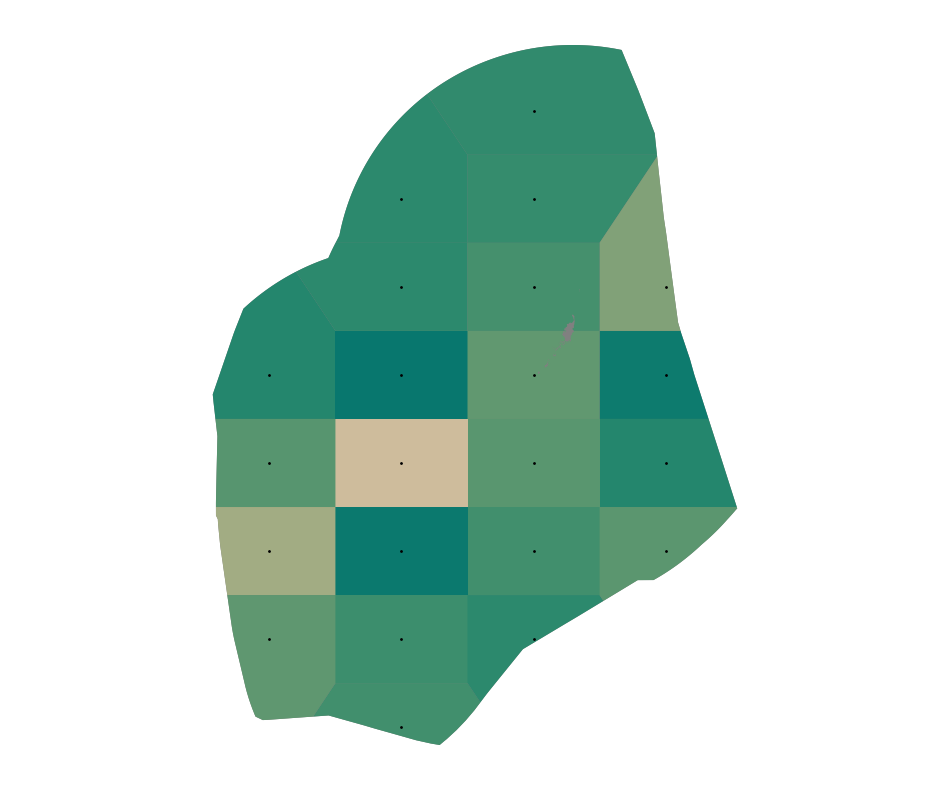

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2062_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


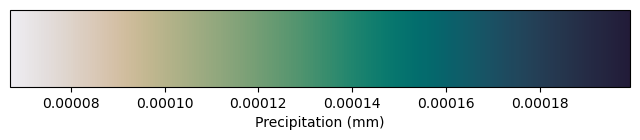

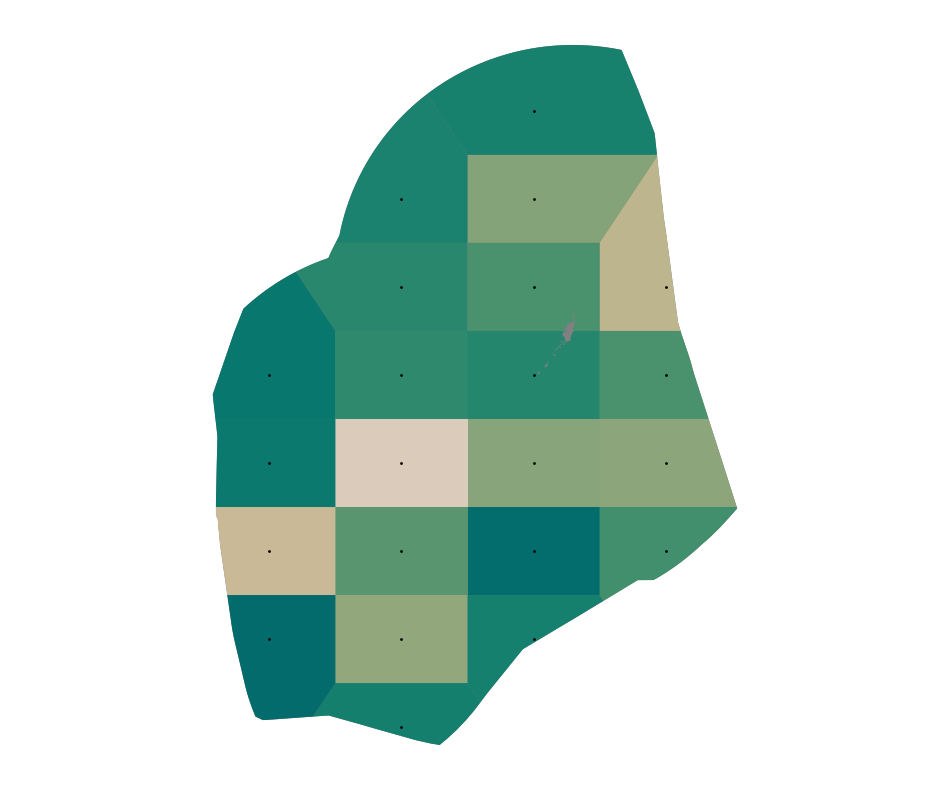

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2063_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


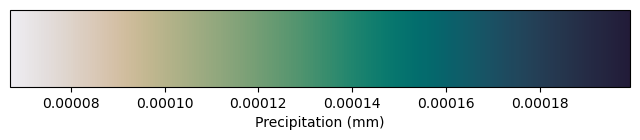

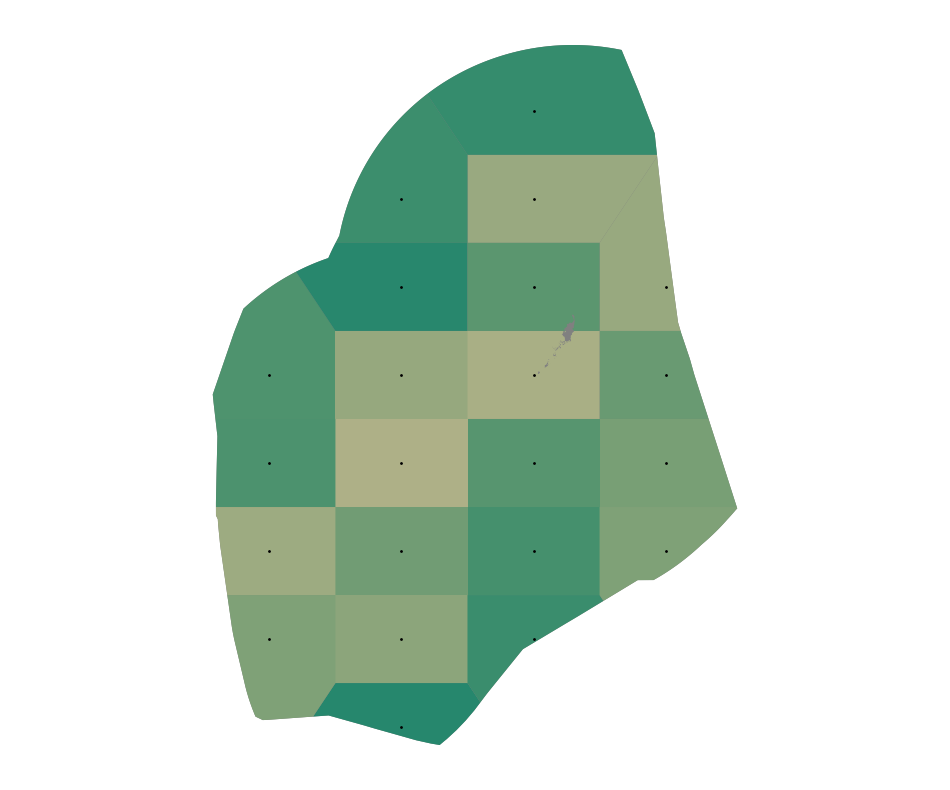

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2064_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


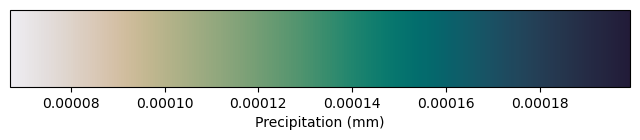

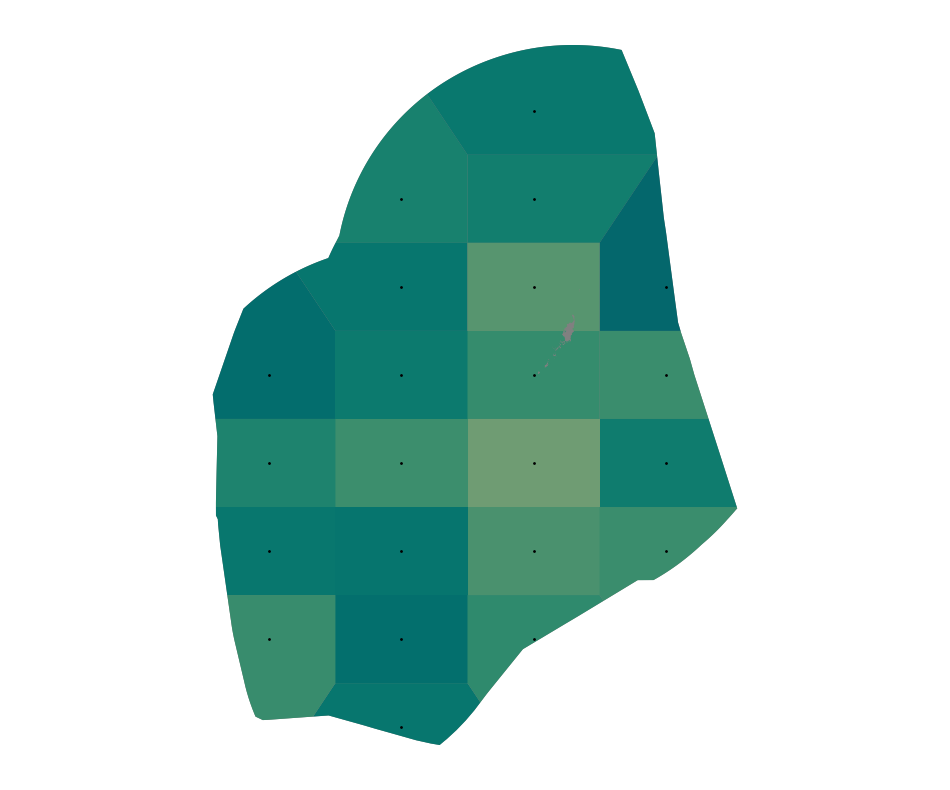

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2065_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


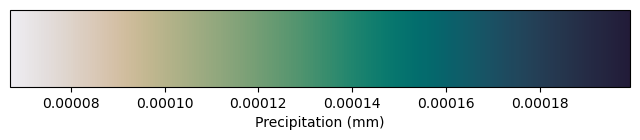

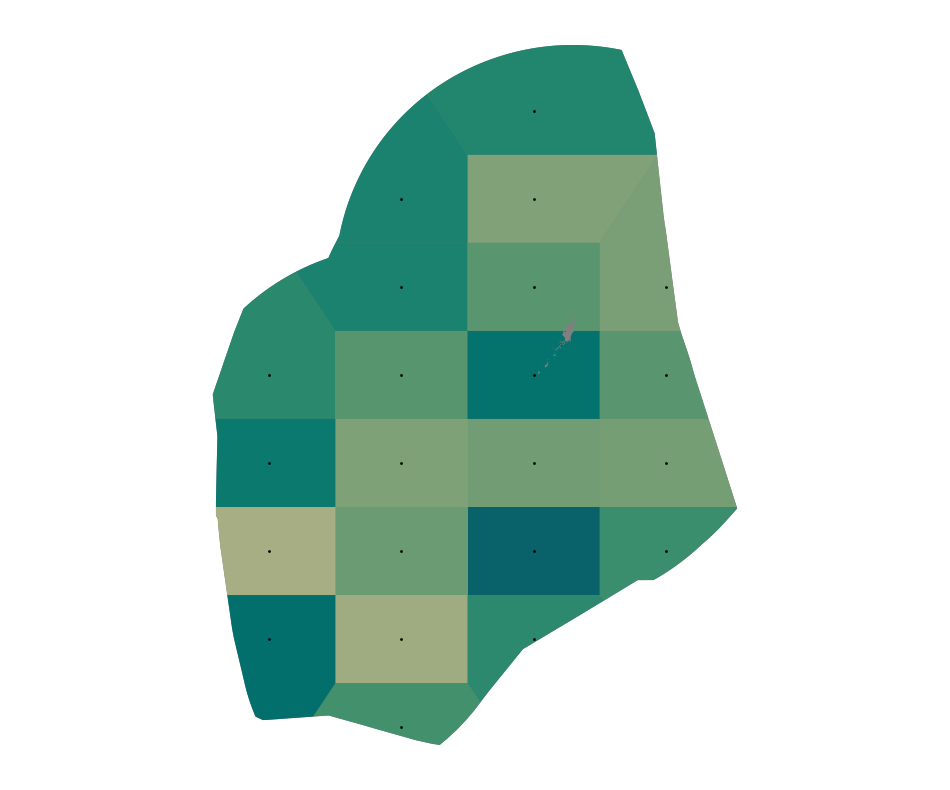

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2066_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


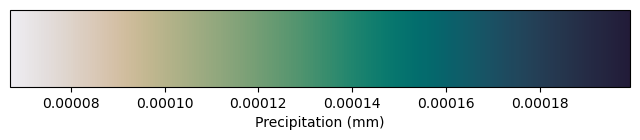

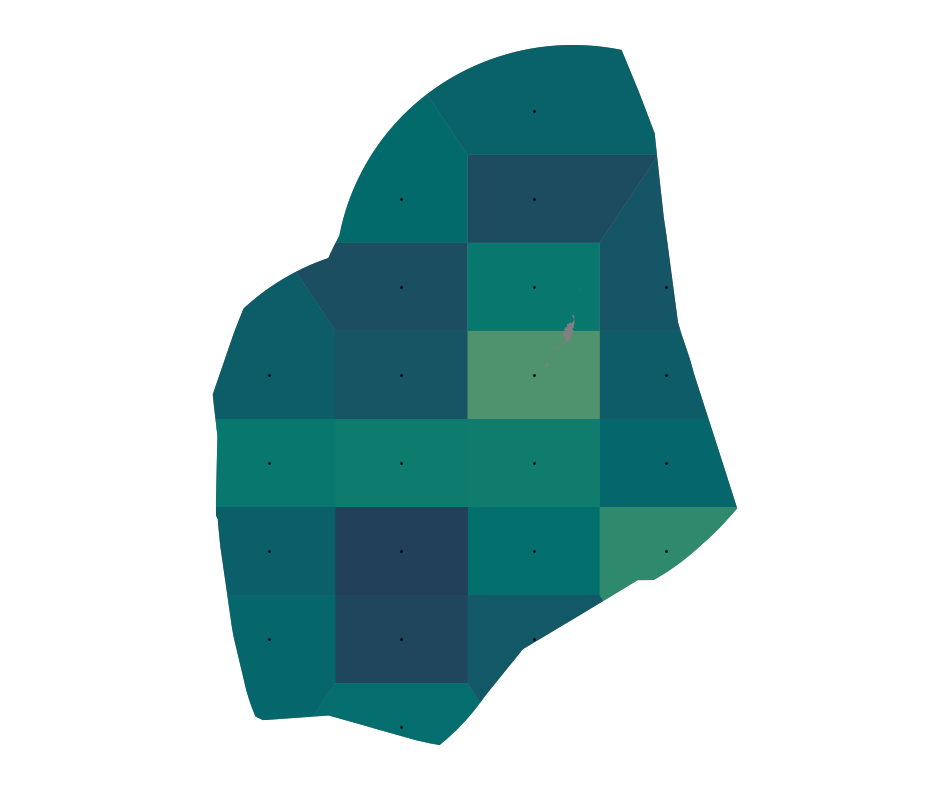

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2067_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


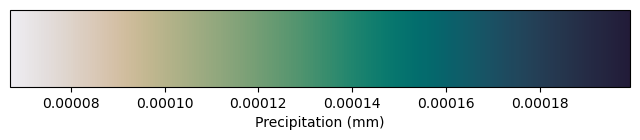

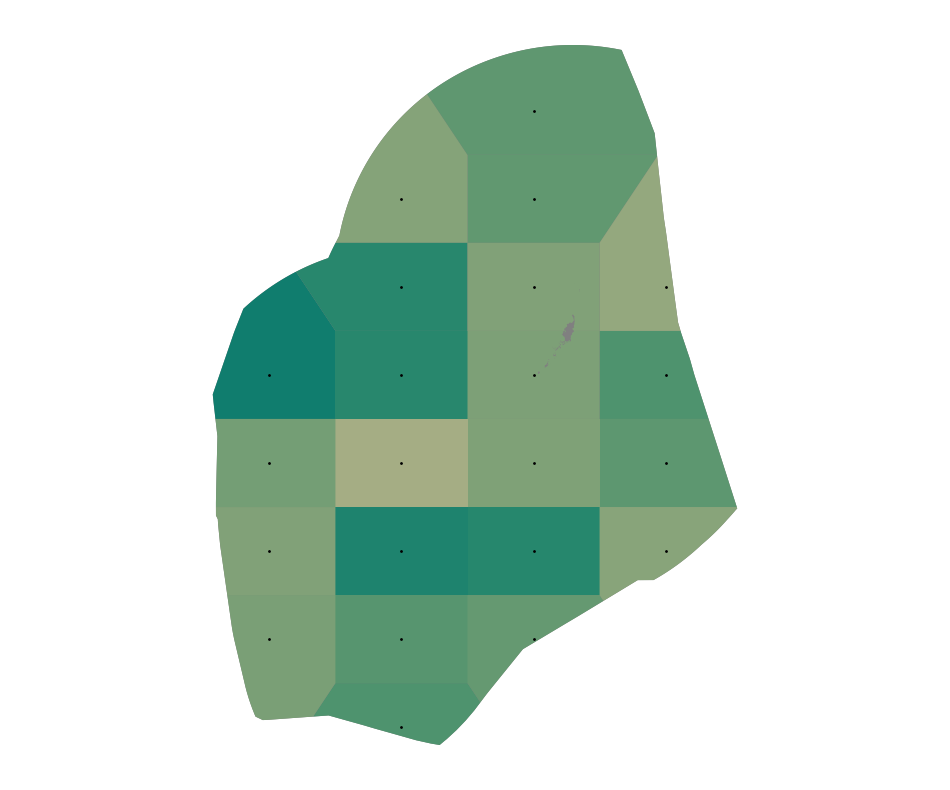

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2068_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


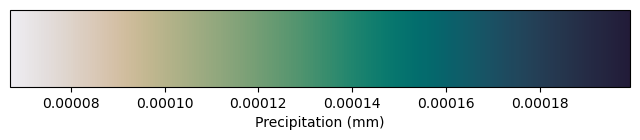

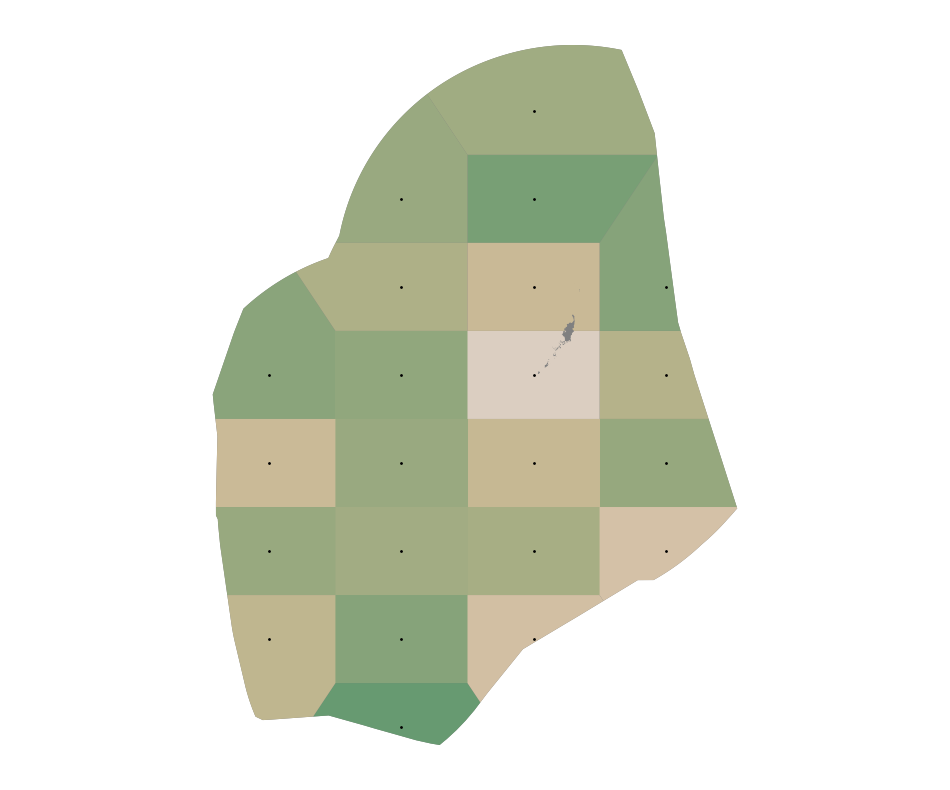

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2069_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


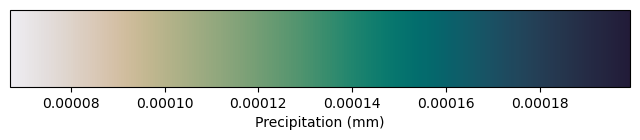

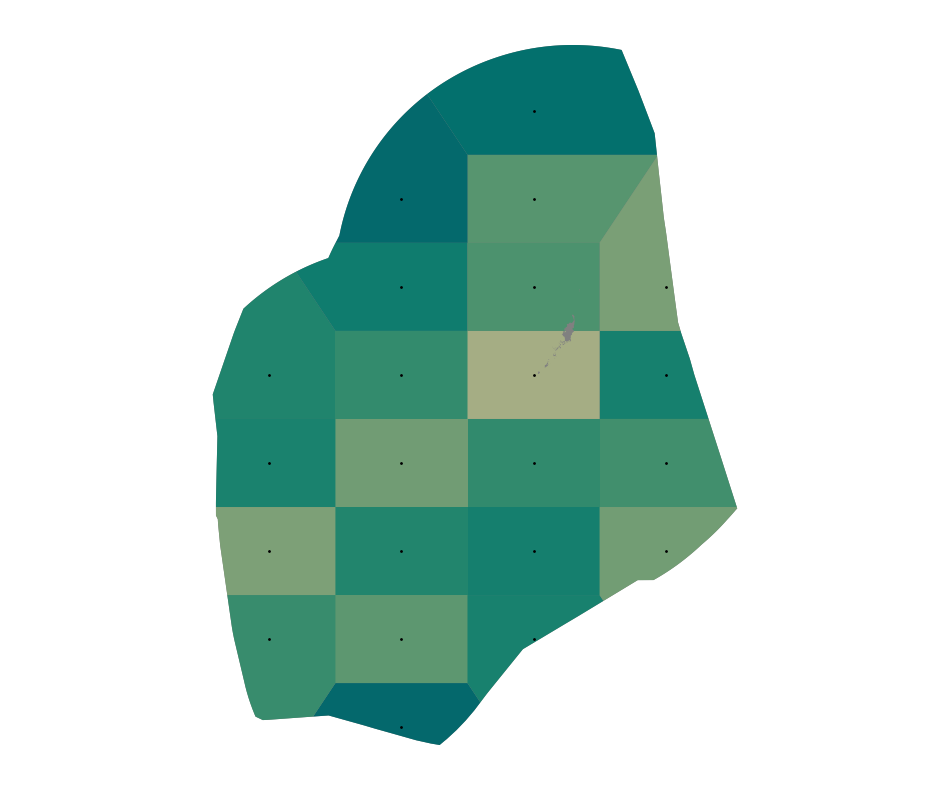

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2070_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


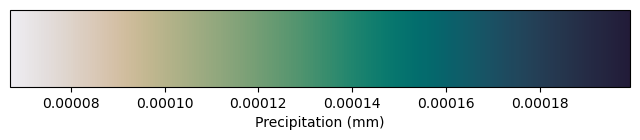

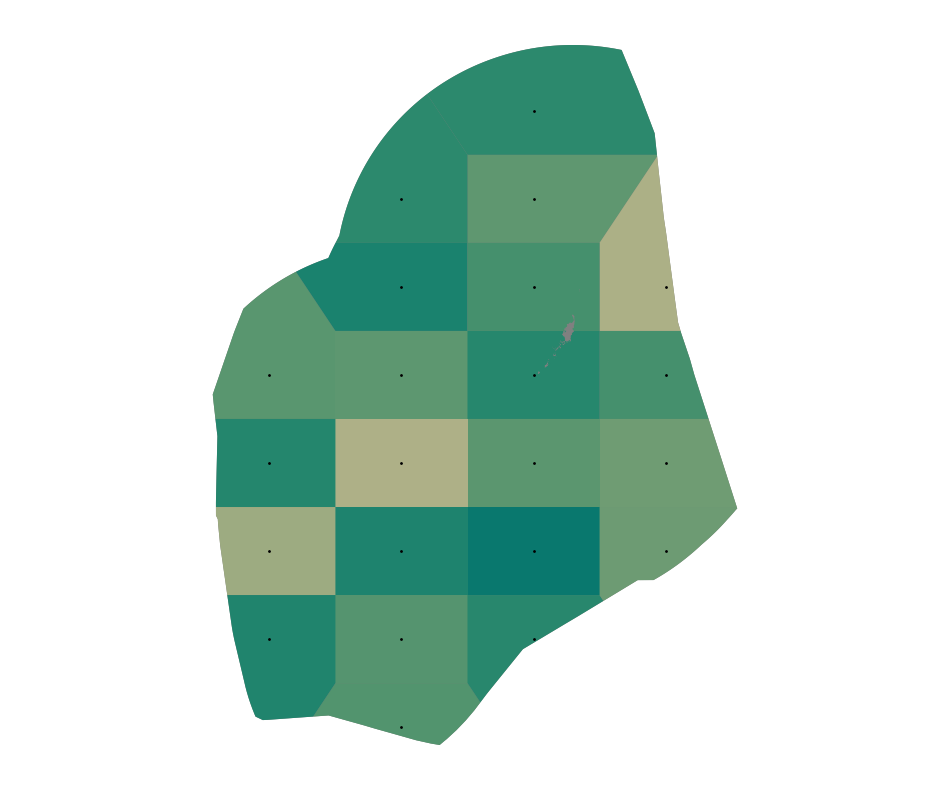

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2071_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


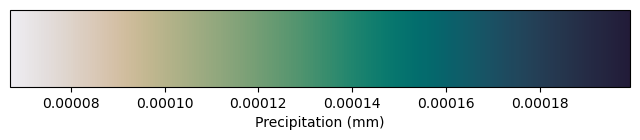

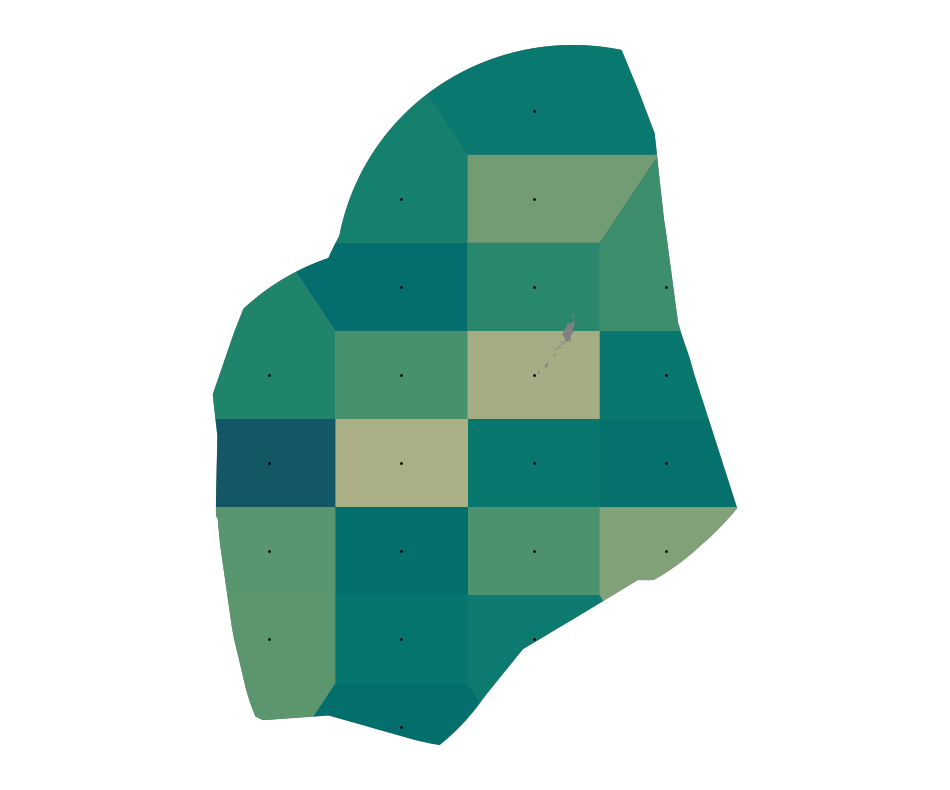

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2072_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


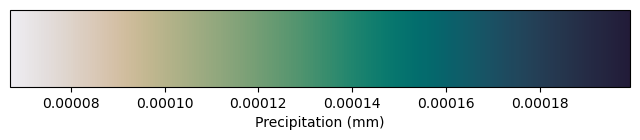

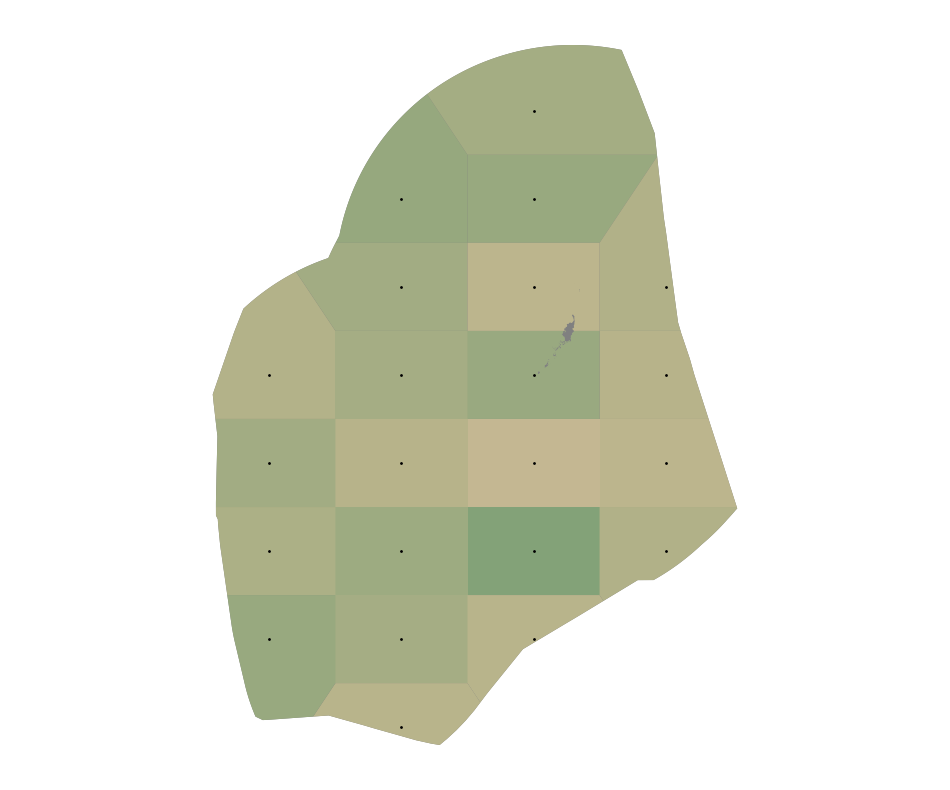

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2073_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


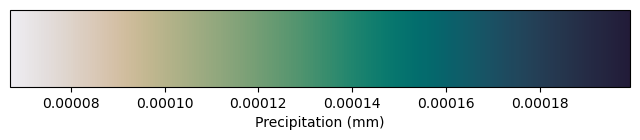

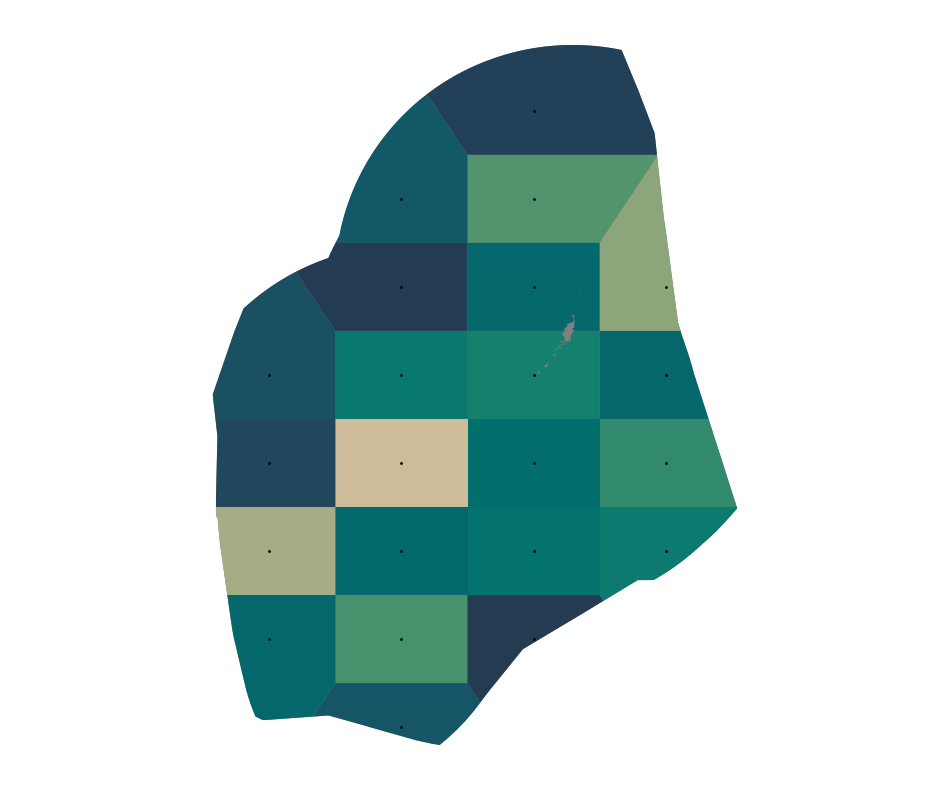

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2074_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


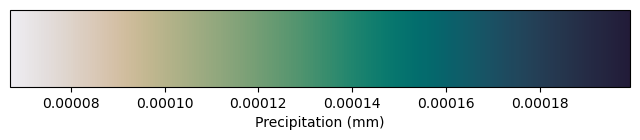

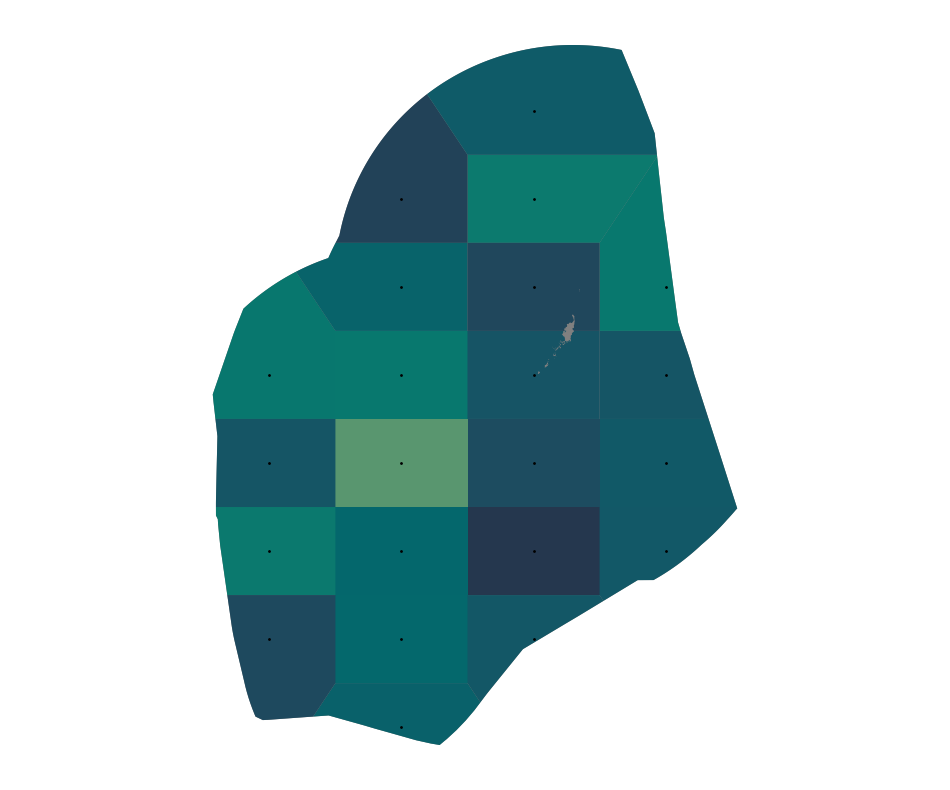

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2075_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


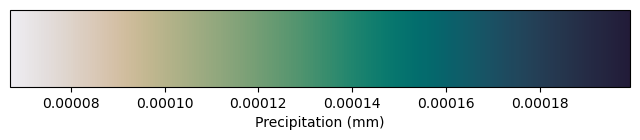

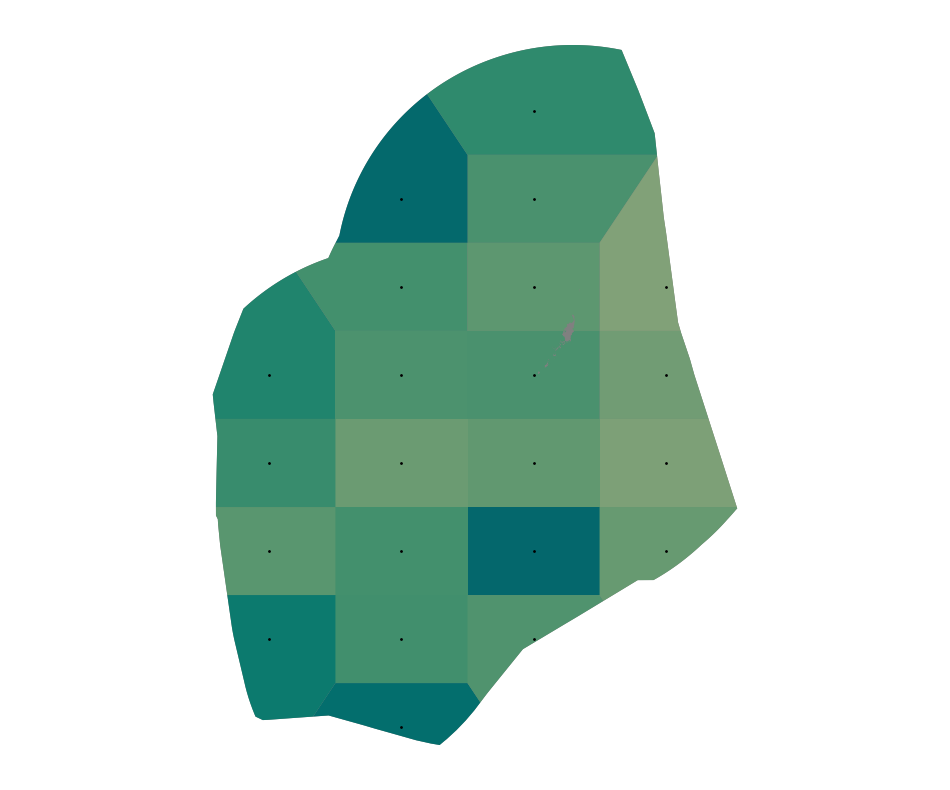

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2076_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


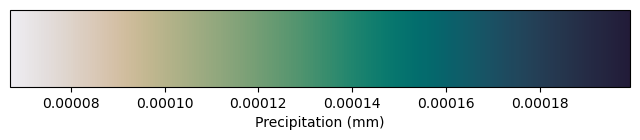

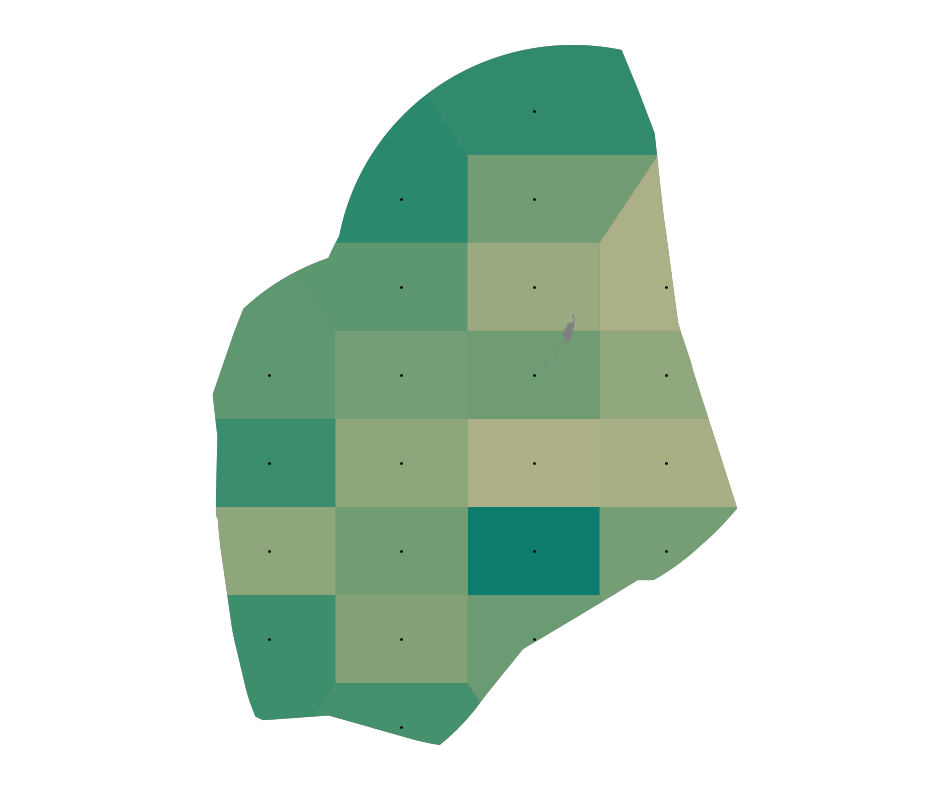

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2077_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


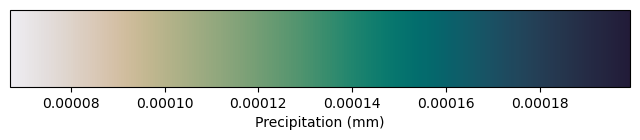

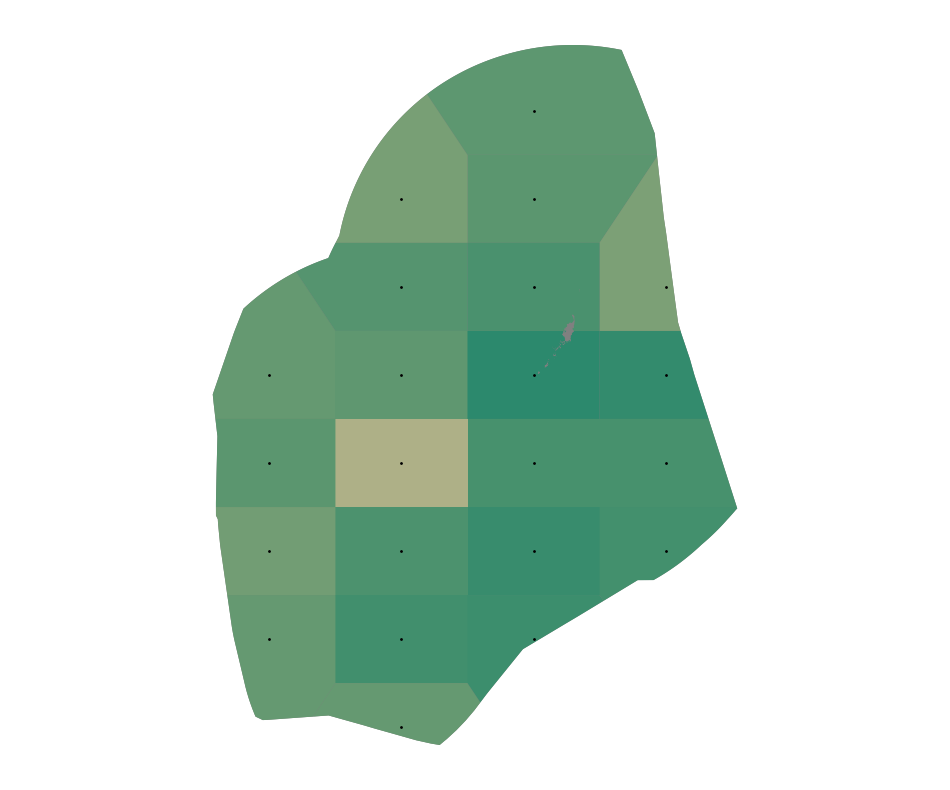

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2078_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


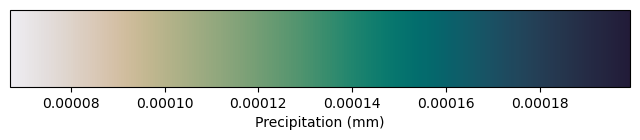

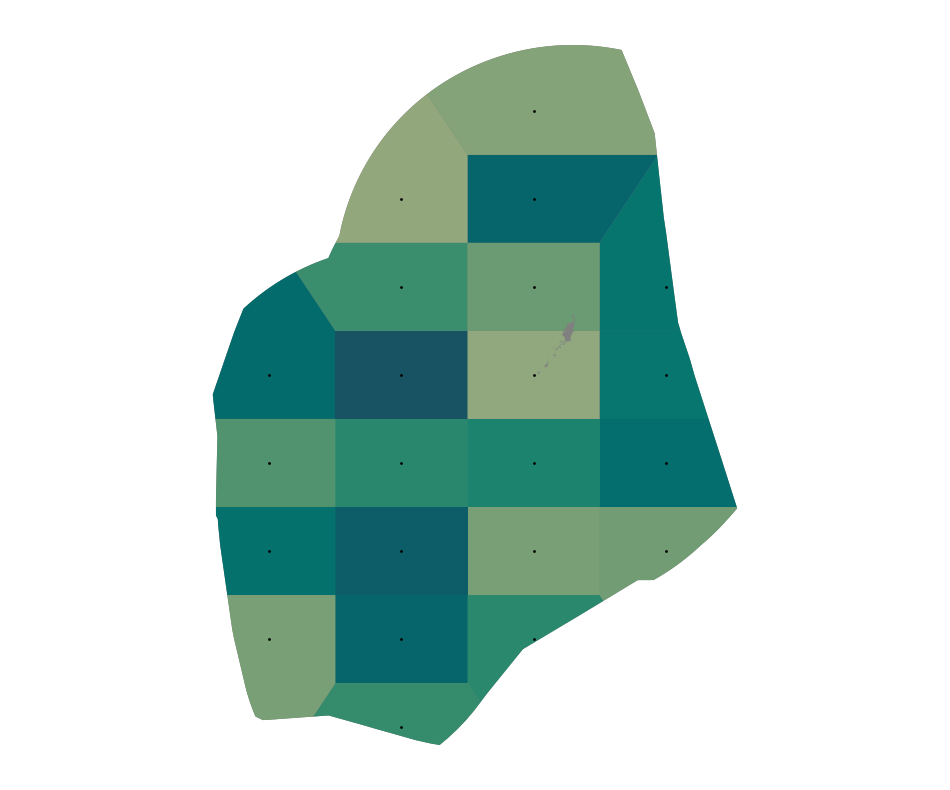

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2079_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


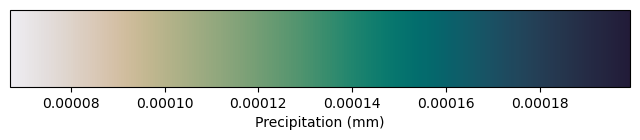

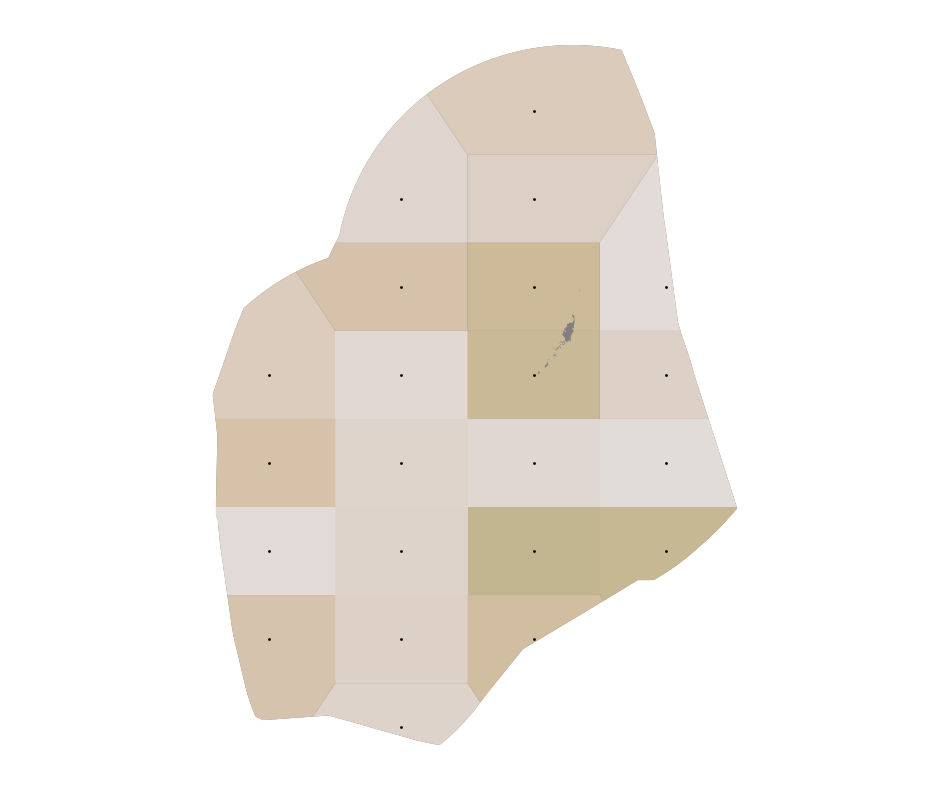

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2080_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


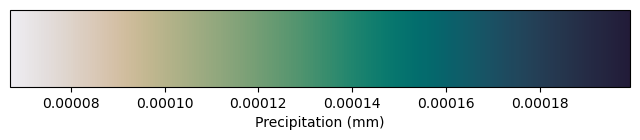

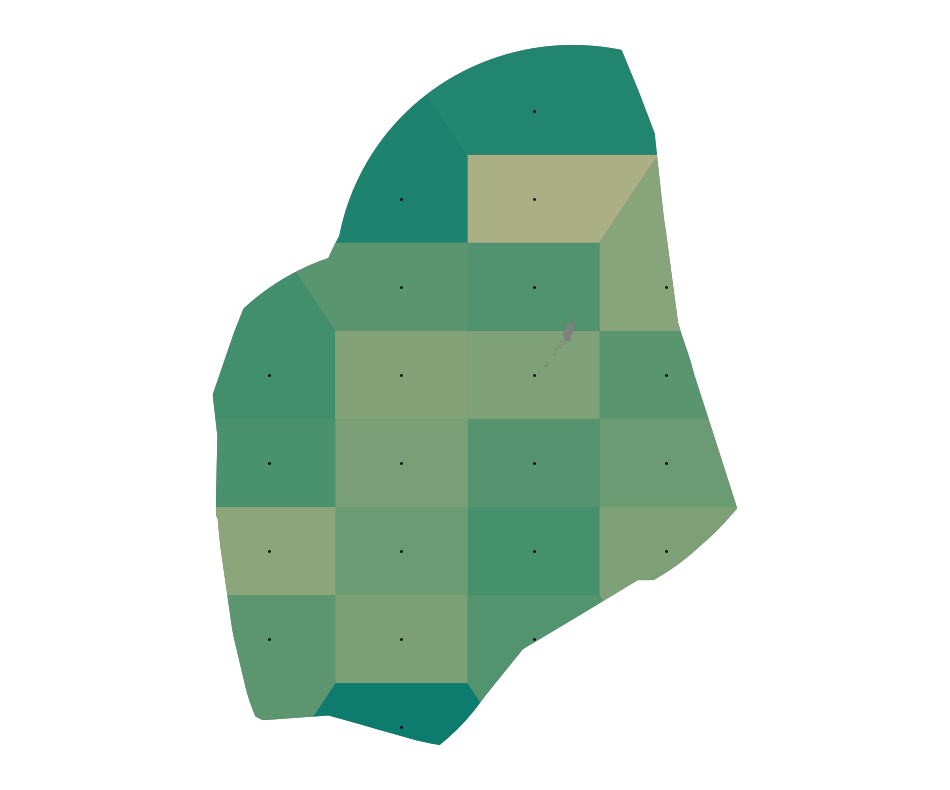

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2081_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


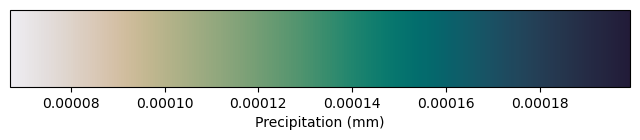

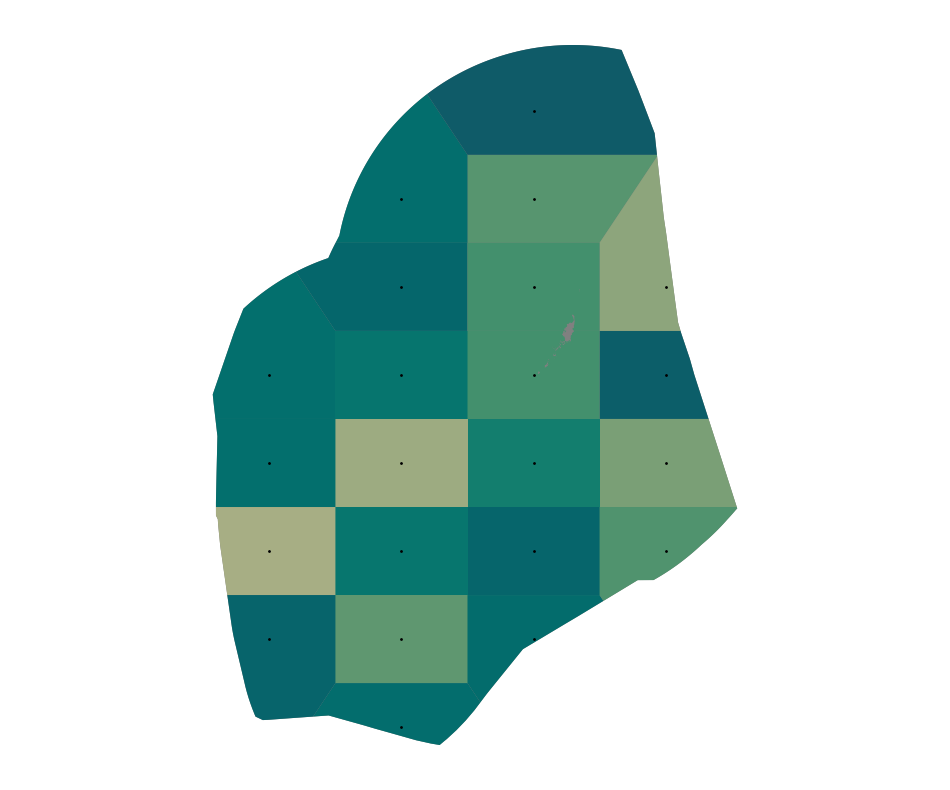

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2082_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


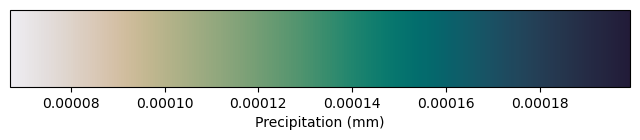

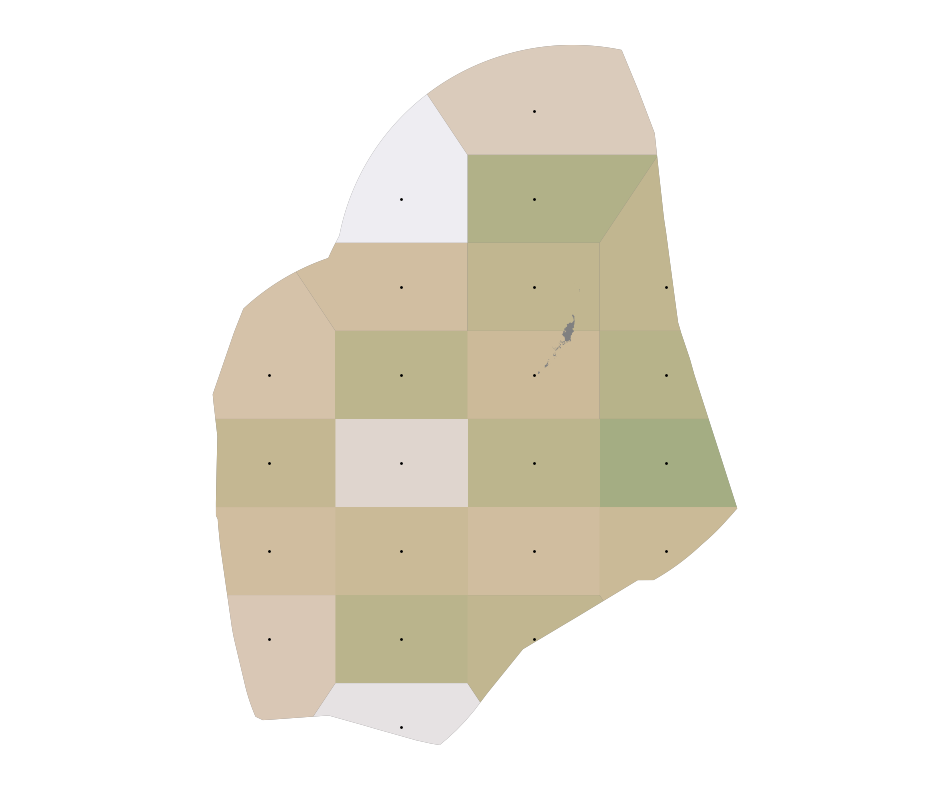

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2083_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


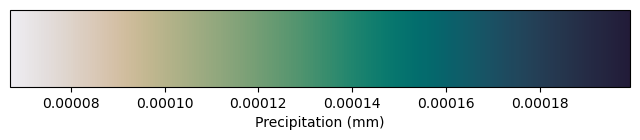

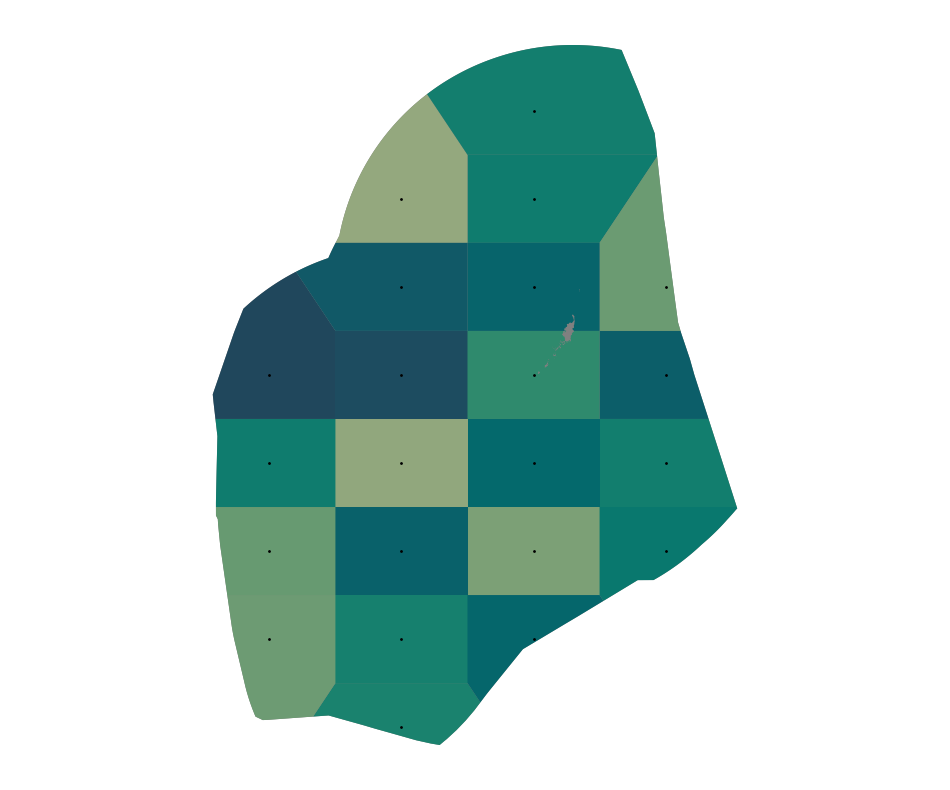

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2084_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


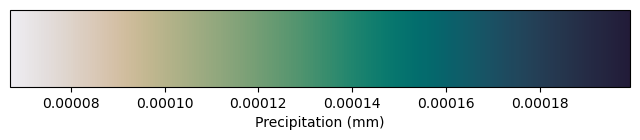

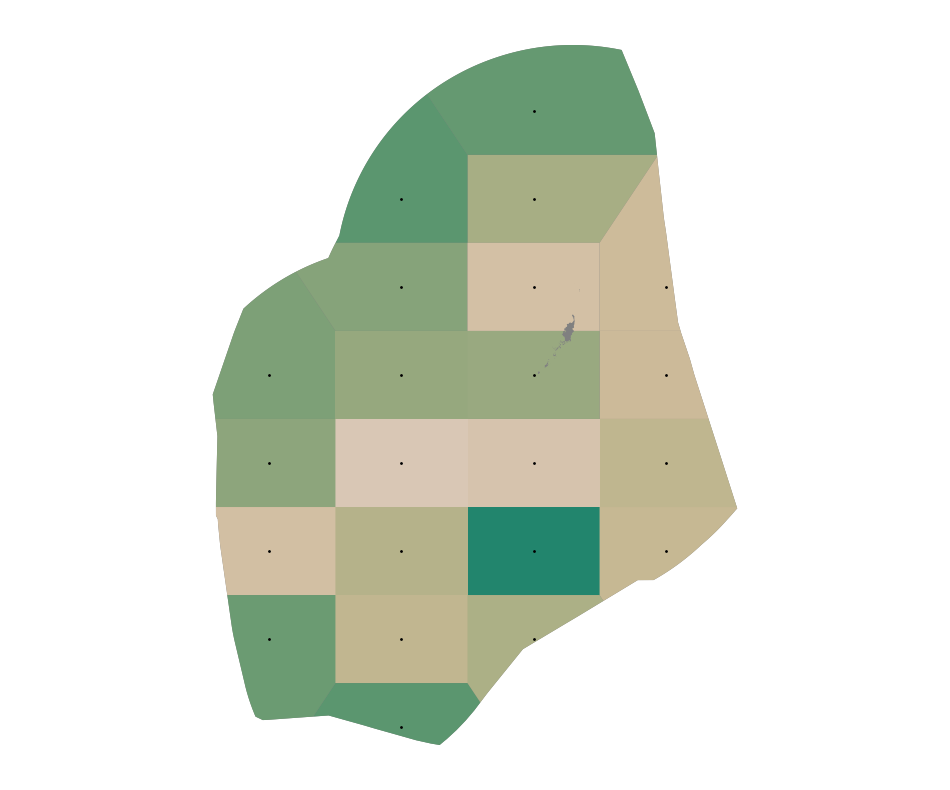

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2085_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


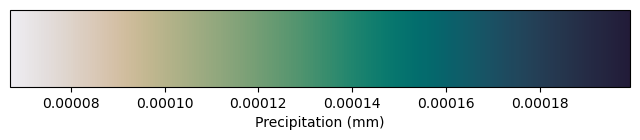

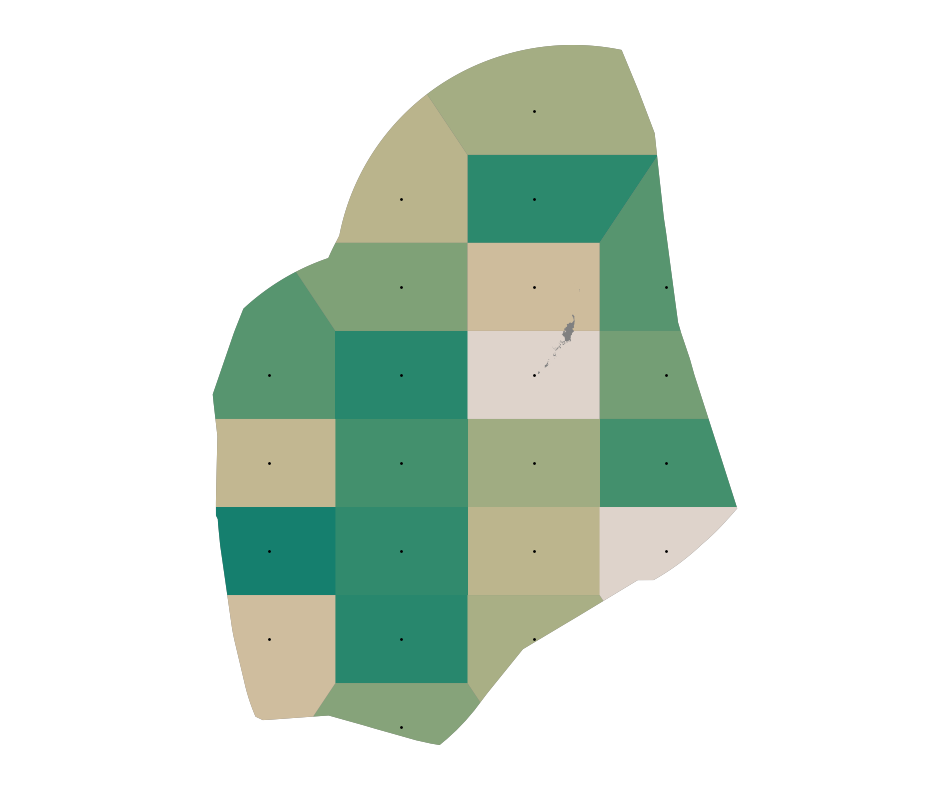

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2086_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


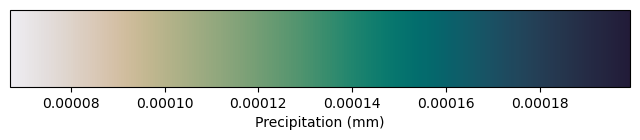

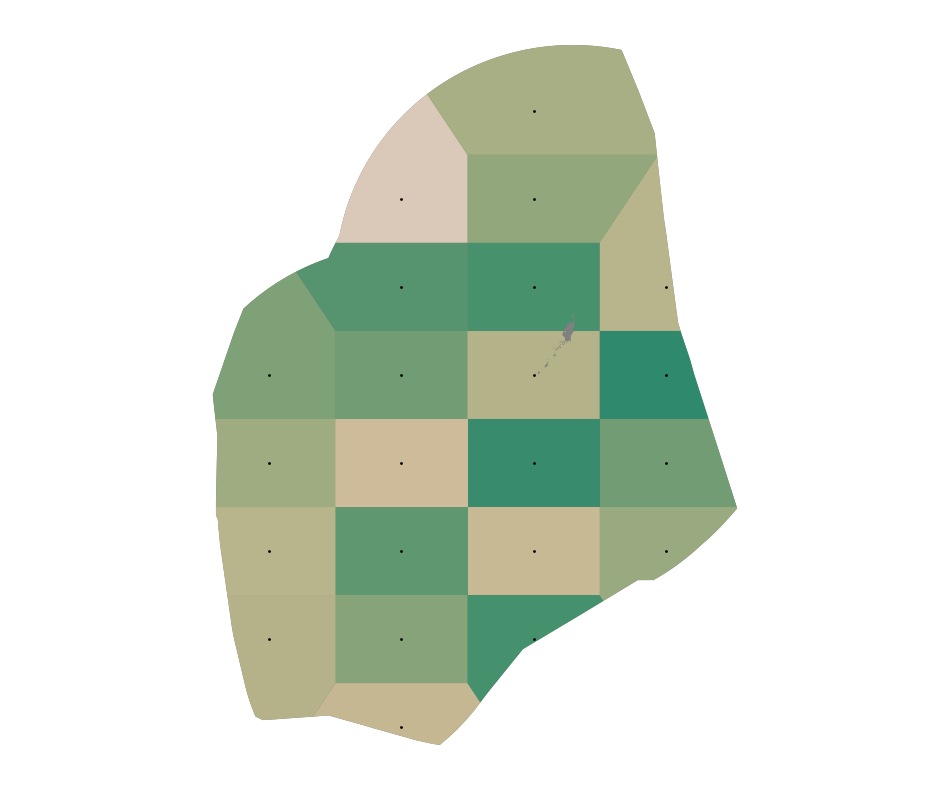

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2087_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


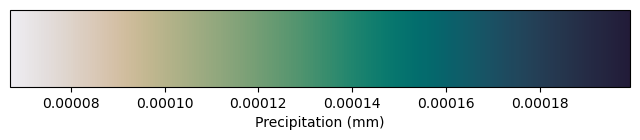

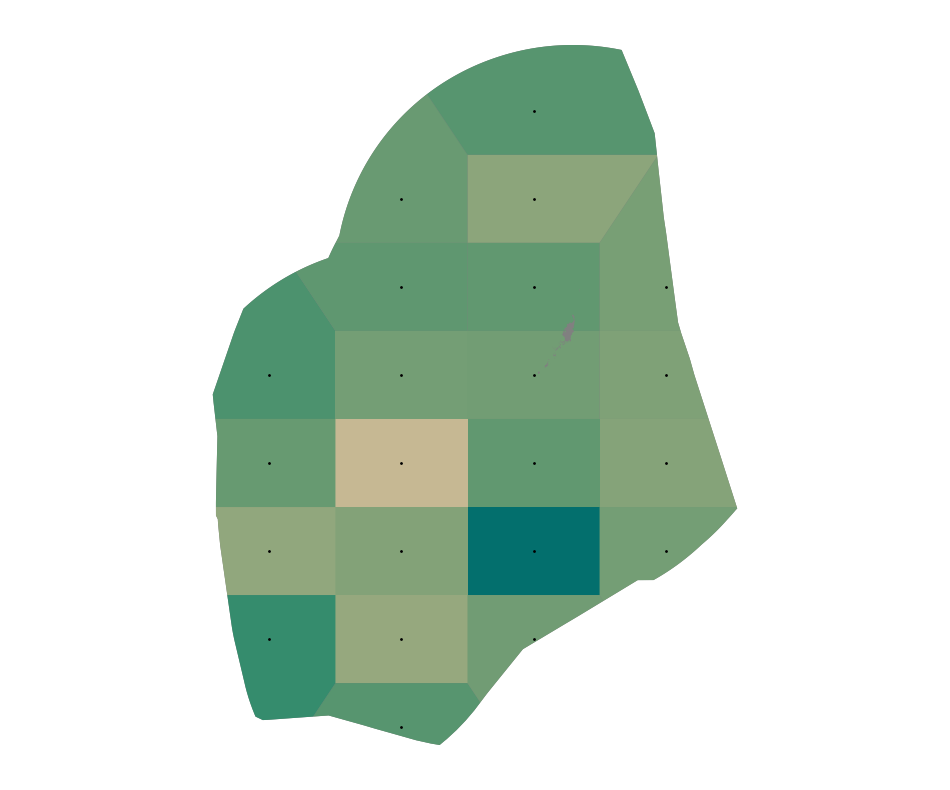

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2088_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


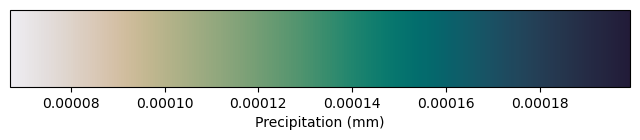

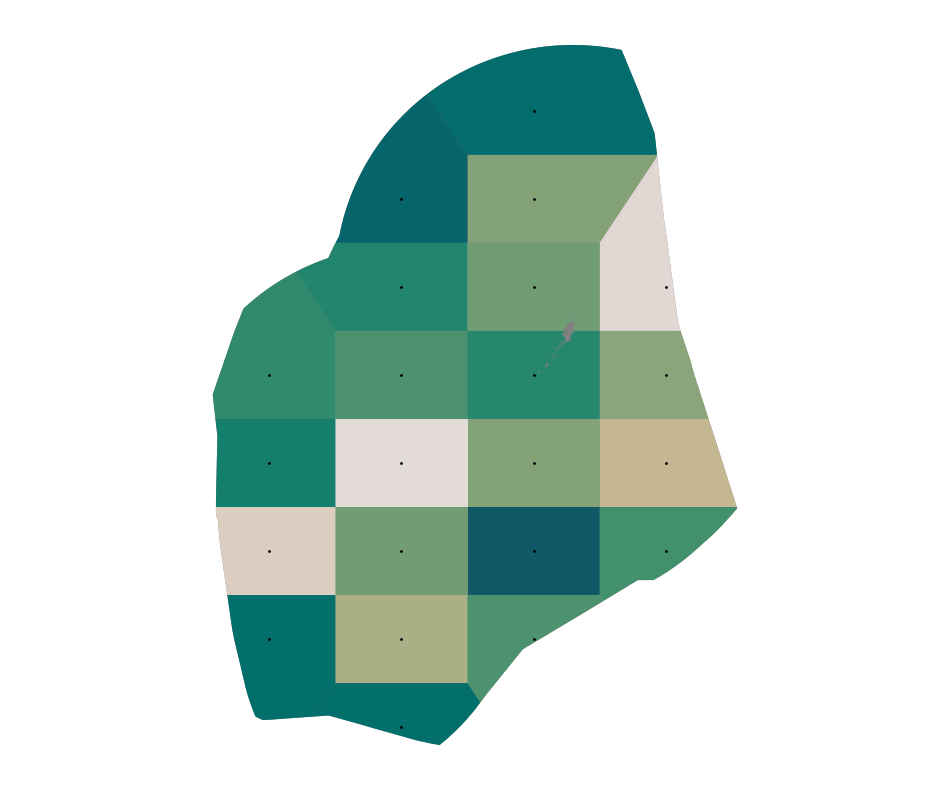

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2089_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


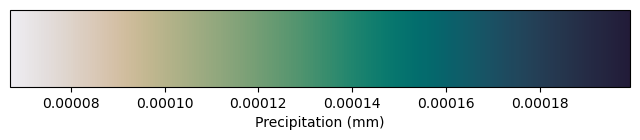

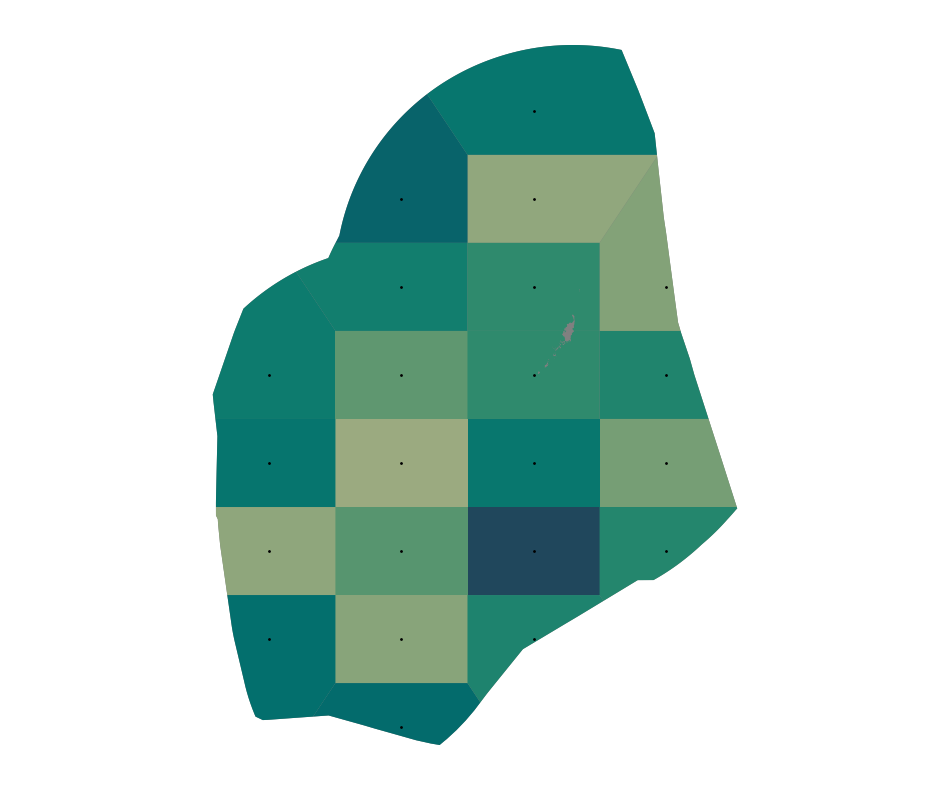

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2090_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


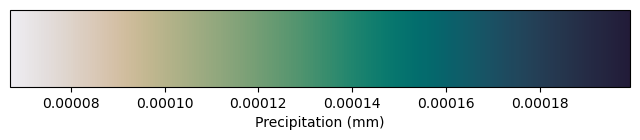

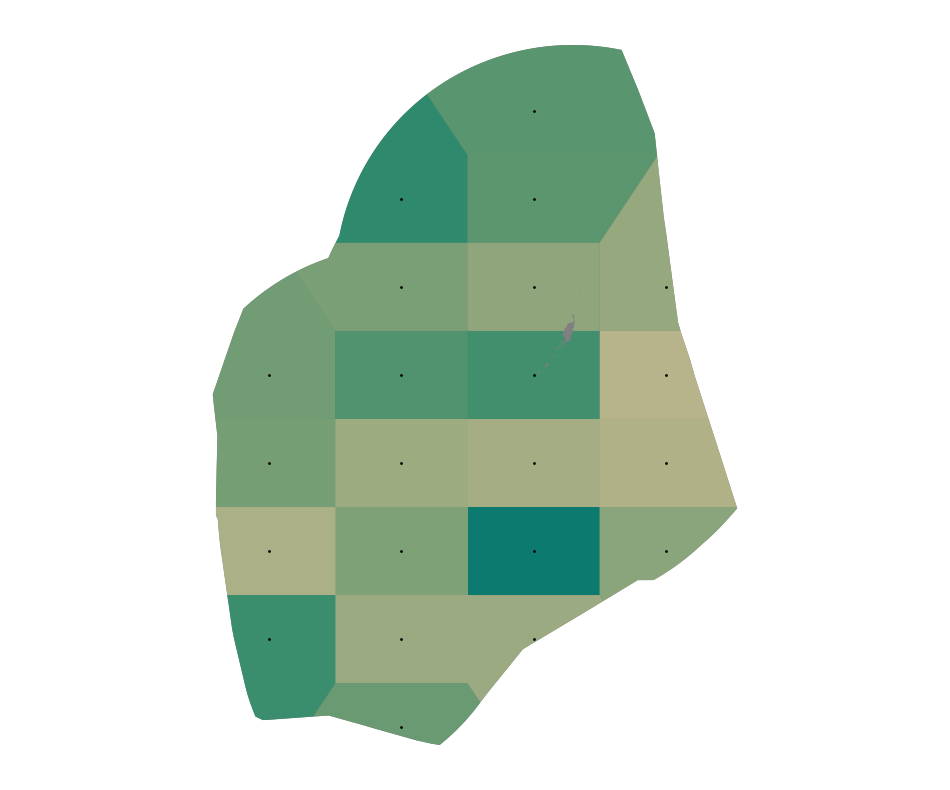

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2091_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


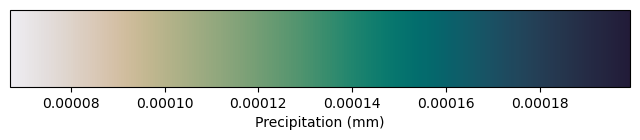

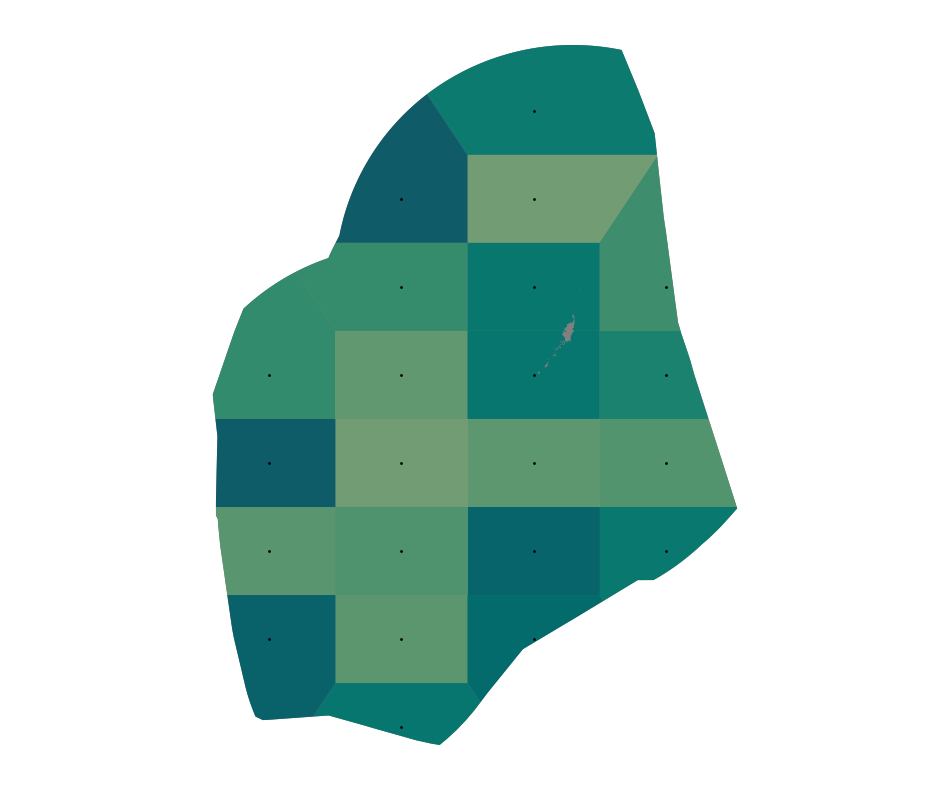

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2092_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


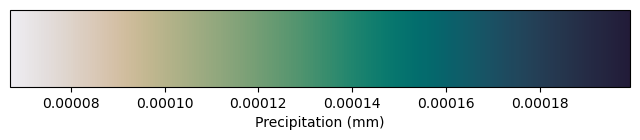

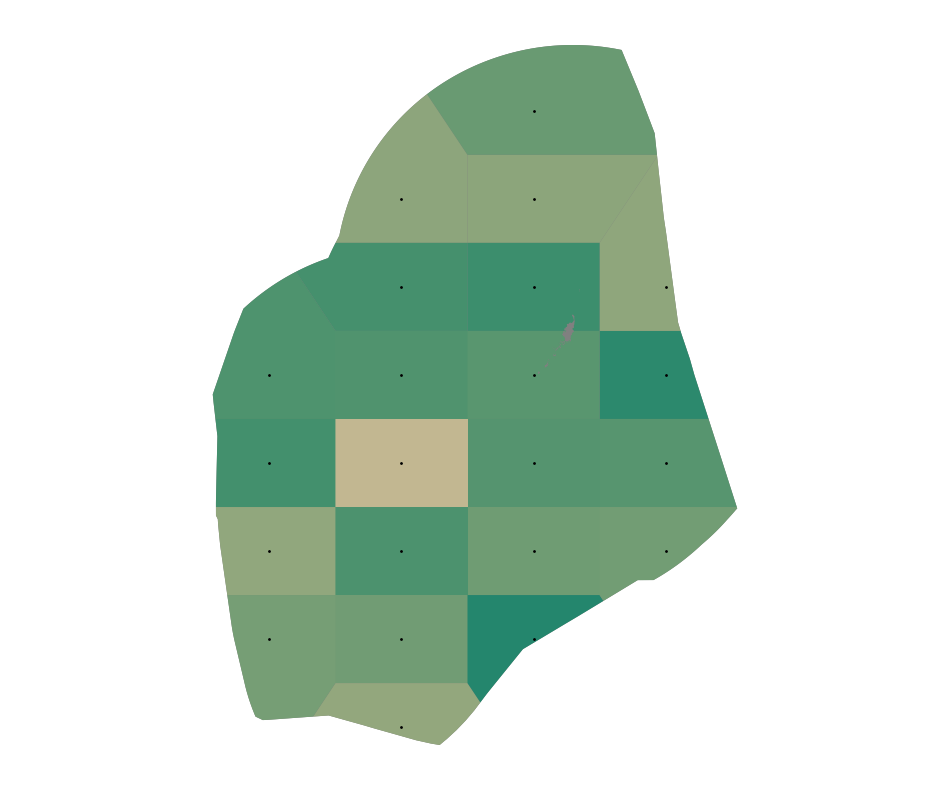

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2093_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


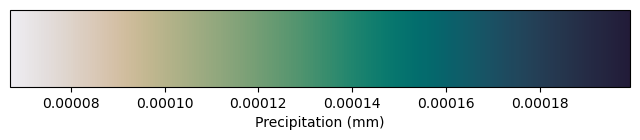

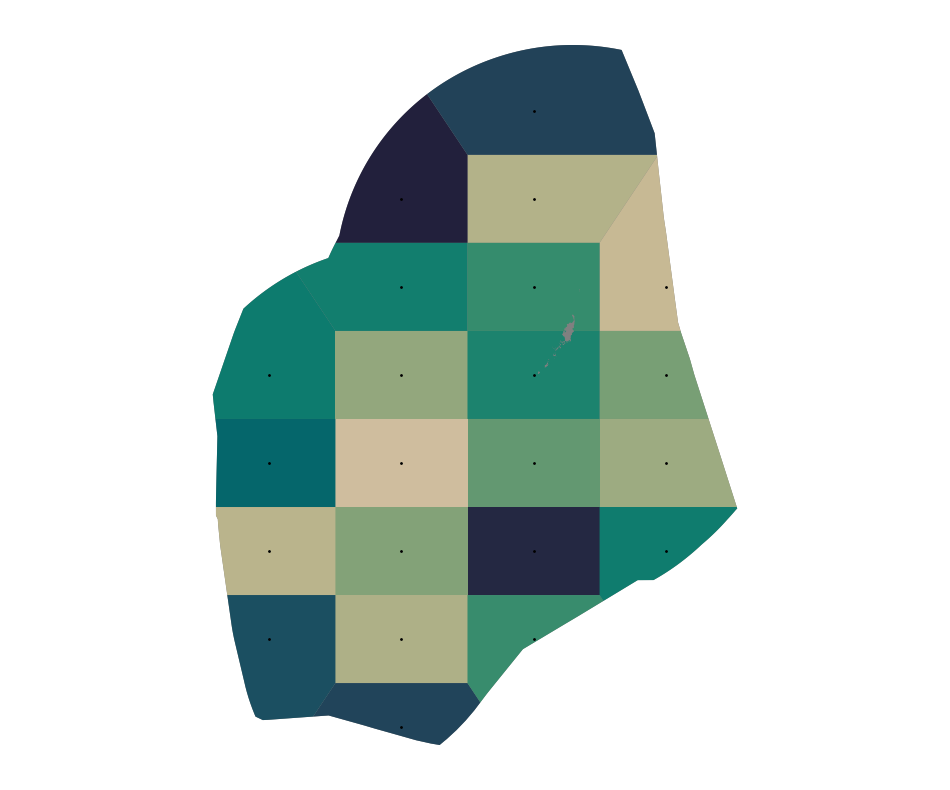

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2094_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


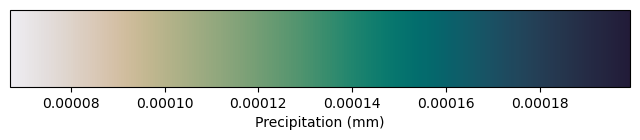

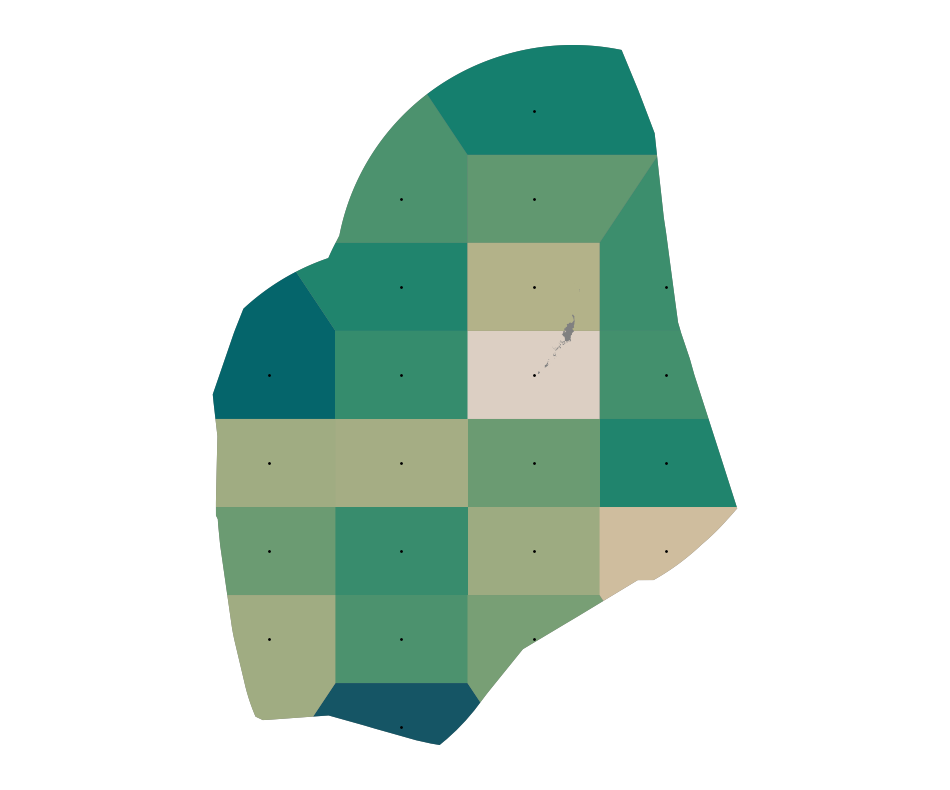

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2095_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


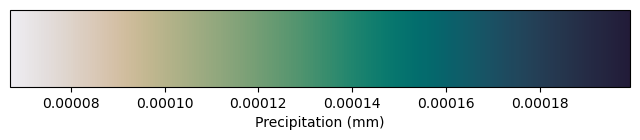

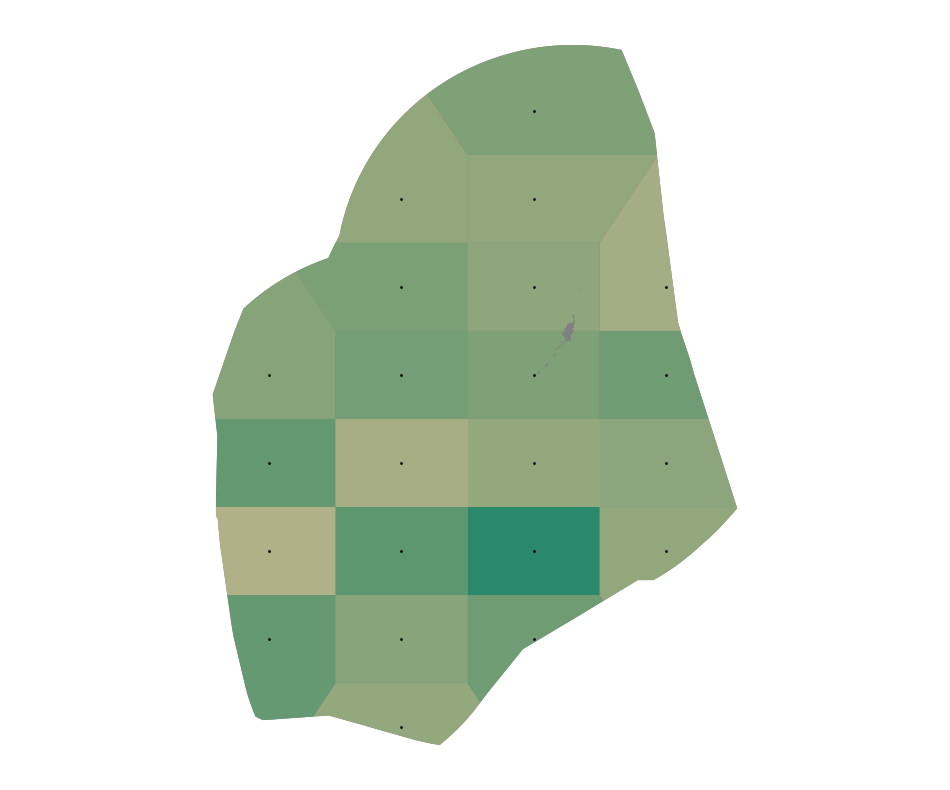

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2096_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


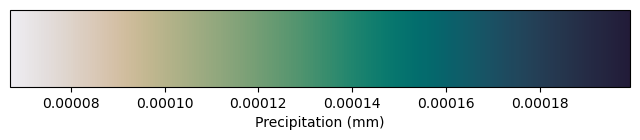

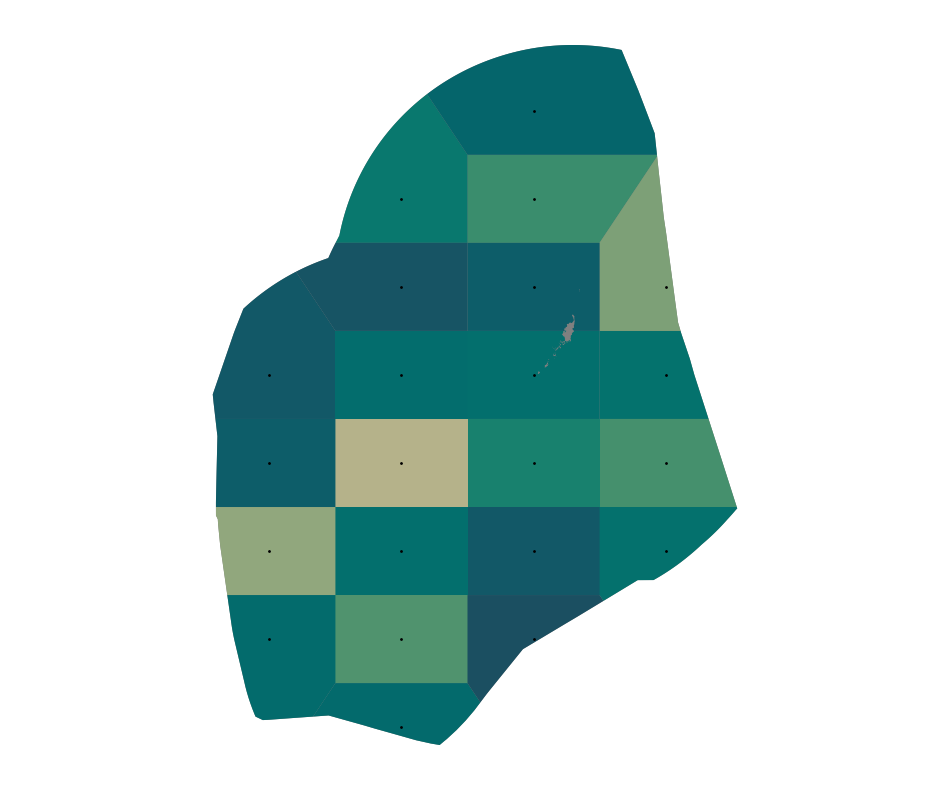

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2097_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


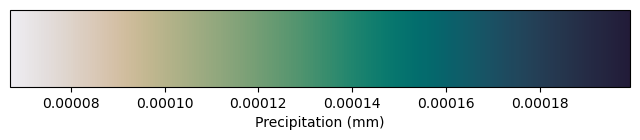

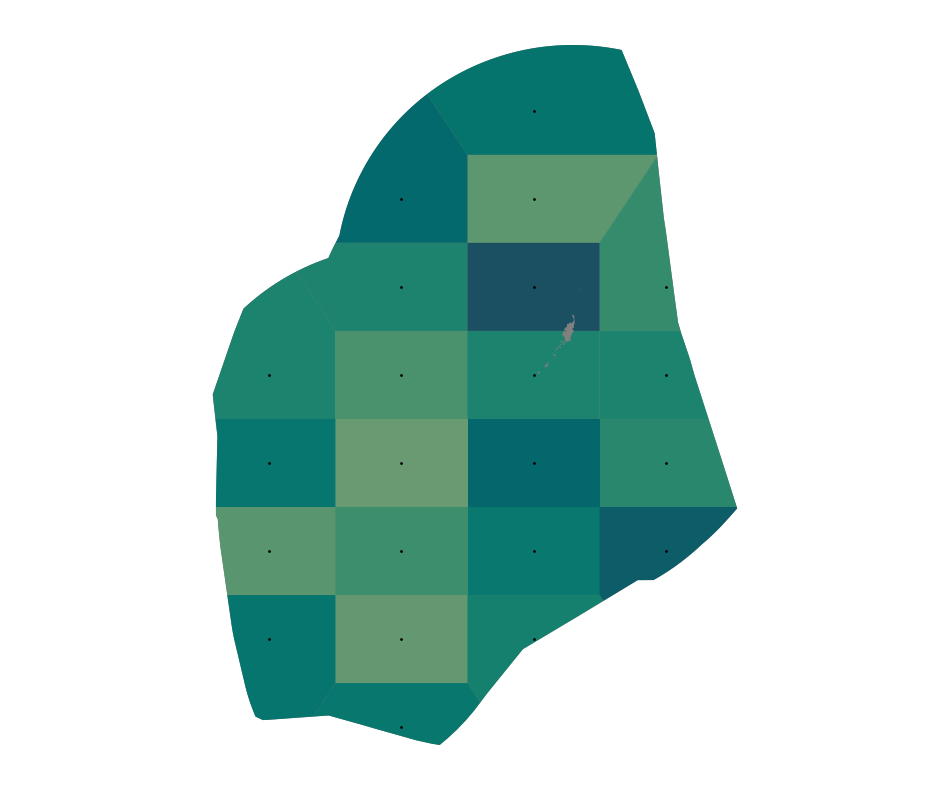

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2098_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


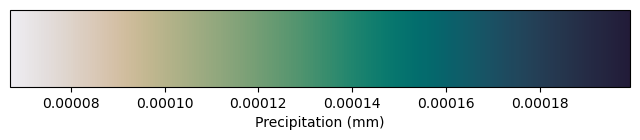

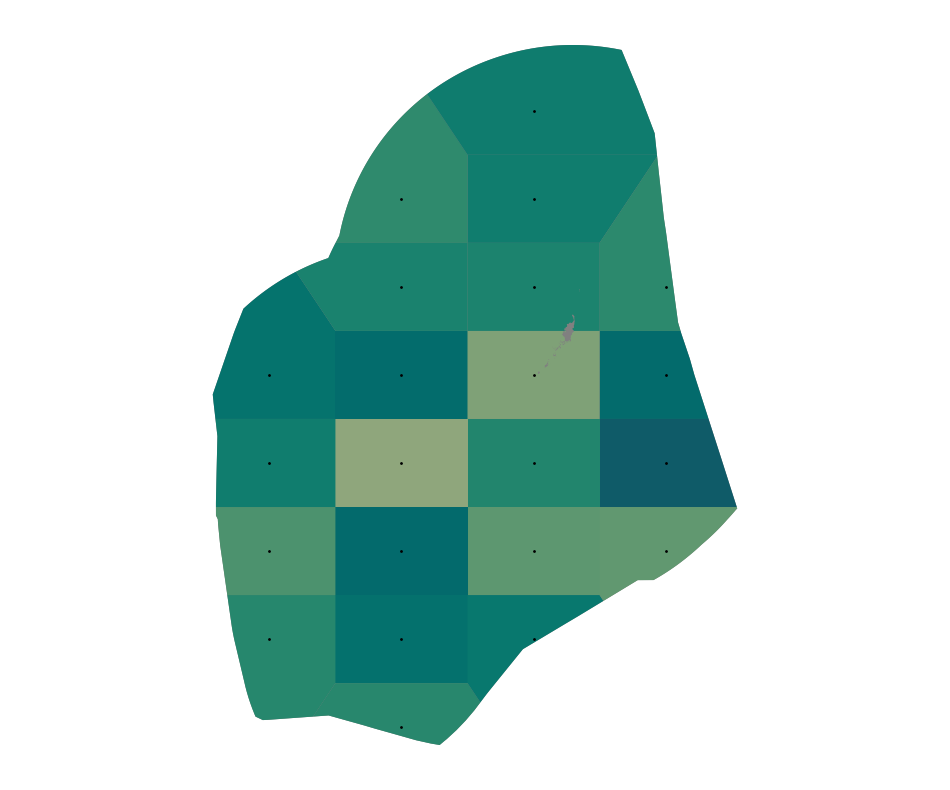

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2099_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_31867/978634359.py:64: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf, palau_land, how='difference')


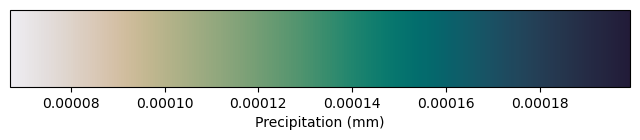

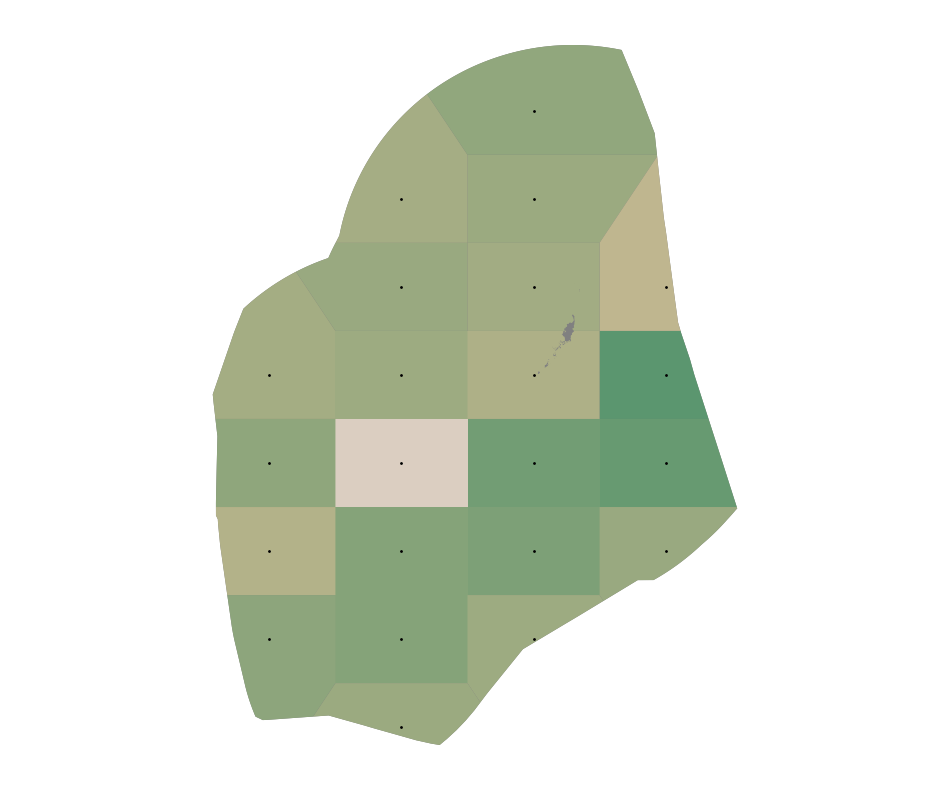

/Users/one/Documents/Palau/2_ocean/2.2_ocean-temperature/2.2.1_mean-sea-surface-temperature/prgeojson//pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1/2100_pr_Amon_KACE-1-0-G_ssp245_r1i1p1f1.json
E3SM-1-1-ECA ssp585


IndexError: list index out of range

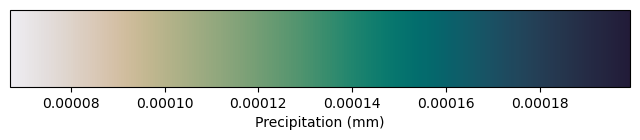

In [18]:
folder = os.getcwd() + '/latlon/'

geojson_folder = os.getcwd() + '/prgeojson/'
if not os.path.exists(geojson_folder):
    os.makedirs(geojson_folder)
    
colorbar_folder = os.getcwd() + '/pr_colorbar/'
if not os.path.exists(colorbar_folder):
    os.makedirs(colorbar_folder)
    
for source in list(experiment_dict.keys()):
    for experiment in experiment_dict[source]:
        print(source, experiment)
        file = [x for x in sources[source] if x[0]== 'pr' and x[1] == experiment][0][2]
        print(file)
        experiment_folder = geojson_folder + "/" + file[7:-5] + "/"
        if not os.path.exists(experiment_folder):
            os.makedirs(experiment_folder)
            
        colorbar_ex_folder = colorbar_folder + "/" + file[7:-5] + "/"
        if not os.path.exists(colorbar_ex_folder):
            os.makedirs(colorbar_ex_folder)
        
        
        df = pd.read_pickle(folder + file)
        df = df.dropna()
        df = df.reset_index()
        
        # df['pr'] = df['pr']- 273.15
        
        df = palau_eez(df)
        
        
        

        year_range = str(min(df['year'].tolist())) + "-" + str(max(df['year'].tolist()))
        colorbar_name = year_range + "_pr_colorbar" + "_" + file[7:-5] + ".png"
        
        # colorbar_mpl(df, colorbar_ex_folder + colorbar_name)
        print("Created: " +colorbar_name)
        for year in sorted(set(df['year'].tolist())):
            currgeo = getGridGeoJSON(year,df)
            json_object = json.dumps(currgeo, indent=4)
            
            geojson_dir = experiment_folder + str(year) + "_" + file[7:-5] +".json"
            with open(geojson_dir, "w") as outfile:
                outfile.write(json_object)
                print(geojson_dir)


In [ ]:
import numpy as np

if df.isnull().values.any():
    print("Warning: df contains NaN values")
    
if np.isinf(df.to_numpy()).any():
    print("Warning: df contains Inf values")

In [31]:
vmin, vmax = df['pr'].min(), df['pr'].max()
if np.isnan(vmin) or np.isnan(vmax):
    print("Warning: vmin or vmax is NaN!")

In [30]:
273.15-298.31

-25.160000000000025

In [29]:
import numpy as np

if df.isnull().values.any():
    print("Warning: df contains NaN values")
    
if np.isinf(df.to_numpy()).any():
    print("Warning: df contains Inf values")

In [ ]:
#Below is scratch work

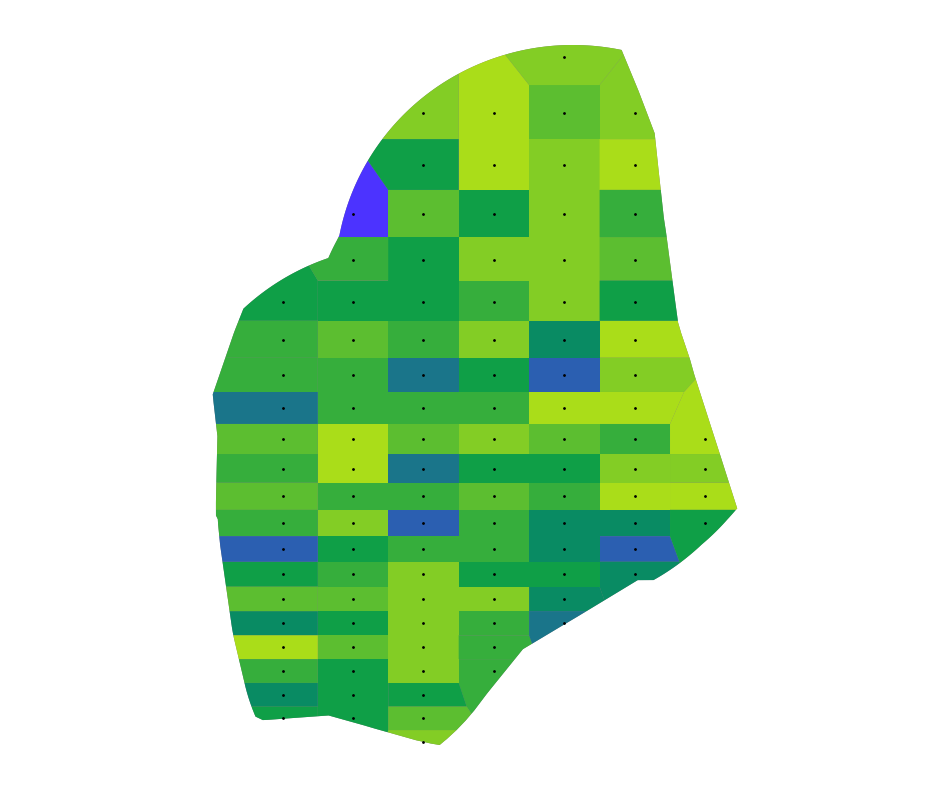

"{\"type\": \"FeatureCollection\", \"features\": [{\"id\": \"0\", \"type\": \"Feature\", \"properties\": {\"latitude\": 4.769481182098389, \"longitude\": 136.5, \"year\": 2040, \"tos\": 31.335214999689352, \"fill\": \"#83cd25\", \"R\": 131, \"G\": 205, \"B\": 37}, \"geometry\": {\"type\": \"Polygon\", \"coordinates\": [[[135.0, 10.222108840942383], [135.0, 10.989970684051514], [135.34037618065258, 11.420645703332927], [135.5507591751962, 10.912052330850543], [135.55209937009053, 10.908634746996228], [135.5945257968285, 10.797880850221247], [135.61517942549054, 10.743849510646669], [135.64947294482093, 10.653853046780938], [135.6497859538591, 10.653031206725018], [135.6501024612601, 10.652199893210806], [135.6504124962403, 10.651385294495924], [135.72691382161602, 10.450245598455737], [135.7279190595177, 10.447598390953118], [135.75766963194823, 10.369143924252782], [135.78178170516176, 10.305486046344171], [135.7907445968515, 10.222108840942383], [135.0, 10.222108840942383]]]}}, {\"id\

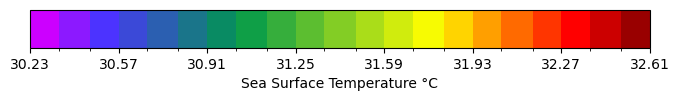

In [168]:
folder = os.getcwd() + '/latlon/'
for source in ['CanESM5','HadGEM3-GC31-MM']:
    for experiment in experiment_dict[source]:
        file = [x for x in sources[source] if x[0]== 'tos' and x[1] == experiment][0][2]
        df = pd.read_pickle(folder + file)
        df = df.dropna()
        df = df.reset_index()
        
        currgeo = getGridGeoJSON(2040,df)
        json_object = json.dumps(currgeo.to_json(), indent=4)
        print(json_object)
        break
    break

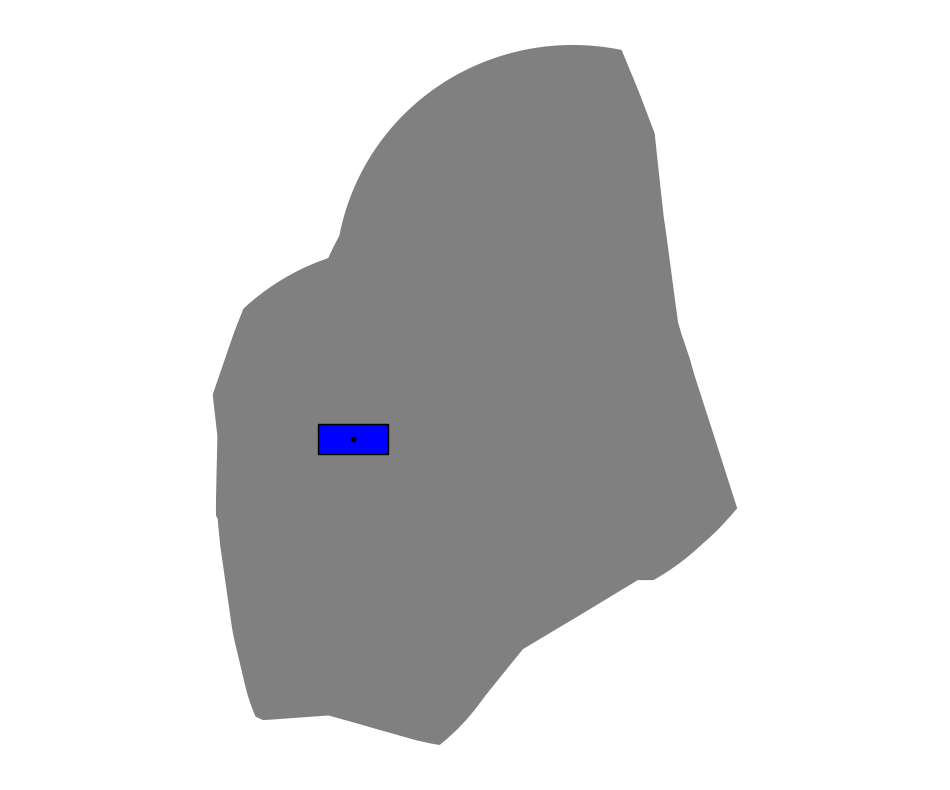

None


In [60]:
folder = os.getcwd() + '/latlon/'
for source in ['CanESM5','HadGEM3-GC31-MM']:
    for experiment in experiment_dict[source]:
        file = [x for x in sources[source] if x[0]== 'tos' and x[1] == experiment][0][2]
        df = pd.read_pickle(folder + file)
        df = df.dropna()
        df = df.reset_index()
        print(getGridGeoJSON(2040,df))
        break
    break

In [31]:
folder = os.getcwd() + '/latlon/'
for source in ['CanESM5','HadGEM3-GC31-MM']:
    for experiment in experiment_dict[source]:
        file = [x for x in sources[source] if x[0]== 'tos' and x[1] == experiment][0][2]
        df = pd.read_pickle(folder + file)
        df = df.dropna()
        df = df.reset_index()
        getGridGeoJSON(2040,df)
        break
    break

                                              geometry
0    POLYGON ((135.000 10.222, 135.000 10.990, 135....
1    POLYGON ((131.000 6.179, 132.000 6.179, 132.00...
2    POLYGON ((134.000 10.990, 134.000 10.222, 133....
3    POLYGON ((133.000 11.151, 133.000 10.222, 131....
4    POLYGON ((134.000 10.990, 134.000 10.222, 135....
..                                                 ...
103  POLYGON ((132.000 3.869, 131.000 3.869, 131.00...
104  POLYGON ((134.000 3.522, 134.000 3.179, 133.00...
105  POLYGON ((133.000 3.869, 133.000 4.223, 134.00...
106  POLYGON ((132.000 3.179, 132.000 3.522, 131.00...
107  POLYGON ((132.000 3.869, 132.000 4.223, 131.00...

[108 rows x 1 columns] {0: [106], 1: [59], 2: [104], 3: [103], 4: [105], 5: [107], 6: [0], 7: [50], 8: [82], 9: [76], 10: [44], 11: [51], 12: [37], 13: [45], 14: [25], 15: [15], 16: [65], 17: [31], 18: [71], 19: [58], 20: [20], 21: [38], 22: [52], 23: [49], 24: [61], 25: [60], 26: [67], 27: [72], 28: [66], 29: [68], 30: [74], 31: [81], 3